# Hyperspectral Experiments

In this notebook we provide the code to run the experiments on the Hyperspectral dataset. The user can:
- load the dataset of hyperspectral imaging.
- train a simple neural network(2 hidden layers) with 3 different criteria: Cross-Entropy, Label Smoothing and FIERCE.
- perfom the regression transfer tasks.
- compute and plot the statistics: Mutual Information, Reliability Diagram (ECE & MCE), Stability.

## Load the libraries and the dataset

In [1]:
!pip install torch-ema
from google.colab import drive
import numpy as np
import matplotlib.pyplot as plt
import pickle
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.manifold import TSNE
from warnings import simplefilter
from torch_ema import ExponentialMovingAverage
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

In [2]:
### Batch size for the training. We choose 200
batch_size = 200

In [12]:
PIK = 'classif_unmixing_data_houston.pickle'

with open(PIK, "rb") as f:
    [X,E,y,S,y,A,m,n,L,P] = pickle.load(f)
N = m*n

# data = [X,E,y,S,y,A,m,n,L,P]
# model :

# x_n  = S_n a_n + e_n

# n: pixel index from 1 to N = m*n
# x_n: one pixel (L = 144 channels)
# S_n: matrix contraining sources (pixel dependent) for all P =4 materials in its columns
# a_n: proportions in one pixel (positive and sum to one)

# proportion matrix P*N
# S: L*P*N tensor with all source matrices in all pixels 
# E: Gaussian additive noise (SNR = 30dB), not included in X (to get noisy data, do X = X + E)

# y: classification labels (arg max of proportions vector in each pixel): to be converted to one hot

# 0: Vegetation
# 1: Red metallic roofs
# 2: Concrete
# 3: Asphalt


###y_A contains the classification label y and the proportions A
y_A = torch.cat((torch.tensor(y).unsqueeze(-1),torch.tensor(A.T)),1)
dataset_simplex = torch.utils.data.TensorDataset(torch.tensor(X.T).float(),y_A.float())
train_set, test_set = torch.utils.data.random_split(dataset_simplex, [9408, 4032])

train_loader = DataLoader(
    dataset=train_set, 
    batch_size=batch_size , 
    shuffle=True, )
test_loader =  DataLoader(
    dataset=test_set, 
    batch_size=1000 , 
    shuffle=False, )

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## Define the Model

In [14]:
class Net(nn.Module):
    # define nn                                                                                                                                                                                        
    def __init__(self, Ncouche = 50, dim =200, embedding = 10, FIERCE_parameter = 0):
        super(Net, self).__init__()
        ####Linear layers
        self.fc1 = nn.Linear(144, 200 )
        self.fc2 = torch.nn.Linear(200, 400)
        self.fc3 = torch.nn.Linear(400, dim)
        self.fc4 = nn.Linear(dim , 4)

        if FIERCE_parameter > 0:
          self.FIERCE = True
        else:
          self.FIERCE = False
        self.FIERCE_parameter = FIERCE_parameter
        
        cat = 1
        ### The entries of the dictionary (uniform init)
        self.proj = torch.randn(cat,dim, embedding)
        torch.nn.init.uniform_(self.proj)
        self.proj = torch.abs(self.proj)
    def forward(self, X):

        ### Feed Forward
        X = F.relu(self.fc1(X))
        features = F.relu(self.fc2(X))
        features = F.relu(self.fc3(features))
        X = self.fc4(features)

        if self.FIERCE:
          ### Approximation of the entropy
          ### Compute the similarity 
          similarity  =  torch.einsum('bd,cde -> bce', features,self.proj.detach())
          ###Sample according to Gumbel Softmax trick
          soft_one_hot = F.gumbel_softmax(similarity, hard =True)
          ###Convert into logits and estimate p(features) (Categorical)
          logits = soft_one_hot.sum(0) / X.size()[0] 
          ###Compute the approximation of the entropy
          entropy =  - torch.sum(logits*torch.log2(logits+1e-21),1).mean()
        else:
          entropy = 0
    
        return X,features,entropy


## Training Script

In [20]:
def entropy_features(features, bins = 10,print = False):
  hist= torch.histc(features,bins = 10)
  hist /=hist.sum()
  if print:
    plt.hist(features)
  return - (hist * (1e-21+hist).log2()).sum()

def train(model,train_loader,optimizer):
    total_loss, total_elts, train_acc, mse = 0., 0., 0.,0.
    for batch_idx,(x,y) in enumerate(train_loader):

      ### y classification label, z fine labels (proportion) used to compute the raw MSE 
      y, z  = y[:,0].long() , y[:,1:]
      optimizer.zero_grad()

      out,features,entropy= model(x)
      loss = criterion(out, y) - entropy * model.FIERCE_parameter
      loss.backward()
      optimizer.step()


      total_loss += loss.item() * x.shape[0]
      

      
      ###Compute the train accuracy (classification)
      _, predict_y = torch.max(out, 1)
      train_acc += torch.sum(predict_y.data == y)/x.size()[0]
      #### Compute the raw MSE (regression)
      mse += (((z - F.softmax(out,-1))**2).sum(1)).mean()

    return { "train_loss" : total_loss / (batch_idx + 1),  "train_acc" : train_acc / (batch_idx + 1), "train_mse": mse / (batch_idx + 1)}

def test(model,test_loader,print_features = False):
  total_loss, total_elts,test_acc,mse = 0., 0., 0.,0.
  all_features = []
  all_target = []
  delta = torch.zeros(4)
  for batch_idx, (x_test,y_test) in enumerate(test_loader):

    y_test,z  = y_test[:,0].long(),  y_test[:,1:]
    all_target.append(y_test)

    predict_out,features,__ = model(x_test)
    _, predict_y = torch.max(predict_out, 1)

    ### Compute test accuracy (classification)
    accuracy_score(y_test, predict_y.data)
    test_acc += accuracy_score(y_test, predict_y.data)

    ### Compute MSE test (regression)
    delta += ((z - F.softmax(predict_out,-1))**2).mean(0).detach()
    mse += ( (z - F.softmax(predict_out,-1))**2).sum(1).mean().detach()

    ### Compute the entropy of the features
    all_features.append(features.flatten(start_dim = 1))
    features = torch.cat(all_features)[:1000,:]
    entropy_calc = entropy_features(features)

    ### represent features with TSNE
    if print_features:
      features = torch.cat(all_features)[:1000,:]
      target = torch.cat(all_target)[:1000]
      tsne = TSNE(n_components=2,learning_rate = 'auto',init ='pca').fit_transform(features.detach().numpy())
      tx = tsne[:, 0]
      ty = tsne[:, 1]
      H, edges,_ = np.histogram2d(tx,ty)
      entropy = -H.dot( np.log( (1e-21+H))).sum()
      print("final entropy: ", entropy)
      fig = plt.figure()
      ax = fig.add_subplot(111)
      scatter = ax.scatter(tx, ty,c=target)
      #legend1 = ax.legend(*scatter.legend_elements(),loc="lower left", title="Classes")
      #ax.add_artist(legend1)
      plt.savefig("features.png")
      plt.show()
      break
  return {"test_acc": test_acc/(batch_idx+1),"test_mse": mse/(batch_idx+1),"delta": delta/(batch_idx+1),"entropy_features": entropy_calc }

def experiment(model,train_loader, test_loader,epochs,lr =0.1,step_size = 100):
  optimizer = torch.optim.Adam(model.parameters(), lr=lr)
  scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.1)

  MSE_list = []
  train_acc_list = []
  Entropy_list = []
  for epoch in range(epochs):
    train_stats = train(model,train_loader,optimizer)
    scheduler.step()
    
    test_stats = test(model,test_loader) 
    print("\rEpoch: {:3d}, train_loss: {:.5f}, train_acc: {:.4f}, train_mse: {:.4f}, test_mse: {:.4f}".format(epoch, train_stats["train_loss"], 
                                                                                                            train_stats["train_acc"], train_stats["train_mse"], test_stats["test_mse"]
                     
                                                                                                                   ),test_stats["delta"], end = "")
    
    Entropy_list.append(test_stats["entropy_features"].detach())
    train_acc_list.append(torch.tensor(train_stats["train_acc"]))
    MSE_list.append( train_stats["train_mse"].detach())

  test_stats = test(model,test_loader,True) 
  print("\rEpoch: {:3d}, test_stats: {:.4f},test_stats: {:.4f}".format(epoch, 100*test_stats["test_acc"], test_stats["test_mse"]),test_stats["delta"])           
  print("minimum achieved",np.array(MSE_list).min())                                                  
  return torch.stack(train_acc_list),torch.stack(MSE_list),torch.stack(Entropy_list)



In [43]:
### Label Smoothing
def linear_combination(x, y, epsilon):
    return epsilon * x + (1 - epsilon) * y


def reduce_loss(loss, reduction='mean'):
    return loss.mean() if reduction == 'mean' else loss.sum() if reduction == 'sum' else loss

class LabelSmoothingCrossEntropy(nn.Module):
    def __init__(self, epsilon: float = 0.4, reduction='mean'):
        super().__init__()
        self.epsilon = epsilon
        self.reduction = reduction

    def forward(self, preds, target):
        n = preds.size()[-1]
        log_preds = F.log_softmax(preds, dim=-1)
        loss = reduce_loss(-log_preds.sum(dim=-1), self.reduction)
        nll = F.nll_loss(log_preds, target, reduction=self.reduction)
        return linear_combination(loss / n, nll, self.epsilon)

Epoch:   0, train_loss: -948.64547, train_acc: 0.3490, train_mse: 0.3214, test_mse: 0.3218 tensor([0.1203, 0.0392, 0.0884, 0.0738])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:   1, train_loss: -951.72779, train_acc: 0.3580, train_mse: 0.3175, test_mse: 0.3199 tensor([0.1201, 0.0380, 0.0880, 0.0738])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:   2, train_loss: -952.72150, train_acc: 0.3605, train_mse: 0.3138, test_mse: 0.3183 tensor([0.1199, 0.0375, 0.0873, 0.0736])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:   3, train_loss: -957.24314, train_acc: 0.3680, train_mse: 0.3128, test_mse: 0.3174 tensor([0.1196, 0.0368, 0.0872, 0.0737])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:   4, train_loss: -954.11255, train_acc: 0.3655, train_mse: 0.3132, test_mse: 0.3158 tensor([0.1193, 0.0361, 0.0867, 0.0737])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:   5, train_loss: -954.88739, train_acc: 0.3605, train_mse: 0.3119, test_mse: 0.3149 tensor([0.1189, 0.0357, 0.0868, 0.0734])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:   6, train_loss: -956.08802, train_acc: 0.4853, train_mse: 0.3085, test_mse: 0.3147 tensor([0.1187, 0.0352, 0.0873, 0.0734])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:   7, train_loss: -955.56574, train_acc: 0.5931, train_mse: 0.3122, test_mse: 0.3123 tensor([0.1180, 0.0347, 0.0864, 0.0732])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:   8, train_loss: -959.10690, train_acc: 0.6401, train_mse: 0.3052, test_mse: 0.3090 tensor([0.1170, 0.0340, 0.0850, 0.0730])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:   9, train_loss: -961.57569, train_acc: 0.6270, train_mse: 0.3031, test_mse: 0.3061 tensor([0.1160, 0.0335, 0.0839, 0.0727])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  10, train_loss: -960.35483, train_acc: 0.6751, train_mse: 0.3001, test_mse: 0.3044 tensor([0.1150, 0.0329, 0.0839, 0.0725])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  11, train_loss: -964.48744, train_acc: 0.6695, train_mse: 0.3008, test_mse: 0.3010 tensor([0.1133, 0.0324, 0.0829, 0.0723])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  12, train_loss: -966.49906, train_acc: 0.6780, train_mse: 0.2945, test_mse: 0.2979 tensor([0.1110, 0.0322, 0.0831, 0.0717])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  13, train_loss: -963.98778, train_acc: 0.6732, train_mse: 0.2936, test_mse: 0.2912 tensor([0.1073, 0.0317, 0.0813, 0.0708])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  14, train_loss: -974.58526, train_acc: 0.7177, train_mse: 0.2859, test_mse: 0.2823 tensor([0.1026, 0.0310, 0.0787, 0.0700])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  15, train_loss: -976.72269, train_acc: 0.7361, train_mse: 0.2747, test_mse: 0.2758 tensor([0.0985, 0.0306, 0.0777, 0.0690])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  16, train_loss: -979.32667, train_acc: 0.7386, train_mse: 0.2695, test_mse: 0.2688 tensor([0.0936, 0.0296, 0.0778, 0.0678])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  17, train_loss: -985.05607, train_acc: 0.7317, train_mse: 0.2576, test_mse: 0.2532 tensor([0.0848, 0.0286, 0.0734, 0.0664])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  18, train_loss: -989.59475, train_acc: 0.7183, train_mse: 0.2482, test_mse: 0.2406 tensor([0.0758, 0.0275, 0.0728, 0.0646])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  19, train_loss: -1001.77938, train_acc: 0.7517, train_mse: 0.2285, test_mse: 0.2207 tensor([0.0649, 0.0266, 0.0662, 0.0630])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  20, train_loss: -1010.09109, train_acc: 0.8228, train_mse: 0.2124, test_mse: 0.2009 tensor([0.0530, 0.0260, 0.0615, 0.0605])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  21, train_loss: -1019.45790, train_acc: 0.8080, train_mse: 0.1900, test_mse: 0.1814 tensor([0.0400, 0.0247, 0.0604, 0.0564])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  22, train_loss: -1026.36495, train_acc: 0.7979, train_mse: 0.1713, test_mse: 0.1655 tensor([0.0303, 0.0239, 0.0571, 0.0542])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  23, train_loss: -1034.07102, train_acc: 0.8156, train_mse: 0.1657, test_mse: 0.1578 tensor([0.0256, 0.0237, 0.0553, 0.0531])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  24, train_loss: -1040.04564, train_acc: 0.8471, train_mse: 0.1546, test_mse: 0.1483 tensor([0.0214, 0.0233, 0.0529, 0.0506])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  25, train_loss: -1046.84798, train_acc: 0.8483, train_mse: 0.1490, test_mse: 0.1405 tensor([0.0167, 0.0237, 0.0505, 0.0496])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  26, train_loss: -1054.95548, train_acc: 0.8507, train_mse: 0.1408, test_mse: 0.1331 tensor([0.0151, 0.0238, 0.0473, 0.0470])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  27, train_loss: -1056.74643, train_acc: 0.8611, train_mse: 0.1338, test_mse: 0.1324 tensor([0.0148, 0.0235, 0.0484, 0.0457])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  28, train_loss: -1059.00243, train_acc: 0.8455, train_mse: 0.1348, test_mse: 0.1293 tensor([0.0151, 0.0233, 0.0468, 0.0441])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  29, train_loss: -1061.47291, train_acc: 0.8743, train_mse: 0.1268, test_mse: 0.1200 tensor([0.0120, 0.0240, 0.0418, 0.0421])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  30, train_loss: -1065.45749, train_acc: 0.8536, train_mse: 0.1246, test_mse: 0.1220 tensor([0.0124, 0.0236, 0.0456, 0.0404])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  31, train_loss: -1070.09612, train_acc: 0.8642, train_mse: 0.1194, test_mse: 0.1166 tensor([0.0102, 0.0243, 0.0424, 0.0397])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  32, train_loss: -1072.34214, train_acc: 0.8391, train_mse: 0.1185, test_mse: 0.1230 tensor([0.0125, 0.0237, 0.0479, 0.0389])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  33, train_loss: -1072.03752, train_acc: 0.8345, train_mse: 0.1236, test_mse: 0.1129 tensor([0.0128, 0.0235, 0.0416, 0.0349])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  34, train_loss: -1075.43747, train_acc: 0.8462, train_mse: 0.1167, test_mse: 0.1070 tensor([0.0118, 0.0237, 0.0390, 0.0324])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  35, train_loss: -1077.76813, train_acc: 0.8583, train_mse: 0.1077, test_mse: 0.1069 tensor([0.0102, 0.0245, 0.0400, 0.0323])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  36, train_loss: -1081.31593, train_acc: 0.7953, train_mse: 0.1142, test_mse: 0.1045 tensor([0.0109, 0.0242, 0.0395, 0.0299])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  37, train_loss: -1084.45208, train_acc: 0.8735, train_mse: 0.1050, test_mse: 0.0907 tensor([0.0091, 0.0246, 0.0321, 0.0249])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  38, train_loss: -1091.03905, train_acc: 0.8791, train_mse: 0.0936, test_mse: 0.0853 tensor([0.0089, 0.0249, 0.0296, 0.0219])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  39, train_loss: -1094.74752, train_acc: 0.8560, train_mse: 0.0939, test_mse: 0.0937 tensor([0.0106, 0.0244, 0.0357, 0.0230])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  40, train_loss: -1099.06812, train_acc: 0.8636, train_mse: 0.0934, test_mse: 0.0926 tensor([0.0084, 0.0255, 0.0341, 0.0245])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  41, train_loss: -1100.93834, train_acc: 0.8714, train_mse: 0.0867, test_mse: 0.0795 tensor([0.0079, 0.0257, 0.0274, 0.0185])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  42, train_loss: -1105.63258, train_acc: 0.8555, train_mse: 0.0895, test_mse: 0.0768 tensor([0.0084, 0.0256, 0.0259, 0.0169])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  43, train_loss: -1105.28841, train_acc: 0.8918, train_mse: 0.0794, test_mse: 0.0714 tensor([0.0079, 0.0257, 0.0233, 0.0144])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  44, train_loss: -1111.09628, train_acc: 0.8867, train_mse: 0.0808, test_mse: 0.0768 tensor([0.0101, 0.0250, 0.0266, 0.0150])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  45, train_loss: -1111.88114, train_acc: 0.8749, train_mse: 0.0820, test_mse: 0.0675 tensor([0.0081, 0.0253, 0.0220, 0.0121])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  46, train_loss: -1112.18276, train_acc: 0.8861, train_mse: 0.0782, test_mse: 0.0750 tensor([0.0086, 0.0249, 0.0267, 0.0148])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  47, train_loss: -1112.72307, train_acc: 0.8700, train_mse: 0.0837, test_mse: 0.0782 tensor([0.0090, 0.0257, 0.0270, 0.0165])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  48, train_loss: -1121.29726, train_acc: 0.8898, train_mse: 0.0767, test_mse: 0.0668 tensor([0.0062, 0.0278, 0.0195, 0.0134])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  49, train_loss: -1124.87978, train_acc: 0.8897, train_mse: 0.0789, test_mse: 0.0697 tensor([0.0096, 0.0270, 0.0206, 0.0125])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  50, train_loss: -1121.02815, train_acc: 0.8908, train_mse: 0.0765, test_mse: 0.0780 tensor([0.0070, 0.0278, 0.0237, 0.0195])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  51, train_loss: -1126.62229, train_acc: 0.8907, train_mse: 0.0815, test_mse: 0.0791 tensor([0.0075, 0.0281, 0.0232, 0.0204])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  52, train_loss: -1128.63915, train_acc: 0.8911, train_mse: 0.0816, test_mse: 0.0707 tensor([0.0078, 0.0275, 0.0202, 0.0153])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  53, train_loss: -1129.43499, train_acc: 0.8964, train_mse: 0.0797, test_mse: 0.0854 tensor([0.0080, 0.0279, 0.0253, 0.0241])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  54, train_loss: -1132.07774, train_acc: 0.8879, train_mse: 0.0831, test_mse: 0.0723 tensor([0.0066, 0.0277, 0.0203, 0.0177])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  55, train_loss: -1133.53290, train_acc: 0.8905, train_mse: 0.0856, test_mse: 0.0872 tensor([0.0060, 0.0291, 0.0239, 0.0283])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  56, train_loss: -1132.50860, train_acc: 0.8848, train_mse: 0.0904, test_mse: 0.0701 tensor([0.0102, 0.0269, 0.0193, 0.0138])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  57, train_loss: -1137.42775, train_acc: 0.8886, train_mse: 0.0884, test_mse: 0.0697 tensor([0.0085, 0.0273, 0.0188, 0.0151])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  58, train_loss: -1136.10420, train_acc: 0.9095, train_mse: 0.0790, test_mse: 0.0784 tensor([0.0088, 0.0286, 0.0205, 0.0205])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  59, train_loss: -1137.04793, train_acc: 0.9058, train_mse: 0.0813, test_mse: 0.0729 tensor([0.0065, 0.0287, 0.0192, 0.0185])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  60, train_loss: -1140.75533, train_acc: 0.9029, train_mse: 0.0844, test_mse: 0.0805 tensor([0.0063, 0.0294, 0.0206, 0.0242])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  61, train_loss: -1141.32043, train_acc: 0.9049, train_mse: 0.0879, test_mse: 0.0867 tensor([0.0074, 0.0290, 0.0223, 0.0280])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  62, train_loss: -1142.78826, train_acc: 0.9055, train_mse: 0.0858, test_mse: 0.0764 tensor([0.0082, 0.0282, 0.0198, 0.0201])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  63, train_loss: -1142.87388, train_acc: 0.9070, train_mse: 0.0849, test_mse: 0.0778 tensor([0.0069, 0.0288, 0.0200, 0.0221])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  64, train_loss: -1142.70032, train_acc: 0.9123, train_mse: 0.0841, test_mse: 0.0794 tensor([0.0067, 0.0294, 0.0201, 0.0232])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  65, train_loss: -1145.18029, train_acc: 0.9137, train_mse: 0.0851, test_mse: 0.0802 tensor([0.0094, 0.0280, 0.0207, 0.0222])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  66, train_loss: -1146.55793, train_acc: 0.9028, train_mse: 0.0928, test_mse: 0.0913 tensor([0.0086, 0.0296, 0.0229, 0.0301])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  67, train_loss: -1145.17282, train_acc: 0.9105, train_mse: 0.0894, test_mse: 0.0902 tensor([0.0080, 0.0287, 0.0232, 0.0303])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  68, train_loss: -1146.85009, train_acc: 0.9054, train_mse: 0.0963, test_mse: 0.0938 tensor([0.0078, 0.0292, 0.0238, 0.0330])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  69, train_loss: -1148.44850, train_acc: 0.9074, train_mse: 0.0937, test_mse: 0.0824 tensor([0.0090, 0.0285, 0.0209, 0.0240])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  70, train_loss: -1149.05362, train_acc: 0.9106, train_mse: 0.0942, test_mse: 0.0866 tensor([0.0073, 0.0291, 0.0220, 0.0283])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  71, train_loss: -1146.90308, train_acc: 0.9136, train_mse: 0.0880, test_mse: 0.0889 tensor([0.0063, 0.0288, 0.0227, 0.0311])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  72, train_loss: -1147.40940, train_acc: 0.9139, train_mse: 0.0900, test_mse: 0.0892 tensor([0.0099, 0.0282, 0.0227, 0.0283])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  73, train_loss: -1148.38872, train_acc: 0.9150, train_mse: 0.0910, test_mse: 0.0815 tensor([0.0074, 0.0286, 0.0211, 0.0244])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  74, train_loss: -1151.42228, train_acc: 0.9124, train_mse: 0.0987, test_mse: 0.0943 tensor([0.0091, 0.0297, 0.0236, 0.0318])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  75, train_loss: -1152.57829, train_acc: 0.9182, train_mse: 0.0964, test_mse: 0.1014 tensor([0.0069, 0.0302, 0.0249, 0.0393])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  76, train_loss: -1155.75012, train_acc: 0.9171, train_mse: 0.1007, test_mse: 0.0889 tensor([0.0093, 0.0289, 0.0231, 0.0277])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  77, train_loss: -1154.27177, train_acc: 0.9157, train_mse: 0.0925, test_mse: 0.0867 tensor([0.0090, 0.0286, 0.0226, 0.0266])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  78, train_loss: -1154.48683, train_acc: 0.9081, train_mse: 0.0967, test_mse: 0.0944 tensor([0.0075, 0.0292, 0.0240, 0.0337])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  79, train_loss: -1153.04316, train_acc: 0.9110, train_mse: 0.1031, test_mse: 0.1037 tensor([0.0083, 0.0288, 0.0263, 0.0403])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  80, train_loss: -1155.57350, train_acc: 0.9200, train_mse: 0.0994, test_mse: 0.0962 tensor([0.0089, 0.0295, 0.0246, 0.0331])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  81, train_loss: -1158.80837, train_acc: 0.9180, train_mse: 0.1057, test_mse: 0.1091 tensor([0.0095, 0.0302, 0.0271, 0.0423])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  82, train_loss: -1155.99932, train_acc: 0.9109, train_mse: 0.1059, test_mse: 0.1069 tensor([0.0082, 0.0298, 0.0266, 0.0423])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  83, train_loss: -1158.05255, train_acc: 0.9166, train_mse: 0.1084, test_mse: 0.1006 tensor([0.0086, 0.0298, 0.0263, 0.0358])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  84, train_loss: -1157.53937, train_acc: 0.9187, train_mse: 0.1071, test_mse: 0.1063 tensor([0.0086, 0.0303, 0.0273, 0.0402])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  85, train_loss: -1159.67557, train_acc: 0.9170, train_mse: 0.1103, test_mse: 0.1034 tensor([0.0097, 0.0296, 0.0261, 0.0380])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  86, train_loss: -1157.21292, train_acc: 0.9132, train_mse: 0.1088, test_mse: 0.1010 tensor([0.0076, 0.0302, 0.0262, 0.0369])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  87, train_loss: -1161.65909, train_acc: 0.9211, train_mse: 0.1091, test_mse: 0.0987 tensor([0.0101, 0.0292, 0.0259, 0.0335])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  88, train_loss: -1160.32420, train_acc: 0.9190, train_mse: 0.1125, test_mse: 0.1075 tensor([0.0117, 0.0297, 0.0273, 0.0388])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  89, train_loss: -1161.95198, train_acc: 0.9197, train_mse: 0.1119, test_mse: 0.1007 tensor([0.0109, 0.0292, 0.0263, 0.0344])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  90, train_loss: -1163.70663, train_acc: 0.9150, train_mse: 0.1147, test_mse: 0.1050 tensor([0.0117, 0.0295, 0.0273, 0.0366])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  91, train_loss: -1161.03808, train_acc: 0.9185, train_mse: 0.1147, test_mse: 0.1154 tensor([0.0123, 0.0299, 0.0284, 0.0448])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  92, train_loss: -1161.38159, train_acc: 0.9145, train_mse: 0.1146, test_mse: 0.1014 tensor([0.0088, 0.0292, 0.0263, 0.0372])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  93, train_loss: -1164.29851, train_acc: 0.9215, train_mse: 0.1127, test_mse: 0.1112 tensor([0.0099, 0.0308, 0.0293, 0.0412])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  94, train_loss: -1165.46997, train_acc: 0.9216, train_mse: 0.1180, test_mse: 0.1128 tensor([0.0107, 0.0298, 0.0285, 0.0437])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  95, train_loss: -1160.76143, train_acc: 0.9176, train_mse: 0.1114, test_mse: 0.1067 tensor([0.0104, 0.0291, 0.0275, 0.0397])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  96, train_loss: -1161.98246, train_acc: 0.9223, train_mse: 0.1109, test_mse: 0.1055 tensor([0.0119, 0.0288, 0.0275, 0.0373])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  97, train_loss: -1162.19675, train_acc: 0.9216, train_mse: 0.1086, test_mse: 0.0985 tensor([0.0105, 0.0284, 0.0268, 0.0329])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  98, train_loss: -1167.94538, train_acc: 0.9210, train_mse: 0.1171, test_mse: 0.1189 tensor([0.0120, 0.0307, 0.0309, 0.0454])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  99, train_loss: -1166.25948, train_acc: 0.9214, train_mse: 0.1215, test_mse: 0.1120 tensor([0.0117, 0.0300, 0.0296, 0.0408])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 100, train_loss: -1164.53071, train_acc: 0.9210, train_mse: 0.1202, test_mse: 0.1125 tensor([0.0116, 0.0299, 0.0295, 0.0415])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 101, train_loss: -1166.29054, train_acc: 0.9216, train_mse: 0.1185, test_mse: 0.1110 tensor([0.0117, 0.0298, 0.0294, 0.0400])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 102, train_loss: -1165.08023, train_acc: 0.9164, train_mse: 0.1195, test_mse: 0.1108 tensor([0.0121, 0.0296, 0.0289, 0.0403])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 103, train_loss: -1167.91572, train_acc: 0.9191, train_mse: 0.1172, test_mse: 0.1113 tensor([0.0124, 0.0295, 0.0288, 0.0406])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 104, train_loss: -1165.97386, train_acc: 0.9207, train_mse: 0.1179, test_mse: 0.1121 tensor([0.0121, 0.0296, 0.0292, 0.0411])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 105, train_loss: -1164.16563, train_acc: 0.9181, train_mse: 0.1208, test_mse: 0.1133 tensor([0.0116, 0.0299, 0.0295, 0.0423])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 106, train_loss: -1168.75413, train_acc: 0.9208, train_mse: 0.1209, test_mse: 0.1121 tensor([0.0116, 0.0298, 0.0296, 0.0411])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 107, train_loss: -1167.41227, train_acc: 0.9169, train_mse: 0.1201, test_mse: 0.1134 tensor([0.0117, 0.0299, 0.0297, 0.0421])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 108, train_loss: -1168.66333, train_acc: 0.9200, train_mse: 0.1217, test_mse: 0.1136 tensor([0.0122, 0.0297, 0.0294, 0.0423])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 109, train_loss: -1168.05964, train_acc: 0.9215, train_mse: 0.1190, test_mse: 0.1138 tensor([0.0120, 0.0297, 0.0295, 0.0426])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 110, train_loss: -1166.05270, train_acc: 0.9160, train_mse: 0.1224, test_mse: 0.1125 tensor([0.0118, 0.0297, 0.0295, 0.0415])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 111, train_loss: -1167.93221, train_acc: 0.9198, train_mse: 0.1187, test_mse: 0.1119 tensor([0.0119, 0.0296, 0.0293, 0.0411])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 112, train_loss: -1165.67538, train_acc: 0.9233, train_mse: 0.1174, test_mse: 0.1103 tensor([0.0124, 0.0293, 0.0291, 0.0395])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 113, train_loss: -1169.54239, train_acc: 0.9225, train_mse: 0.1186, test_mse: 0.1143 tensor([0.0120, 0.0298, 0.0298, 0.0427])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 114, train_loss: -1167.13608, train_acc: 0.9171, train_mse: 0.1245, test_mse: 0.1165 tensor([0.0125, 0.0298, 0.0298, 0.0444])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 115, train_loss: -1168.49510, train_acc: 0.9152, train_mse: 0.1235, test_mse: 0.1127 tensor([0.0127, 0.0294, 0.0293, 0.0412])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 116, train_loss: -1166.07827, train_acc: 0.9194, train_mse: 0.1185, test_mse: 0.1123 tensor([0.0127, 0.0294, 0.0294, 0.0408])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 117, train_loss: -1167.64676, train_acc: 0.9156, train_mse: 0.1200, test_mse: 0.1131 tensor([0.0128, 0.0296, 0.0298, 0.0409])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 118, train_loss: -1165.84993, train_acc: 0.9228, train_mse: 0.1199, test_mse: 0.1139 tensor([0.0124, 0.0297, 0.0299, 0.0419])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 119, train_loss: -1168.91027, train_acc: 0.9235, train_mse: 0.1196, test_mse: 0.1133 tensor([0.0122, 0.0297, 0.0300, 0.0414])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 120, train_loss: -1165.87594, train_acc: 0.9240, train_mse: 0.1189, test_mse: 0.1134 tensor([0.0126, 0.0295, 0.0297, 0.0416])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 121, train_loss: -1165.99863, train_acc: 0.9210, train_mse: 0.1185, test_mse: 0.1119 tensor([0.0125, 0.0295, 0.0298, 0.0402])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 122, train_loss: -1169.12913, train_acc: 0.9224, train_mse: 0.1210, test_mse: 0.1134 tensor([0.0124, 0.0296, 0.0299, 0.0415])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 123, train_loss: -1169.49585, train_acc: 0.9217, train_mse: 0.1199, test_mse: 0.1116 tensor([0.0121, 0.0295, 0.0299, 0.0402])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 124, train_loss: -1170.07016, train_acc: 0.9223, train_mse: 0.1195, test_mse: 0.1133 tensor([0.0121, 0.0296, 0.0301, 0.0415])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 125, train_loss: -1169.01711, train_acc: 0.9211, train_mse: 0.1201, test_mse: 0.1129 tensor([0.0122, 0.0294, 0.0298, 0.0414])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 126, train_loss: -1167.61575, train_acc: 0.9239, train_mse: 0.1197, test_mse: 0.1131 tensor([0.0117, 0.0297, 0.0303, 0.0415])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 127, train_loss: -1170.96663, train_acc: 0.9223, train_mse: 0.1210, test_mse: 0.1131 tensor([0.0115, 0.0297, 0.0302, 0.0417])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 128, train_loss: -1168.17385, train_acc: 0.9248, train_mse: 0.1186, test_mse: 0.1125 tensor([0.0116, 0.0295, 0.0300, 0.0414])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 129, train_loss: -1169.02672, train_acc: 0.9252, train_mse: 0.1183, test_mse: 0.1133 tensor([0.0112, 0.0296, 0.0300, 0.0424])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 130, train_loss: -1166.53308, train_acc: 0.9220, train_mse: 0.1210, test_mse: 0.1151 tensor([0.0114, 0.0297, 0.0301, 0.0439])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 131, train_loss: -1164.01981, train_acc: 0.9207, train_mse: 0.1215, test_mse: 0.1117 tensor([0.0118, 0.0293, 0.0297, 0.0409])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 132, train_loss: -1169.92434, train_acc: 0.9259, train_mse: 0.1184, test_mse: 0.1132 tensor([0.0116, 0.0296, 0.0303, 0.0417])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 133, train_loss: -1167.05496, train_acc: 0.9237, train_mse: 0.1206, test_mse: 0.1150 tensor([0.0113, 0.0298, 0.0304, 0.0435])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 134, train_loss: -1168.54699, train_acc: 0.9186, train_mse: 0.1229, test_mse: 0.1161 tensor([0.0117, 0.0298, 0.0305, 0.0441])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 135, train_loss: -1167.72213, train_acc: 0.9209, train_mse: 0.1223, test_mse: 0.1154 tensor([0.0119, 0.0297, 0.0303, 0.0436])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 136, train_loss: -1165.48091, train_acc: 0.9200, train_mse: 0.1230, test_mse: 0.1139 tensor([0.0118, 0.0296, 0.0301, 0.0423])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 137, train_loss: -1168.63968, train_acc: 0.9217, train_mse: 0.1206, test_mse: 0.1116 tensor([0.0118, 0.0294, 0.0300, 0.0404])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 138, train_loss: -1168.45658, train_acc: 0.9252, train_mse: 0.1189, test_mse: 0.1127 tensor([0.0117, 0.0296, 0.0304, 0.0411])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 139, train_loss: -1166.31983, train_acc: 0.9221, train_mse: 0.1210, test_mse: 0.1139 tensor([0.0120, 0.0295, 0.0301, 0.0423])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 140, train_loss: -1167.29451, train_acc: 0.9235, train_mse: 0.1210, test_mse: 0.1131 tensor([0.0116, 0.0295, 0.0301, 0.0419])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 141, train_loss: -1165.94747, train_acc: 0.9204, train_mse: 0.1203, test_mse: 0.1144 tensor([0.0116, 0.0295, 0.0302, 0.0431])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 142, train_loss: -1167.13900, train_acc: 0.9201, train_mse: 0.1233, test_mse: 0.1157 tensor([0.0114, 0.0297, 0.0304, 0.0442])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 143, train_loss: -1170.96788, train_acc: 0.9215, train_mse: 0.1219, test_mse: 0.1157 tensor([0.0118, 0.0296, 0.0301, 0.0443])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 144, train_loss: -1166.97511, train_acc: 0.9129, train_mse: 0.1259, test_mse: 0.1139 tensor([0.0117, 0.0294, 0.0299, 0.0430])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 145, train_loss: -1167.13015, train_acc: 0.9215, train_mse: 0.1187, test_mse: 0.1105 tensor([0.0120, 0.0291, 0.0295, 0.0399])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 146, train_loss: -1167.95977, train_acc: 0.9197, train_mse: 0.1169, test_mse: 0.1106 tensor([0.0122, 0.0291, 0.0299, 0.0394])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 147, train_loss: -1167.72024, train_acc: 0.9222, train_mse: 0.1202, test_mse: 0.1133 tensor([0.0120, 0.0293, 0.0300, 0.0419])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 148, train_loss: -1171.70778, train_acc: 0.9205, train_mse: 0.1214, test_mse: 0.1143 tensor([0.0121, 0.0294, 0.0303, 0.0425])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 149, train_loss: -1168.72669, train_acc: 0.9232, train_mse: 0.1212, test_mse: 0.1144 tensor([0.0125, 0.0293, 0.0303, 0.0422])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 150, train_loss: -1168.20544, train_acc: 0.9237, train_mse: 0.1209, test_mse: 0.1140 tensor([0.0118, 0.0294, 0.0302, 0.0426])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 151, train_loss: -1168.97009, train_acc: 0.9195, train_mse: 0.1240, test_mse: 0.1145 tensor([0.0118, 0.0294, 0.0303, 0.0430])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 152, train_loss: -1167.49782, train_acc: 0.9210, train_mse: 0.1224, test_mse: 0.1153 tensor([0.0117, 0.0294, 0.0304, 0.0439])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 153, train_loss: -1169.88698, train_acc: 0.9185, train_mse: 0.1239, test_mse: 0.1146 tensor([0.0118, 0.0294, 0.0305, 0.0429])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 154, train_loss: -1170.73215, train_acc: 0.9235, train_mse: 0.1211, test_mse: 0.1150 tensor([0.0120, 0.0294, 0.0305, 0.0432])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 155, train_loss: -1167.42483, train_acc: 0.9178, train_mse: 0.1223, test_mse: 0.1157 tensor([0.0123, 0.0293, 0.0304, 0.0437])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 156, train_loss: -1167.16952, train_acc: 0.9223, train_mse: 0.1225, test_mse: 0.1168 tensor([0.0122, 0.0295, 0.0306, 0.0445])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 157, train_loss: -1171.30091, train_acc: 0.9239, train_mse: 0.1199, test_mse: 0.1142 tensor([0.0125, 0.0292, 0.0304, 0.0421])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 158, train_loss: -1169.62676, train_acc: 0.9219, train_mse: 0.1219, test_mse: 0.1147 tensor([0.0123, 0.0293, 0.0306, 0.0425])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 159, train_loss: -1168.86567, train_acc: 0.9211, train_mse: 0.1239, test_mse: 0.1166 tensor([0.0121, 0.0295, 0.0309, 0.0441])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 160, train_loss: -1168.79419, train_acc: 0.9246, train_mse: 0.1217, test_mse: 0.1159 tensor([0.0124, 0.0293, 0.0308, 0.0434])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 161, train_loss: -1171.81422, train_acc: 0.9199, train_mse: 0.1264, test_mse: 0.1149 tensor([0.0122, 0.0293, 0.0308, 0.0426])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 162, train_loss: -1168.81322, train_acc: 0.9200, train_mse: 0.1247, test_mse: 0.1187 tensor([0.0129, 0.0294, 0.0309, 0.0456])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 163, train_loss: -1171.17983, train_acc: 0.9224, train_mse: 0.1246, test_mse: 0.1181 tensor([0.0125, 0.0296, 0.0313, 0.0448])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 164, train_loss: -1172.88487, train_acc: 0.9214, train_mse: 0.1261, test_mse: 0.1166 tensor([0.0123, 0.0296, 0.0313, 0.0433])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 165, train_loss: -1171.50751, train_acc: 0.9227, train_mse: 0.1243, test_mse: 0.1158 tensor([0.0122, 0.0296, 0.0312, 0.0428])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 166, train_loss: -1169.99886, train_acc: 0.9254, train_mse: 0.1233, test_mse: 0.1167 tensor([0.0122, 0.0296, 0.0312, 0.0437])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 167, train_loss: -1167.48864, train_acc: 0.9224, train_mse: 0.1244, test_mse: 0.1156 tensor([0.0124, 0.0294, 0.0311, 0.0427])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 168, train_loss: -1169.69149, train_acc: 0.9243, train_mse: 0.1228, test_mse: 0.1149 tensor([0.0121, 0.0293, 0.0308, 0.0426])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 169, train_loss: -1169.24650, train_acc: 0.9210, train_mse: 0.1245, test_mse: 0.1160 tensor([0.0120, 0.0295, 0.0309, 0.0436])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 170, train_loss: -1167.14441, train_acc: 0.9182, train_mse: 0.1285, test_mse: 0.1185 tensor([0.0124, 0.0296, 0.0313, 0.0452])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 171, train_loss: -1170.05887, train_acc: 0.9235, train_mse: 0.1256, test_mse: 0.1171 tensor([0.0124, 0.0295, 0.0312, 0.0441])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 172, train_loss: -1170.37709, train_acc: 0.9196, train_mse: 0.1251, test_mse: 0.1192 tensor([0.0125, 0.0296, 0.0313, 0.0458])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 173, train_loss: -1171.76348, train_acc: 0.9233, train_mse: 0.1235, test_mse: 0.1170 tensor([0.0123, 0.0295, 0.0314, 0.0438])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 174, train_loss: -1173.17364, train_acc: 0.9239, train_mse: 0.1246, test_mse: 0.1172 tensor([0.0128, 0.0293, 0.0312, 0.0439])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 175, train_loss: -1170.78512, train_acc: 0.9200, train_mse: 0.1248, test_mse: 0.1181 tensor([0.0124, 0.0294, 0.0311, 0.0452])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 176, train_loss: -1170.45019, train_acc: 0.9224, train_mse: 0.1252, test_mse: 0.1178 tensor([0.0124, 0.0294, 0.0312, 0.0448])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 177, train_loss: -1171.17608, train_acc: 0.9246, train_mse: 0.1240, test_mse: 0.1176 tensor([0.0124, 0.0294, 0.0312, 0.0446])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 178, train_loss: -1170.72168, train_acc: 0.9181, train_mse: 0.1266, test_mse: 0.1173 tensor([0.0121, 0.0295, 0.0315, 0.0442])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 179, train_loss: -1172.09325, train_acc: 0.9247, train_mse: 0.1251, test_mse: 0.1179 tensor([0.0127, 0.0293, 0.0313, 0.0446])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 180, train_loss: -1168.93997, train_acc: 0.9232, train_mse: 0.1238, test_mse: 0.1169 tensor([0.0128, 0.0292, 0.0311, 0.0438])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 181, train_loss: -1167.88279, train_acc: 0.9260, train_mse: 0.1228, test_mse: 0.1145 tensor([0.0118, 0.0292, 0.0312, 0.0423])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 182, train_loss: -1171.08798, train_acc: 0.9262, train_mse: 0.1224, test_mse: 0.1163 tensor([0.0116, 0.0295, 0.0316, 0.0435])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 183, train_loss: -1170.75084, train_acc: 0.9232, train_mse: 0.1246, test_mse: 0.1161 tensor([0.0118, 0.0294, 0.0314, 0.0436])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 184, train_loss: -1172.40201, train_acc: 0.9256, train_mse: 0.1223, test_mse: 0.1164 tensor([0.0118, 0.0294, 0.0314, 0.0438])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 185, train_loss: -1170.96005, train_acc: 0.9235, train_mse: 0.1240, test_mse: 0.1171 tensor([0.0120, 0.0294, 0.0315, 0.0442])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 186, train_loss: -1170.40720, train_acc: 0.9252, train_mse: 0.1234, test_mse: 0.1164 tensor([0.0120, 0.0292, 0.0312, 0.0439])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 187, train_loss: -1169.66906, train_acc: 0.9253, train_mse: 0.1224, test_mse: 0.1176 tensor([0.0122, 0.0292, 0.0311, 0.0451])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 188, train_loss: -1171.59911, train_acc: 0.9195, train_mse: 0.1228, test_mse: 0.1159 tensor([0.0127, 0.0288, 0.0304, 0.0440])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 189, train_loss: -1169.58141, train_acc: 0.9181, train_mse: 0.1216, test_mse: 0.1165 tensor([0.0126, 0.0289, 0.0307, 0.0443])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 190, train_loss: -1171.01405, train_acc: 0.9219, train_mse: 0.1242, test_mse: 0.1176 tensor([0.0123, 0.0290, 0.0309, 0.0454])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 191, train_loss: -1172.73847, train_acc: 0.9243, train_mse: 0.1227, test_mse: 0.1151 tensor([0.0123, 0.0289, 0.0308, 0.0431])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 192, train_loss: -1170.74135, train_acc: 0.9222, train_mse: 0.1213, test_mse: 0.1152 tensor([0.0125, 0.0288, 0.0309, 0.0430])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 193, train_loss: -1169.09481, train_acc: 0.9226, train_mse: 0.1228, test_mse: 0.1159 tensor([0.0128, 0.0290, 0.0313, 0.0429])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 194, train_loss: -1171.99451, train_acc: 0.9248, train_mse: 0.1232, test_mse: 0.1167 tensor([0.0130, 0.0291, 0.0316, 0.0431])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 195, train_loss: -1169.14575, train_acc: 0.9204, train_mse: 0.1269, test_mse: 0.1174 tensor([0.0124, 0.0292, 0.0315, 0.0442])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 196, train_loss: -1172.48499, train_acc: 0.9231, train_mse: 0.1265, test_mse: 0.1203 tensor([0.0130, 0.0293, 0.0319, 0.0462])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 197, train_loss: -1170.24418, train_acc: 0.9208, train_mse: 0.1272, test_mse: 0.1173 tensor([0.0128, 0.0290, 0.0314, 0.0440])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 198, train_loss: -1172.68300, train_acc: 0.9252, train_mse: 0.1242, test_mse: 0.1179 tensor([0.0127, 0.0291, 0.0316, 0.0444])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 199, train_loss: -1170.06383, train_acc: 0.9169, train_mse: 0.1268, test_mse: 0.1185 tensor([0.0129, 0.0292, 0.0319, 0.0445])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


final entropy:  304720.34684360615


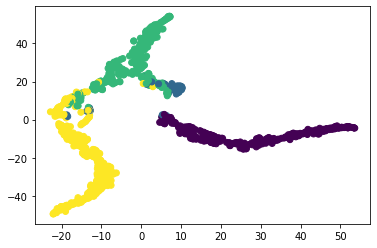

Epoch: 199, test_stats: 92.1000,test_stats: 0.1266 tensor([0.0154, 0.0341, 0.0348, 0.0423])
minimum achieved 0.07651952


In [35]:
criterion = torch.nn.CrossEntropyLoss()
stats_FIERCE = torch.zeros(0,200,3)
### Model
net_FIERCE = Net(dim=100,embedding = 100,FIERCE_parameter = 1)
train_acc_list,MSE_list,Entropy_list = experiment(net_FIERCE,train_loader,test_loader,epochs= 200,lr = 0.0001)  
cat_elements = torch.stack([train_acc_list,MSE_list,Entropy_list], dim = 1).unsqueeze(0)
stats_FIERCE = torch.cat([stats_FIERCE, cat_elements], dim = 0)

Epoch:   0, train_loss: 262.58039, train_acc: 0.3632, train_mse: 0.3022, test_mse: 0.2875 tensor([0.1109, 0.0311, 0.0763, 0.0692])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:   1, train_loss: 232.19094, train_acc: 0.6331, train_mse: 0.2455, test_mse: 0.1839 tensor([0.0565, 0.0275, 0.0463, 0.0536])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:   2, train_loss: 166.86860, train_acc: 0.7704, train_mse: 0.1371, test_mse: 0.1085 tensor([0.0062, 0.0335, 0.0337, 0.0352])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:   3, train_loss: 122.02966, train_acc: 0.8774, train_mse: 0.1137, test_mse: 0.0991 tensor([0.0117, 0.0337, 0.0305, 0.0233])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:   4, train_loss: 100.89477, train_acc: 0.8947, train_mse: 0.1036, test_mse: 0.0938 tensor([0.0138, 0.0315, 0.0267, 0.0218])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:   5, train_loss: 83.55676, train_acc: 0.8925, train_mse: 0.0987, test_mse: 0.0941 tensor([0.0129, 0.0312, 0.0263, 0.0238])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:   6, train_loss: 70.44034, train_acc: 0.8943, train_mse: 0.1055, test_mse: 0.0954 tensor([0.0149, 0.0293, 0.0264, 0.0247])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:   7, train_loss: 60.99326, train_acc: 0.8943, train_mse: 0.1151, test_mse: 0.1105 tensor([0.0134, 0.0298, 0.0299, 0.0373])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:   8, train_loss: 54.57134, train_acc: 0.9054, train_mse: 0.1151, test_mse: 0.1157 tensor([0.0145, 0.0291, 0.0311, 0.0410])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:   9, train_loss: 49.49853, train_acc: 0.9057, train_mse: 0.1232, test_mse: 0.1218 tensor([0.0154, 0.0295, 0.0340, 0.0429])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  10, train_loss: 45.37701, train_acc: 0.9042, train_mse: 0.1305, test_mse: 0.1244 tensor([0.0159, 0.0280, 0.0341, 0.0464])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  11, train_loss: 42.25024, train_acc: 0.9124, train_mse: 0.1331, test_mse: 0.1244 tensor([0.0170, 0.0275, 0.0374, 0.0425])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  12, train_loss: 39.97239, train_acc: 0.9190, train_mse: 0.1373, test_mse: 0.1332 tensor([0.0161, 0.0280, 0.0383, 0.0508])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  13, train_loss: 37.99414, train_acc: 0.9285, train_mse: 0.1387, test_mse: 0.1352 tensor([0.0165, 0.0284, 0.0417, 0.0486])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  14, train_loss: 36.13914, train_acc: 0.9308, train_mse: 0.1443, test_mse: 0.1422 tensor([0.0181, 0.0265, 0.0395, 0.0581])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  15, train_loss: 34.79631, train_acc: 0.9350, train_mse: 0.1461, test_mse: 0.1452 tensor([0.0177, 0.0274, 0.0434, 0.0566])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  16, train_loss: 33.12618, train_acc: 0.9376, train_mse: 0.1490, test_mse: 0.1488 tensor([0.0178, 0.0268, 0.0435, 0.0607])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  17, train_loss: 33.52496, train_acc: 0.9367, train_mse: 0.1510, test_mse: 0.1443 tensor([0.0189, 0.0260, 0.0465, 0.0529])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  18, train_loss: 31.12406, train_acc: 0.9416, train_mse: 0.1530, test_mse: 0.1482 tensor([0.0181, 0.0257, 0.0456, 0.0588])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  19, train_loss: 30.13982, train_acc: 0.9398, train_mse: 0.1552, test_mse: 0.1525 tensor([0.0184, 0.0255, 0.0470, 0.0615])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  20, train_loss: 29.69942, train_acc: 0.9437, train_mse: 0.1551, test_mse: 0.1512 tensor([0.0186, 0.0247, 0.0474, 0.0604])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  21, train_loss: 28.47521, train_acc: 0.9465, train_mse: 0.1559, test_mse: 0.1512 tensor([0.0190, 0.0241, 0.0481, 0.0600])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  22, train_loss: 27.46587, train_acc: 0.9485, train_mse: 0.1588, test_mse: 0.1516 tensor([0.0193, 0.0234, 0.0479, 0.0611])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  23, train_loss: 26.64291, train_acc: 0.9509, train_mse: 0.1583, test_mse: 0.1526 tensor([0.0197, 0.0228, 0.0489, 0.0612])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  24, train_loss: 25.95617, train_acc: 0.9504, train_mse: 0.1598, test_mse: 0.1520 tensor([0.0186, 0.0229, 0.0493, 0.0612])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  25, train_loss: 24.94614, train_acc: 0.9527, train_mse: 0.1604, test_mse: 0.1546 tensor([0.0200, 0.0218, 0.0493, 0.0634])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  26, train_loss: 24.15027, train_acc: 0.9561, train_mse: 0.1593, test_mse: 0.1537 tensor([0.0195, 0.0215, 0.0510, 0.0617])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  27, train_loss: 23.75842, train_acc: 0.9516, train_mse: 0.1622, test_mse: 0.1519 tensor([0.0208, 0.0206, 0.0501, 0.0604])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  28, train_loss: 24.08482, train_acc: 0.9509, train_mse: 0.1609, test_mse: 0.1523 tensor([0.0202, 0.0206, 0.0529, 0.0586])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  29, train_loss: 24.19885, train_acc: 0.9541, train_mse: 0.1608, test_mse: 0.1604 tensor([0.0202, 0.0208, 0.0518, 0.0676])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  30, train_loss: 21.65770, train_acc: 0.9589, train_mse: 0.1621, test_mse: 0.1526 tensor([0.0202, 0.0202, 0.0522, 0.0599])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  31, train_loss: 21.80043, train_acc: 0.9609, train_mse: 0.1632, test_mse: 0.1621 tensor([0.0204, 0.0206, 0.0526, 0.0686])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  32, train_loss: 21.07899, train_acc: 0.9611, train_mse: 0.1630, test_mse: 0.1596 tensor([0.0210, 0.0199, 0.0509, 0.0678])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  33, train_loss: 20.35323, train_acc: 0.9630, train_mse: 0.1645, test_mse: 0.1567 tensor([0.0212, 0.0198, 0.0532, 0.0625])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  34, train_loss: 20.04846, train_acc: 0.9650, train_mse: 0.1650, test_mse: 0.1624 tensor([0.0206, 0.0204, 0.0545, 0.0669])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  35, train_loss: 19.66127, train_acc: 0.9647, train_mse: 0.1664, test_mse: 0.1588 tensor([0.0206, 0.0198, 0.0541, 0.0643])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  36, train_loss: 19.45227, train_acc: 0.9656, train_mse: 0.1657, test_mse: 0.1632 tensor([0.0212, 0.0198, 0.0524, 0.0698])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  37, train_loss: 19.18682, train_acc: 0.9620, train_mse: 0.1670, test_mse: 0.1616 tensor([0.0205, 0.0200, 0.0551, 0.0661])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  38, train_loss: 18.74545, train_acc: 0.9674, train_mse: 0.1672, test_mse: 0.1621 tensor([0.0209, 0.0197, 0.0534, 0.0681])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  39, train_loss: 18.87876, train_acc: 0.9625, train_mse: 0.1674, test_mse: 0.1654 tensor([0.0210, 0.0198, 0.0533, 0.0712])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  40, train_loss: 18.57297, train_acc: 0.9628, train_mse: 0.1678, test_mse: 0.1609 tensor([0.0217, 0.0196, 0.0530, 0.0667])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  41, train_loss: 18.56957, train_acc: 0.9656, train_mse: 0.1682, test_mse: 0.1635 tensor([0.0214, 0.0198, 0.0548, 0.0675])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  42, train_loss: 17.58125, train_acc: 0.9673, train_mse: 0.1692, test_mse: 0.1614 tensor([0.0222, 0.0195, 0.0540, 0.0658])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  43, train_loss: 17.65897, train_acc: 0.9673, train_mse: 0.1712, test_mse: 0.1633 tensor([0.0218, 0.0197, 0.0543, 0.0676])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  44, train_loss: 17.22807, train_acc: 0.9694, train_mse: 0.1704, test_mse: 0.1616 tensor([0.0216, 0.0196, 0.0551, 0.0653])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  45, train_loss: 17.03056, train_acc: 0.9703, train_mse: 0.1704, test_mse: 0.1698 tensor([0.0220, 0.0198, 0.0533, 0.0748])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  46, train_loss: 17.88080, train_acc: 0.9683, train_mse: 0.1693, test_mse: 0.1640 tensor([0.0218, 0.0197, 0.0546, 0.0680])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  47, train_loss: 16.99971, train_acc: 0.9699, train_mse: 0.1723, test_mse: 0.1633 tensor([0.0218, 0.0197, 0.0551, 0.0667])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  48, train_loss: 16.57135, train_acc: 0.9691, train_mse: 0.1726, test_mse: 0.1698 tensor([0.0225, 0.0199, 0.0540, 0.0734])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  49, train_loss: 17.15631, train_acc: 0.9657, train_mse: 0.1724, test_mse: 0.1636 tensor([0.0217, 0.0198, 0.0552, 0.0669])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  50, train_loss: 16.76263, train_acc: 0.9688, train_mse: 0.1704, test_mse: 0.1703 tensor([0.0217, 0.0200, 0.0549, 0.0736])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  51, train_loss: 16.01731, train_acc: 0.9680, train_mse: 0.1714, test_mse: 0.1668 tensor([0.0226, 0.0201, 0.0563, 0.0678])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  52, train_loss: 16.47533, train_acc: 0.9693, train_mse: 0.1738, test_mse: 0.1676 tensor([0.0220, 0.0201, 0.0565, 0.0690])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  53, train_loss: 15.70042, train_acc: 0.9701, train_mse: 0.1742, test_mse: 0.1693 tensor([0.0220, 0.0201, 0.0562, 0.0710])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  54, train_loss: 15.76105, train_acc: 0.9676, train_mse: 0.1750, test_mse: 0.1711 tensor([0.0216, 0.0202, 0.0564, 0.0729])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  55, train_loss: 16.23958, train_acc: 0.9688, train_mse: 0.1728, test_mse: 0.1665 tensor([0.0221, 0.0200, 0.0565, 0.0679])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  56, train_loss: 15.59630, train_acc: 0.9717, train_mse: 0.1730, test_mse: 0.1693 tensor([0.0219, 0.0201, 0.0563, 0.0710])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  57, train_loss: 15.77380, train_acc: 0.9700, train_mse: 0.1746, test_mse: 0.1698 tensor([0.0231, 0.0202, 0.0556, 0.0709])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  58, train_loss: 15.27811, train_acc: 0.9716, train_mse: 0.1747, test_mse: 0.1668 tensor([0.0226, 0.0201, 0.0565, 0.0676])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  59, train_loss: 14.96749, train_acc: 0.9727, train_mse: 0.1744, test_mse: 0.1694 tensor([0.0220, 0.0201, 0.0556, 0.0717])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  60, train_loss: 14.83550, train_acc: 0.9733, train_mse: 0.1763, test_mse: 0.1673 tensor([0.0221, 0.0202, 0.0568, 0.0682])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  61, train_loss: 14.76380, train_acc: 0.9736, train_mse: 0.1752, test_mse: 0.1685 tensor([0.0218, 0.0203, 0.0583, 0.0680])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  62, train_loss: 14.73874, train_acc: 0.9728, train_mse: 0.1774, test_mse: 0.1690 tensor([0.0232, 0.0203, 0.0562, 0.0693])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  63, train_loss: 14.83141, train_acc: 0.9728, train_mse: 0.1770, test_mse: 0.1672 tensor([0.0227, 0.0202, 0.0565, 0.0678])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  64, train_loss: 14.91202, train_acc: 0.9719, train_mse: 0.1764, test_mse: 0.1682 tensor([0.0222, 0.0204, 0.0575, 0.0682])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  65, train_loss: 14.60866, train_acc: 0.9731, train_mse: 0.1769, test_mse: 0.1687 tensor([0.0221, 0.0204, 0.0584, 0.0678])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  66, train_loss: 14.25071, train_acc: 0.9706, train_mse: 0.1758, test_mse: 0.1671 tensor([0.0229, 0.0203, 0.0574, 0.0664])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  67, train_loss: 14.57066, train_acc: 0.9694, train_mse: 0.1756, test_mse: 0.1659 tensor([0.0226, 0.0202, 0.0601, 0.0630])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  68, train_loss: 18.09915, train_acc: 0.9647, train_mse: 0.1775, test_mse: 0.1716 tensor([0.0226, 0.0206, 0.0566, 0.0718])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  69, train_loss: 13.87277, train_acc: 0.9740, train_mse: 0.1776, test_mse: 0.1698 tensor([0.0223, 0.0205, 0.0566, 0.0704])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  70, train_loss: 14.00231, train_acc: 0.9745, train_mse: 0.1777, test_mse: 0.1684 tensor([0.0225, 0.0205, 0.0578, 0.0677])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  71, train_loss: 13.73308, train_acc: 0.9759, train_mse: 0.1796, test_mse: 0.1747 tensor([0.0220, 0.0207, 0.0575, 0.0745])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  72, train_loss: 13.66761, train_acc: 0.9738, train_mse: 0.1777, test_mse: 0.1729 tensor([0.0224, 0.0207, 0.0575, 0.0723])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  73, train_loss: 13.67707, train_acc: 0.9748, train_mse: 0.1788, test_mse: 0.1699 tensor([0.0228, 0.0207, 0.0584, 0.0680])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  74, train_loss: 13.45749, train_acc: 0.9757, train_mse: 0.1777, test_mse: 0.1711 tensor([0.0228, 0.0207, 0.0564, 0.0712])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  75, train_loss: 13.65835, train_acc: 0.9750, train_mse: 0.1790, test_mse: 0.1736 tensor([0.0228, 0.0208, 0.0567, 0.0733])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  76, train_loss: 13.41444, train_acc: 0.9740, train_mse: 0.1793, test_mse: 0.1717 tensor([0.0227, 0.0209, 0.0581, 0.0701])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  77, train_loss: 13.14515, train_acc: 0.9767, train_mse: 0.1808, test_mse: 0.1737 tensor([0.0224, 0.0209, 0.0576, 0.0728])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  78, train_loss: 13.13396, train_acc: 0.9747, train_mse: 0.1779, test_mse: 0.1717 tensor([0.0224, 0.0209, 0.0588, 0.0695])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  79, train_loss: 13.75615, train_acc: 0.9752, train_mse: 0.1802, test_mse: 0.1725 tensor([0.0226, 0.0209, 0.0580, 0.0710])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  80, train_loss: 12.91091, train_acc: 0.9752, train_mse: 0.1795, test_mse: 0.1727 tensor([0.0222, 0.0210, 0.0589, 0.0706])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  81, train_loss: 13.22383, train_acc: 0.9762, train_mse: 0.1798, test_mse: 0.1739 tensor([0.0227, 0.0210, 0.0576, 0.0725])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  82, train_loss: 12.81875, train_acc: 0.9758, train_mse: 0.1798, test_mse: 0.1731 tensor([0.0226, 0.0211, 0.0598, 0.0696])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  83, train_loss: 12.80504, train_acc: 0.9769, train_mse: 0.1810, test_mse: 0.1734 tensor([0.0227, 0.0211, 0.0588, 0.0708])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  84, train_loss: 12.71182, train_acc: 0.9762, train_mse: 0.1811, test_mse: 0.1740 tensor([0.0229, 0.0210, 0.0574, 0.0727])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  85, train_loss: 12.71400, train_acc: 0.9763, train_mse: 0.1796, test_mse: 0.1741 tensor([0.0224, 0.0212, 0.0593, 0.0712])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  86, train_loss: 12.44017, train_acc: 0.9771, train_mse: 0.1810, test_mse: 0.1722 tensor([0.0228, 0.0212, 0.0593, 0.0689])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  87, train_loss: 12.42807, train_acc: 0.9781, train_mse: 0.1805, test_mse: 0.1741 tensor([0.0229, 0.0212, 0.0585, 0.0716])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  88, train_loss: 12.31624, train_acc: 0.9752, train_mse: 0.1801, test_mse: 0.1721 tensor([0.0234, 0.0213, 0.0600, 0.0675])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  89, train_loss: 12.91947, train_acc: 0.9743, train_mse: 0.1811, test_mse: 0.1728 tensor([0.0236, 0.0213, 0.0601, 0.0678])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  90, train_loss: 12.66060, train_acc: 0.9748, train_mse: 0.1817, test_mse: 0.1731 tensor([0.0228, 0.0213, 0.0595, 0.0695])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  91, train_loss: 11.96081, train_acc: 0.9790, train_mse: 0.1836, test_mse: 0.1738 tensor([0.0226, 0.0214, 0.0604, 0.0693])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  92, train_loss: 12.10731, train_acc: 0.9786, train_mse: 0.1803, test_mse: 0.1739 tensor([0.0230, 0.0214, 0.0601, 0.0694])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  93, train_loss: 11.96940, train_acc: 0.9751, train_mse: 0.1804, test_mse: 0.1776 tensor([0.0231, 0.0214, 0.0582, 0.0748])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  94, train_loss: 13.03298, train_acc: 0.9753, train_mse: 0.1823, test_mse: 0.1756 tensor([0.0227, 0.0214, 0.0599, 0.0716])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  95, train_loss: 11.89011, train_acc: 0.9750, train_mse: 0.1815, test_mse: 0.1740 tensor([0.0232, 0.0215, 0.0600, 0.0694])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  96, train_loss: 11.81577, train_acc: 0.9786, train_mse: 0.1818, test_mse: 0.1751 tensor([0.0229, 0.0215, 0.0594, 0.0714])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  97, train_loss: 11.95604, train_acc: 0.9786, train_mse: 0.1821, test_mse: 0.1747 tensor([0.0237, 0.0215, 0.0590, 0.0705])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  98, train_loss: 11.77051, train_acc: 0.9780, train_mse: 0.1824, test_mse: 0.1766 tensor([0.0228, 0.0216, 0.0590, 0.0733])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  99, train_loss: 11.52855, train_acc: 0.9792, train_mse: 0.1843, test_mse: 0.1768 tensor([0.0226, 0.0216, 0.0601, 0.0725])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 100, train_loss: 11.35354, train_acc: 0.9793, train_mse: 0.1847, test_mse: 0.1755 tensor([0.0228, 0.0216, 0.0599, 0.0712])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 101, train_loss: 11.23259, train_acc: 0.9798, train_mse: 0.1826, test_mse: 0.1754 tensor([0.0230, 0.0216, 0.0595, 0.0712])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 102, train_loss: 11.22467, train_acc: 0.9804, train_mse: 0.1820, test_mse: 0.1757 tensor([0.0230, 0.0216, 0.0595, 0.0716])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 103, train_loss: 11.21353, train_acc: 0.9803, train_mse: 0.1832, test_mse: 0.1755 tensor([0.0230, 0.0216, 0.0596, 0.0713])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 104, train_loss: 11.19492, train_acc: 0.9804, train_mse: 0.1816, test_mse: 0.1759 tensor([0.0231, 0.0216, 0.0593, 0.0719])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 105, train_loss: 11.24499, train_acc: 0.9794, train_mse: 0.1847, test_mse: 0.1754 tensor([0.0231, 0.0216, 0.0599, 0.0709])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 106, train_loss: 11.20941, train_acc: 0.9810, train_mse: 0.1852, test_mse: 0.1758 tensor([0.0230, 0.0216, 0.0595, 0.0717])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 107, train_loss: 11.22991, train_acc: 0.9807, train_mse: 0.1825, test_mse: 0.1754 tensor([0.0231, 0.0216, 0.0596, 0.0711])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 108, train_loss: 11.18843, train_acc: 0.9798, train_mse: 0.1847, test_mse: 0.1750 tensor([0.0231, 0.0216, 0.0601, 0.0702])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 109, train_loss: 11.17954, train_acc: 0.9779, train_mse: 0.1825, test_mse: 0.1756 tensor([0.0230, 0.0216, 0.0596, 0.0714])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 110, train_loss: 11.24490, train_acc: 0.9802, train_mse: 0.1833, test_mse: 0.1756 tensor([0.0230, 0.0216, 0.0597, 0.0712])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 111, train_loss: 11.13513, train_acc: 0.9801, train_mse: 0.1842, test_mse: 0.1762 tensor([0.0231, 0.0216, 0.0592, 0.0723])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 112, train_loss: 11.18653, train_acc: 0.9798, train_mse: 0.1825, test_mse: 0.1755 tensor([0.0231, 0.0216, 0.0596, 0.0713])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 113, train_loss: 11.14651, train_acc: 0.9801, train_mse: 0.1826, test_mse: 0.1753 tensor([0.0231, 0.0216, 0.0599, 0.0707])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 114, train_loss: 11.19389, train_acc: 0.9796, train_mse: 0.1835, test_mse: 0.1754 tensor([0.0230, 0.0216, 0.0600, 0.0707])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 115, train_loss: 11.11418, train_acc: 0.9809, train_mse: 0.1826, test_mse: 0.1763 tensor([0.0230, 0.0217, 0.0595, 0.0722])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 116, train_loss: 11.18872, train_acc: 0.9798, train_mse: 0.1864, test_mse: 0.1753 tensor([0.0231, 0.0217, 0.0601, 0.0705])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 117, train_loss: 11.12215, train_acc: 0.9808, train_mse: 0.1844, test_mse: 0.1754 tensor([0.0231, 0.0217, 0.0601, 0.0706])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 118, train_loss: 11.13011, train_acc: 0.9802, train_mse: 0.1841, test_mse: 0.1758 tensor([0.0231, 0.0216, 0.0595, 0.0716])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 119, train_loss: 11.12142, train_acc: 0.9796, train_mse: 0.1845, test_mse: 0.1754 tensor([0.0230, 0.0217, 0.0601, 0.0706])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 120, train_loss: 11.13762, train_acc: 0.9798, train_mse: 0.1834, test_mse: 0.1754 tensor([0.0231, 0.0217, 0.0601, 0.0706])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 121, train_loss: 11.07907, train_acc: 0.9811, train_mse: 0.1839, test_mse: 0.1759 tensor([0.0230, 0.0217, 0.0597, 0.0715])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 122, train_loss: 11.08956, train_acc: 0.9798, train_mse: 0.1825, test_mse: 0.1756 tensor([0.0230, 0.0217, 0.0599, 0.0709])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 123, train_loss: 11.07837, train_acc: 0.9802, train_mse: 0.1850, test_mse: 0.1758 tensor([0.0231, 0.0217, 0.0597, 0.0713])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 124, train_loss: 11.14283, train_acc: 0.9803, train_mse: 0.1829, test_mse: 0.1759 tensor([0.0231, 0.0217, 0.0597, 0.0714])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 125, train_loss: 11.05552, train_acc: 0.9800, train_mse: 0.1830, test_mse: 0.1757 tensor([0.0231, 0.0217, 0.0602, 0.0708])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 126, train_loss: 11.04900, train_acc: 0.9801, train_mse: 0.1840, test_mse: 0.1762 tensor([0.0230, 0.0217, 0.0596, 0.0719])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 127, train_loss: 11.09342, train_acc: 0.9801, train_mse: 0.1851, test_mse: 0.1758 tensor([0.0231, 0.0217, 0.0599, 0.0711])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 128, train_loss: 11.03840, train_acc: 0.9801, train_mse: 0.1849, test_mse: 0.1755 tensor([0.0231, 0.0217, 0.0601, 0.0707])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 129, train_loss: 11.04562, train_acc: 0.9806, train_mse: 0.1861, test_mse: 0.1755 tensor([0.0231, 0.0217, 0.0602, 0.0705])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 130, train_loss: 11.01119, train_acc: 0.9811, train_mse: 0.1830, test_mse: 0.1759 tensor([0.0231, 0.0217, 0.0599, 0.0712])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 131, train_loss: 11.02522, train_acc: 0.9807, train_mse: 0.1849, test_mse: 0.1761 tensor([0.0231, 0.0217, 0.0597, 0.0716])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 132, train_loss: 11.01063, train_acc: 0.9799, train_mse: 0.1837, test_mse: 0.1757 tensor([0.0231, 0.0217, 0.0603, 0.0707])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 133, train_loss: 11.12561, train_acc: 0.9811, train_mse: 0.1833, test_mse: 0.1757 tensor([0.0231, 0.0217, 0.0603, 0.0706])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 134, train_loss: 11.06750, train_acc: 0.9807, train_mse: 0.1839, test_mse: 0.1762 tensor([0.0231, 0.0217, 0.0598, 0.0716])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 135, train_loss: 10.98657, train_acc: 0.9799, train_mse: 0.1836, test_mse: 0.1756 tensor([0.0231, 0.0217, 0.0604, 0.0705])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 136, train_loss: 10.99813, train_acc: 0.9805, train_mse: 0.1837, test_mse: 0.1761 tensor([0.0230, 0.0217, 0.0598, 0.0716])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 137, train_loss: 10.99041, train_acc: 0.9802, train_mse: 0.1845, test_mse: 0.1755 tensor([0.0231, 0.0217, 0.0606, 0.0700])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 138, train_loss: 11.00737, train_acc: 0.9802, train_mse: 0.1832, test_mse: 0.1755 tensor([0.0231, 0.0217, 0.0606, 0.0701])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 139, train_loss: 10.98747, train_acc: 0.9804, train_mse: 0.1830, test_mse: 0.1766 tensor([0.0230, 0.0217, 0.0596, 0.0723])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 140, train_loss: 10.98698, train_acc: 0.9811, train_mse: 0.1843, test_mse: 0.1762 tensor([0.0231, 0.0217, 0.0597, 0.0718])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 141, train_loss: 10.99610, train_acc: 0.9808, train_mse: 0.1846, test_mse: 0.1764 tensor([0.0231, 0.0217, 0.0595, 0.0721])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 142, train_loss: 10.94657, train_acc: 0.9803, train_mse: 0.1853, test_mse: 0.1761 tensor([0.0232, 0.0217, 0.0599, 0.0713])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 143, train_loss: 10.92599, train_acc: 0.9804, train_mse: 0.1827, test_mse: 0.1760 tensor([0.0231, 0.0217, 0.0601, 0.0710])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 144, train_loss: 10.93501, train_acc: 0.9809, train_mse: 0.1842, test_mse: 0.1763 tensor([0.0231, 0.0217, 0.0597, 0.0717])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 145, train_loss: 10.95624, train_acc: 0.9806, train_mse: 0.1821, test_mse: 0.1765 tensor([0.0231, 0.0217, 0.0597, 0.0720])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 146, train_loss: 10.92610, train_acc: 0.9802, train_mse: 0.1847, test_mse: 0.1764 tensor([0.0230, 0.0217, 0.0600, 0.0717])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 147, train_loss: 10.90633, train_acc: 0.9808, train_mse: 0.1848, test_mse: 0.1763 tensor([0.0231, 0.0217, 0.0596, 0.0718])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 148, train_loss: 10.87931, train_acc: 0.9783, train_mse: 0.1840, test_mse: 0.1762 tensor([0.0231, 0.0217, 0.0599, 0.0714])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 149, train_loss: 11.01068, train_acc: 0.9801, train_mse: 0.1822, test_mse: 0.1765 tensor([0.0231, 0.0217, 0.0596, 0.0720])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 150, train_loss: 10.87841, train_acc: 0.9804, train_mse: 0.1855, test_mse: 0.1762 tensor([0.0231, 0.0217, 0.0598, 0.0715])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 151, train_loss: 10.87152, train_acc: 0.9801, train_mse: 0.1828, test_mse: 0.1761 tensor([0.0231, 0.0217, 0.0600, 0.0713])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 152, train_loss: 10.86611, train_acc: 0.9809, train_mse: 0.1846, test_mse: 0.1768 tensor([0.0230, 0.0217, 0.0597, 0.0724])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 153, train_loss: 10.87780, train_acc: 0.9802, train_mse: 0.1857, test_mse: 0.1759 tensor([0.0231, 0.0217, 0.0605, 0.0706])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 154, train_loss: 10.87237, train_acc: 0.9808, train_mse: 0.1857, test_mse: 0.1770 tensor([0.0232, 0.0217, 0.0594, 0.0726])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 155, train_loss: 10.92225, train_acc: 0.9803, train_mse: 0.1851, test_mse: 0.1765 tensor([0.0231, 0.0218, 0.0599, 0.0717])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 156, train_loss: 10.84005, train_acc: 0.9807, train_mse: 0.1837, test_mse: 0.1764 tensor([0.0231, 0.0218, 0.0598, 0.0717])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 157, train_loss: 10.83999, train_acc: 0.9809, train_mse: 0.1839, test_mse: 0.1765 tensor([0.0231, 0.0218, 0.0598, 0.0719])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 158, train_loss: 10.80850, train_acc: 0.9807, train_mse: 0.1836, test_mse: 0.1762 tensor([0.0232, 0.0218, 0.0600, 0.0713])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 159, train_loss: 10.80010, train_acc: 0.9807, train_mse: 0.1850, test_mse: 0.1761 tensor([0.0231, 0.0218, 0.0605, 0.0707])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 160, train_loss: 10.77998, train_acc: 0.9805, train_mse: 0.1839, test_mse: 0.1765 tensor([0.0232, 0.0218, 0.0599, 0.0716])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 161, train_loss: 10.77863, train_acc: 0.9808, train_mse: 0.1853, test_mse: 0.1765 tensor([0.0231, 0.0218, 0.0599, 0.0717])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 162, train_loss: 10.80234, train_acc: 0.9804, train_mse: 0.1873, test_mse: 0.1763 tensor([0.0232, 0.0218, 0.0601, 0.0713])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 163, train_loss: 10.83619, train_acc: 0.9815, train_mse: 0.1843, test_mse: 0.1767 tensor([0.0232, 0.0218, 0.0598, 0.0718])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 164, train_loss: 10.81144, train_acc: 0.9816, train_mse: 0.1836, test_mse: 0.1769 tensor([0.0231, 0.0218, 0.0597, 0.0724])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 165, train_loss: 10.77423, train_acc: 0.9782, train_mse: 0.1862, test_mse: 0.1765 tensor([0.0232, 0.0218, 0.0599, 0.0717])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 166, train_loss: 10.74136, train_acc: 0.9816, train_mse: 0.1857, test_mse: 0.1763 tensor([0.0231, 0.0218, 0.0603, 0.0711])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 167, train_loss: 10.72489, train_acc: 0.9812, train_mse: 0.1837, test_mse: 0.1768 tensor([0.0231, 0.0218, 0.0598, 0.0720])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 168, train_loss: 10.73195, train_acc: 0.9784, train_mse: 0.1848, test_mse: 0.1770 tensor([0.0232, 0.0218, 0.0596, 0.0725])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 169, train_loss: 11.13091, train_acc: 0.9794, train_mse: 0.1855, test_mse: 0.1766 tensor([0.0231, 0.0218, 0.0602, 0.0714])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 170, train_loss: 10.71906, train_acc: 0.9805, train_mse: 0.1843, test_mse: 0.1764 tensor([0.0231, 0.0218, 0.0604, 0.0711])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 171, train_loss: 10.70111, train_acc: 0.9809, train_mse: 0.1837, test_mse: 0.1762 tensor([0.0231, 0.0218, 0.0605, 0.0707])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 172, train_loss: 10.72932, train_acc: 0.9813, train_mse: 0.1847, test_mse: 0.1767 tensor([0.0232, 0.0218, 0.0601, 0.0717])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 173, train_loss: 10.72323, train_acc: 0.9814, train_mse: 0.1860, test_mse: 0.1767 tensor([0.0231, 0.0218, 0.0601, 0.0718])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 174, train_loss: 10.70338, train_acc: 0.9807, train_mse: 0.1841, test_mse: 0.1768 tensor([0.0231, 0.0218, 0.0601, 0.0717])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 175, train_loss: 10.69793, train_acc: 0.9791, train_mse: 0.1830, test_mse: 0.1770 tensor([0.0231, 0.0218, 0.0600, 0.0721])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 176, train_loss: 10.76076, train_acc: 0.9808, train_mse: 0.1838, test_mse: 0.1771 tensor([0.0232, 0.0218, 0.0598, 0.0723])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 177, train_loss: 10.75785, train_acc: 0.9780, train_mse: 0.1858, test_mse: 0.1764 tensor([0.0232, 0.0218, 0.0606, 0.0707])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 178, train_loss: 10.80812, train_acc: 0.9815, train_mse: 0.1847, test_mse: 0.1768 tensor([0.0231, 0.0218, 0.0602, 0.0716])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 179, train_loss: 10.69504, train_acc: 0.9816, train_mse: 0.1846, test_mse: 0.1770 tensor([0.0232, 0.0218, 0.0600, 0.0720])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 180, train_loss: 10.66607, train_acc: 0.9809, train_mse: 0.1834, test_mse: 0.1766 tensor([0.0232, 0.0218, 0.0601, 0.0715])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 181, train_loss: 10.67549, train_acc: 0.9751, train_mse: 0.1871, test_mse: 0.1769 tensor([0.0232, 0.0218, 0.0600, 0.0719])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 182, train_loss: 10.94888, train_acc: 0.9779, train_mse: 0.1839, test_mse: 0.1769 tensor([0.0233, 0.0218, 0.0594, 0.0724])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 183, train_loss: 10.89270, train_acc: 0.9777, train_mse: 0.1865, test_mse: 0.1763 tensor([0.0231, 0.0218, 0.0606, 0.0708])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 184, train_loss: 10.70804, train_acc: 0.9813, train_mse: 0.1853, test_mse: 0.1761 tensor([0.0232, 0.0217, 0.0600, 0.0713])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 185, train_loss: 10.65232, train_acc: 0.9815, train_mse: 0.1867, test_mse: 0.1768 tensor([0.0231, 0.0217, 0.0598, 0.0721])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 186, train_loss: 10.60213, train_acc: 0.9784, train_mse: 0.1837, test_mse: 0.1764 tensor([0.0232, 0.0217, 0.0603, 0.0712])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 187, train_loss: 10.61522, train_acc: 0.9820, train_mse: 0.1839, test_mse: 0.1769 tensor([0.0232, 0.0218, 0.0597, 0.0722])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 188, train_loss: 10.64904, train_acc: 0.9808, train_mse: 0.1851, test_mse: 0.1767 tensor([0.0232, 0.0218, 0.0600, 0.0717])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 189, train_loss: 10.57877, train_acc: 0.9809, train_mse: 0.1854, test_mse: 0.1765 tensor([0.0231, 0.0218, 0.0607, 0.0709])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 190, train_loss: 10.63817, train_acc: 0.9817, train_mse: 0.1836, test_mse: 0.1768 tensor([0.0230, 0.0218, 0.0604, 0.0715])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 191, train_loss: 10.57990, train_acc: 0.9810, train_mse: 0.1836, test_mse: 0.1769 tensor([0.0232, 0.0218, 0.0600, 0.0720])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 192, train_loss: 10.59162, train_acc: 0.9813, train_mse: 0.1847, test_mse: 0.1765 tensor([0.0232, 0.0218, 0.0603, 0.0711])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 193, train_loss: 10.56936, train_acc: 0.9806, train_mse: 0.1842, test_mse: 0.1765 tensor([0.0231, 0.0218, 0.0606, 0.0710])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 194, train_loss: 10.56208, train_acc: 0.9813, train_mse: 0.1837, test_mse: 0.1771 tensor([0.0232, 0.0218, 0.0599, 0.0722])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 195, train_loss: 10.54004, train_acc: 0.9811, train_mse: 0.1841, test_mse: 0.1767 tensor([0.0231, 0.0218, 0.0605, 0.0712])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 196, train_loss: 10.58740, train_acc: 0.9793, train_mse: 0.1851, test_mse: 0.1768 tensor([0.0232, 0.0218, 0.0601, 0.0717])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 197, train_loss: 10.58596, train_acc: 0.9810, train_mse: 0.1860, test_mse: 0.1765 tensor([0.0234, 0.0218, 0.0603, 0.0711])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 198, train_loss: 10.56241, train_acc: 0.9805, train_mse: 0.1861, test_mse: 0.1767 tensor([0.0232, 0.0219, 0.0607, 0.0710])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 199, train_loss: 10.52081, train_acc: 0.9811, train_mse: 0.1847, test_mse: 0.1772 tensor([0.0232, 0.0219, 0.0601, 0.0721])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


final entropy:  199773.39210002634


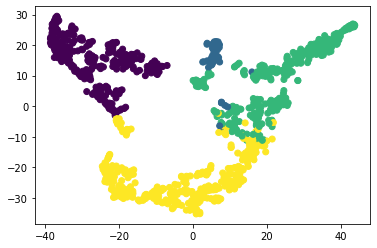

Epoch: 199, test_stats: 98.2000,test_stats: 0.1883 tensor([0.0272, 0.0224, 0.0674, 0.0712])
minimum achieved 0.09870089


In [32]:
criterion = torch.nn.CrossEntropyLoss()
stats_CE = torch.zeros(0,200,3)
### Model
net_CE = Net(dim=100,embedding = 100,FIERCE_parameter = 0)
train_acc_list,MSE_list,Entropy_list = experiment(net_CE,train_loader,test_loader,epochs= 200,lr = 0.0001)  
cat_elements = torch.stack([train_acc_list,MSE_list,Entropy_list], dim = 1).unsqueeze(0)
stats_CE = torch.cat([stats_CE, cat_elements], dim = 0)

Epoch:   0, train_loss: 265.90573, train_acc: 0.4948, train_mse: 0.2996, test_mse: 0.2833 tensor([0.1121, 0.0290, 0.0714, 0.0708])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:   1, train_loss: 250.38565, train_acc: 0.6648, train_mse: 0.2430, test_mse: 0.1935 tensor([0.0602, 0.0267, 0.0499, 0.0567])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:   2, train_loss: 226.38298, train_acc: 0.8853, train_mse: 0.1437, test_mse: 0.1023 tensor([0.0119, 0.0239, 0.0343, 0.0321])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:   3, train_loss: 214.31727, train_acc: 0.8848, train_mse: 0.0936, test_mse: 0.0757 tensor([0.0114, 0.0237, 0.0259, 0.0148])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:   4, train_loss: 207.62723, train_acc: 0.8927, train_mse: 0.0750, test_mse: 0.0654 tensor([0.0103, 0.0234, 0.0235, 0.0082])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:   5, train_loss: 204.35646, train_acc: 0.8978, train_mse: 0.0687, test_mse: 0.0690 tensor([0.0095, 0.0235, 0.0254, 0.0106])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:   6, train_loss: 202.81588, train_acc: 0.9006, train_mse: 0.0690, test_mse: 0.0636 tensor([0.0098, 0.0225, 0.0230, 0.0082])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:   7, train_loss: 201.74860, train_acc: 0.9042, train_mse: 0.0661, test_mse: 0.0643 tensor([0.0097, 0.0220, 0.0232, 0.0094])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:   8, train_loss: 200.83266, train_acc: 0.9015, train_mse: 0.0668, test_mse: 0.0601 tensor([0.0099, 0.0214, 0.0204, 0.0084])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:   9, train_loss: 199.79549, train_acc: 0.9089, train_mse: 0.0643, test_mse: 0.0597 tensor([0.0095, 0.0200, 0.0207, 0.0095])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  10, train_loss: 198.83012, train_acc: 0.9216, train_mse: 0.0605, test_mse: 0.0574 tensor([0.0100, 0.0183, 0.0202, 0.0090])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  11, train_loss: 197.68600, train_acc: 0.9389, train_mse: 0.0577, test_mse: 0.0545 tensor([0.0095, 0.0168, 0.0187, 0.0095])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  12, train_loss: 196.50187, train_acc: 0.9445, train_mse: 0.0551, test_mse: 0.0541 tensor([0.0090, 0.0150, 0.0192, 0.0109])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  13, train_loss: 195.65379, train_acc: 0.9494, train_mse: 0.0530, test_mse: 0.0498 tensor([0.0091, 0.0133, 0.0175, 0.0099])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  14, train_loss: 194.76442, train_acc: 0.9539, train_mse: 0.0500, test_mse: 0.0468 tensor([0.0093, 0.0122, 0.0158, 0.0095])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  15, train_loss: 194.19151, train_acc: 0.9547, train_mse: 0.0488, test_mse: 0.0504 tensor([0.0103, 0.0108, 0.0198, 0.0095])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  16, train_loss: 193.85194, train_acc: 0.9555, train_mse: 0.0482, test_mse: 0.0466 tensor([0.0096, 0.0107, 0.0163, 0.0101])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  17, train_loss: 193.42873, train_acc: 0.9575, train_mse: 0.0476, test_mse: 0.0501 tensor([0.0099, 0.0098, 0.0194, 0.0110])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  18, train_loss: 193.04669, train_acc: 0.9598, train_mse: 0.0480, test_mse: 0.0469 tensor([0.0098, 0.0097, 0.0171, 0.0103])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  19, train_loss: 192.71422, train_acc: 0.9603, train_mse: 0.0482, test_mse: 0.0472 tensor([0.0097, 0.0093, 0.0177, 0.0106])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  20, train_loss: 192.46249, train_acc: 0.9614, train_mse: 0.0485, test_mse: 0.0480 tensor([0.0097, 0.0093, 0.0175, 0.0115])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  21, train_loss: 192.28387, train_acc: 0.9616, train_mse: 0.0485, test_mse: 0.0478 tensor([0.0103, 0.0094, 0.0168, 0.0113])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  22, train_loss: 191.96781, train_acc: 0.9629, train_mse: 0.0495, test_mse: 0.0496 tensor([0.0100, 0.0086, 0.0194, 0.0116])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  23, train_loss: 191.89320, train_acc: 0.9627, train_mse: 0.0499, test_mse: 0.0541 tensor([0.0095, 0.0089, 0.0209, 0.0148])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  24, train_loss: 191.67733, train_acc: 0.9601, train_mse: 0.0508, test_mse: 0.0509 tensor([0.0106, 0.0086, 0.0195, 0.0122])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  25, train_loss: 191.36962, train_acc: 0.9646, train_mse: 0.0510, test_mse: 0.0500 tensor([0.0112, 0.0089, 0.0180, 0.0119])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  26, train_loss: 191.24987, train_acc: 0.9629, train_mse: 0.0519, test_mse: 0.0503 tensor([0.0105, 0.0087, 0.0188, 0.0123])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  27, train_loss: 191.27040, train_acc: 0.9664, train_mse: 0.0525, test_mse: 0.0536 tensor([0.0110, 0.0084, 0.0208, 0.0134])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  28, train_loss: 190.89805, train_acc: 0.9618, train_mse: 0.0529, test_mse: 0.0522 tensor([0.0112, 0.0086, 0.0197, 0.0128])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  29, train_loss: 190.98700, train_acc: 0.9685, train_mse: 0.0535, test_mse: 0.0507 tensor([0.0110, 0.0085, 0.0188, 0.0123])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  30, train_loss: 190.69250, train_acc: 0.9648, train_mse: 0.0541, test_mse: 0.0520 tensor([0.0116, 0.0082, 0.0201, 0.0121])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  31, train_loss: 190.91635, train_acc: 0.9655, train_mse: 0.0550, test_mse: 0.0553 tensor([0.0107, 0.0084, 0.0216, 0.0146])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  32, train_loss: 190.41132, train_acc: 0.9683, train_mse: 0.0546, test_mse: 0.0538 tensor([0.0107, 0.0084, 0.0204, 0.0143])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  33, train_loss: 190.36526, train_acc: 0.9680, train_mse: 0.0553, test_mse: 0.0538 tensor([0.0116, 0.0082, 0.0209, 0.0131])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  34, train_loss: 190.21216, train_acc: 0.9665, train_mse: 0.0558, test_mse: 0.0575 tensor([0.0115, 0.0083, 0.0225, 0.0153])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  35, train_loss: 190.27223, train_acc: 0.9697, train_mse: 0.0564, test_mse: 0.0569 tensor([0.0116, 0.0083, 0.0219, 0.0151])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  36, train_loss: 190.10141, train_acc: 0.9702, train_mse: 0.0567, test_mse: 0.0560 tensor([0.0114, 0.0083, 0.0215, 0.0148])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  37, train_loss: 190.16009, train_acc: 0.9697, train_mse: 0.0578, test_mse: 0.0547 tensor([0.0118, 0.0083, 0.0209, 0.0137])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  38, train_loss: 189.89417, train_acc: 0.9688, train_mse: 0.0575, test_mse: 0.0573 tensor([0.0120, 0.0083, 0.0222, 0.0148])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  39, train_loss: 189.83586, train_acc: 0.9718, train_mse: 0.0577, test_mse: 0.0557 tensor([0.0117, 0.0081, 0.0218, 0.0141])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  40, train_loss: 189.76384, train_acc: 0.9700, train_mse: 0.0581, test_mse: 0.0589 tensor([0.0110, 0.0081, 0.0235, 0.0164])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  41, train_loss: 189.82114, train_acc: 0.9706, train_mse: 0.0581, test_mse: 0.0557 tensor([0.0128, 0.0081, 0.0213, 0.0135])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  42, train_loss: 189.63947, train_acc: 0.9691, train_mse: 0.0582, test_mse: 0.0569 tensor([0.0110, 0.0084, 0.0216, 0.0159])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  43, train_loss: 189.62187, train_acc: 0.9732, train_mse: 0.0587, test_mse: 0.0579 tensor([0.0116, 0.0081, 0.0231, 0.0152])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  44, train_loss: 189.46787, train_acc: 0.9734, train_mse: 0.0588, test_mse: 0.0570 tensor([0.0130, 0.0081, 0.0221, 0.0138])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  45, train_loss: 189.72456, train_acc: 0.9691, train_mse: 0.0599, test_mse: 0.0590 tensor([0.0133, 0.0081, 0.0231, 0.0145])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  46, train_loss: 189.41399, train_acc: 0.9765, train_mse: 0.0589, test_mse: 0.0581 tensor([0.0118, 0.0083, 0.0228, 0.0152])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  47, train_loss: 189.42848, train_acc: 0.9734, train_mse: 0.0595, test_mse: 0.0590 tensor([0.0118, 0.0083, 0.0231, 0.0159])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  48, train_loss: 189.31017, train_acc: 0.9725, train_mse: 0.0598, test_mse: 0.0563 tensor([0.0118, 0.0081, 0.0222, 0.0143])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  49, train_loss: 189.23768, train_acc: 0.9727, train_mse: 0.0605, test_mse: 0.0578 tensor([0.0118, 0.0082, 0.0227, 0.0152])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  50, train_loss: 189.49463, train_acc: 0.9726, train_mse: 0.0603, test_mse: 0.0568 tensor([0.0119, 0.0083, 0.0219, 0.0148])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  51, train_loss: 189.19786, train_acc: 0.9751, train_mse: 0.0599, test_mse: 0.0581 tensor([0.0130, 0.0082, 0.0224, 0.0145])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  52, train_loss: 189.13882, train_acc: 0.9743, train_mse: 0.0610, test_mse: 0.0603 tensor([0.0120, 0.0081, 0.0240, 0.0163])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  53, train_loss: 189.07345, train_acc: 0.9759, train_mse: 0.0602, test_mse: 0.0593 tensor([0.0128, 0.0083, 0.0232, 0.0149])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  54, train_loss: 189.01384, train_acc: 0.9755, train_mse: 0.0614, test_mse: 0.0598 tensor([0.0123, 0.0082, 0.0236, 0.0157])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  55, train_loss: 188.97924, train_acc: 0.9749, train_mse: 0.0612, test_mse: 0.0612 tensor([0.0122, 0.0082, 0.0245, 0.0163])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  56, train_loss: 188.95147, train_acc: 0.9731, train_mse: 0.0622, test_mse: 0.0620 tensor([0.0131, 0.0079, 0.0254, 0.0156])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  57, train_loss: 188.98118, train_acc: 0.9737, train_mse: 0.0614, test_mse: 0.0580 tensor([0.0125, 0.0083, 0.0225, 0.0148])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  58, train_loss: 188.91349, train_acc: 0.9737, train_mse: 0.0615, test_mse: 0.0586 tensor([0.0129, 0.0083, 0.0227, 0.0147])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  59, train_loss: 189.10543, train_acc: 0.9749, train_mse: 0.0612, test_mse: 0.0605 tensor([0.0122, 0.0081, 0.0243, 0.0160])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  60, train_loss: 188.88779, train_acc: 0.9752, train_mse: 0.0623, test_mse: 0.0590 tensor([0.0131, 0.0082, 0.0228, 0.0148])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  61, train_loss: 188.81034, train_acc: 0.9774, train_mse: 0.0619, test_mse: 0.0616 tensor([0.0132, 0.0083, 0.0243, 0.0157])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  62, train_loss: 188.74113, train_acc: 0.9770, train_mse: 0.0620, test_mse: 0.0615 tensor([0.0122, 0.0086, 0.0239, 0.0168])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  63, train_loss: 188.75322, train_acc: 0.9757, train_mse: 0.0631, test_mse: 0.0593 tensor([0.0132, 0.0081, 0.0234, 0.0147])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  64, train_loss: 188.65078, train_acc: 0.9774, train_mse: 0.0626, test_mse: 0.0597 tensor([0.0132, 0.0083, 0.0233, 0.0149])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  65, train_loss: 188.62085, train_acc: 0.9787, train_mse: 0.0626, test_mse: 0.0612 tensor([0.0120, 0.0085, 0.0242, 0.0165])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  66, train_loss: 188.63110, train_acc: 0.9765, train_mse: 0.0636, test_mse: 0.0597 tensor([0.0118, 0.0080, 0.0241, 0.0158])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  67, train_loss: 188.55402, train_acc: 0.9777, train_mse: 0.0624, test_mse: 0.0611 tensor([0.0127, 0.0084, 0.0242, 0.0158])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  68, train_loss: 188.52635, train_acc: 0.9777, train_mse: 0.0630, test_mse: 0.0617 tensor([0.0130, 0.0080, 0.0251, 0.0155])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  69, train_loss: 188.51793, train_acc: 0.9771, train_mse: 0.0631, test_mse: 0.0623 tensor([0.0126, 0.0081, 0.0252, 0.0164])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  70, train_loss: 188.59762, train_acc: 0.9777, train_mse: 0.0635, test_mse: 0.0629 tensor([0.0133, 0.0084, 0.0248, 0.0165])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  71, train_loss: 188.72380, train_acc: 0.9760, train_mse: 0.0631, test_mse: 0.0608 tensor([0.0124, 0.0082, 0.0242, 0.0160])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  72, train_loss: 188.46136, train_acc: 0.9754, train_mse: 0.0638, test_mse: 0.0644 tensor([0.0131, 0.0084, 0.0256, 0.0173])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  73, train_loss: 188.50300, train_acc: 0.9780, train_mse: 0.0636, test_mse: 0.0626 tensor([0.0129, 0.0087, 0.0240, 0.0171])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  74, train_loss: 188.59912, train_acc: 0.9774, train_mse: 0.0650, test_mse: 0.0614 tensor([0.0131, 0.0084, 0.0242, 0.0156])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  75, train_loss: 188.29093, train_acc: 0.9796, train_mse: 0.0640, test_mse: 0.0617 tensor([0.0132, 0.0083, 0.0245, 0.0157])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  76, train_loss: 188.37737, train_acc: 0.9791, train_mse: 0.0641, test_mse: 0.0628 tensor([0.0126, 0.0081, 0.0256, 0.0165])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  77, train_loss: 188.37047, train_acc: 0.9789, train_mse: 0.0639, test_mse: 0.0634 tensor([0.0129, 0.0083, 0.0257, 0.0165])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  78, train_loss: 188.28246, train_acc: 0.9802, train_mse: 0.0641, test_mse: 0.0610 tensor([0.0123, 0.0084, 0.0241, 0.0163])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  79, train_loss: 188.24801, train_acc: 0.9800, train_mse: 0.0639, test_mse: 0.0613 tensor([0.0127, 0.0086, 0.0239, 0.0161])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  80, train_loss: 188.24691, train_acc: 0.9813, train_mse: 0.0648, test_mse: 0.0631 tensor([0.0130, 0.0083, 0.0257, 0.0162])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  81, train_loss: 188.26731, train_acc: 0.9770, train_mse: 0.0649, test_mse: 0.0619 tensor([0.0129, 0.0083, 0.0248, 0.0159])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  82, train_loss: 188.22285, train_acc: 0.9797, train_mse: 0.0644, test_mse: 0.0638 tensor([0.0134, 0.0082, 0.0262, 0.0160])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  83, train_loss: 188.24398, train_acc: 0.9799, train_mse: 0.0646, test_mse: 0.0626 tensor([0.0128, 0.0083, 0.0252, 0.0162])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  84, train_loss: 188.16194, train_acc: 0.9805, train_mse: 0.0645, test_mse: 0.0618 tensor([0.0127, 0.0083, 0.0243, 0.0164])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  85, train_loss: 188.13904, train_acc: 0.9807, train_mse: 0.0652, test_mse: 0.0623 tensor([0.0135, 0.0084, 0.0245, 0.0159])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  86, train_loss: 188.12985, train_acc: 0.9804, train_mse: 0.0649, test_mse: 0.0622 tensor([0.0132, 0.0086, 0.0243, 0.0161])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  87, train_loss: 188.08412, train_acc: 0.9810, train_mse: 0.0654, test_mse: 0.0625 tensor([0.0141, 0.0084, 0.0246, 0.0154])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  88, train_loss: 188.87694, train_acc: 0.9752, train_mse: 0.0657, test_mse: 0.0620 tensor([0.0136, 0.0083, 0.0246, 0.0155])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  89, train_loss: 188.14482, train_acc: 0.9806, train_mse: 0.0648, test_mse: 0.0643 tensor([0.0133, 0.0083, 0.0257, 0.0169])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  90, train_loss: 188.09129, train_acc: 0.9798, train_mse: 0.0650, test_mse: 0.0622 tensor([0.0126, 0.0088, 0.0242, 0.0167])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  91, train_loss: 188.11403, train_acc: 0.9802, train_mse: 0.0649, test_mse: 0.0639 tensor([0.0139, 0.0083, 0.0257, 0.0160])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  92, train_loss: 188.01396, train_acc: 0.9780, train_mse: 0.0656, test_mse: 0.0622 tensor([0.0137, 0.0085, 0.0241, 0.0159])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  93, train_loss: 188.12571, train_acc: 0.9800, train_mse: 0.0646, test_mse: 0.0630 tensor([0.0135, 0.0085, 0.0247, 0.0162])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  94, train_loss: 188.05127, train_acc: 0.9786, train_mse: 0.0661, test_mse: 0.0645 tensor([0.0141, 0.0085, 0.0253, 0.0166])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  95, train_loss: 188.46889, train_acc: 0.9772, train_mse: 0.0649, test_mse: 0.0616 tensor([0.0121, 0.0086, 0.0242, 0.0167])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  96, train_loss: 187.98720, train_acc: 0.9813, train_mse: 0.0645, test_mse: 0.0631 tensor([0.0129, 0.0087, 0.0246, 0.0169])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  97, train_loss: 187.93142, train_acc: 0.9805, train_mse: 0.0657, test_mse: 0.0647 tensor([0.0129, 0.0083, 0.0260, 0.0175])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  98, train_loss: 188.07525, train_acc: 0.9800, train_mse: 0.0657, test_mse: 0.0641 tensor([0.0133, 0.0085, 0.0255, 0.0168])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  99, train_loss: 187.97830, train_acc: 0.9805, train_mse: 0.0661, test_mse: 0.0626 tensor([0.0127, 0.0083, 0.0252, 0.0163])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 100, train_loss: 187.79834, train_acc: 0.9831, train_mse: 0.0659, test_mse: 0.0634 tensor([0.0130, 0.0085, 0.0252, 0.0167])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 101, train_loss: 187.78030, train_acc: 0.9826, train_mse: 0.0659, test_mse: 0.0634 tensor([0.0132, 0.0085, 0.0251, 0.0166])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 102, train_loss: 187.76985, train_acc: 0.9829, train_mse: 0.0661, test_mse: 0.0635 tensor([0.0131, 0.0086, 0.0251, 0.0167])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 103, train_loss: 187.76575, train_acc: 0.9831, train_mse: 0.0656, test_mse: 0.0638 tensor([0.0130, 0.0085, 0.0254, 0.0169])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 104, train_loss: 187.76297, train_acc: 0.9829, train_mse: 0.0657, test_mse: 0.0636 tensor([0.0132, 0.0085, 0.0253, 0.0166])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 105, train_loss: 187.78052, train_acc: 0.9807, train_mse: 0.0656, test_mse: 0.0633 tensor([0.0131, 0.0086, 0.0250, 0.0166])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 106, train_loss: 187.79599, train_acc: 0.9833, train_mse: 0.0658, test_mse: 0.0638 tensor([0.0130, 0.0085, 0.0254, 0.0169])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 107, train_loss: 187.76097, train_acc: 0.9833, train_mse: 0.0655, test_mse: 0.0633 tensor([0.0131, 0.0085, 0.0251, 0.0166])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 108, train_loss: 187.78886, train_acc: 0.9826, train_mse: 0.0660, test_mse: 0.0638 tensor([0.0131, 0.0085, 0.0253, 0.0169])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 109, train_loss: 187.76079, train_acc: 0.9831, train_mse: 0.0654, test_mse: 0.0636 tensor([0.0130, 0.0085, 0.0252, 0.0168])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 110, train_loss: 187.75202, train_acc: 0.9832, train_mse: 0.0664, test_mse: 0.0635 tensor([0.0130, 0.0085, 0.0251, 0.0169])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 111, train_loss: 187.76166, train_acc: 0.9835, train_mse: 0.0657, test_mse: 0.0637 tensor([0.0131, 0.0085, 0.0254, 0.0168])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 112, train_loss: 187.74420, train_acc: 0.9832, train_mse: 0.0660, test_mse: 0.0637 tensor([0.0132, 0.0085, 0.0252, 0.0167])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 113, train_loss: 187.75679, train_acc: 0.9824, train_mse: 0.0660, test_mse: 0.0637 tensor([0.0132, 0.0085, 0.0253, 0.0167])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 114, train_loss: 187.74662, train_acc: 0.9829, train_mse: 0.0658, test_mse: 0.0639 tensor([0.0131, 0.0085, 0.0254, 0.0169])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 115, train_loss: 187.73997, train_acc: 0.9810, train_mse: 0.0657, test_mse: 0.0641 tensor([0.0131, 0.0085, 0.0255, 0.0170])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 116, train_loss: 187.76210, train_acc: 0.9814, train_mse: 0.0656, test_mse: 0.0641 tensor([0.0131, 0.0084, 0.0257, 0.0169])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 117, train_loss: 187.74163, train_acc: 0.9831, train_mse: 0.0659, test_mse: 0.0634 tensor([0.0132, 0.0085, 0.0252, 0.0166])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 118, train_loss: 187.73642, train_acc: 0.9840, train_mse: 0.0658, test_mse: 0.0637 tensor([0.0133, 0.0085, 0.0254, 0.0166])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 119, train_loss: 187.75651, train_acc: 0.9835, train_mse: 0.0658, test_mse: 0.0634 tensor([0.0130, 0.0085, 0.0250, 0.0168])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 120, train_loss: 187.72827, train_acc: 0.9838, train_mse: 0.0660, test_mse: 0.0634 tensor([0.0131, 0.0085, 0.0251, 0.0167])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 121, train_loss: 187.72547, train_acc: 0.9834, train_mse: 0.0660, test_mse: 0.0638 tensor([0.0131, 0.0085, 0.0253, 0.0168])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 122, train_loss: 187.72676, train_acc: 0.9837, train_mse: 0.0659, test_mse: 0.0638 tensor([0.0131, 0.0085, 0.0253, 0.0168])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 123, train_loss: 187.71980, train_acc: 0.9838, train_mse: 0.0658, test_mse: 0.0636 tensor([0.0132, 0.0085, 0.0252, 0.0167])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 124, train_loss: 187.72023, train_acc: 0.9813, train_mse: 0.0658, test_mse: 0.0634 tensor([0.0133, 0.0085, 0.0251, 0.0165])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 125, train_loss: 187.91618, train_acc: 0.9811, train_mse: 0.0662, test_mse: 0.0641 tensor([0.0132, 0.0086, 0.0252, 0.0170])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 126, train_loss: 187.77419, train_acc: 0.9829, train_mse: 0.0663, test_mse: 0.0637 tensor([0.0130, 0.0085, 0.0254, 0.0168])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 127, train_loss: 187.71778, train_acc: 0.9810, train_mse: 0.0662, test_mse: 0.0636 tensor([0.0132, 0.0085, 0.0252, 0.0167])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 128, train_loss: 187.72383, train_acc: 0.9836, train_mse: 0.0668, test_mse: 0.0639 tensor([0.0132, 0.0085, 0.0255, 0.0168])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 129, train_loss: 187.71217, train_acc: 0.9840, train_mse: 0.0657, test_mse: 0.0640 tensor([0.0131, 0.0085, 0.0256, 0.0169])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 130, train_loss: 187.73579, train_acc: 0.9826, train_mse: 0.0663, test_mse: 0.0641 tensor([0.0133, 0.0085, 0.0255, 0.0169])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 131, train_loss: 187.71232, train_acc: 0.9835, train_mse: 0.0665, test_mse: 0.0640 tensor([0.0132, 0.0085, 0.0255, 0.0168])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 132, train_loss: 187.70700, train_acc: 0.9808, train_mse: 0.0660, test_mse: 0.0634 tensor([0.0132, 0.0085, 0.0251, 0.0166])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 133, train_loss: 187.74098, train_acc: 0.9836, train_mse: 0.0657, test_mse: 0.0636 tensor([0.0130, 0.0085, 0.0252, 0.0168])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 134, train_loss: 187.70686, train_acc: 0.9839, train_mse: 0.0664, test_mse: 0.0637 tensor([0.0132, 0.0085, 0.0253, 0.0168])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 135, train_loss: 187.69982, train_acc: 0.9837, train_mse: 0.0663, test_mse: 0.0632 tensor([0.0131, 0.0085, 0.0250, 0.0166])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 136, train_loss: 187.71609, train_acc: 0.9827, train_mse: 0.0658, test_mse: 0.0635 tensor([0.0133, 0.0085, 0.0250, 0.0166])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 137, train_loss: 187.70302, train_acc: 0.9832, train_mse: 0.0666, test_mse: 0.0638 tensor([0.0131, 0.0085, 0.0254, 0.0168])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 138, train_loss: 187.69250, train_acc: 0.9835, train_mse: 0.0665, test_mse: 0.0637 tensor([0.0133, 0.0086, 0.0251, 0.0167])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 139, train_loss: 187.70439, train_acc: 0.9836, train_mse: 0.0661, test_mse: 0.0641 tensor([0.0132, 0.0085, 0.0255, 0.0170])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 140, train_loss: 187.70076, train_acc: 0.9838, train_mse: 0.0659, test_mse: 0.0639 tensor([0.0132, 0.0085, 0.0254, 0.0168])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 141, train_loss: 187.68935, train_acc: 0.9827, train_mse: 0.0662, test_mse: 0.0637 tensor([0.0132, 0.0085, 0.0254, 0.0166])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 142, train_loss: 187.68826, train_acc: 0.9808, train_mse: 0.0657, test_mse: 0.0636 tensor([0.0131, 0.0085, 0.0251, 0.0169])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 143, train_loss: 187.69506, train_acc: 0.9829, train_mse: 0.0666, test_mse: 0.0637 tensor([0.0132, 0.0085, 0.0253, 0.0167])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 144, train_loss: 187.68736, train_acc: 0.9838, train_mse: 0.0659, test_mse: 0.0639 tensor([0.0131, 0.0085, 0.0255, 0.0168])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 145, train_loss: 187.69073, train_acc: 0.9841, train_mse: 0.0661, test_mse: 0.0635 tensor([0.0131, 0.0085, 0.0251, 0.0168])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 146, train_loss: 187.68198, train_acc: 0.9808, train_mse: 0.0660, test_mse: 0.0641 tensor([0.0133, 0.0085, 0.0255, 0.0168])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 147, train_loss: 187.68441, train_acc: 0.9833, train_mse: 0.0664, test_mse: 0.0638 tensor([0.0131, 0.0085, 0.0253, 0.0169])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 148, train_loss: 187.67640, train_acc: 0.9811, train_mse: 0.0664, test_mse: 0.0636 tensor([0.0130, 0.0085, 0.0252, 0.0169])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 149, train_loss: 187.68802, train_acc: 0.9832, train_mse: 0.0663, test_mse: 0.0637 tensor([0.0132, 0.0085, 0.0253, 0.0168])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 150, train_loss: 187.66946, train_acc: 0.9813, train_mse: 0.0661, test_mse: 0.0636 tensor([0.0132, 0.0085, 0.0252, 0.0166])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 151, train_loss: 187.72190, train_acc: 0.9833, train_mse: 0.0660, test_mse: 0.0635 tensor([0.0131, 0.0085, 0.0251, 0.0167])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 152, train_loss: 187.66138, train_acc: 0.9844, train_mse: 0.0663, test_mse: 0.0642 tensor([0.0131, 0.0085, 0.0256, 0.0170])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 153, train_loss: 187.67726, train_acc: 0.9827, train_mse: 0.0661, test_mse: 0.0638 tensor([0.0134, 0.0085, 0.0253, 0.0166])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 154, train_loss: 187.66680, train_acc: 0.9845, train_mse: 0.0662, test_mse: 0.0636 tensor([0.0131, 0.0085, 0.0252, 0.0168])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 155, train_loss: 187.66540, train_acc: 0.9810, train_mse: 0.0664, test_mse: 0.0642 tensor([0.0132, 0.0085, 0.0255, 0.0169])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 156, train_loss: 187.69334, train_acc: 0.9804, train_mse: 0.0665, test_mse: 0.0638 tensor([0.0132, 0.0085, 0.0253, 0.0168])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 157, train_loss: 187.68976, train_acc: 0.9838, train_mse: 0.0659, test_mse: 0.0639 tensor([0.0132, 0.0085, 0.0253, 0.0169])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 158, train_loss: 187.66090, train_acc: 0.9841, train_mse: 0.0657, test_mse: 0.0636 tensor([0.0131, 0.0085, 0.0251, 0.0169])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 159, train_loss: 187.65602, train_acc: 0.9812, train_mse: 0.0667, test_mse: 0.0635 tensor([0.0134, 0.0085, 0.0251, 0.0165])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 160, train_loss: 187.67935, train_acc: 0.9843, train_mse: 0.0663, test_mse: 0.0638 tensor([0.0132, 0.0085, 0.0252, 0.0169])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 161, train_loss: 187.64595, train_acc: 0.9836, train_mse: 0.0660, test_mse: 0.0638 tensor([0.0133, 0.0085, 0.0253, 0.0168])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 162, train_loss: 187.65429, train_acc: 0.9839, train_mse: 0.0663, test_mse: 0.0641 tensor([0.0132, 0.0085, 0.0256, 0.0168])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 163, train_loss: 187.64915, train_acc: 0.9840, train_mse: 0.0661, test_mse: 0.0639 tensor([0.0133, 0.0085, 0.0253, 0.0168])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 164, train_loss: 187.65025, train_acc: 0.9836, train_mse: 0.0666, test_mse: 0.0638 tensor([0.0132, 0.0085, 0.0253, 0.0167])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 165, train_loss: 187.63327, train_acc: 0.9842, train_mse: 0.0663, test_mse: 0.0642 tensor([0.0132, 0.0085, 0.0256, 0.0169])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 166, train_loss: 187.66386, train_acc: 0.9838, train_mse: 0.0666, test_mse: 0.0636 tensor([0.0133, 0.0086, 0.0250, 0.0167])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 167, train_loss: 187.65716, train_acc: 0.9836, train_mse: 0.0664, test_mse: 0.0634 tensor([0.0130, 0.0085, 0.0251, 0.0168])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 168, train_loss: 187.64972, train_acc: 0.9838, train_mse: 0.0666, test_mse: 0.0638 tensor([0.0132, 0.0085, 0.0253, 0.0168])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 169, train_loss: 187.62800, train_acc: 0.9839, train_mse: 0.0665, test_mse: 0.0641 tensor([0.0132, 0.0085, 0.0255, 0.0169])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 170, train_loss: 187.62740, train_acc: 0.9842, train_mse: 0.0667, test_mse: 0.0638 tensor([0.0131, 0.0085, 0.0253, 0.0169])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 171, train_loss: 187.62747, train_acc: 0.9844, train_mse: 0.0666, test_mse: 0.0635 tensor([0.0130, 0.0085, 0.0253, 0.0168])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 172, train_loss: 187.62241, train_acc: 0.9839, train_mse: 0.0664, test_mse: 0.0636 tensor([0.0133, 0.0086, 0.0251, 0.0167])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 173, train_loss: 187.62339, train_acc: 0.9843, train_mse: 0.0664, test_mse: 0.0640 tensor([0.0134, 0.0085, 0.0255, 0.0166])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 174, train_loss: 187.63546, train_acc: 0.9840, train_mse: 0.0665, test_mse: 0.0641 tensor([0.0132, 0.0086, 0.0253, 0.0170])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 175, train_loss: 187.65748, train_acc: 0.9835, train_mse: 0.0666, test_mse: 0.0637 tensor([0.0133, 0.0085, 0.0253, 0.0166])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 176, train_loss: 187.64298, train_acc: 0.9843, train_mse: 0.0660, test_mse: 0.0639 tensor([0.0132, 0.0085, 0.0253, 0.0169])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 177, train_loss: 187.61171, train_acc: 0.9842, train_mse: 0.0662, test_mse: 0.0640 tensor([0.0131, 0.0085, 0.0254, 0.0169])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 178, train_loss: 187.61797, train_acc: 0.9843, train_mse: 0.0664, test_mse: 0.0642 tensor([0.0132, 0.0085, 0.0255, 0.0170])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 179, train_loss: 187.60840, train_acc: 0.9841, train_mse: 0.0663, test_mse: 0.0646 tensor([0.0133, 0.0085, 0.0257, 0.0171])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 180, train_loss: 187.61778, train_acc: 0.9840, train_mse: 0.0670, test_mse: 0.0643 tensor([0.0132, 0.0085, 0.0255, 0.0171])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 181, train_loss: 187.62235, train_acc: 0.9843, train_mse: 0.0659, test_mse: 0.0643 tensor([0.0131, 0.0085, 0.0256, 0.0171])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 182, train_loss: 187.66634, train_acc: 0.9842, train_mse: 0.0666, test_mse: 0.0640 tensor([0.0132, 0.0085, 0.0254, 0.0169])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 183, train_loss: 187.61476, train_acc: 0.9836, train_mse: 0.0668, test_mse: 0.0644 tensor([0.0134, 0.0085, 0.0256, 0.0169])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 184, train_loss: 187.60552, train_acc: 0.9842, train_mse: 0.0667, test_mse: 0.0641 tensor([0.0133, 0.0085, 0.0255, 0.0168])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 185, train_loss: 187.59476, train_acc: 0.9839, train_mse: 0.0660, test_mse: 0.0640 tensor([0.0133, 0.0085, 0.0253, 0.0168])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 186, train_loss: 187.59363, train_acc: 0.9832, train_mse: 0.0666, test_mse: 0.0642 tensor([0.0134, 0.0085, 0.0255, 0.0167])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 187, train_loss: 187.62027, train_acc: 0.9839, train_mse: 0.0667, test_mse: 0.0639 tensor([0.0133, 0.0085, 0.0253, 0.0168])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 188, train_loss: 187.58864, train_acc: 0.9820, train_mse: 0.0666, test_mse: 0.0642 tensor([0.0134, 0.0085, 0.0255, 0.0168])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 189, train_loss: 187.64226, train_acc: 0.9840, train_mse: 0.0658, test_mse: 0.0642 tensor([0.0133, 0.0086, 0.0255, 0.0169])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 190, train_loss: 187.59628, train_acc: 0.9845, train_mse: 0.0668, test_mse: 0.0644 tensor([0.0134, 0.0085, 0.0257, 0.0169])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 191, train_loss: 187.58925, train_acc: 0.9841, train_mse: 0.0660, test_mse: 0.0643 tensor([0.0131, 0.0085, 0.0255, 0.0171])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 192, train_loss: 187.60020, train_acc: 0.9792, train_mse: 0.0666, test_mse: 0.0638 tensor([0.0131, 0.0086, 0.0253, 0.0169])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 193, train_loss: 187.76720, train_acc: 0.9805, train_mse: 0.0671, test_mse: 0.0640 tensor([0.0132, 0.0086, 0.0252, 0.0170])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 194, train_loss: 187.58812, train_acc: 0.9841, train_mse: 0.0663, test_mse: 0.0642 tensor([0.0131, 0.0085, 0.0257, 0.0169])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 195, train_loss: 187.58529, train_acc: 0.9820, train_mse: 0.0666, test_mse: 0.0642 tensor([0.0132, 0.0085, 0.0256, 0.0169])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 196, train_loss: 187.60500, train_acc: 0.9835, train_mse: 0.0663, test_mse: 0.0639 tensor([0.0131, 0.0085, 0.0254, 0.0169])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 197, train_loss: 187.58591, train_acc: 0.9836, train_mse: 0.0668, test_mse: 0.0640 tensor([0.0135, 0.0086, 0.0253, 0.0166])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 198, train_loss: 187.59546, train_acc: 0.9842, train_mse: 0.0664, test_mse: 0.0643 tensor([0.0133, 0.0086, 0.0256, 0.0169])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 199, train_loss: 187.59019, train_acc: 0.9840, train_mse: 0.0671, test_mse: 0.0644 tensor([0.0132, 0.0086, 0.0256, 0.0170])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


final entropy:  235836.51978834748


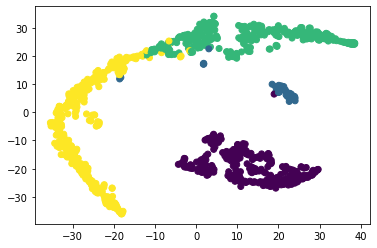

Epoch: 199, test_stats: 98.6000,test_stats: 0.0675 tensor([0.0130, 0.0090, 0.0273, 0.0182])
minimum achieved 0.0475924


In [69]:
criterion = LabelSmoothingCrossEntropy(epsilon = 0.4)
stats_LS = torch.zeros(0,200,3)
### Model
net_LS = Net(dim=100,embedding = 100,FIERCE_parameter = 0)

train_acc_list,MSE_list,Entropy_list = experiment(net_LS,train_loader,test_loader,epochs= 200,lr = 0.0001)  
cat_elements = torch.stack([train_acc_list,MSE_list,Entropy_list], dim = 1).unsqueeze(0)
stats_LS = torch.cat([stats_LS, cat_elements], dim = 0)

### Plot results

In [56]:
def normalize(vector):
  return (vector-vector.min())/(vector.max()-vector.min())

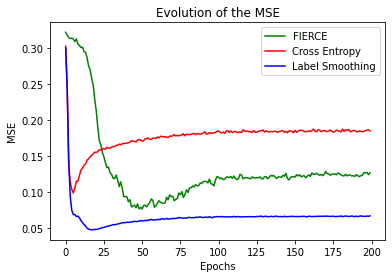

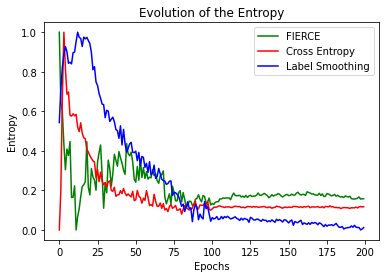

In [71]:
plt.title('Evolution of the MSE')
plt.plot(stats_FIERCE[0,:,1],'green',label = 'FIERCE')
plt.plot(stats_CE[0,:,1],'red', label = 'Cross Entropy')
plt.plot(stats_LS[0,:,1],'blue', label = 'Label Smoothing')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()
plt.show()
plt.title('Evolution of the Entropy')
plt.plot(normalize(stats_FIERCE[0,:,2]),'green',label = 'FIERCE')
plt.plot(normalize(stats_CE[0,:,2]),'red', label = 'Cross Entropy')
plt.plot(normalize(stats_LS[0,:,2]),'blue', label = 'Label Smoothing')
plt.xlabel('Epochs')
plt.ylabel('Entropy')
plt.legend()
plt.show()

## Regression tasks

In [60]:
### A linear regressor
class Regressor(nn.Module):
    # define nn                                                                                                                                                                                        
    def __init__(self,Ncouche = 50,dim =200,embedding = 10):
        super(Regressor, self).__init__()
        self.fc4 = nn.Linear(dim , 4)
    def forward(self, X):
        X = self.fc4(X)
        return X

In [62]:
MSE_Loss = torch.nn.MSELoss()
def train_regression(regressor,model,train_loader,optimizer):
    total_loss, total_elts, train_acc, mse = 0., 0., 0.,0.
    all_features = []
    model.eval()
    for batch_idx,(x,y) in enumerate(train_loader):
      y, z  = y[:,0].long() , y[:,1:]
      optimizer.zero_grad()

      ###give the features
      __,features,entropy = model(x)

      ### Linear regression
      prediction = regressor(features.detach())
      loss = MSE_Loss(z,F.softmax(prediction,-1))
      
      loss.backward()
      optimizer.step()

      _, predict_y = torch.max(prediction, 1)
      train_acc +=  torch.sum(predict_y.data == y)/x.size()[0]
      total_loss += loss.item() * x.shape[0]
      mse += (((z - F.softmax(prediction,-1))**2).sum(1)).mean()
     
     
    return { "train_loss" : total_loss / (batch_idx + 1),  "train_acc" : train_acc / (batch_idx + 1), "train_mse": mse / (batch_idx + 1)}
def test_regression(regressor,model,test_loader,print_features = False):
  total_loss, total_elts,test_acc,mse = 0., 0., 0.,0.
  all_features = []
  all_target = []
  delta = torch.zeros(4)
  for batch_idx, (x_test,y_test) in enumerate(test_loader):
    y_test,z  = y_test[:,0].long(),  y_test[:,1:]
    all_target.append(y_test)
    __,features,entropy = model(x_test)
    predict_out = regressor(features)

    _, predict_y = torch.max(predict_out, 1)
    accuracy_score(y_test, predict_y.data)
    test_acc += accuracy_score(y_test, predict_y.data)

    delta += ((z - F.softmax(predict_out,-1))**2).mean(0).detach()
    mse += ( (z - F.softmax(predict_out,-1))**2).sum(1).mean().detach()
  return {"test_acc": test_acc/(batch_idx+1),"test_mse": mse/(batch_idx+1),"delta": delta/(batch_idx+1) }
def experiment_regression(regressor,model,train_loader,test_loader,epochs,lr =0.1,step_size = 100):
  optimizer = torch.optim.Adam(regressor.parameters(), lr=lr)
  scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.1)

  MSE_list = []
  train_acc_list = []
  Entropy_list = []
  for epoch in range(epochs):
    train_stats = train_regression(regressor,model,train_loader,optimizer)
    scheduler.step()
    

    test_stats = test_regression(regressor,model,test_loader) 
    print("\rEpoch: {:3d}, train_loss: {:.5f}, train_acc: {:.4f}, train_mse: {:.4f}, test_mse: {:.4f}".format(epoch, train_stats["train_loss"], 
                                                                                                            train_stats["train_acc"], train_stats["train_mse"], test_stats["test_mse"] ),test_stats["delta"], end = "")
    
    train_acc_list.append(torch.tensor(train_stats["train_acc"]))
    MSE_list.append( train_stats["train_mse"].detach())
  
  #plt.plot(train_acc_list)
  #plt.plot(MSE_list)
  #plt.plot(Entropy_list)
  test_stats = test(model,test_loader,True) 
  print("\rEpoch: {:3d}, test_stats: {:.4f},test_stats: {:.4f}".format(epoch, 100*test_stats["test_acc"], test_stats["test_mse"]),test_stats["delta"])           
  print("minimum",np.array(MSE_list).min())                                                                     
  return torch.stack(train_acc_list),torch.stack(MSE_list)


Epoch:   0, train_loss: 2.74441, train_acc: 0.9082, train_mse: 0.0553, test_mse: 0.0273 tensor([0.0039, 0.0098, 0.0081, 0.0055])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:   1, train_loss: 1.24410, train_acc: 0.9402, train_mse: 0.0256, test_mse: 0.0216 tensor([0.0030, 0.0081, 0.0065, 0.0040])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:   2, train_loss: 1.05775, train_acc: 0.9490, train_mse: 0.0216, test_mse: 0.0192 tensor([0.0029, 0.0073, 0.0057, 0.0034])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:   3, train_loss: 0.94008, train_acc: 0.9502, train_mse: 0.0191, test_mse: 0.0172 tensor([0.0025, 0.0065, 0.0050, 0.0032])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:   4, train_loss: 0.84504, train_acc: 0.9531, train_mse: 0.0172, test_mse: 0.0154 tensor([0.0022, 0.0060, 0.0045, 0.0028])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:   5, train_loss: 0.77015, train_acc: 0.9522, train_mse: 0.0156, test_mse: 0.0143 tensor([0.0019, 0.0055, 0.0044, 0.0025])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:   6, train_loss: 0.70067, train_acc: 0.9543, train_mse: 0.0144, test_mse: 0.0130 tensor([0.0016, 0.0051, 0.0039, 0.0023])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:   7, train_loss: 0.66004, train_acc: 0.9535, train_mse: 0.0136, test_mse: 0.0139 tensor([0.0015, 0.0053, 0.0037, 0.0034])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:   8, train_loss: 0.62180, train_acc: 0.9544, train_mse: 0.0127, test_mse: 0.0120 tensor([0.0014, 0.0045, 0.0040, 0.0021])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:   9, train_loss: 0.58599, train_acc: 0.9570, train_mse: 0.0119, test_mse: 0.0108 tensor([0.0013, 0.0042, 0.0033, 0.0020])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  10, train_loss: 0.55591, train_acc: 0.9586, train_mse: 0.0113, test_mse: 0.0104 tensor([0.0012, 0.0040, 0.0034, 0.0018])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  11, train_loss: 0.53266, train_acc: 0.9557, train_mse: 0.0108, test_mse: 0.0103 tensor([0.0011, 0.0039, 0.0031, 0.0022])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  12, train_loss: 0.52122, train_acc: 0.9571, train_mse: 0.0107, test_mse: 0.0095 tensor([0.0011, 0.0036, 0.0030, 0.0017])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  13, train_loss: 0.50116, train_acc: 0.9559, train_mse: 0.0102, test_mse: 0.0101 tensor([0.0011, 0.0039, 0.0033, 0.0019])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  14, train_loss: 0.48613, train_acc: 0.9603, train_mse: 0.0099, test_mse: 0.0105 tensor([0.0012, 0.0035, 0.0037, 0.0021])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  15, train_loss: 0.47744, train_acc: 0.9571, train_mse: 0.0097, test_mse: 0.0089 tensor([0.0010, 0.0033, 0.0029, 0.0016])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  16, train_loss: 0.46455, train_acc: 0.9599, train_mse: 0.0095, test_mse: 0.0101 tensor([0.0011, 0.0032, 0.0039, 0.0019])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  17, train_loss: 0.45588, train_acc: 0.9590, train_mse: 0.0092, test_mse: 0.0086 tensor([0.0009, 0.0032, 0.0029, 0.0016])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  18, train_loss: 0.45767, train_acc: 0.9617, train_mse: 0.0093, test_mse: 0.0089 tensor([0.0010, 0.0031, 0.0031, 0.0017])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  19, train_loss: 0.44421, train_acc: 0.9561, train_mse: 0.0089, test_mse: 0.0082 tensor([0.0010, 0.0030, 0.0027, 0.0015])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  20, train_loss: 0.43477, train_acc: 0.9600, train_mse: 0.0088, test_mse: 0.0090 tensor([0.0010, 0.0030, 0.0033, 0.0017])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  21, train_loss: 0.43004, train_acc: 0.9588, train_mse: 0.0088, test_mse: 0.0091 tensor([0.0009, 0.0030, 0.0036, 0.0016])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  22, train_loss: 0.43155, train_acc: 0.9592, train_mse: 0.0089, test_mse: 0.0090 tensor([0.0009, 0.0033, 0.0032, 0.0017])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  23, train_loss: 0.42152, train_acc: 0.9624, train_mse: 0.0086, test_mse: 0.0082 tensor([0.0010, 0.0031, 0.0026, 0.0014])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  24, train_loss: 0.40678, train_acc: 0.9645, train_mse: 0.0085, test_mse: 0.0089 tensor([0.0009, 0.0028, 0.0030, 0.0021])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  25, train_loss: 0.42378, train_acc: 0.9587, train_mse: 0.0086, test_mse: 0.0091 tensor([0.0009, 0.0028, 0.0037, 0.0017])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  26, train_loss: 0.41359, train_acc: 0.9621, train_mse: 0.0089, test_mse: 0.0138 tensor([0.0010, 0.0057, 0.0041, 0.0029])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  27, train_loss: 0.43456, train_acc: 0.9623, train_mse: 0.0090, test_mse: 0.0083 tensor([0.0011, 0.0028, 0.0030, 0.0014])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  28, train_loss: 0.41264, train_acc: 0.9621, train_mse: 0.0083, test_mse: 0.0074 tensor([0.0008, 0.0027, 0.0026, 0.0013])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  29, train_loss: 0.38363, train_acc: 0.9671, train_mse: 0.0078, test_mse: 0.0074 tensor([0.0009, 0.0026, 0.0026, 0.0013])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  30, train_loss: 0.38206, train_acc: 0.9671, train_mse: 0.0079, test_mse: 0.0084 tensor([0.0012, 0.0030, 0.0028, 0.0014])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  31, train_loss: 0.38604, train_acc: 0.9653, train_mse: 0.0078, test_mse: 0.0071 tensor([0.0008, 0.0026, 0.0025, 0.0012])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  32, train_loss: 0.37021, train_acc: 0.9692, train_mse: 0.0075, test_mse: 0.0079 tensor([0.0008, 0.0026, 0.0029, 0.0016])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  33, train_loss: 0.37707, train_acc: 0.9683, train_mse: 0.0076, test_mse: 0.0084 tensor([0.0011, 0.0027, 0.0033, 0.0012])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  34, train_loss: 0.36602, train_acc: 0.9680, train_mse: 0.0075, test_mse: 0.0073 tensor([0.0008, 0.0025, 0.0027, 0.0014])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  35, train_loss: 0.36298, train_acc: 0.9694, train_mse: 0.0074, test_mse: 0.0088 tensor([0.0013, 0.0027, 0.0029, 0.0020])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  36, train_loss: 0.37144, train_acc: 0.9658, train_mse: 0.0075, test_mse: 0.0074 tensor([0.0008, 0.0024, 0.0026, 0.0017])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  37, train_loss: 0.35918, train_acc: 0.9684, train_mse: 0.0073, test_mse: 0.0072 tensor([0.0007, 0.0026, 0.0026, 0.0012])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  38, train_loss: 0.35657, train_acc: 0.9686, train_mse: 0.0072, test_mse: 0.0068 tensor([0.0008, 0.0025, 0.0023, 0.0012])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  39, train_loss: 0.35080, train_acc: 0.9693, train_mse: 0.0071, test_mse: 0.0067 tensor([0.0007, 0.0023, 0.0024, 0.0012])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  40, train_loss: 0.34744, train_acc: 0.9648, train_mse: 0.0070, test_mse: 0.0070 tensor([0.0008, 0.0023, 0.0025, 0.0013])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  41, train_loss: 0.34582, train_acc: 0.9710, train_mse: 0.0070, test_mse: 0.0071 tensor([0.0007, 0.0023, 0.0029, 0.0011])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  42, train_loss: 0.35242, train_acc: 0.9669, train_mse: 0.0072, test_mse: 0.0093 tensor([0.0013, 0.0025, 0.0042, 0.0013])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  43, train_loss: 0.35815, train_acc: 0.9673, train_mse: 0.0073, test_mse: 0.0069 tensor([0.0012, 0.0022, 0.0024, 0.0012])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  44, train_loss: 0.33550, train_acc: 0.9711, train_mse: 0.0070, test_mse: 0.0068 tensor([0.0007, 0.0023, 0.0027, 0.0011])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  45, train_loss: 0.33997, train_acc: 0.9707, train_mse: 0.0069, test_mse: 0.0069 tensor([0.0008, 0.0021, 0.0026, 0.0014])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  46, train_loss: 0.33397, train_acc: 0.9693, train_mse: 0.0067, test_mse: 0.0063 tensor([0.0008, 0.0021, 0.0022, 0.0012])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  47, train_loss: 0.32531, train_acc: 0.9732, train_mse: 0.0067, test_mse: 0.0064 tensor([0.0008, 0.0022, 0.0023, 0.0011])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  48, train_loss: 0.32660, train_acc: 0.9724, train_mse: 0.0066, test_mse: 0.0063 tensor([0.0008, 0.0022, 0.0021, 0.0011])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  49, train_loss: 0.32406, train_acc: 0.9706, train_mse: 0.0065, test_mse: 0.0080 tensor([0.0014, 0.0023, 0.0032, 0.0011])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  50, train_loss: 0.32968, train_acc: 0.9702, train_mse: 0.0067, test_mse: 0.0066 tensor([0.0007, 0.0022, 0.0026, 0.0011])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  51, train_loss: 0.33241, train_acc: 0.9696, train_mse: 0.0068, test_mse: 0.0063 tensor([0.0010, 0.0020, 0.0021, 0.0011])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  52, train_loss: 0.31907, train_acc: 0.9730, train_mse: 0.0065, test_mse: 0.0063 tensor([0.0008, 0.0021, 0.0023, 0.0011])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  53, train_loss: 0.33023, train_acc: 0.9677, train_mse: 0.0067, test_mse: 0.0065 tensor([0.0007, 0.0025, 0.0021, 0.0012])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  54, train_loss: 0.31716, train_acc: 0.9700, train_mse: 0.0065, test_mse: 0.0095 tensor([0.0008, 0.0030, 0.0046, 0.0012])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  55, train_loss: 0.34760, train_acc: 0.9650, train_mse: 0.0071, test_mse: 0.0062 tensor([0.0008, 0.0021, 0.0021, 0.0012])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  56, train_loss: 0.30871, train_acc: 0.9721, train_mse: 0.0063, test_mse: 0.0070 tensor([0.0008, 0.0021, 0.0030, 0.0011])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  57, train_loss: 0.31775, train_acc: 0.9726, train_mse: 0.0064, test_mse: 0.0058 tensor([0.0007, 0.0019, 0.0022, 0.0010])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  58, train_loss: 0.32062, train_acc: 0.9706, train_mse: 0.0065, test_mse: 0.0060 tensor([0.0008, 0.0020, 0.0021, 0.0011])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  59, train_loss: 0.30786, train_acc: 0.9729, train_mse: 0.0062, test_mse: 0.0060 tensor([0.0007, 0.0021, 0.0021, 0.0011])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  60, train_loss: 0.30010, train_acc: 0.9732, train_mse: 0.0061, test_mse: 0.0060 tensor([0.0007, 0.0021, 0.0020, 0.0012])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  61, train_loss: 0.31542, train_acc: 0.9715, train_mse: 0.0063, test_mse: 0.0063 tensor([0.0006, 0.0022, 0.0023, 0.0011])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  62, train_loss: 0.32079, train_acc: 0.9709, train_mse: 0.0065, test_mse: 0.0086 tensor([0.0017, 0.0022, 0.0030, 0.0016])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  63, train_loss: 0.33242, train_acc: 0.9709, train_mse: 0.0067, test_mse: 0.0065 tensor([0.0007, 0.0022, 0.0023, 0.0013])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  64, train_loss: 0.29756, train_acc: 0.9726, train_mse: 0.0061, test_mse: 0.0058 tensor([0.0006, 0.0021, 0.0021, 0.0011])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  65, train_loss: 0.30597, train_acc: 0.9718, train_mse: 0.0062, test_mse: 0.0055 tensor([0.0007, 0.0020, 0.0019, 0.0009])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  66, train_loss: 0.30007, train_acc: 0.9726, train_mse: 0.0061, test_mse: 0.0062 tensor([0.0006, 0.0020, 0.0024, 0.0012])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  67, train_loss: 0.30193, train_acc: 0.9733, train_mse: 0.0061, test_mse: 0.0070 tensor([0.0011, 0.0018, 0.0028, 0.0012])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  68, train_loss: 0.31704, train_acc: 0.9723, train_mse: 0.0064, test_mse: 0.0068 tensor([0.0007, 0.0026, 0.0020, 0.0015])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  69, train_loss: 0.30000, train_acc: 0.9691, train_mse: 0.0061, test_mse: 0.0056 tensor([0.0006, 0.0019, 0.0020, 0.0010])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  70, train_loss: 0.30097, train_acc: 0.9730, train_mse: 0.0061, test_mse: 0.0057 tensor([0.0006, 0.0019, 0.0022, 0.0010])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  71, train_loss: 0.29167, train_acc: 0.9735, train_mse: 0.0059, test_mse: 0.0054 tensor([0.0007, 0.0018, 0.0019, 0.0011])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  72, train_loss: 0.29302, train_acc: 0.9731, train_mse: 0.0060, test_mse: 0.0063 tensor([0.0006, 0.0025, 0.0022, 0.0011])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  73, train_loss: 0.30063, train_acc: 0.9694, train_mse: 0.0061, test_mse: 0.0057 tensor([0.0007, 0.0018, 0.0021, 0.0010])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  74, train_loss: 0.29043, train_acc: 0.9749, train_mse: 0.0058, test_mse: 0.0059 tensor([0.0010, 0.0019, 0.0021, 0.0009])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  75, train_loss: 0.28561, train_acc: 0.9746, train_mse: 0.0058, test_mse: 0.0058 tensor([0.0007, 0.0020, 0.0019, 0.0011])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  76, train_loss: 0.29033, train_acc: 0.9735, train_mse: 0.0059, test_mse: 0.0057 tensor([0.0006, 0.0020, 0.0020, 0.0010])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  77, train_loss: 0.30338, train_acc: 0.9725, train_mse: 0.0062, test_mse: 0.0074 tensor([0.0008, 0.0023, 0.0031, 0.0011])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  78, train_loss: 0.30132, train_acc: 0.9707, train_mse: 0.0062, test_mse: 0.0059 tensor([0.0006, 0.0019, 0.0023, 0.0010])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  79, train_loss: 0.29466, train_acc: 0.9731, train_mse: 0.0060, test_mse: 0.0054 tensor([0.0006, 0.0019, 0.0020, 0.0009])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  80, train_loss: 0.29585, train_acc: 0.9724, train_mse: 0.0060, test_mse: 0.0057 tensor([0.0007, 0.0018, 0.0021, 0.0011])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  81, train_loss: 0.29945, train_acc: 0.9727, train_mse: 0.0062, test_mse: 0.0059 tensor([0.0006, 0.0018, 0.0022, 0.0014])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  82, train_loss: 0.29145, train_acc: 0.9732, train_mse: 0.0060, test_mse: 0.0054 tensor([0.0006, 0.0018, 0.0021, 0.0009])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  83, train_loss: 0.27993, train_acc: 0.9753, train_mse: 0.0057, test_mse: 0.0062 tensor([0.0006, 0.0020, 0.0024, 0.0012])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  84, train_loss: 0.28949, train_acc: 0.9730, train_mse: 0.0059, test_mse: 0.0076 tensor([0.0010, 0.0018, 0.0027, 0.0022])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  85, train_loss: 0.30147, train_acc: 0.9630, train_mse: 0.0061, test_mse: 0.0051 tensor([0.0006, 0.0017, 0.0019, 0.0009])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  86, train_loss: 0.28042, train_acc: 0.9745, train_mse: 0.0057, test_mse: 0.0053 tensor([0.0006, 0.0019, 0.0019, 0.0009])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  87, train_loss: 0.30232, train_acc: 0.9717, train_mse: 0.0062, test_mse: 0.0055 tensor([0.0006, 0.0019, 0.0020, 0.0010])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  88, train_loss: 0.28178, train_acc: 0.9746, train_mse: 0.0057, test_mse: 0.0052 tensor([0.0006, 0.0018, 0.0019, 0.0009])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  89, train_loss: 0.28228, train_acc: 0.9744, train_mse: 0.0057, test_mse: 0.0053 tensor([0.0006, 0.0017, 0.0019, 0.0010])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  90, train_loss: 0.27400, train_acc: 0.9757, train_mse: 0.0055, test_mse: 0.0051 tensor([0.0006, 0.0016, 0.0018, 0.0010])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  91, train_loss: 0.28140, train_acc: 0.9715, train_mse: 0.0058, test_mse: 0.0060 tensor([0.0010, 0.0018, 0.0021, 0.0011])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  92, train_loss: 0.28141, train_acc: 0.9724, train_mse: 0.0057, test_mse: 0.0055 tensor([0.0006, 0.0017, 0.0022, 0.0011])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  93, train_loss: 0.28982, train_acc: 0.9733, train_mse: 0.0058, test_mse: 0.0059 tensor([0.0007, 0.0020, 0.0022, 0.0010])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  94, train_loss: 0.28747, train_acc: 0.9714, train_mse: 0.0058, test_mse: 0.0050 tensor([0.0006, 0.0016, 0.0019, 0.0010])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  95, train_loss: 0.27218, train_acc: 0.9749, train_mse: 0.0055, test_mse: 0.0053 tensor([0.0006, 0.0016, 0.0019, 0.0012])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  96, train_loss: 0.27774, train_acc: 0.9715, train_mse: 0.0057, test_mse: 0.0057 tensor([0.0008, 0.0017, 0.0021, 0.0011])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  97, train_loss: 0.28895, train_acc: 0.9725, train_mse: 0.0059, test_mse: 0.0056 tensor([0.0006, 0.0020, 0.0021, 0.0009])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  98, train_loss: 0.28484, train_acc: 0.9734, train_mse: 0.0058, test_mse: 0.0054 tensor([0.0005, 0.0017, 0.0019, 0.0012])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  99, train_loss: 0.27153, train_acc: 0.9744, train_mse: 0.0055, test_mse: 0.0053 tensor([0.0006, 0.0017, 0.0019, 0.0011])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 100, train_loss: 0.26011, train_acc: 0.9750, train_mse: 0.0053, test_mse: 0.0049 tensor([0.0005, 0.0016, 0.0018, 0.0009])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 101, train_loss: 0.25848, train_acc: 0.9750, train_mse: 0.0052, test_mse: 0.0047 tensor([0.0005, 0.0016, 0.0017, 0.0008])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 102, train_loss: 0.25743, train_acc: 0.9756, train_mse: 0.0055, test_mse: 0.0047 tensor([0.0006, 0.0016, 0.0017, 0.0009])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 103, train_loss: 0.26139, train_acc: 0.9759, train_mse: 0.0053, test_mse: 0.0047 tensor([0.0005, 0.0016, 0.0018, 0.0009])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 104, train_loss: 0.25718, train_acc: 0.9754, train_mse: 0.0053, test_mse: 0.0048 tensor([0.0005, 0.0016, 0.0018, 0.0008])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 105, train_loss: 0.25800, train_acc: 0.9754, train_mse: 0.0054, test_mse: 0.0047 tensor([0.0005, 0.0016, 0.0017, 0.0008])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 106, train_loss: 0.25890, train_acc: 0.9756, train_mse: 0.0052, test_mse: 0.0048 tensor([0.0005, 0.0016, 0.0018, 0.0009])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 107, train_loss: 0.25704, train_acc: 0.9727, train_mse: 0.0052, test_mse: 0.0047 tensor([0.0005, 0.0016, 0.0017, 0.0008])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 108, train_loss: 0.25814, train_acc: 0.9749, train_mse: 0.0053, test_mse: 0.0047 tensor([0.0005, 0.0016, 0.0017, 0.0008])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 109, train_loss: 0.25795, train_acc: 0.9723, train_mse: 0.0052, test_mse: 0.0047 tensor([0.0005, 0.0016, 0.0018, 0.0008])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 110, train_loss: 0.25700, train_acc: 0.9752, train_mse: 0.0053, test_mse: 0.0047 tensor([0.0005, 0.0016, 0.0017, 0.0008])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 111, train_loss: 0.25669, train_acc: 0.9744, train_mse: 0.0052, test_mse: 0.0047 tensor([0.0005, 0.0016, 0.0017, 0.0008])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 112, train_loss: 0.25726, train_acc: 0.9751, train_mse: 0.0052, test_mse: 0.0047 tensor([0.0005, 0.0016, 0.0017, 0.0008])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 113, train_loss: 0.25855, train_acc: 0.9736, train_mse: 0.0054, test_mse: 0.0047 tensor([0.0005, 0.0016, 0.0017, 0.0008])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 114, train_loss: 0.25856, train_acc: 0.9757, train_mse: 0.0052, test_mse: 0.0047 tensor([0.0005, 0.0016, 0.0017, 0.0008])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 115, train_loss: 0.25642, train_acc: 0.9761, train_mse: 0.0052, test_mse: 0.0047 tensor([0.0005, 0.0016, 0.0017, 0.0009])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 116, train_loss: 0.25734, train_acc: 0.9752, train_mse: 0.0053, test_mse: 0.0047 tensor([0.0005, 0.0016, 0.0017, 0.0009])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 117, train_loss: 0.25713, train_acc: 0.9754, train_mse: 0.0052, test_mse: 0.0047 tensor([0.0005, 0.0016, 0.0018, 0.0008])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 118, train_loss: 0.25618, train_acc: 0.9765, train_mse: 0.0053, test_mse: 0.0047 tensor([0.0005, 0.0016, 0.0017, 0.0008])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 119, train_loss: 0.25780, train_acc: 0.9747, train_mse: 0.0055, test_mse: 0.0048 tensor([0.0005, 0.0016, 0.0017, 0.0009])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 120, train_loss: 0.26293, train_acc: 0.9745, train_mse: 0.0053, test_mse: 0.0048 tensor([0.0005, 0.0016, 0.0018, 0.0008])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 121, train_loss: 0.25679, train_acc: 0.9757, train_mse: 0.0053, test_mse: 0.0047 tensor([0.0005, 0.0016, 0.0017, 0.0008])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 122, train_loss: 0.25646, train_acc: 0.9754, train_mse: 0.0052, test_mse: 0.0047 tensor([0.0005, 0.0016, 0.0018, 0.0008])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 123, train_loss: 0.25660, train_acc: 0.9746, train_mse: 0.0052, test_mse: 0.0047 tensor([0.0005, 0.0016, 0.0017, 0.0008])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 124, train_loss: 0.25619, train_acc: 0.9760, train_mse: 0.0053, test_mse: 0.0047 tensor([0.0005, 0.0016, 0.0017, 0.0009])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 125, train_loss: 0.25531, train_acc: 0.9754, train_mse: 0.0051, test_mse: 0.0048 tensor([0.0005, 0.0016, 0.0018, 0.0008])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 126, train_loss: 0.25621, train_acc: 0.9754, train_mse: 0.0052, test_mse: 0.0047 tensor([0.0005, 0.0016, 0.0017, 0.0009])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 127, train_loss: 0.25610, train_acc: 0.9757, train_mse: 0.0052, test_mse: 0.0047 tensor([0.0005, 0.0016, 0.0017, 0.0008])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 128, train_loss: 0.25586, train_acc: 0.9758, train_mse: 0.0052, test_mse: 0.0047 tensor([0.0005, 0.0016, 0.0018, 0.0009])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 129, train_loss: 0.25741, train_acc: 0.9734, train_mse: 0.0052, test_mse: 0.0047 tensor([0.0005, 0.0016, 0.0018, 0.0008])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 130, train_loss: 0.25760, train_acc: 0.9734, train_mse: 0.0053, test_mse: 0.0047 tensor([0.0005, 0.0016, 0.0017, 0.0009])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 131, train_loss: 0.25556, train_acc: 0.9732, train_mse: 0.0052, test_mse: 0.0047 tensor([0.0005, 0.0016, 0.0017, 0.0008])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 132, train_loss: 0.25598, train_acc: 0.9753, train_mse: 0.0052, test_mse: 0.0047 tensor([0.0006, 0.0016, 0.0017, 0.0008])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 133, train_loss: 0.25636, train_acc: 0.9762, train_mse: 0.0052, test_mse: 0.0047 tensor([0.0005, 0.0016, 0.0017, 0.0008])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 134, train_loss: 0.25637, train_acc: 0.9749, train_mse: 0.0052, test_mse: 0.0047 tensor([0.0005, 0.0016, 0.0017, 0.0009])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 135, train_loss: 0.25708, train_acc: 0.9763, train_mse: 0.0052, test_mse: 0.0047 tensor([0.0005, 0.0016, 0.0017, 0.0009])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 136, train_loss: 0.25574, train_acc: 0.9711, train_mse: 0.0052, test_mse: 0.0047 tensor([0.0005, 0.0016, 0.0017, 0.0008])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 137, train_loss: 0.25610, train_acc: 0.9769, train_mse: 0.0053, test_mse: 0.0047 tensor([0.0005, 0.0016, 0.0018, 0.0008])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 138, train_loss: 0.25639, train_acc: 0.9755, train_mse: 0.0053, test_mse: 0.0046 tensor([0.0005, 0.0016, 0.0017, 0.0008])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 139, train_loss: 0.25642, train_acc: 0.9754, train_mse: 0.0052, test_mse: 0.0047 tensor([0.0005, 0.0016, 0.0017, 0.0008])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 140, train_loss: 0.25537, train_acc: 0.9754, train_mse: 0.0051, test_mse: 0.0047 tensor([0.0005, 0.0016, 0.0018, 0.0008])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 141, train_loss: 0.25610, train_acc: 0.9753, train_mse: 0.0052, test_mse: 0.0047 tensor([0.0005, 0.0016, 0.0017, 0.0008])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 142, train_loss: 0.25615, train_acc: 0.9739, train_mse: 0.0052, test_mse: 0.0047 tensor([0.0005, 0.0016, 0.0017, 0.0008])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 143, train_loss: 0.25496, train_acc: 0.9754, train_mse: 0.0053, test_mse: 0.0047 tensor([0.0005, 0.0016, 0.0017, 0.0008])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 144, train_loss: 0.25545, train_acc: 0.9764, train_mse: 0.0052, test_mse: 0.0047 tensor([0.0005, 0.0016, 0.0017, 0.0008])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 145, train_loss: 0.25419, train_acc: 0.9732, train_mse: 0.0051, test_mse: 0.0047 tensor([0.0005, 0.0016, 0.0017, 0.0008])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 146, train_loss: 0.25576, train_acc: 0.9764, train_mse: 0.0051, test_mse: 0.0047 tensor([0.0005, 0.0016, 0.0017, 0.0008])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 147, train_loss: 0.25497, train_acc: 0.9759, train_mse: 0.0053, test_mse: 0.0046 tensor([0.0005, 0.0016, 0.0017, 0.0008])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 148, train_loss: 0.25893, train_acc: 0.9754, train_mse: 0.0052, test_mse: 0.0047 tensor([0.0005, 0.0016, 0.0018, 0.0008])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 149, train_loss: 0.25528, train_acc: 0.9729, train_mse: 0.0052, test_mse: 0.0047 tensor([0.0005, 0.0016, 0.0017, 0.0008])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 150, train_loss: 0.25573, train_acc: 0.9761, train_mse: 0.0052, test_mse: 0.0047 tensor([0.0006, 0.0016, 0.0017, 0.0008])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 151, train_loss: 0.25541, train_acc: 0.9735, train_mse: 0.0052, test_mse: 0.0047 tensor([0.0005, 0.0016, 0.0017, 0.0008])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 152, train_loss: 0.25503, train_acc: 0.9761, train_mse: 0.0052, test_mse: 0.0046 tensor([0.0005, 0.0016, 0.0017, 0.0008])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 153, train_loss: 0.25568, train_acc: 0.9763, train_mse: 0.0052, test_mse: 0.0047 tensor([0.0005, 0.0016, 0.0018, 0.0008])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 154, train_loss: 0.25721, train_acc: 0.9756, train_mse: 0.0054, test_mse: 0.0047 tensor([0.0005, 0.0016, 0.0017, 0.0008])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 155, train_loss: 0.25542, train_acc: 0.9761, train_mse: 0.0052, test_mse: 0.0047 tensor([0.0005, 0.0016, 0.0017, 0.0009])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 156, train_loss: 0.25493, train_acc: 0.9753, train_mse: 0.0052, test_mse: 0.0047 tensor([0.0005, 0.0016, 0.0018, 0.0008])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 157, train_loss: 0.25535, train_acc: 0.9763, train_mse: 0.0052, test_mse: 0.0046 tensor([0.0005, 0.0016, 0.0017, 0.0008])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 158, train_loss: 0.25473, train_acc: 0.9758, train_mse: 0.0051, test_mse: 0.0047 tensor([0.0005, 0.0016, 0.0017, 0.0008])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 159, train_loss: 0.25368, train_acc: 0.9758, train_mse: 0.0052, test_mse: 0.0047 tensor([0.0005, 0.0016, 0.0017, 0.0008])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 160, train_loss: 0.25396, train_acc: 0.9761, train_mse: 0.0051, test_mse: 0.0047 tensor([0.0005, 0.0016, 0.0017, 0.0009])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 161, train_loss: 0.25392, train_acc: 0.9756, train_mse: 0.0051, test_mse: 0.0047 tensor([0.0005, 0.0016, 0.0017, 0.0009])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 162, train_loss: 0.25412, train_acc: 0.9760, train_mse: 0.0051, test_mse: 0.0047 tensor([0.0005, 0.0016, 0.0018, 0.0009])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 163, train_loss: 0.25382, train_acc: 0.9756, train_mse: 0.0052, test_mse: 0.0046 tensor([0.0005, 0.0016, 0.0017, 0.0008])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 164, train_loss: 0.25428, train_acc: 0.9759, train_mse: 0.0052, test_mse: 0.0047 tensor([0.0005, 0.0016, 0.0017, 0.0008])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 165, train_loss: 0.25555, train_acc: 0.9762, train_mse: 0.0052, test_mse: 0.0046 tensor([0.0005, 0.0016, 0.0017, 0.0009])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 166, train_loss: 0.25373, train_acc: 0.9756, train_mse: 0.0051, test_mse: 0.0046 tensor([0.0005, 0.0016, 0.0017, 0.0009])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 167, train_loss: 0.25349, train_acc: 0.9751, train_mse: 0.0052, test_mse: 0.0047 tensor([0.0006, 0.0016, 0.0017, 0.0008])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 168, train_loss: 0.25453, train_acc: 0.9746, train_mse: 0.0052, test_mse: 0.0046 tensor([0.0005, 0.0016, 0.0017, 0.0008])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 169, train_loss: 0.25337, train_acc: 0.9737, train_mse: 0.0052, test_mse: 0.0047 tensor([0.0005, 0.0016, 0.0017, 0.0008])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 170, train_loss: 0.25525, train_acc: 0.9745, train_mse: 0.0052, test_mse: 0.0046 tensor([0.0005, 0.0016, 0.0017, 0.0008])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 171, train_loss: 0.25307, train_acc: 0.9755, train_mse: 0.0051, test_mse: 0.0047 tensor([0.0005, 0.0016, 0.0018, 0.0009])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 172, train_loss: 0.25454, train_acc: 0.9755, train_mse: 0.0052, test_mse: 0.0046 tensor([0.0005, 0.0016, 0.0017, 0.0008])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 173, train_loss: 0.25393, train_acc: 0.9762, train_mse: 0.0052, test_mse: 0.0047 tensor([0.0005, 0.0016, 0.0017, 0.0008])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 174, train_loss: 0.25283, train_acc: 0.9769, train_mse: 0.0052, test_mse: 0.0047 tensor([0.0005, 0.0016, 0.0017, 0.0008])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 175, train_loss: 0.25488, train_acc: 0.9729, train_mse: 0.0052, test_mse: 0.0046 tensor([0.0006, 0.0016, 0.0017, 0.0008])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 176, train_loss: 0.25376, train_acc: 0.9754, train_mse: 0.0051, test_mse: 0.0046 tensor([0.0005, 0.0016, 0.0017, 0.0008])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 177, train_loss: 0.25185, train_acc: 0.9764, train_mse: 0.0051, test_mse: 0.0046 tensor([0.0005, 0.0015, 0.0017, 0.0008])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 178, train_loss: 0.25380, train_acc: 0.9757, train_mse: 0.0053, test_mse: 0.0047 tensor([0.0005, 0.0015, 0.0018, 0.0008])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 179, train_loss: 0.25382, train_acc: 0.9756, train_mse: 0.0051, test_mse: 0.0047 tensor([0.0005, 0.0015, 0.0017, 0.0008])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 180, train_loss: 0.25323, train_acc: 0.9749, train_mse: 0.0052, test_mse: 0.0047 tensor([0.0005, 0.0015, 0.0018, 0.0008])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 181, train_loss: 0.25473, train_acc: 0.9760, train_mse: 0.0051, test_mse: 0.0046 tensor([0.0005, 0.0016, 0.0017, 0.0008])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 182, train_loss: 0.25158, train_acc: 0.9761, train_mse: 0.0051, test_mse: 0.0046 tensor([0.0005, 0.0016, 0.0017, 0.0008])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 183, train_loss: 0.25299, train_acc: 0.9735, train_mse: 0.0052, test_mse: 0.0046 tensor([0.0005, 0.0015, 0.0017, 0.0008])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 184, train_loss: 0.25167, train_acc: 0.9756, train_mse: 0.0051, test_mse: 0.0046 tensor([0.0005, 0.0016, 0.0017, 0.0008])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 185, train_loss: 0.25213, train_acc: 0.9754, train_mse: 0.0052, test_mse: 0.0046 tensor([0.0005, 0.0016, 0.0017, 0.0008])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 186, train_loss: 0.25242, train_acc: 0.9753, train_mse: 0.0053, test_mse: 0.0046 tensor([0.0006, 0.0015, 0.0017, 0.0008])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 187, train_loss: 0.25465, train_acc: 0.9734, train_mse: 0.0056, test_mse: 0.0046 tensor([0.0005, 0.0015, 0.0017, 0.0008])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 188, train_loss: 0.25617, train_acc: 0.9770, train_mse: 0.0052, test_mse: 0.0047 tensor([0.0005, 0.0016, 0.0018, 0.0008])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 189, train_loss: 0.25414, train_acc: 0.9776, train_mse: 0.0051, test_mse: 0.0047 tensor([0.0005, 0.0016, 0.0018, 0.0008])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 190, train_loss: 0.25211, train_acc: 0.9759, train_mse: 0.0052, test_mse: 0.0048 tensor([0.0005, 0.0016, 0.0018, 0.0008])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 191, train_loss: 0.25389, train_acc: 0.9755, train_mse: 0.0051, test_mse: 0.0046 tensor([0.0005, 0.0016, 0.0017, 0.0008])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 192, train_loss: 0.25172, train_acc: 0.9733, train_mse: 0.0052, test_mse: 0.0047 tensor([0.0006, 0.0016, 0.0017, 0.0008])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 193, train_loss: 0.25278, train_acc: 0.9755, train_mse: 0.0051, test_mse: 0.0046 tensor([0.0005, 0.0016, 0.0017, 0.0008])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 194, train_loss: 0.25175, train_acc: 0.9756, train_mse: 0.0052, test_mse: 0.0046 tensor([0.0006, 0.0016, 0.0017, 0.0008])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 195, train_loss: 0.25470, train_acc: 0.9736, train_mse: 0.0063, test_mse: 0.0050 tensor([0.0005, 0.0016, 0.0018, 0.0011])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 196, train_loss: 0.27165, train_acc: 0.9734, train_mse: 0.0055, test_mse: 0.0047 tensor([0.0005, 0.0015, 0.0017, 0.0009])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 197, train_loss: 0.25176, train_acc: 0.9760, train_mse: 0.0051, test_mse: 0.0047 tensor([0.0006, 0.0016, 0.0017, 0.0009])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 198, train_loss: 0.25215, train_acc: 0.9753, train_mse: 0.0051, test_mse: 0.0046 tensor([0.0005, 0.0016, 0.0017, 0.0008])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 199, train_loss: 0.25136, train_acc: 0.9764, train_mse: 0.0052, test_mse: 0.0046 tensor([0.0005, 0.0016, 0.0017, 0.0008])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 200, train_loss: 0.24878, train_acc: 0.9757, train_mse: 0.0050, test_mse: 0.0046 tensor([0.0005, 0.0015, 0.0017, 0.0008])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 201, train_loss: 0.24859, train_acc: 0.9734, train_mse: 0.0050, test_mse: 0.0046 tensor([0.0005, 0.0015, 0.0017, 0.0008])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 202, train_loss: 0.24866, train_acc: 0.9762, train_mse: 0.0050, test_mse: 0.0046 tensor([0.0005, 0.0015, 0.0017, 0.0008])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 203, train_loss: 0.24883, train_acc: 0.9762, train_mse: 0.0050, test_mse: 0.0046 tensor([0.0005, 0.0015, 0.0017, 0.0008])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 204, train_loss: 0.24865, train_acc: 0.9758, train_mse: 0.0050, test_mse: 0.0045 tensor([0.0005, 0.0015, 0.0017, 0.0008])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 205, train_loss: 0.24859, train_acc: 0.9766, train_mse: 0.0050, test_mse: 0.0046 tensor([0.0005, 0.0015, 0.0017, 0.0008])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 206, train_loss: 0.24850, train_acc: 0.9758, train_mse: 0.0051, test_mse: 0.0046 tensor([0.0005, 0.0015, 0.0017, 0.0008])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 207, train_loss: 0.24881, train_acc: 0.9764, train_mse: 0.0051, test_mse: 0.0046 tensor([0.0005, 0.0015, 0.0017, 0.0008])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 208, train_loss: 0.24860, train_acc: 0.9759, train_mse: 0.0050, test_mse: 0.0046 tensor([0.0005, 0.0015, 0.0017, 0.0008])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 209, train_loss: 0.24855, train_acc: 0.9736, train_mse: 0.0050, test_mse: 0.0045 tensor([0.0005, 0.0015, 0.0017, 0.0008])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 210, train_loss: 0.24855, train_acc: 0.9757, train_mse: 0.0050, test_mse: 0.0046 tensor([0.0005, 0.0015, 0.0017, 0.0008])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 211, train_loss: 0.24861, train_acc: 0.9757, train_mse: 0.0051, test_mse: 0.0045 tensor([0.0005, 0.0015, 0.0017, 0.0008])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 212, train_loss: 0.24866, train_acc: 0.9759, train_mse: 0.0050, test_mse: 0.0045 tensor([0.0005, 0.0015, 0.0017, 0.0008])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 213, train_loss: 0.24846, train_acc: 0.9756, train_mse: 0.0051, test_mse: 0.0045 tensor([0.0005, 0.0015, 0.0017, 0.0008])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 214, train_loss: 0.24867, train_acc: 0.9760, train_mse: 0.0055, test_mse: 0.0045 tensor([0.0005, 0.0015, 0.0017, 0.0008])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 215, train_loss: 0.25016, train_acc: 0.9744, train_mse: 0.0051, test_mse: 0.0046 tensor([0.0005, 0.0015, 0.0017, 0.0008])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 216, train_loss: 0.24848, train_acc: 0.9759, train_mse: 0.0050, test_mse: 0.0046 tensor([0.0005, 0.0015, 0.0017, 0.0008])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 217, train_loss: 0.24836, train_acc: 0.9740, train_mse: 0.0052, test_mse: 0.0045 tensor([0.0005, 0.0015, 0.0017, 0.0008])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 218, train_loss: 0.24868, train_acc: 0.9732, train_mse: 0.0050, test_mse: 0.0046 tensor([0.0005, 0.0015, 0.0017, 0.0008])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 219, train_loss: 0.24858, train_acc: 0.9760, train_mse: 0.0051, test_mse: 0.0046 tensor([0.0005, 0.0015, 0.0017, 0.0008])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 220, train_loss: 0.24878, train_acc: 0.9766, train_mse: 0.0051, test_mse: 0.0046 tensor([0.0005, 0.0015, 0.0017, 0.0008])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 221, train_loss: 0.24846, train_acc: 0.9760, train_mse: 0.0051, test_mse: 0.0045 tensor([0.0005, 0.0015, 0.0017, 0.0008])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 222, train_loss: 0.24845, train_acc: 0.9760, train_mse: 0.0051, test_mse: 0.0045 tensor([0.0005, 0.0015, 0.0017, 0.0008])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 223, train_loss: 0.24851, train_acc: 0.9759, train_mse: 0.0050, test_mse: 0.0045 tensor([0.0005, 0.0015, 0.0017, 0.0008])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 224, train_loss: 0.24845, train_acc: 0.9767, train_mse: 0.0052, test_mse: 0.0045 tensor([0.0005, 0.0015, 0.0017, 0.0008])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 225, train_loss: 0.24843, train_acc: 0.9762, train_mse: 0.0051, test_mse: 0.0046 tensor([0.0005, 0.0015, 0.0017, 0.0008])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 226, train_loss: 0.24843, train_acc: 0.9759, train_mse: 0.0050, test_mse: 0.0045 tensor([0.0005, 0.0015, 0.0017, 0.0008])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 227, train_loss: 0.24844, train_acc: 0.9766, train_mse: 0.0050, test_mse: 0.0045 tensor([0.0005, 0.0015, 0.0017, 0.0008])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 228, train_loss: 0.24842, train_acc: 0.9760, train_mse: 0.0051, test_mse: 0.0045 tensor([0.0005, 0.0015, 0.0017, 0.0008])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 229, train_loss: 0.24843, train_acc: 0.9759, train_mse: 0.0050, test_mse: 0.0046 tensor([0.0005, 0.0015, 0.0017, 0.0008])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 230, train_loss: 0.24829, train_acc: 0.9760, train_mse: 0.0050, test_mse: 0.0045 tensor([0.0005, 0.0016, 0.0017, 0.0008])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 231, train_loss: 0.24832, train_acc: 0.9764, train_mse: 0.0051, test_mse: 0.0045 tensor([0.0005, 0.0015, 0.0017, 0.0008])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 232, train_loss: 0.24860, train_acc: 0.9756, train_mse: 0.0050, test_mse: 0.0045 tensor([0.0005, 0.0015, 0.0017, 0.0008])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 233, train_loss: 0.24832, train_acc: 0.9741, train_mse: 0.0051, test_mse: 0.0045 tensor([0.0005, 0.0015, 0.0017, 0.0008])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 234, train_loss: 0.24841, train_acc: 0.9760, train_mse: 0.0051, test_mse: 0.0046 tensor([0.0005, 0.0015, 0.0017, 0.0008])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 235, train_loss: 0.24831, train_acc: 0.9766, train_mse: 0.0051, test_mse: 0.0045 tensor([0.0005, 0.0015, 0.0017, 0.0008])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 236, train_loss: 0.24856, train_acc: 0.9759, train_mse: 0.0050, test_mse: 0.0045 tensor([0.0005, 0.0015, 0.0017, 0.0008])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 237, train_loss: 0.24830, train_acc: 0.9760, train_mse: 0.0050, test_mse: 0.0045 tensor([0.0005, 0.0015, 0.0017, 0.0008])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 238, train_loss: 0.24834, train_acc: 0.9760, train_mse: 0.0051, test_mse: 0.0045 tensor([0.0005, 0.0015, 0.0017, 0.0008])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 239, train_loss: 0.24868, train_acc: 0.9761, train_mse: 0.0051, test_mse: 0.0045 tensor([0.0005, 0.0015, 0.0017, 0.0008])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 240, train_loss: 0.24832, train_acc: 0.9735, train_mse: 0.0050, test_mse: 0.0045 tensor([0.0005, 0.0015, 0.0017, 0.0008])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 241, train_loss: 0.24836, train_acc: 0.9764, train_mse: 0.0050, test_mse: 0.0046 tensor([0.0005, 0.0015, 0.0017, 0.0008])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 242, train_loss: 0.24839, train_acc: 0.9743, train_mse: 0.0050, test_mse: 0.0045 tensor([0.0005, 0.0015, 0.0017, 0.0008])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 243, train_loss: 0.24847, train_acc: 0.9766, train_mse: 0.0050, test_mse: 0.0046 tensor([0.0005, 0.0015, 0.0017, 0.0008])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 244, train_loss: 0.24826, train_acc: 0.9761, train_mse: 0.0050, test_mse: 0.0045 tensor([0.0005, 0.0015, 0.0017, 0.0008])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 245, train_loss: 0.24834, train_acc: 0.9758, train_mse: 0.0050, test_mse: 0.0045 tensor([0.0005, 0.0015, 0.0017, 0.0008])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 246, train_loss: 0.24830, train_acc: 0.9759, train_mse: 0.0050, test_mse: 0.0045 tensor([0.0005, 0.0015, 0.0017, 0.0008])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 247, train_loss: 0.24839, train_acc: 0.9762, train_mse: 0.0052, test_mse: 0.0045 tensor([0.0005, 0.0015, 0.0017, 0.0008])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 248, train_loss: 0.24847, train_acc: 0.9755, train_mse: 0.0050, test_mse: 0.0046 tensor([0.0005, 0.0015, 0.0017, 0.0008])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 249, train_loss: 0.24837, train_acc: 0.9761, train_mse: 0.0052, test_mse: 0.0045 tensor([0.0005, 0.0015, 0.0017, 0.0008])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 250, train_loss: 0.24899, train_acc: 0.9765, train_mse: 0.0051, test_mse: 0.0045 tensor([0.0005, 0.0015, 0.0017, 0.0008])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 251, train_loss: 0.24834, train_acc: 0.9736, train_mse: 0.0051, test_mse: 0.0045 tensor([0.0005, 0.0015, 0.0017, 0.0008])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 252, train_loss: 0.24831, train_acc: 0.9768, train_mse: 0.0050, test_mse: 0.0045 tensor([0.0005, 0.0015, 0.0017, 0.0008])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 253, train_loss: 0.24836, train_acc: 0.9760, train_mse: 0.0051, test_mse: 0.0045 tensor([0.0005, 0.0015, 0.0017, 0.0008])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 254, train_loss: 0.24868, train_acc: 0.9759, train_mse: 0.0051, test_mse: 0.0045 tensor([0.0005, 0.0015, 0.0017, 0.0008])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 255, train_loss: 0.24855, train_acc: 0.9754, train_mse: 0.0051, test_mse: 0.0045 tensor([0.0005, 0.0015, 0.0017, 0.0008])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 256, train_loss: 0.24811, train_acc: 0.9759, train_mse: 0.0052, test_mse: 0.0045 tensor([0.0005, 0.0015, 0.0017, 0.0008])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 257, train_loss: 0.24843, train_acc: 0.9734, train_mse: 0.0050, test_mse: 0.0045 tensor([0.0005, 0.0015, 0.0017, 0.0008])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 258, train_loss: 0.24837, train_acc: 0.9762, train_mse: 0.0052, test_mse: 0.0045 tensor([0.0005, 0.0015, 0.0017, 0.0008])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 259, train_loss: 0.24839, train_acc: 0.9767, train_mse: 0.0052, test_mse: 0.0045 tensor([0.0005, 0.0015, 0.0017, 0.0008])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 260, train_loss: 0.24836, train_acc: 0.9733, train_mse: 0.0051, test_mse: 0.0045 tensor([0.0005, 0.0015, 0.0017, 0.0008])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 261, train_loss: 0.24834, train_acc: 0.9760, train_mse: 0.0050, test_mse: 0.0045 tensor([0.0005, 0.0015, 0.0017, 0.0008])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 262, train_loss: 0.24816, train_acc: 0.9757, train_mse: 0.0051, test_mse: 0.0045 tensor([0.0005, 0.0015, 0.0017, 0.0008])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 263, train_loss: 0.24814, train_acc: 0.9762, train_mse: 0.0051, test_mse: 0.0045 tensor([0.0005, 0.0015, 0.0017, 0.0008])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 264, train_loss: 0.24808, train_acc: 0.9761, train_mse: 0.0050, test_mse: 0.0045 tensor([0.0005, 0.0015, 0.0017, 0.0008])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 265, train_loss: 0.24802, train_acc: 0.9764, train_mse: 0.0052, test_mse: 0.0045 tensor([0.0005, 0.0015, 0.0017, 0.0008])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 266, train_loss: 0.24820, train_acc: 0.9759, train_mse: 0.0054, test_mse: 0.0045 tensor([0.0005, 0.0015, 0.0017, 0.0008])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 267, train_loss: 0.24858, train_acc: 0.9753, train_mse: 0.0050, test_mse: 0.0045 tensor([0.0005, 0.0015, 0.0017, 0.0008])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 268, train_loss: 0.24799, train_acc: 0.9767, train_mse: 0.0051, test_mse: 0.0045 tensor([0.0005, 0.0015, 0.0017, 0.0008])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 269, train_loss: 0.24826, train_acc: 0.9759, train_mse: 0.0050, test_mse: 0.0045 tensor([0.0005, 0.0015, 0.0017, 0.0008])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 270, train_loss: 0.24798, train_acc: 0.9765, train_mse: 0.0050, test_mse: 0.0045 tensor([0.0005, 0.0015, 0.0017, 0.0008])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 271, train_loss: 0.24802, train_acc: 0.9760, train_mse: 0.0052, test_mse: 0.0045 tensor([0.0005, 0.0015, 0.0017, 0.0008])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 272, train_loss: 0.24840, train_acc: 0.9739, train_mse: 0.0051, test_mse: 0.0045 tensor([0.0005, 0.0015, 0.0017, 0.0008])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 273, train_loss: 0.24803, train_acc: 0.9760, train_mse: 0.0050, test_mse: 0.0045 tensor([0.0005, 0.0015, 0.0017, 0.0008])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 274, train_loss: 0.24802, train_acc: 0.9761, train_mse: 0.0050, test_mse: 0.0045 tensor([0.0005, 0.0015, 0.0017, 0.0008])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 275, train_loss: 0.24812, train_acc: 0.9757, train_mse: 0.0050, test_mse: 0.0046 tensor([0.0005, 0.0015, 0.0017, 0.0008])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 276, train_loss: 0.24816, train_acc: 0.9762, train_mse: 0.0051, test_mse: 0.0045 tensor([0.0005, 0.0015, 0.0017, 0.0008])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 277, train_loss: 0.24798, train_acc: 0.9737, train_mse: 0.0051, test_mse: 0.0045 tensor([0.0005, 0.0015, 0.0017, 0.0008])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 278, train_loss: 0.24805, train_acc: 0.9757, train_mse: 0.0051, test_mse: 0.0045 tensor([0.0005, 0.0015, 0.0017, 0.0008])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 279, train_loss: 0.24813, train_acc: 0.9759, train_mse: 0.0050, test_mse: 0.0045 tensor([0.0005, 0.0015, 0.0017, 0.0008])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 280, train_loss: 0.24790, train_acc: 0.9764, train_mse: 0.0051, test_mse: 0.0045 tensor([0.0005, 0.0015, 0.0017, 0.0008])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 281, train_loss: 0.24801, train_acc: 0.9759, train_mse: 0.0050, test_mse: 0.0045 tensor([0.0005, 0.0015, 0.0017, 0.0008])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 282, train_loss: 0.24804, train_acc: 0.9752, train_mse: 0.0050, test_mse: 0.0045 tensor([0.0005, 0.0015, 0.0017, 0.0008])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 283, train_loss: 0.24821, train_acc: 0.9742, train_mse: 0.0050, test_mse: 0.0045 tensor([0.0005, 0.0015, 0.0017, 0.0008])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 284, train_loss: 0.24810, train_acc: 0.9764, train_mse: 0.0051, test_mse: 0.0045 tensor([0.0005, 0.0015, 0.0017, 0.0008])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 285, train_loss: 0.24828, train_acc: 0.9764, train_mse: 0.0051, test_mse: 0.0045 tensor([0.0005, 0.0015, 0.0017, 0.0008])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 286, train_loss: 0.24793, train_acc: 0.9762, train_mse: 0.0050, test_mse: 0.0045 tensor([0.0005, 0.0015, 0.0017, 0.0008])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 287, train_loss: 0.24786, train_acc: 0.9758, train_mse: 0.0050, test_mse: 0.0046 tensor([0.0005, 0.0015, 0.0017, 0.0008])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 288, train_loss: 0.24806, train_acc: 0.9768, train_mse: 0.0050, test_mse: 0.0045 tensor([0.0005, 0.0015, 0.0017, 0.0008])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 289, train_loss: 0.24807, train_acc: 0.9761, train_mse: 0.0051, test_mse: 0.0045 tensor([0.0005, 0.0015, 0.0017, 0.0008])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 290, train_loss: 0.24835, train_acc: 0.9765, train_mse: 0.0050, test_mse: 0.0045 tensor([0.0005, 0.0015, 0.0017, 0.0008])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 291, train_loss: 0.24795, train_acc: 0.9765, train_mse: 0.0051, test_mse: 0.0045 tensor([0.0005, 0.0015, 0.0017, 0.0008])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 292, train_loss: 0.24789, train_acc: 0.9765, train_mse: 0.0050, test_mse: 0.0045 tensor([0.0005, 0.0015, 0.0017, 0.0008])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 293, train_loss: 0.24779, train_acc: 0.9733, train_mse: 0.0050, test_mse: 0.0045 tensor([0.0005, 0.0015, 0.0017, 0.0008])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 294, train_loss: 0.24771, train_acc: 0.9759, train_mse: 0.0050, test_mse: 0.0045 tensor([0.0005, 0.0015, 0.0017, 0.0008])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 295, train_loss: 0.24799, train_acc: 0.9761, train_mse: 0.0051, test_mse: 0.0045 tensor([0.0005, 0.0015, 0.0017, 0.0008])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 296, train_loss: 0.24804, train_acc: 0.9759, train_mse: 0.0051, test_mse: 0.0045 tensor([0.0005, 0.0015, 0.0017, 0.0008])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 297, train_loss: 0.24775, train_acc: 0.9760, train_mse: 0.0050, test_mse: 0.0045 tensor([0.0005, 0.0015, 0.0017, 0.0008])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 298, train_loss: 0.24791, train_acc: 0.9736, train_mse: 0.0050, test_mse: 0.0045 tensor([0.0005, 0.0015, 0.0017, 0.0008])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 299, train_loss: 0.24766, train_acc: 0.9761, train_mse: 0.0050, test_mse: 0.0045 tensor([0.0005, 0.0015, 0.0017, 0.0008])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 300, train_loss: 0.24750, train_acc: 0.9762, train_mse: 0.0050, test_mse: 0.0045 tensor([0.0005, 0.0015, 0.0017, 0.0008])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 301, train_loss: 0.24746, train_acc: 0.9761, train_mse: 0.0050, test_mse: 0.0045 tensor([0.0005, 0.0015, 0.0017, 0.0008])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 302, train_loss: 0.24746, train_acc: 0.9764, train_mse: 0.0050, test_mse: 0.0045 tensor([0.0005, 0.0015, 0.0017, 0.0008])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 303, train_loss: 0.24746, train_acc: 0.9761, train_mse: 0.0050, test_mse: 0.0045 tensor([0.0005, 0.0015, 0.0017, 0.0008])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 304, train_loss: 0.24744, train_acc: 0.9760, train_mse: 0.0050, test_mse: 0.0045 tensor([0.0005, 0.0015, 0.0017, 0.0008])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 305, train_loss: 0.24746, train_acc: 0.9760, train_mse: 0.0050, test_mse: 0.0045 tensor([0.0005, 0.0015, 0.0017, 0.0008])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 306, train_loss: 0.24744, train_acc: 0.9762, train_mse: 0.0050, test_mse: 0.0045 tensor([0.0005, 0.0015, 0.0017, 0.0008])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 307, train_loss: 0.24746, train_acc: 0.9763, train_mse: 0.0050, test_mse: 0.0045 tensor([0.0005, 0.0015, 0.0017, 0.0008])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 308, train_loss: 0.24746, train_acc: 0.9762, train_mse: 0.0051, test_mse: 0.0045 tensor([0.0005, 0.0015, 0.0017, 0.0008])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 309, train_loss: 0.24746, train_acc: 0.9765, train_mse: 0.0051, test_mse: 0.0045 tensor([0.0005, 0.0015, 0.0017, 0.0008])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 310, train_loss: 0.24744, train_acc: 0.9760, train_mse: 0.0050, test_mse: 0.0045 tensor([0.0005, 0.0015, 0.0017, 0.0008])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 311, train_loss: 0.24747, train_acc: 0.9761, train_mse: 0.0051, test_mse: 0.0045 tensor([0.0005, 0.0015, 0.0017, 0.0008])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 312, train_loss: 0.24746, train_acc: 0.9762, train_mse: 0.0051, test_mse: 0.0045 tensor([0.0005, 0.0015, 0.0017, 0.0008])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 313, train_loss: 0.24745, train_acc: 0.9761, train_mse: 0.0050, test_mse: 0.0045 tensor([0.0005, 0.0015, 0.0017, 0.0008])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 314, train_loss: 0.24745, train_acc: 0.9763, train_mse: 0.0050, test_mse: 0.0045 tensor([0.0005, 0.0015, 0.0017, 0.0008])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 315, train_loss: 0.24743, train_acc: 0.9760, train_mse: 0.0050, test_mse: 0.0045 tensor([0.0005, 0.0015, 0.0017, 0.0008])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 316, train_loss: 0.24744, train_acc: 0.9760, train_mse: 0.0050, test_mse: 0.0045 tensor([0.0005, 0.0015, 0.0017, 0.0008])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 317, train_loss: 0.24743, train_acc: 0.9761, train_mse: 0.0051, test_mse: 0.0045 tensor([0.0005, 0.0015, 0.0017, 0.0008])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 318, train_loss: 0.24745, train_acc: 0.9760, train_mse: 0.0050, test_mse: 0.0045 tensor([0.0005, 0.0015, 0.0017, 0.0008])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 319, train_loss: 0.24745, train_acc: 0.9760, train_mse: 0.0052, test_mse: 0.0045 tensor([0.0005, 0.0015, 0.0017, 0.0008])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 320, train_loss: 0.24744, train_acc: 0.9765, train_mse: 0.0050, test_mse: 0.0045 tensor([0.0005, 0.0015, 0.0017, 0.0008])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 321, train_loss: 0.24746, train_acc: 0.9711, train_mse: 0.0050, test_mse: 0.0045 tensor([0.0005, 0.0015, 0.0017, 0.0008])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 322, train_loss: 0.24744, train_acc: 0.9761, train_mse: 0.0050, test_mse: 0.0045 tensor([0.0005, 0.0015, 0.0017, 0.0008])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 323, train_loss: 0.24743, train_acc: 0.9761, train_mse: 0.0050, test_mse: 0.0045 tensor([0.0005, 0.0015, 0.0017, 0.0008])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 324, train_loss: 0.24743, train_acc: 0.9760, train_mse: 0.0050, test_mse: 0.0045 tensor([0.0005, 0.0015, 0.0017, 0.0008])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 325, train_loss: 0.24742, train_acc: 0.9761, train_mse: 0.0052, test_mse: 0.0045 tensor([0.0005, 0.0015, 0.0017, 0.0008])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 326, train_loss: 0.24744, train_acc: 0.9761, train_mse: 0.0051, test_mse: 0.0045 tensor([0.0005, 0.0015, 0.0017, 0.0008])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 327, train_loss: 0.24745, train_acc: 0.9764, train_mse: 0.0050, test_mse: 0.0045 tensor([0.0005, 0.0015, 0.0017, 0.0008])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 328, train_loss: 0.24744, train_acc: 0.9761, train_mse: 0.0051, test_mse: 0.0045 tensor([0.0005, 0.0015, 0.0017, 0.0008])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 329, train_loss: 0.24742, train_acc: 0.9761, train_mse: 0.0050, test_mse: 0.0045 tensor([0.0005, 0.0015, 0.0017, 0.0008])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 330, train_loss: 0.24743, train_acc: 0.9736, train_mse: 0.0052, test_mse: 0.0045 tensor([0.0005, 0.0015, 0.0017, 0.0008])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 331, train_loss: 0.24743, train_acc: 0.9761, train_mse: 0.0051, test_mse: 0.0045 tensor([0.0005, 0.0015, 0.0017, 0.0008])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 332, train_loss: 0.24743, train_acc: 0.9760, train_mse: 0.0050, test_mse: 0.0045 tensor([0.0005, 0.0015, 0.0017, 0.0008])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 333, train_loss: 0.24741, train_acc: 0.9760, train_mse: 0.0050, test_mse: 0.0045 tensor([0.0005, 0.0015, 0.0017, 0.0008])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 334, train_loss: 0.24741, train_acc: 0.9735, train_mse: 0.0053, test_mse: 0.0045 tensor([0.0005, 0.0015, 0.0017, 0.0008])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 335, train_loss: 0.24749, train_acc: 0.9760, train_mse: 0.0050, test_mse: 0.0045 tensor([0.0005, 0.0015, 0.0017, 0.0008])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 336, train_loss: 0.24749, train_acc: 0.9759, train_mse: 0.0050, test_mse: 0.0045 tensor([0.0005, 0.0015, 0.0017, 0.0008])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 337, train_loss: 0.24743, train_acc: 0.9736, train_mse: 0.0050, test_mse: 0.0045 tensor([0.0005, 0.0015, 0.0017, 0.0008])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 338, train_loss: 0.24741, train_acc: 0.9736, train_mse: 0.0050, test_mse: 0.0045 tensor([0.0005, 0.0015, 0.0017, 0.0008])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 339, train_loss: 0.24743, train_acc: 0.9761, train_mse: 0.0050, test_mse: 0.0045 tensor([0.0005, 0.0015, 0.0017, 0.0008])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 340, train_loss: 0.24741, train_acc: 0.9761, train_mse: 0.0052, test_mse: 0.0045 tensor([0.0005, 0.0015, 0.0017, 0.0008])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 341, train_loss: 0.24743, train_acc: 0.9761, train_mse: 0.0051, test_mse: 0.0045 tensor([0.0005, 0.0015, 0.0017, 0.0008])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 342, train_loss: 0.24743, train_acc: 0.9761, train_mse: 0.0050, test_mse: 0.0045 tensor([0.0005, 0.0015, 0.0017, 0.0008])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 343, train_loss: 0.24741, train_acc: 0.9761, train_mse: 0.0051, test_mse: 0.0045 tensor([0.0005, 0.0015, 0.0017, 0.0008])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 344, train_loss: 0.24742, train_acc: 0.9760, train_mse: 0.0051, test_mse: 0.0045 tensor([0.0005, 0.0015, 0.0017, 0.0008])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 345, train_loss: 0.24739, train_acc: 0.9764, train_mse: 0.0050, test_mse: 0.0045 tensor([0.0005, 0.0015, 0.0017, 0.0008])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 346, train_loss: 0.24742, train_acc: 0.9761, train_mse: 0.0051, test_mse: 0.0045 tensor([0.0005, 0.0015, 0.0017, 0.0008])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 347, train_loss: 0.24741, train_acc: 0.9760, train_mse: 0.0050, test_mse: 0.0045 tensor([0.0005, 0.0015, 0.0017, 0.0008])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 348, train_loss: 0.24741, train_acc: 0.9738, train_mse: 0.0051, test_mse: 0.0045 tensor([0.0005, 0.0015, 0.0017, 0.0008])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 349, train_loss: 0.24743, train_acc: 0.9761, train_mse: 0.0051, test_mse: 0.0045 tensor([0.0005, 0.0015, 0.0017, 0.0008])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 350, train_loss: 0.24740, train_acc: 0.9761, train_mse: 0.0050, test_mse: 0.0045 tensor([0.0005, 0.0015, 0.0017, 0.0008])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 351, train_loss: 0.24744, train_acc: 0.9761, train_mse: 0.0050, test_mse: 0.0045 tensor([0.0005, 0.0015, 0.0017, 0.0008])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 352, train_loss: 0.24739, train_acc: 0.9736, train_mse: 0.0050, test_mse: 0.0045 tensor([0.0005, 0.0015, 0.0017, 0.0008])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 353, train_loss: 0.24739, train_acc: 0.9761, train_mse: 0.0052, test_mse: 0.0045 tensor([0.0005, 0.0015, 0.0017, 0.0008])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 354, train_loss: 0.24740, train_acc: 0.9762, train_mse: 0.0050, test_mse: 0.0045 tensor([0.0005, 0.0015, 0.0017, 0.0008])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 355, train_loss: 0.24738, train_acc: 0.9760, train_mse: 0.0050, test_mse: 0.0045 tensor([0.0005, 0.0015, 0.0017, 0.0008])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 356, train_loss: 0.24739, train_acc: 0.9761, train_mse: 0.0053, test_mse: 0.0045 tensor([0.0005, 0.0015, 0.0017, 0.0008])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 357, train_loss: 0.24739, train_acc: 0.9761, train_mse: 0.0050, test_mse: 0.0045 tensor([0.0005, 0.0015, 0.0017, 0.0008])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 358, train_loss: 0.24741, train_acc: 0.9760, train_mse: 0.0050, test_mse: 0.0045 tensor([0.0005, 0.0015, 0.0017, 0.0008])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 359, train_loss: 0.24739, train_acc: 0.9762, train_mse: 0.0050, test_mse: 0.0045 tensor([0.0005, 0.0015, 0.0017, 0.0008])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 360, train_loss: 0.24739, train_acc: 0.9736, train_mse: 0.0050, test_mse: 0.0045 tensor([0.0005, 0.0015, 0.0017, 0.0008])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 361, train_loss: 0.24739, train_acc: 0.9760, train_mse: 0.0051, test_mse: 0.0045 tensor([0.0005, 0.0015, 0.0017, 0.0008])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 362, train_loss: 0.24739, train_acc: 0.9760, train_mse: 0.0050, test_mse: 0.0045 tensor([0.0005, 0.0015, 0.0017, 0.0008])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 363, train_loss: 0.24738, train_acc: 0.9759, train_mse: 0.0050, test_mse: 0.0045 tensor([0.0005, 0.0015, 0.0017, 0.0008])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 364, train_loss: 0.24740, train_acc: 0.9762, train_mse: 0.0051, test_mse: 0.0045 tensor([0.0005, 0.0015, 0.0017, 0.0008])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 365, train_loss: 0.24740, train_acc: 0.9761, train_mse: 0.0051, test_mse: 0.0045 tensor([0.0005, 0.0015, 0.0017, 0.0008])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 366, train_loss: 0.24740, train_acc: 0.9761, train_mse: 0.0050, test_mse: 0.0045 tensor([0.0005, 0.0015, 0.0017, 0.0008])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 367, train_loss: 0.24736, train_acc: 0.9761, train_mse: 0.0050, test_mse: 0.0045 tensor([0.0005, 0.0015, 0.0017, 0.0008])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 368, train_loss: 0.24737, train_acc: 0.9761, train_mse: 0.0050, test_mse: 0.0045 tensor([0.0005, 0.0015, 0.0017, 0.0008])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 369, train_loss: 0.24741, train_acc: 0.9760, train_mse: 0.0051, test_mse: 0.0045 tensor([0.0005, 0.0015, 0.0017, 0.0008])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 370, train_loss: 0.24742, train_acc: 0.9760, train_mse: 0.0050, test_mse: 0.0045 tensor([0.0005, 0.0015, 0.0017, 0.0008])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 371, train_loss: 0.24741, train_acc: 0.9761, train_mse: 0.0050, test_mse: 0.0045 tensor([0.0005, 0.0015, 0.0017, 0.0008])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 372, train_loss: 0.24737, train_acc: 0.9761, train_mse: 0.0050, test_mse: 0.0045 tensor([0.0005, 0.0015, 0.0017, 0.0008])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 373, train_loss: 0.24737, train_acc: 0.9761, train_mse: 0.0050, test_mse: 0.0045 tensor([0.0005, 0.0015, 0.0017, 0.0008])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 374, train_loss: 0.24737, train_acc: 0.9760, train_mse: 0.0050, test_mse: 0.0045 tensor([0.0005, 0.0015, 0.0017, 0.0008])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 375, train_loss: 0.24741, train_acc: 0.9764, train_mse: 0.0050, test_mse: 0.0045 tensor([0.0005, 0.0015, 0.0017, 0.0008])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 376, train_loss: 0.24737, train_acc: 0.9760, train_mse: 0.0051, test_mse: 0.0045 tensor([0.0005, 0.0015, 0.0017, 0.0008])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 377, train_loss: 0.24737, train_acc: 0.9760, train_mse: 0.0050, test_mse: 0.0045 tensor([0.0005, 0.0015, 0.0017, 0.0008])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 378, train_loss: 0.24736, train_acc: 0.9760, train_mse: 0.0051, test_mse: 0.0045 tensor([0.0005, 0.0015, 0.0017, 0.0008])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 379, train_loss: 0.24738, train_acc: 0.9759, train_mse: 0.0050, test_mse: 0.0045 tensor([0.0005, 0.0015, 0.0017, 0.0008])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 380, train_loss: 0.24736, train_acc: 0.9761, train_mse: 0.0050, test_mse: 0.0045 tensor([0.0005, 0.0015, 0.0017, 0.0008])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 381, train_loss: 0.24738, train_acc: 0.9759, train_mse: 0.0050, test_mse: 0.0045 tensor([0.0005, 0.0015, 0.0017, 0.0008])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 382, train_loss: 0.24736, train_acc: 0.9759, train_mse: 0.0050, test_mse: 0.0045 tensor([0.0005, 0.0015, 0.0017, 0.0008])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 383, train_loss: 0.24735, train_acc: 0.9760, train_mse: 0.0051, test_mse: 0.0045 tensor([0.0005, 0.0015, 0.0017, 0.0008])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 384, train_loss: 0.24739, train_acc: 0.9759, train_mse: 0.0050, test_mse: 0.0045 tensor([0.0005, 0.0015, 0.0017, 0.0008])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 385, train_loss: 0.24739, train_acc: 0.9762, train_mse: 0.0051, test_mse: 0.0045 tensor([0.0005, 0.0015, 0.0017, 0.0008])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 386, train_loss: 0.24738, train_acc: 0.9759, train_mse: 0.0051, test_mse: 0.0045 tensor([0.0005, 0.0015, 0.0017, 0.0008])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 387, train_loss: 0.24738, train_acc: 0.9760, train_mse: 0.0050, test_mse: 0.0045 tensor([0.0005, 0.0015, 0.0017, 0.0008])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 388, train_loss: 0.24737, train_acc: 0.9761, train_mse: 0.0050, test_mse: 0.0045 tensor([0.0005, 0.0015, 0.0017, 0.0008])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 389, train_loss: 0.24734, train_acc: 0.9734, train_mse: 0.0060, test_mse: 0.0045 tensor([0.0005, 0.0015, 0.0017, 0.0008])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 390, train_loss: 0.24750, train_acc: 0.9754, train_mse: 0.0050, test_mse: 0.0045 tensor([0.0005, 0.0015, 0.0017, 0.0008])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 391, train_loss: 0.24740, train_acc: 0.9756, train_mse: 0.0050, test_mse: 0.0045 tensor([0.0005, 0.0015, 0.0017, 0.0008])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 392, train_loss: 0.24737, train_acc: 0.9761, train_mse: 0.0050, test_mse: 0.0045 tensor([0.0005, 0.0015, 0.0017, 0.0008])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 393, train_loss: 0.24737, train_acc: 0.9760, train_mse: 0.0051, test_mse: 0.0045 tensor([0.0005, 0.0015, 0.0017, 0.0008])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 394, train_loss: 0.24735, train_acc: 0.9761, train_mse: 0.0050, test_mse: 0.0045 tensor([0.0005, 0.0015, 0.0017, 0.0008])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 395, train_loss: 0.24736, train_acc: 0.9762, train_mse: 0.0051, test_mse: 0.0045 tensor([0.0005, 0.0015, 0.0017, 0.0008])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 396, train_loss: 0.24737, train_acc: 0.9761, train_mse: 0.0050, test_mse: 0.0045 tensor([0.0005, 0.0015, 0.0017, 0.0008])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 397, train_loss: 0.24736, train_acc: 0.9761, train_mse: 0.0051, test_mse: 0.0045 tensor([0.0005, 0.0015, 0.0017, 0.0008])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 398, train_loss: 0.24734, train_acc: 0.9761, train_mse: 0.0050, test_mse: 0.0045 tensor([0.0005, 0.0015, 0.0017, 0.0008])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 399, train_loss: 0.24734, train_acc: 0.9735, train_mse: 0.0050, test_mse: 0.0045 tensor([0.0005, 0.0015, 0.0017, 0.0008])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


final entropy:  300991.8031592751


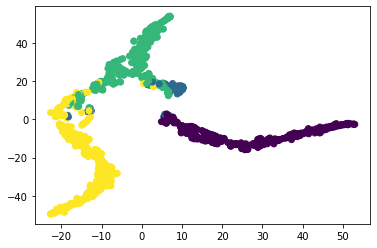

Epoch: 399, test_stats: 92.1000,test_stats: 0.1266 tensor([0.0154, 0.0341, 0.0348, 0.0423])
minimum 0.004966272


In [65]:
### In average the transfer MSE is 0.006
regressor = Regressor(dim=100,embedding = 100)
stats_regressor_FIERCE = torch.zeros(0,400,2)
train_acc_list,MSE_list = experiment_regression(regressor,net_FIERCE,train_loader,test_loader,epochs= 400,lr = 0.1)  
cat_elements = torch.stack([train_acc_list,MSE_list], dim = 1).unsqueeze(0)
stats_regressor_FIERCE = torch.cat([stats_regressor_FIERCE , cat_elements], dim = 0)

Epoch:   0, train_loss: 6.93014, train_acc: 0.8531, train_mse: 0.1404, test_mse: 0.1140 tensor([0.0182, 0.0473, 0.0345, 0.0140])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:   1, train_loss: 5.00606, train_acc: 0.8958, train_mse: 0.1034, test_mse: 0.0708 tensor([0.0081, 0.0473, 0.0072, 0.0082])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:   2, train_loss: 3.93378, train_acc: 0.9131, train_mse: 0.0794, test_mse: 0.0766 tensor([0.0045, 0.0473, 0.0072, 0.0176])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:   3, train_loss: 3.92574, train_acc: 0.9037, train_mse: 0.0822, test_mse: 0.0688 tensor([0.0049, 0.0473, 0.0111, 0.0056])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:   4, train_loss: 3.91690, train_acc: 0.9006, train_mse: 0.0788, test_mse: 0.0714 tensor([0.0038, 0.0473, 0.0078, 0.0125])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:   5, train_loss: 4.24285, train_acc: 0.8843, train_mse: 0.0860, test_mse: 0.0731 tensor([0.0063, 0.0473, 0.0134, 0.0061])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:   6, train_loss: 3.91937, train_acc: 0.9057, train_mse: 0.0792, test_mse: 0.0751 tensor([0.0044, 0.0473, 0.0054, 0.0181])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:   7, train_loss: 3.91271, train_acc: 0.9051, train_mse: 0.0793, test_mse: 0.0665 tensor([0.0054, 0.0473, 0.0067, 0.0071])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:   8, train_loss: 3.87761, train_acc: 0.9044, train_mse: 0.0783, test_mse: 0.0714 tensor([0.0065, 0.0473, 0.0147, 0.0029])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:   9, train_loss: 3.96206, train_acc: 0.9004, train_mse: 0.0799, test_mse: 0.0926 tensor([0.0108, 0.0473, 0.0292, 0.0053])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  10, train_loss: 4.50786, train_acc: 0.8733, train_mse: 0.0915, test_mse: 0.0837 tensor([0.0081, 0.0473, 0.0233, 0.0050])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  11, train_loss: 3.99467, train_acc: 0.8993, train_mse: 0.0832, test_mse: 0.0760 tensor([0.0052, 0.0473, 0.0070, 0.0165])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  12, train_loss: 4.12294, train_acc: 0.8785, train_mse: 0.0864, test_mse: 0.0707 tensor([0.0042, 0.0473, 0.0053, 0.0140])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  13, train_loss: 3.81203, train_acc: 0.9125, train_mse: 0.0771, test_mse: 0.0712 tensor([0.0115, 0.0473, 0.0052, 0.0072])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  14, train_loss: 3.85750, train_acc: 0.9034, train_mse: 0.0821, test_mse: 0.0685 tensor([0.0070, 0.0473, 0.0078, 0.0065])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  15, train_loss: 3.81668, train_acc: 0.9130, train_mse: 0.0775, test_mse: 0.0901 tensor([0.0049, 0.0473, 0.0083, 0.0297])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  16, train_loss: 4.36289, train_acc: 0.8593, train_mse: 0.0880, test_mse: 0.0704 tensor([0.0060, 0.0473, 0.0133, 0.0039])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  17, train_loss: 3.94419, train_acc: 0.8977, train_mse: 0.0801, test_mse: 0.0753 tensor([0.0092, 0.0473, 0.0062, 0.0126])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  18, train_loss: 4.03989, train_acc: 0.8858, train_mse: 0.0812, test_mse: 0.0743 tensor([0.0096, 0.0473, 0.0050, 0.0125])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  19, train_loss: 4.02463, train_acc: 0.8861, train_mse: 0.0811, test_mse: 0.0877 tensor([0.0074, 0.0473, 0.0081, 0.0250])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  20, train_loss: 3.96523, train_acc: 0.8998, train_mse: 0.0802, test_mse: 0.0769 tensor([0.0060, 0.0473, 0.0046, 0.0189])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  21, train_loss: 4.00461, train_acc: 0.8917, train_mse: 0.0826, test_mse: 0.0683 tensor([0.0051, 0.0473, 0.0106, 0.0053])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  22, train_loss: 3.85574, train_acc: 0.9049, train_mse: 0.0807, test_mse: 0.0673 tensor([0.0076, 0.0473, 0.0068, 0.0056])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  23, train_loss: 3.79682, train_acc: 0.9135, train_mse: 0.0809, test_mse: 0.0757 tensor([0.0069, 0.0473, 0.0118, 0.0097])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  24, train_loss: 4.12276, train_acc: 0.8882, train_mse: 0.0850, test_mse: 0.0808 tensor([0.0044, 0.0473, 0.0085, 0.0207])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  25, train_loss: 3.91020, train_acc: 0.9001, train_mse: 0.0805, test_mse: 0.0694 tensor([0.0072, 0.0473, 0.0049, 0.0100])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  26, train_loss: 3.83061, train_acc: 0.9086, train_mse: 0.0788, test_mse: 0.0737 tensor([0.0061, 0.0473, 0.0041, 0.0163])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  27, train_loss: 3.85013, train_acc: 0.9102, train_mse: 0.0778, test_mse: 0.0671 tensor([0.0052, 0.0473, 0.0091, 0.0055])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  28, train_loss: 4.09800, train_acc: 0.8916, train_mse: 0.0827, test_mse: 0.0760 tensor([0.0150, 0.0473, 0.0041, 0.0096])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  29, train_loss: 5.54170, train_acc: 0.8733, train_mse: 0.1127, test_mse: 0.1038 tensor([0.0251, 0.0473, 0.0285, 0.0029])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  30, train_loss: 6.13020, train_acc: 0.8547, train_mse: 0.1233, test_mse: 0.0821 tensor([0.0100, 0.0473, 0.0204, 0.0045])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  31, train_loss: 4.12479, train_acc: 0.8869, train_mse: 0.0836, test_mse: 0.0743 tensor([0.0094, 0.0473, 0.0052, 0.0125])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  32, train_loss: 3.85303, train_acc: 0.9008, train_mse: 0.0777, test_mse: 0.0708 tensor([0.0033, 0.0473, 0.0072, 0.0130])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  33, train_loss: 3.86712, train_acc: 0.9050, train_mse: 0.0798, test_mse: 0.0714 tensor([0.0100, 0.0473, 0.0073, 0.0069])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  34, train_loss: 3.96025, train_acc: 0.8943, train_mse: 0.0795, test_mse: 0.0669 tensor([0.0060, 0.0473, 0.0072, 0.0064])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  35, train_loss: 3.85247, train_acc: 0.9053, train_mse: 0.0780, test_mse: 0.0826 tensor([0.0140, 0.0473, 0.0082, 0.0131])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  36, train_loss: 4.41108, train_acc: 0.8848, train_mse: 0.0894, test_mse: 0.0693 tensor([0.0052, 0.0473, 0.0081, 0.0088])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  37, train_loss: 3.86392, train_acc: 0.9038, train_mse: 0.0783, test_mse: 0.0664 tensor([0.0055, 0.0473, 0.0074, 0.0062])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  38, train_loss: 3.92246, train_acc: 0.8989, train_mse: 0.0817, test_mse: 0.0702 tensor([0.0091, 0.0473, 0.0091, 0.0047])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  39, train_loss: 3.89135, train_acc: 0.8999, train_mse: 0.0813, test_mse: 0.0665 tensor([0.0055, 0.0473, 0.0075, 0.0062])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  40, train_loss: 3.77419, train_acc: 0.9186, train_mse: 0.0764, test_mse: 0.0958 tensor([0.0052, 0.0473, 0.0371, 0.0062])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  41, train_loss: 5.13136, train_acc: 0.8616, train_mse: 0.1075, test_mse: 0.1278 tensor([0.0130, 0.0473, 0.0216, 0.0460])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  42, train_loss: 5.20670, train_acc: 0.8521, train_mse: 0.1044, test_mse: 0.0963 tensor([0.0195, 0.0473, 0.0164, 0.0131])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  43, train_loss: 4.41923, train_acc: 0.8766, train_mse: 0.0917, test_mse: 0.0776 tensor([0.0112, 0.0473, 0.0162, 0.0030])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  44, train_loss: 4.33095, train_acc: 0.8785, train_mse: 0.0872, test_mse: 0.0816 tensor([0.0045, 0.0473, 0.0261, 0.0037])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  45, train_loss: 4.65953, train_acc: 0.8599, train_mse: 0.0938, test_mse: 0.0829 tensor([0.0037, 0.0473, 0.0125, 0.0195])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  46, train_loss: 3.94976, train_acc: 0.8994, train_mse: 0.0795, test_mse: 0.0663 tensor([0.0054, 0.0473, 0.0062, 0.0074])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  47, train_loss: 3.76688, train_acc: 0.9207, train_mse: 0.0760, test_mse: 0.0666 tensor([0.0042, 0.0473, 0.0067, 0.0085])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  48, train_loss: 3.78667, train_acc: 0.9194, train_mse: 0.0761, test_mse: 0.0665 tensor([0.0053, 0.0473, 0.0056, 0.0083])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  49, train_loss: 3.74709, train_acc: 0.9227, train_mse: 0.0757, test_mse: 0.0696 tensor([0.0049, 0.0473, 0.0046, 0.0128])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  50, train_loss: 3.77266, train_acc: 0.9175, train_mse: 0.0790, test_mse: 0.0675 tensor([0.0073, 0.0473, 0.0060, 0.0069])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  51, train_loss: 3.76725, train_acc: 0.9219, train_mse: 0.0760, test_mse: 0.0715 tensor([0.0119, 0.0473, 0.0059, 0.0064])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  52, train_loss: 3.84741, train_acc: 0.9092, train_mse: 0.0774, test_mse: 0.0664 tensor([0.0074, 0.0473, 0.0067, 0.0051])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  53, train_loss: 3.84216, train_acc: 0.9036, train_mse: 0.0839, test_mse: 0.0724 tensor([0.0071, 0.0473, 0.0155, 0.0025])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  54, train_loss: 5.02143, train_acc: 0.8698, train_mse: 0.1016, test_mse: 0.2910 tensor([0.1143, 0.0473, 0.1051, 0.0243])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  55, train_loss: 13.51230, train_acc: 0.8987, train_mse: 0.2756, test_mse: 0.2582 tensor([0.0250, 0.0473, 0.1059, 0.0800])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  56, train_loss: 13.79869, train_acc: 0.9207, train_mse: 0.2854, test_mse: 0.2554 tensor([0.0229, 0.0473, 0.1043, 0.0810])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  57, train_loss: 13.55031, train_acc: 0.9147, train_mse: 0.2749, test_mse: 0.2438 tensor([0.0234, 0.0473, 0.0935, 0.0796])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  58, train_loss: 10.49761, train_acc: 0.8476, train_mse: 0.2191, test_mse: 0.1322 tensor([0.0258, 0.0473, 0.0190, 0.0401])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  59, train_loss: 6.10742, train_acc: 0.8715, train_mse: 0.1262, test_mse: 0.1012 tensor([0.0140, 0.0473, 0.0236, 0.0163])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  60, train_loss: 5.99284, train_acc: 0.8732, train_mse: 0.1211, test_mse: 0.1255 tensor([0.0290, 0.0473, 0.0207, 0.0285])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  61, train_loss: 6.52051, train_acc: 0.8776, train_mse: 0.1341, test_mse: 0.1124 tensor([0.0227, 0.0473, 0.0155, 0.0269])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  62, train_loss: 4.76786, train_acc: 0.8929, train_mse: 0.0964, test_mse: 0.0998 tensor([0.0120, 0.0473, 0.0084, 0.0322])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  63, train_loss: 4.41776, train_acc: 0.8858, train_mse: 0.0896, test_mse: 0.1142 tensor([0.0050, 0.0473, 0.0528, 0.0091])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  64, train_loss: 5.34959, train_acc: 0.8505, train_mse: 0.1081, test_mse: 0.0751 tensor([0.0074, 0.0473, 0.0167, 0.0038])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  65, train_loss: 4.20383, train_acc: 0.8792, train_mse: 0.0877, test_mse: 0.0704 tensor([0.0076, 0.0473, 0.0082, 0.0073])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  66, train_loss: 3.80636, train_acc: 0.9173, train_mse: 0.0768, test_mse: 0.0662 tensor([0.0042, 0.0473, 0.0069, 0.0078])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  67, train_loss: 3.79720, train_acc: 0.9161, train_mse: 0.0795, test_mse: 0.0738 tensor([0.0062, 0.0473, 0.0169, 0.0034])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  68, train_loss: 4.94923, train_acc: 0.8736, train_mse: 0.1000, test_mse: 0.0774 tensor([0.0057, 0.0473, 0.0174, 0.0071])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  69, train_loss: 3.98233, train_acc: 0.8922, train_mse: 0.0801, test_mse: 0.0735 tensor([0.0131, 0.0473, 0.0062, 0.0070])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  70, train_loss: 3.89699, train_acc: 0.9000, train_mse: 0.0788, test_mse: 0.0723 tensor([0.0114, 0.0473, 0.0096, 0.0041])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  71, train_loss: 3.83660, train_acc: 0.9108, train_mse: 0.0769, test_mse: 0.0687 tensor([0.0045, 0.0473, 0.0133, 0.0037])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  72, train_loss: 3.82778, train_acc: 0.9086, train_mse: 0.0809, test_mse: 0.0657 tensor([0.0046, 0.0473, 0.0082, 0.0057])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  73, train_loss: 3.77204, train_acc: 0.9208, train_mse: 0.0760, test_mse: 0.0665 tensor([0.0072, 0.0473, 0.0048, 0.0072])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  74, train_loss: 3.80422, train_acc: 0.9172, train_mse: 0.0767, test_mse: 0.0807 tensor([0.0066, 0.0473, 0.0062, 0.0206])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  75, train_loss: 4.11812, train_acc: 0.8863, train_mse: 0.0864, test_mse: 0.0670 tensor([0.0074, 0.0473, 0.0067, 0.0057])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  76, train_loss: 3.78190, train_acc: 0.9181, train_mse: 0.0762, test_mse: 0.0666 tensor([0.0053, 0.0473, 0.0102, 0.0038])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  77, train_loss: 3.90252, train_acc: 0.8953, train_mse: 0.0801, test_mse: 0.0701 tensor([0.0044, 0.0473, 0.0149, 0.0035])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  78, train_loss: 3.77570, train_acc: 0.9241, train_mse: 0.0762, test_mse: 0.0664 tensor([0.0063, 0.0473, 0.0075, 0.0054])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  79, train_loss: 3.78085, train_acc: 0.9192, train_mse: 0.0800, test_mse: 0.0689 tensor([0.0056, 0.0473, 0.0047, 0.0113])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  80, train_loss: 3.83134, train_acc: 0.9095, train_mse: 0.0770, test_mse: 0.0663 tensor([0.0057, 0.0473, 0.0081, 0.0053])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  81, train_loss: 3.75495, train_acc: 0.9193, train_mse: 0.0758, test_mse: 0.0679 tensor([0.0055, 0.0473, 0.0055, 0.0097])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  82, train_loss: 3.84567, train_acc: 0.9059, train_mse: 0.0808, test_mse: 0.0718 tensor([0.0044, 0.0473, 0.0169, 0.0032])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  83, train_loss: 4.99366, train_acc: 0.8635, train_mse: 0.1018, test_mse: 0.1073 tensor([0.0090, 0.0473, 0.0105, 0.0406])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  84, train_loss: 6.57393, train_acc: 0.8390, train_mse: 0.1329, test_mse: 0.1514 tensor([0.0262, 0.0473, 0.0263, 0.0517])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  85, train_loss: 6.22738, train_acc: 0.8689, train_mse: 0.1272, test_mse: 0.0965 tensor([0.0134, 0.0473, 0.0161, 0.0197])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  86, train_loss: 4.46705, train_acc: 0.8848, train_mse: 0.0905, test_mse: 0.0754 tensor([0.0055, 0.0473, 0.0092, 0.0134])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  87, train_loss: 3.86932, train_acc: 0.9092, train_mse: 0.0784, test_mse: 0.0683 tensor([0.0048, 0.0473, 0.0121, 0.0041])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  88, train_loss: 3.80918, train_acc: 0.9117, train_mse: 0.0769, test_mse: 0.0663 tensor([0.0049, 0.0473, 0.0058, 0.0084])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  89, train_loss: 3.77138, train_acc: 0.9198, train_mse: 0.0793, test_mse: 0.0779 tensor([0.0041, 0.0473, 0.0049, 0.0216])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  90, train_loss: 3.91837, train_acc: 0.8995, train_mse: 0.0789, test_mse: 0.0825 tensor([0.0129, 0.0473, 0.0172, 0.0051])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  91, train_loss: 4.88556, train_acc: 0.8660, train_mse: 0.1016, test_mse: 0.0738 tensor([0.0084, 0.0473, 0.0075, 0.0107])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  92, train_loss: 3.99057, train_acc: 0.8865, train_mse: 0.0837, test_mse: 0.0683 tensor([0.0041, 0.0473, 0.0105, 0.0064])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  93, train_loss: 3.84595, train_acc: 0.9091, train_mse: 0.0776, test_mse: 0.0669 tensor([0.0057, 0.0473, 0.0062, 0.0077])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  94, train_loss: 3.82902, train_acc: 0.9110, train_mse: 0.0776, test_mse: 0.0737 tensor([0.0059, 0.0473, 0.0047, 0.0157])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  95, train_loss: 3.80949, train_acc: 0.9118, train_mse: 0.0799, test_mse: 0.0667 tensor([0.0050, 0.0473, 0.0059, 0.0085])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  96, train_loss: 3.80250, train_acc: 0.9144, train_mse: 0.0799, test_mse: 0.0729 tensor([0.0045, 0.0473, 0.0095, 0.0116])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  97, train_loss: 3.88960, train_acc: 0.8995, train_mse: 0.0786, test_mse: 0.0668 tensor([0.0048, 0.0473, 0.0102, 0.0046])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  98, train_loss: 3.76987, train_acc: 0.9167, train_mse: 0.0760, test_mse: 0.0687 tensor([0.0048, 0.0473, 0.0119, 0.0048])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  99, train_loss: 3.80737, train_acc: 0.9194, train_mse: 0.0769, test_mse: 0.0698 tensor([0.0054, 0.0473, 0.0046, 0.0125])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 100, train_loss: 3.74521, train_acc: 0.9218, train_mse: 0.0753, test_mse: 0.0654 tensor([0.0054, 0.0473, 0.0072, 0.0056])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 101, train_loss: 3.72150, train_acc: 0.9309, train_mse: 0.0748, test_mse: 0.0654 tensor([0.0055, 0.0473, 0.0073, 0.0054])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 102, train_loss: 3.72124, train_acc: 0.9297, train_mse: 0.0749, test_mse: 0.0654 tensor([0.0054, 0.0473, 0.0069, 0.0058])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 103, train_loss: 3.72079, train_acc: 0.9235, train_mse: 0.0786, test_mse: 0.0655 tensor([0.0053, 0.0473, 0.0074, 0.0056])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 104, train_loss: 3.72381, train_acc: 0.9315, train_mse: 0.0746, test_mse: 0.0654 tensor([0.0055, 0.0473, 0.0069, 0.0058])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 105, train_loss: 3.72357, train_acc: 0.9313, train_mse: 0.0748, test_mse: 0.0654 tensor([0.0054, 0.0473, 0.0068, 0.0059])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 106, train_loss: 3.72180, train_acc: 0.9265, train_mse: 0.0780, test_mse: 0.0655 tensor([0.0056, 0.0473, 0.0077, 0.0049])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 107, train_loss: 3.72235, train_acc: 0.9323, train_mse: 0.0747, test_mse: 0.0654 tensor([0.0051, 0.0473, 0.0075, 0.0056])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 108, train_loss: 3.72202, train_acc: 0.9283, train_mse: 0.0786, test_mse: 0.0655 tensor([0.0055, 0.0473, 0.0076, 0.0051])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 109, train_loss: 3.72938, train_acc: 0.9283, train_mse: 0.0764, test_mse: 0.0654 tensor([0.0056, 0.0473, 0.0070, 0.0055])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 110, train_loss: 3.72086, train_acc: 0.9289, train_mse: 0.0757, test_mse: 0.0654 tensor([0.0056, 0.0473, 0.0066, 0.0059])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 111, train_loss: 3.72172, train_acc: 0.9282, train_mse: 0.0761, test_mse: 0.0654 tensor([0.0054, 0.0473, 0.0072, 0.0056])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 112, train_loss: 3.72186, train_acc: 0.9256, train_mse: 0.0782, test_mse: 0.0654 tensor([0.0054, 0.0473, 0.0069, 0.0057])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 113, train_loss: 3.72195, train_acc: 0.9323, train_mse: 0.0750, test_mse: 0.0655 tensor([0.0057, 0.0473, 0.0074, 0.0051])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 114, train_loss: 3.72187, train_acc: 0.9319, train_mse: 0.0753, test_mse: 0.0654 tensor([0.0058, 0.0473, 0.0070, 0.0053])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 115, train_loss: 3.72246, train_acc: 0.9290, train_mse: 0.0750, test_mse: 0.0658 tensor([0.0053, 0.0473, 0.0058, 0.0075])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 116, train_loss: 3.72648, train_acc: 0.9287, train_mse: 0.0751, test_mse: 0.0654 tensor([0.0057, 0.0473, 0.0066, 0.0059])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 117, train_loss: 3.72281, train_acc: 0.9306, train_mse: 0.0747, test_mse: 0.0655 tensor([0.0056, 0.0473, 0.0062, 0.0064])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 118, train_loss: 3.72350, train_acc: 0.9304, train_mse: 0.0752, test_mse: 0.0654 tensor([0.0054, 0.0473, 0.0067, 0.0061])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 119, train_loss: 3.72199, train_acc: 0.9281, train_mse: 0.0759, test_mse: 0.0654 tensor([0.0050, 0.0473, 0.0071, 0.0061])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 120, train_loss: 3.72235, train_acc: 0.9299, train_mse: 0.0759, test_mse: 0.0658 tensor([0.0056, 0.0473, 0.0058, 0.0071])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 121, train_loss: 3.72587, train_acc: 0.9285, train_mse: 0.0752, test_mse: 0.0655 tensor([0.0052, 0.0473, 0.0064, 0.0067])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 122, train_loss: 3.72652, train_acc: 0.9253, train_mse: 0.0791, test_mse: 0.0655 tensor([0.0060, 0.0473, 0.0064, 0.0058])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 123, train_loss: 3.72264, train_acc: 0.9320, train_mse: 0.0749, test_mse: 0.0660 tensor([0.0049, 0.0473, 0.0083, 0.0056])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 124, train_loss: 3.72775, train_acc: 0.9314, train_mse: 0.0747, test_mse: 0.0654 tensor([0.0057, 0.0473, 0.0064, 0.0061])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 125, train_loss: 3.72336, train_acc: 0.9317, train_mse: 0.0750, test_mse: 0.0654 tensor([0.0053, 0.0473, 0.0068, 0.0060])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 126, train_loss: 3.72370, train_acc: 0.9297, train_mse: 0.0753, test_mse: 0.0654 tensor([0.0059, 0.0473, 0.0067, 0.0055])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 127, train_loss: 3.72297, train_acc: 0.9318, train_mse: 0.0751, test_mse: 0.0656 tensor([0.0052, 0.0473, 0.0067, 0.0064])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 128, train_loss: 3.72141, train_acc: 0.9314, train_mse: 0.0752, test_mse: 0.0655 tensor([0.0055, 0.0473, 0.0068, 0.0059])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 129, train_loss: 3.72145, train_acc: 0.9312, train_mse: 0.0748, test_mse: 0.0654 tensor([0.0053, 0.0473, 0.0069, 0.0060])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 130, train_loss: 3.72193, train_acc: 0.9306, train_mse: 0.0747, test_mse: 0.0654 tensor([0.0055, 0.0473, 0.0069, 0.0058])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 131, train_loss: 3.72191, train_acc: 0.9297, train_mse: 0.0754, test_mse: 0.0654 tensor([0.0056, 0.0473, 0.0064, 0.0062])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 132, train_loss: 3.72297, train_acc: 0.9307, train_mse: 0.0756, test_mse: 0.0656 tensor([0.0061, 0.0473, 0.0058, 0.0065])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 133, train_loss: 3.72225, train_acc: 0.9293, train_mse: 0.0781, test_mse: 0.0655 tensor([0.0059, 0.0473, 0.0067, 0.0057])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 134, train_loss: 3.72706, train_acc: 0.9280, train_mse: 0.0780, test_mse: 0.0656 tensor([0.0051, 0.0473, 0.0073, 0.0059])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 135, train_loss: 3.72383, train_acc: 0.9282, train_mse: 0.0785, test_mse: 0.0655 tensor([0.0053, 0.0473, 0.0063, 0.0066])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 136, train_loss: 3.72843, train_acc: 0.9230, train_mse: 0.0793, test_mse: 0.0657 tensor([0.0052, 0.0473, 0.0084, 0.0049])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 137, train_loss: 3.73344, train_acc: 0.9265, train_mse: 0.0751, test_mse: 0.0660 tensor([0.0064, 0.0473, 0.0062, 0.0061])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 138, train_loss: 3.72418, train_acc: 0.9299, train_mse: 0.0751, test_mse: 0.0654 tensor([0.0053, 0.0473, 0.0071, 0.0057])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 139, train_loss: 3.72100, train_acc: 0.9281, train_mse: 0.0779, test_mse: 0.0654 tensor([0.0058, 0.0473, 0.0070, 0.0053])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 140, train_loss: 3.72330, train_acc: 0.9285, train_mse: 0.0786, test_mse: 0.0658 tensor([0.0054, 0.0473, 0.0059, 0.0073])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 141, train_loss: 3.72841, train_acc: 0.9271, train_mse: 0.0756, test_mse: 0.0654 tensor([0.0058, 0.0473, 0.0063, 0.0060])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 142, train_loss: 3.72123, train_acc: 0.9289, train_mse: 0.0781, test_mse: 0.0655 tensor([0.0054, 0.0473, 0.0064, 0.0065])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 143, train_loss: 3.72272, train_acc: 0.9291, train_mse: 0.0770, test_mse: 0.0654 tensor([0.0053, 0.0473, 0.0075, 0.0053])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 144, train_loss: 3.72264, train_acc: 0.9296, train_mse: 0.0753, test_mse: 0.0654 tensor([0.0051, 0.0473, 0.0067, 0.0063])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 145, train_loss: 3.72157, train_acc: 0.9315, train_mse: 0.0750, test_mse: 0.0654 tensor([0.0056, 0.0473, 0.0064, 0.0061])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 146, train_loss: 3.72362, train_acc: 0.9307, train_mse: 0.0750, test_mse: 0.0654 tensor([0.0060, 0.0473, 0.0067, 0.0055])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 147, train_loss: 3.72175, train_acc: 0.9319, train_mse: 0.0751, test_mse: 0.0655 tensor([0.0050, 0.0473, 0.0074, 0.0058])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 148, train_loss: 3.72335, train_acc: 0.9271, train_mse: 0.0803, test_mse: 0.0654 tensor([0.0055, 0.0473, 0.0067, 0.0059])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 149, train_loss: 3.72240, train_acc: 0.9276, train_mse: 0.0790, test_mse: 0.0677 tensor([0.0054, 0.0473, 0.0117, 0.0033])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 150, train_loss: 3.76423, train_acc: 0.9230, train_mse: 0.0769, test_mse: 0.0656 tensor([0.0048, 0.0473, 0.0065, 0.0071])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 151, train_loss: 3.72621, train_acc: 0.9239, train_mse: 0.0783, test_mse: 0.0678 tensor([0.0055, 0.0473, 0.0117, 0.0033])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 152, train_loss: 3.74503, train_acc: 0.9228, train_mse: 0.0756, test_mse: 0.0656 tensor([0.0048, 0.0473, 0.0068, 0.0067])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 153, train_loss: 3.72780, train_acc: 0.9301, train_mse: 0.0751, test_mse: 0.0658 tensor([0.0062, 0.0473, 0.0055, 0.0068])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 154, train_loss: 3.72494, train_acc: 0.9260, train_mse: 0.0762, test_mse: 0.0655 tensor([0.0059, 0.0473, 0.0063, 0.0060])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 155, train_loss: 3.72389, train_acc: 0.9302, train_mse: 0.0749, test_mse: 0.0656 tensor([0.0064, 0.0473, 0.0066, 0.0053])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 156, train_loss: 3.72401, train_acc: 0.9277, train_mse: 0.0759, test_mse: 0.0657 tensor([0.0058, 0.0473, 0.0057, 0.0069])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 157, train_loss: 3.72694, train_acc: 0.9258, train_mse: 0.0753, test_mse: 0.0654 tensor([0.0052, 0.0473, 0.0068, 0.0061])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 158, train_loss: 3.72150, train_acc: 0.9291, train_mse: 0.0752, test_mse: 0.0657 tensor([0.0054, 0.0473, 0.0084, 0.0047])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 159, train_loss: 3.72485, train_acc: 0.9292, train_mse: 0.0753, test_mse: 0.0654 tensor([0.0056, 0.0473, 0.0070, 0.0056])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 160, train_loss: 3.72446, train_acc: 0.9282, train_mse: 0.0766, test_mse: 0.0662 tensor([0.0044, 0.0473, 0.0088, 0.0057])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 161, train_loss: 3.72854, train_acc: 0.9268, train_mse: 0.0753, test_mse: 0.0654 tensor([0.0058, 0.0473, 0.0060, 0.0063])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 162, train_loss: 3.72315, train_acc: 0.9301, train_mse: 0.0747, test_mse: 0.0654 tensor([0.0055, 0.0473, 0.0068, 0.0058])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 163, train_loss: 3.72372, train_acc: 0.9282, train_mse: 0.0771, test_mse: 0.0656 tensor([0.0049, 0.0473, 0.0065, 0.0069])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 164, train_loss: 3.72557, train_acc: 0.9285, train_mse: 0.0749, test_mse: 0.0655 tensor([0.0060, 0.0473, 0.0059, 0.0063])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 165, train_loss: 3.72931, train_acc: 0.9226, train_mse: 0.0753, test_mse: 0.0656 tensor([0.0048, 0.0473, 0.0083, 0.0053])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 166, train_loss: 3.72653, train_acc: 0.9319, train_mse: 0.0755, test_mse: 0.0654 tensor([0.0055, 0.0473, 0.0066, 0.0060])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 167, train_loss: 3.72369, train_acc: 0.9279, train_mse: 0.0782, test_mse: 0.0659 tensor([0.0070, 0.0473, 0.0060, 0.0057])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 168, train_loss: 3.72855, train_acc: 0.9321, train_mse: 0.0752, test_mse: 0.0654 tensor([0.0059, 0.0473, 0.0068, 0.0055])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 169, train_loss: 3.72338, train_acc: 0.9307, train_mse: 0.0757, test_mse: 0.0714 tensor([0.0057, 0.0473, 0.0151, 0.0033])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 170, train_loss: 3.78391, train_acc: 0.9122, train_mse: 0.0767, test_mse: 0.0655 tensor([0.0054, 0.0473, 0.0076, 0.0052])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 171, train_loss: 3.72734, train_acc: 0.9237, train_mse: 0.0749, test_mse: 0.0656 tensor([0.0060, 0.0473, 0.0067, 0.0056])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 172, train_loss: 3.72497, train_acc: 0.9229, train_mse: 0.0773, test_mse: 0.0660 tensor([0.0058, 0.0473, 0.0090, 0.0039])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 173, train_loss: 3.72935, train_acc: 0.9296, train_mse: 0.0750, test_mse: 0.0654 tensor([0.0051, 0.0473, 0.0075, 0.0055])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 174, train_loss: 3.72043, train_acc: 0.9294, train_mse: 0.0750, test_mse: 0.0655 tensor([0.0054, 0.0473, 0.0062, 0.0066])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 175, train_loss: 3.72135, train_acc: 0.9294, train_mse: 0.0747, test_mse: 0.0662 tensor([0.0047, 0.0473, 0.0097, 0.0045])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 176, train_loss: 3.73196, train_acc: 0.9236, train_mse: 0.0789, test_mse: 0.0658 tensor([0.0051, 0.0473, 0.0071, 0.0063])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 177, train_loss: 3.72453, train_acc: 0.9276, train_mse: 0.0776, test_mse: 0.0671 tensor([0.0072, 0.0473, 0.0051, 0.0076])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 178, train_loss: 3.74475, train_acc: 0.9225, train_mse: 0.0768, test_mse: 0.0698 tensor([0.0044, 0.0473, 0.0150, 0.0032])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 179, train_loss: 3.77764, train_acc: 0.9216, train_mse: 0.0758, test_mse: 0.0658 tensor([0.0066, 0.0473, 0.0074, 0.0045])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 180, train_loss: 3.72400, train_acc: 0.9268, train_mse: 0.0761, test_mse: 0.0668 tensor([0.0057, 0.0473, 0.0048, 0.0090])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 181, train_loss: 3.73573, train_acc: 0.9246, train_mse: 0.0752, test_mse: 0.0657 tensor([0.0068, 0.0473, 0.0060, 0.0057])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 182, train_loss: 3.72234, train_acc: 0.9305, train_mse: 0.0754, test_mse: 0.0657 tensor([0.0066, 0.0473, 0.0062, 0.0055])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 183, train_loss: 3.72575, train_acc: 0.9293, train_mse: 0.0763, test_mse: 0.0657 tensor([0.0054, 0.0473, 0.0082, 0.0048])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 184, train_loss: 3.72419, train_acc: 0.9287, train_mse: 0.0753, test_mse: 0.0654 tensor([0.0060, 0.0473, 0.0061, 0.0060])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 185, train_loss: 3.72284, train_acc: 0.9321, train_mse: 0.0749, test_mse: 0.0672 tensor([0.0055, 0.0473, 0.0112, 0.0033])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 186, train_loss: 3.73574, train_acc: 0.9269, train_mse: 0.0762, test_mse: 0.0654 tensor([0.0059, 0.0473, 0.0065, 0.0057])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 187, train_loss: 3.72118, train_acc: 0.9312, train_mse: 0.0750, test_mse: 0.0654 tensor([0.0059, 0.0473, 0.0063, 0.0059])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 188, train_loss: 3.72102, train_acc: 0.9270, train_mse: 0.0786, test_mse: 0.0657 tensor([0.0050, 0.0473, 0.0088, 0.0047])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 189, train_loss: 3.72135, train_acc: 0.9284, train_mse: 0.0785, test_mse: 0.0654 tensor([0.0055, 0.0473, 0.0069, 0.0057])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 190, train_loss: 3.72265, train_acc: 0.9261, train_mse: 0.0757, test_mse: 0.0653 tensor([0.0054, 0.0473, 0.0072, 0.0054])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 191, train_loss: 3.72057, train_acc: 0.9305, train_mse: 0.0749, test_mse: 0.0656 tensor([0.0048, 0.0473, 0.0083, 0.0053])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 192, train_loss: 3.72668, train_acc: 0.9264, train_mse: 0.0779, test_mse: 0.0657 tensor([0.0068, 0.0473, 0.0065, 0.0052])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 193, train_loss: 3.72809, train_acc: 0.9303, train_mse: 0.0751, test_mse: 0.0656 tensor([0.0055, 0.0473, 0.0057, 0.0071])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 194, train_loss: 3.72838, train_acc: 0.9223, train_mse: 0.0798, test_mse: 0.0674 tensor([0.0045, 0.0473, 0.0103, 0.0053])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 195, train_loss: 3.73787, train_acc: 0.9271, train_mse: 0.0756, test_mse: 0.0656 tensor([0.0061, 0.0473, 0.0060, 0.0063])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 196, train_loss: 3.72245, train_acc: 0.9276, train_mse: 0.0756, test_mse: 0.0653 tensor([0.0056, 0.0473, 0.0068, 0.0056])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 197, train_loss: 3.72362, train_acc: 0.9281, train_mse: 0.0783, test_mse: 0.0655 tensor([0.0061, 0.0473, 0.0061, 0.0061])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 198, train_loss: 3.71921, train_acc: 0.9304, train_mse: 0.0750, test_mse: 0.0657 tensor([0.0050, 0.0473, 0.0084, 0.0050])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 199, train_loss: 3.72399, train_acc: 0.9265, train_mse: 0.0776, test_mse: 0.0665 tensor([0.0051, 0.0473, 0.0102, 0.0040])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 200, train_loss: 3.72538, train_acc: 0.9291, train_mse: 0.0754, test_mse: 0.0653 tensor([0.0055, 0.0473, 0.0066, 0.0060])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 201, train_loss: 3.71635, train_acc: 0.9285, train_mse: 0.0746, test_mse: 0.0653 tensor([0.0055, 0.0473, 0.0064, 0.0061])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 202, train_loss: 3.71624, train_acc: 0.9317, train_mse: 0.0747, test_mse: 0.0653 tensor([0.0055, 0.0473, 0.0070, 0.0055])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 203, train_loss: 3.71630, train_acc: 0.9331, train_mse: 0.0749, test_mse: 0.0653 tensor([0.0056, 0.0473, 0.0065, 0.0060])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 204, train_loss: 3.71625, train_acc: 0.9314, train_mse: 0.0748, test_mse: 0.0653 tensor([0.0056, 0.0473, 0.0065, 0.0059])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 205, train_loss: 3.71596, train_acc: 0.9274, train_mse: 0.0771, test_mse: 0.0653 tensor([0.0056, 0.0473, 0.0065, 0.0059])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 206, train_loss: 3.71623, train_acc: 0.9313, train_mse: 0.0751, test_mse: 0.0653 tensor([0.0055, 0.0473, 0.0067, 0.0059])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 207, train_loss: 3.71676, train_acc: 0.9313, train_mse: 0.0776, test_mse: 0.0653 tensor([0.0057, 0.0473, 0.0067, 0.0057])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 208, train_loss: 3.71669, train_acc: 0.9294, train_mse: 0.0762, test_mse: 0.0653 tensor([0.0056, 0.0473, 0.0066, 0.0059])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 209, train_loss: 3.71671, train_acc: 0.9329, train_mse: 0.0749, test_mse: 0.0653 tensor([0.0058, 0.0473, 0.0065, 0.0057])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 210, train_loss: 3.71595, train_acc: 0.9324, train_mse: 0.0748, test_mse: 0.0653 tensor([0.0053, 0.0473, 0.0071, 0.0056])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 211, train_loss: 3.71688, train_acc: 0.9324, train_mse: 0.0746, test_mse: 0.0653 tensor([0.0054, 0.0473, 0.0068, 0.0058])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 212, train_loss: 3.71664, train_acc: 0.9336, train_mse: 0.0750, test_mse: 0.0653 tensor([0.0054, 0.0473, 0.0068, 0.0057])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 213, train_loss: 3.71676, train_acc: 0.9300, train_mse: 0.0749, test_mse: 0.0653 tensor([0.0056, 0.0473, 0.0070, 0.0054])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 214, train_loss: 3.71617, train_acc: 0.9328, train_mse: 0.0749, test_mse: 0.0653 tensor([0.0055, 0.0473, 0.0070, 0.0055])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 215, train_loss: 3.71617, train_acc: 0.9230, train_mse: 0.0846, test_mse: 0.0653 tensor([0.0054, 0.0473, 0.0068, 0.0058])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 216, train_loss: 3.71693, train_acc: 0.9330, train_mse: 0.0753, test_mse: 0.0653 tensor([0.0055, 0.0473, 0.0067, 0.0058])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 217, train_loss: 3.71588, train_acc: 0.9326, train_mse: 0.0751, test_mse: 0.0653 tensor([0.0055, 0.0473, 0.0067, 0.0059])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 218, train_loss: 3.71643, train_acc: 0.9328, train_mse: 0.0751, test_mse: 0.0653 tensor([0.0055, 0.0473, 0.0066, 0.0059])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 219, train_loss: 3.71615, train_acc: 0.9293, train_mse: 0.0778, test_mse: 0.0653 tensor([0.0055, 0.0473, 0.0069, 0.0056])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 220, train_loss: 3.71617, train_acc: 0.9299, train_mse: 0.0751, test_mse: 0.0653 tensor([0.0053, 0.0473, 0.0067, 0.0060])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 221, train_loss: 3.71590, train_acc: 0.9327, train_mse: 0.0747, test_mse: 0.0653 tensor([0.0055, 0.0473, 0.0065, 0.0060])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 222, train_loss: 3.71632, train_acc: 0.9274, train_mse: 0.0777, test_mse: 0.0654 tensor([0.0054, 0.0473, 0.0077, 0.0050])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 223, train_loss: 3.72651, train_acc: 0.9298, train_mse: 0.0750, test_mse: 0.0653 tensor([0.0054, 0.0473, 0.0067, 0.0059])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 224, train_loss: 3.71659, train_acc: 0.9324, train_mse: 0.0745, test_mse: 0.0654 tensor([0.0056, 0.0473, 0.0062, 0.0063])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 225, train_loss: 3.71627, train_acc: 0.9309, train_mse: 0.0749, test_mse: 0.0653 tensor([0.0058, 0.0473, 0.0066, 0.0056])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 226, train_loss: 3.71638, train_acc: 0.9319, train_mse: 0.0749, test_mse: 0.0653 tensor([0.0054, 0.0473, 0.0070, 0.0056])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 227, train_loss: 3.71634, train_acc: 0.9329, train_mse: 0.0749, test_mse: 0.0654 tensor([0.0057, 0.0473, 0.0061, 0.0064])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 228, train_loss: 3.71725, train_acc: 0.9317, train_mse: 0.0754, test_mse: 0.0653 tensor([0.0056, 0.0473, 0.0067, 0.0057])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 229, train_loss: 3.71623, train_acc: 0.9296, train_mse: 0.0783, test_mse: 0.0653 tensor([0.0056, 0.0473, 0.0064, 0.0061])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 230, train_loss: 3.71656, train_acc: 0.9294, train_mse: 0.0775, test_mse: 0.0653 tensor([0.0056, 0.0473, 0.0065, 0.0059])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 231, train_loss: 3.71596, train_acc: 0.9320, train_mse: 0.0755, test_mse: 0.0653 tensor([0.0055, 0.0473, 0.0072, 0.0054])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 232, train_loss: 3.71799, train_acc: 0.9305, train_mse: 0.0751, test_mse: 0.0653 tensor([0.0053, 0.0473, 0.0069, 0.0058])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 233, train_loss: 3.71669, train_acc: 0.9308, train_mse: 0.0748, test_mse: 0.0653 tensor([0.0057, 0.0473, 0.0065, 0.0057])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 234, train_loss: 3.71607, train_acc: 0.9318, train_mse: 0.0749, test_mse: 0.0653 tensor([0.0055, 0.0473, 0.0068, 0.0057])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 235, train_loss: 3.71626, train_acc: 0.9268, train_mse: 0.0753, test_mse: 0.0653 tensor([0.0056, 0.0473, 0.0066, 0.0059])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 236, train_loss: 3.71651, train_acc: 0.9320, train_mse: 0.0747, test_mse: 0.0653 tensor([0.0054, 0.0473, 0.0071, 0.0055])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 237, train_loss: 3.71744, train_acc: 0.9290, train_mse: 0.0783, test_mse: 0.0653 tensor([0.0056, 0.0473, 0.0066, 0.0058])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 238, train_loss: 3.71629, train_acc: 0.9297, train_mse: 0.0781, test_mse: 0.0653 tensor([0.0054, 0.0473, 0.0075, 0.0052])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 239, train_loss: 3.71737, train_acc: 0.9332, train_mse: 0.0749, test_mse: 0.0653 tensor([0.0055, 0.0473, 0.0068, 0.0057])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 240, train_loss: 3.71600, train_acc: 0.9300, train_mse: 0.0754, test_mse: 0.0653 tensor([0.0053, 0.0473, 0.0067, 0.0061])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 241, train_loss: 3.71620, train_acc: 0.9315, train_mse: 0.0751, test_mse: 0.0653 tensor([0.0055, 0.0473, 0.0067, 0.0058])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 242, train_loss: 3.71584, train_acc: 0.9317, train_mse: 0.0747, test_mse: 0.0653 tensor([0.0055, 0.0473, 0.0068, 0.0057])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 243, train_loss: 3.71609, train_acc: 0.9296, train_mse: 0.0781, test_mse: 0.0653 tensor([0.0055, 0.0473, 0.0066, 0.0059])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 244, train_loss: 3.71608, train_acc: 0.9301, train_mse: 0.0749, test_mse: 0.0653 tensor([0.0055, 0.0473, 0.0065, 0.0060])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 245, train_loss: 3.71604, train_acc: 0.9276, train_mse: 0.0748, test_mse: 0.0653 tensor([0.0053, 0.0473, 0.0069, 0.0058])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 246, train_loss: 3.71631, train_acc: 0.9302, train_mse: 0.0760, test_mse: 0.0653 tensor([0.0053, 0.0473, 0.0070, 0.0057])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 247, train_loss: 3.71555, train_acc: 0.9298, train_mse: 0.0758, test_mse: 0.0653 tensor([0.0054, 0.0473, 0.0065, 0.0061])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 248, train_loss: 3.71598, train_acc: 0.9315, train_mse: 0.0746, test_mse: 0.0653 tensor([0.0055, 0.0473, 0.0071, 0.0054])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 249, train_loss: 3.71588, train_acc: 0.9274, train_mse: 0.0762, test_mse: 0.0653 tensor([0.0056, 0.0473, 0.0068, 0.0056])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 250, train_loss: 3.71712, train_acc: 0.9294, train_mse: 0.0784, test_mse: 0.0653 tensor([0.0053, 0.0473, 0.0068, 0.0059])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 251, train_loss: 3.71711, train_acc: 0.9328, train_mse: 0.0750, test_mse: 0.0653 tensor([0.0053, 0.0473, 0.0071, 0.0057])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 252, train_loss: 3.71675, train_acc: 0.9325, train_mse: 0.0751, test_mse: 0.0653 tensor([0.0054, 0.0473, 0.0068, 0.0058])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 253, train_loss: 3.71605, train_acc: 0.9321, train_mse: 0.0749, test_mse: 0.0653 tensor([0.0055, 0.0473, 0.0064, 0.0062])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 254, train_loss: 3.71589, train_acc: 0.9320, train_mse: 0.0754, test_mse: 0.0653 tensor([0.0054, 0.0473, 0.0074, 0.0052])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 255, train_loss: 3.71905, train_acc: 0.9325, train_mse: 0.0749, test_mse: 0.0653 tensor([0.0055, 0.0473, 0.0072, 0.0053])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 256, train_loss: 3.71662, train_acc: 0.9298, train_mse: 0.0755, test_mse: 0.0653 tensor([0.0054, 0.0473, 0.0064, 0.0062])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 257, train_loss: 3.71781, train_acc: 0.9263, train_mse: 0.0816, test_mse: 0.0653 tensor([0.0057, 0.0473, 0.0064, 0.0059])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 258, train_loss: 3.71766, train_acc: 0.9298, train_mse: 0.0776, test_mse: 0.0653 tensor([0.0055, 0.0473, 0.0070, 0.0055])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 259, train_loss: 3.71600, train_acc: 0.9302, train_mse: 0.0784, test_mse: 0.0653 tensor([0.0056, 0.0473, 0.0063, 0.0062])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 260, train_loss: 3.71721, train_acc: 0.9306, train_mse: 0.0750, test_mse: 0.0653 tensor([0.0057, 0.0473, 0.0066, 0.0058])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 261, train_loss: 3.71618, train_acc: 0.9304, train_mse: 0.0786, test_mse: 0.0653 tensor([0.0052, 0.0473, 0.0072, 0.0056])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 262, train_loss: 3.71618, train_acc: 0.9328, train_mse: 0.0753, test_mse: 0.0653 tensor([0.0053, 0.0473, 0.0065, 0.0062])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 263, train_loss: 3.71611, train_acc: 0.9296, train_mse: 0.0746, test_mse: 0.0653 tensor([0.0058, 0.0473, 0.0068, 0.0055])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 264, train_loss: 3.71778, train_acc: 0.9290, train_mse: 0.0774, test_mse: 0.0653 tensor([0.0055, 0.0473, 0.0069, 0.0056])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 265, train_loss: 3.71590, train_acc: 0.9329, train_mse: 0.0751, test_mse: 0.0653 tensor([0.0057, 0.0473, 0.0067, 0.0056])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 266, train_loss: 3.71623, train_acc: 0.9327, train_mse: 0.0752, test_mse: 0.0653 tensor([0.0055, 0.0473, 0.0070, 0.0055])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 267, train_loss: 3.71830, train_acc: 0.9322, train_mse: 0.0750, test_mse: 0.0653 tensor([0.0055, 0.0473, 0.0071, 0.0054])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 268, train_loss: 3.71941, train_acc: 0.9291, train_mse: 0.0770, test_mse: 0.0653 tensor([0.0056, 0.0473, 0.0067, 0.0057])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 269, train_loss: 3.71643, train_acc: 0.9266, train_mse: 0.0805, test_mse: 0.0653 tensor([0.0055, 0.0473, 0.0068, 0.0058])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 270, train_loss: 3.71618, train_acc: 0.9323, train_mse: 0.0750, test_mse: 0.0653 tensor([0.0055, 0.0473, 0.0069, 0.0055])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 271, train_loss: 3.71628, train_acc: 0.9329, train_mse: 0.0749, test_mse: 0.0653 tensor([0.0056, 0.0473, 0.0069, 0.0056])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 272, train_loss: 3.71604, train_acc: 0.9329, train_mse: 0.0749, test_mse: 0.0653 tensor([0.0053, 0.0473, 0.0071, 0.0056])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 273, train_loss: 3.71566, train_acc: 0.9294, train_mse: 0.0775, test_mse: 0.0653 tensor([0.0054, 0.0473, 0.0067, 0.0058])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 274, train_loss: 3.71578, train_acc: 0.9328, train_mse: 0.0751, test_mse: 0.0653 tensor([0.0055, 0.0473, 0.0066, 0.0060])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 275, train_loss: 3.71609, train_acc: 0.9273, train_mse: 0.0779, test_mse: 0.0653 tensor([0.0054, 0.0473, 0.0065, 0.0061])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 276, train_loss: 3.71625, train_acc: 0.9318, train_mse: 0.0752, test_mse: 0.0653 tensor([0.0055, 0.0473, 0.0065, 0.0060])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 277, train_loss: 3.71589, train_acc: 0.9319, train_mse: 0.0750, test_mse: 0.0654 tensor([0.0058, 0.0473, 0.0060, 0.0063])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 278, train_loss: 3.71708, train_acc: 0.9308, train_mse: 0.0748, test_mse: 0.0653 tensor([0.0056, 0.0473, 0.0066, 0.0058])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 279, train_loss: 3.71654, train_acc: 0.9295, train_mse: 0.0780, test_mse: 0.0653 tensor([0.0055, 0.0473, 0.0071, 0.0054])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 280, train_loss: 3.71608, train_acc: 0.9323, train_mse: 0.0750, test_mse: 0.0653 tensor([0.0054, 0.0473, 0.0068, 0.0058])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 281, train_loss: 3.71596, train_acc: 0.9295, train_mse: 0.0780, test_mse: 0.0653 tensor([0.0056, 0.0473, 0.0068, 0.0056])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 282, train_loss: 3.71595, train_acc: 0.9296, train_mse: 0.0753, test_mse: 0.0653 tensor([0.0054, 0.0473, 0.0069, 0.0057])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 283, train_loss: 3.71672, train_acc: 0.9298, train_mse: 0.0763, test_mse: 0.0653 tensor([0.0053, 0.0473, 0.0068, 0.0059])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 284, train_loss: 3.71635, train_acc: 0.9308, train_mse: 0.0749, test_mse: 0.0655 tensor([0.0055, 0.0473, 0.0078, 0.0049])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 285, train_loss: 3.71875, train_acc: 0.9315, train_mse: 0.0750, test_mse: 0.0653 tensor([0.0056, 0.0473, 0.0064, 0.0060])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 286, train_loss: 3.71640, train_acc: 0.9320, train_mse: 0.0754, test_mse: 0.0653 tensor([0.0056, 0.0473, 0.0068, 0.0057])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 287, train_loss: 3.71596, train_acc: 0.9276, train_mse: 0.0762, test_mse: 0.0653 tensor([0.0055, 0.0473, 0.0063, 0.0062])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 288, train_loss: 3.71659, train_acc: 0.9317, train_mse: 0.0755, test_mse: 0.0653 tensor([0.0059, 0.0473, 0.0063, 0.0059])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 289, train_loss: 3.71694, train_acc: 0.9306, train_mse: 0.0747, test_mse: 0.0654 tensor([0.0053, 0.0473, 0.0078, 0.0051])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 290, train_loss: 3.71864, train_acc: 0.9322, train_mse: 0.0753, test_mse: 0.0653 tensor([0.0055, 0.0473, 0.0071, 0.0055])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 291, train_loss: 3.71605, train_acc: 0.9318, train_mse: 0.0753, test_mse: 0.0654 tensor([0.0057, 0.0473, 0.0060, 0.0065])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 292, train_loss: 3.71778, train_acc: 0.9279, train_mse: 0.0778, test_mse: 0.0653 tensor([0.0054, 0.0473, 0.0070, 0.0056])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 293, train_loss: 3.71591, train_acc: 0.9294, train_mse: 0.0761, test_mse: 0.0653 tensor([0.0056, 0.0473, 0.0063, 0.0062])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 294, train_loss: 3.71699, train_acc: 0.9299, train_mse: 0.0751, test_mse: 0.0653 tensor([0.0058, 0.0473, 0.0066, 0.0057])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 295, train_loss: 3.71566, train_acc: 0.9322, train_mse: 0.0752, test_mse: 0.0654 tensor([0.0059, 0.0473, 0.0061, 0.0061])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 296, train_loss: 3.71890, train_acc: 0.9303, train_mse: 0.0755, test_mse: 0.0653 tensor([0.0056, 0.0473, 0.0065, 0.0060])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 297, train_loss: 3.71646, train_acc: 0.9316, train_mse: 0.0749, test_mse: 0.0653 tensor([0.0056, 0.0473, 0.0066, 0.0058])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 298, train_loss: 3.71518, train_acc: 0.9332, train_mse: 0.0748, test_mse: 0.0653 tensor([0.0056, 0.0473, 0.0069, 0.0055])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 299, train_loss: 3.71584, train_acc: 0.9295, train_mse: 0.0780, test_mse: 0.0653 tensor([0.0056, 0.0473, 0.0065, 0.0059])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 300, train_loss: 3.71504, train_acc: 0.9315, train_mse: 0.0747, test_mse: 0.0653 tensor([0.0056, 0.0473, 0.0067, 0.0058])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 301, train_loss: 3.71478, train_acc: 0.9324, train_mse: 0.0746, test_mse: 0.0653 tensor([0.0055, 0.0473, 0.0068, 0.0057])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 302, train_loss: 3.71481, train_acc: 0.9330, train_mse: 0.0752, test_mse: 0.0653 tensor([0.0055, 0.0473, 0.0067, 0.0058])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 303, train_loss: 3.71476, train_acc: 0.9324, train_mse: 0.0747, test_mse: 0.0653 tensor([0.0055, 0.0473, 0.0067, 0.0058])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 304, train_loss: 3.71475, train_acc: 0.9276, train_mse: 0.0772, test_mse: 0.0653 tensor([0.0056, 0.0473, 0.0067, 0.0057])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 305, train_loss: 3.71472, train_acc: 0.9326, train_mse: 0.0747, test_mse: 0.0653 tensor([0.0055, 0.0473, 0.0068, 0.0057])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 306, train_loss: 3.71481, train_acc: 0.9327, train_mse: 0.0748, test_mse: 0.0653 tensor([0.0055, 0.0473, 0.0067, 0.0058])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 307, train_loss: 3.71478, train_acc: 0.9329, train_mse: 0.0751, test_mse: 0.0653 tensor([0.0055, 0.0473, 0.0067, 0.0058])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 308, train_loss: 3.71478, train_acc: 0.9275, train_mse: 0.0786, test_mse: 0.0653 tensor([0.0055, 0.0473, 0.0066, 0.0058])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 309, train_loss: 3.71491, train_acc: 0.9300, train_mse: 0.0754, test_mse: 0.0653 tensor([0.0056, 0.0473, 0.0068, 0.0057])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 310, train_loss: 3.71480, train_acc: 0.9327, train_mse: 0.0754, test_mse: 0.0653 tensor([0.0055, 0.0473, 0.0067, 0.0058])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 311, train_loss: 3.71482, train_acc: 0.9321, train_mse: 0.0749, test_mse: 0.0653 tensor([0.0055, 0.0473, 0.0067, 0.0058])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 312, train_loss: 3.71480, train_acc: 0.9275, train_mse: 0.0789, test_mse: 0.0653 tensor([0.0056, 0.0473, 0.0067, 0.0057])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 313, train_loss: 3.71485, train_acc: 0.9273, train_mse: 0.0785, test_mse: 0.0653 tensor([0.0056, 0.0473, 0.0067, 0.0057])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 314, train_loss: 3.71480, train_acc: 0.9326, train_mse: 0.0747, test_mse: 0.0653 tensor([0.0055, 0.0473, 0.0067, 0.0057])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 315, train_loss: 3.71479, train_acc: 0.9322, train_mse: 0.0749, test_mse: 0.0653 tensor([0.0055, 0.0473, 0.0067, 0.0058])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 316, train_loss: 3.71474, train_acc: 0.9276, train_mse: 0.0777, test_mse: 0.0653 tensor([0.0055, 0.0473, 0.0068, 0.0057])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 317, train_loss: 3.71492, train_acc: 0.9329, train_mse: 0.0747, test_mse: 0.0653 tensor([0.0055, 0.0473, 0.0067, 0.0058])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 318, train_loss: 3.71475, train_acc: 0.9326, train_mse: 0.0750, test_mse: 0.0653 tensor([0.0055, 0.0473, 0.0068, 0.0057])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 319, train_loss: 3.71516, train_acc: 0.9328, train_mse: 0.0752, test_mse: 0.0653 tensor([0.0056, 0.0473, 0.0067, 0.0057])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 320, train_loss: 3.71490, train_acc: 0.9298, train_mse: 0.0751, test_mse: 0.0653 tensor([0.0056, 0.0473, 0.0066, 0.0058])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 321, train_loss: 3.71482, train_acc: 0.9299, train_mse: 0.0774, test_mse: 0.0653 tensor([0.0056, 0.0473, 0.0066, 0.0058])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 322, train_loss: 3.71495, train_acc: 0.9331, train_mse: 0.0746, test_mse: 0.0653 tensor([0.0056, 0.0473, 0.0066, 0.0058])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 323, train_loss: 3.71475, train_acc: 0.9325, train_mse: 0.0749, test_mse: 0.0653 tensor([0.0055, 0.0473, 0.0066, 0.0059])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 324, train_loss: 3.71508, train_acc: 0.9322, train_mse: 0.0747, test_mse: 0.0653 tensor([0.0055, 0.0473, 0.0067, 0.0058])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 325, train_loss: 3.71492, train_acc: 0.9325, train_mse: 0.0747, test_mse: 0.0653 tensor([0.0056, 0.0473, 0.0067, 0.0058])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 326, train_loss: 3.71481, train_acc: 0.9324, train_mse: 0.0750, test_mse: 0.0653 tensor([0.0055, 0.0473, 0.0067, 0.0058])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 327, train_loss: 3.71488, train_acc: 0.9326, train_mse: 0.0745, test_mse: 0.0653 tensor([0.0055, 0.0473, 0.0067, 0.0058])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 328, train_loss: 3.71475, train_acc: 0.9327, train_mse: 0.0747, test_mse: 0.0653 tensor([0.0055, 0.0473, 0.0067, 0.0058])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 329, train_loss: 3.71479, train_acc: 0.9325, train_mse: 0.0749, test_mse: 0.0653 tensor([0.0055, 0.0473, 0.0066, 0.0058])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 330, train_loss: 3.71477, train_acc: 0.9323, train_mse: 0.0755, test_mse: 0.0653 tensor([0.0055, 0.0473, 0.0069, 0.0056])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 331, train_loss: 3.71624, train_acc: 0.9294, train_mse: 0.0775, test_mse: 0.0653 tensor([0.0055, 0.0473, 0.0067, 0.0057])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 332, train_loss: 3.71476, train_acc: 0.9303, train_mse: 0.0754, test_mse: 0.0653 tensor([0.0055, 0.0473, 0.0066, 0.0058])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 333, train_loss: 3.71477, train_acc: 0.9322, train_mse: 0.0746, test_mse: 0.0653 tensor([0.0054, 0.0473, 0.0068, 0.0058])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 334, train_loss: 3.71530, train_acc: 0.9327, train_mse: 0.0752, test_mse: 0.0653 tensor([0.0055, 0.0473, 0.0067, 0.0058])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 335, train_loss: 3.71475, train_acc: 0.9300, train_mse: 0.0755, test_mse: 0.0653 tensor([0.0055, 0.0473, 0.0067, 0.0058])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 336, train_loss: 3.71472, train_acc: 0.9323, train_mse: 0.0747, test_mse: 0.0653 tensor([0.0056, 0.0473, 0.0068, 0.0057])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 337, train_loss: 3.71496, train_acc: 0.9325, train_mse: 0.0749, test_mse: 0.0653 tensor([0.0056, 0.0473, 0.0067, 0.0058])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 338, train_loss: 3.71478, train_acc: 0.9320, train_mse: 0.0748, test_mse: 0.0653 tensor([0.0055, 0.0473, 0.0068, 0.0057])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 339, train_loss: 3.71482, train_acc: 0.9325, train_mse: 0.0751, test_mse: 0.0653 tensor([0.0056, 0.0473, 0.0067, 0.0058])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 340, train_loss: 3.71481, train_acc: 0.9318, train_mse: 0.0750, test_mse: 0.0653 tensor([0.0055, 0.0473, 0.0068, 0.0058])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 341, train_loss: 3.71480, train_acc: 0.9325, train_mse: 0.0749, test_mse: 0.0653 tensor([0.0055, 0.0473, 0.0067, 0.0058])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 342, train_loss: 3.71474, train_acc: 0.9328, train_mse: 0.0750, test_mse: 0.0653 tensor([0.0055, 0.0473, 0.0067, 0.0058])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 343, train_loss: 3.71471, train_acc: 0.9324, train_mse: 0.0749, test_mse: 0.0653 tensor([0.0055, 0.0473, 0.0068, 0.0057])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 344, train_loss: 3.71477, train_acc: 0.9327, train_mse: 0.0748, test_mse: 0.0653 tensor([0.0055, 0.0473, 0.0067, 0.0057])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 345, train_loss: 3.71490, train_acc: 0.9319, train_mse: 0.0750, test_mse: 0.0653 tensor([0.0055, 0.0473, 0.0067, 0.0058])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 346, train_loss: 3.71482, train_acc: 0.9304, train_mse: 0.0755, test_mse: 0.0653 tensor([0.0055, 0.0473, 0.0067, 0.0058])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 347, train_loss: 3.71486, train_acc: 0.9326, train_mse: 0.0754, test_mse: 0.0653 tensor([0.0055, 0.0473, 0.0067, 0.0058])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 348, train_loss: 3.71487, train_acc: 0.9321, train_mse: 0.0753, test_mse: 0.0653 tensor([0.0055, 0.0473, 0.0067, 0.0058])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 349, train_loss: 3.71469, train_acc: 0.9327, train_mse: 0.0755, test_mse: 0.0653 tensor([0.0056, 0.0473, 0.0067, 0.0057])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 350, train_loss: 3.71477, train_acc: 0.9335, train_mse: 0.0746, test_mse: 0.0653 tensor([0.0055, 0.0473, 0.0066, 0.0058])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 351, train_loss: 3.71472, train_acc: 0.9329, train_mse: 0.0747, test_mse: 0.0653 tensor([0.0055, 0.0473, 0.0067, 0.0058])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 352, train_loss: 3.71476, train_acc: 0.9324, train_mse: 0.0748, test_mse: 0.0653 tensor([0.0055, 0.0473, 0.0066, 0.0059])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 353, train_loss: 3.71479, train_acc: 0.9324, train_mse: 0.0751, test_mse: 0.0653 tensor([0.0056, 0.0473, 0.0067, 0.0058])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 354, train_loss: 3.71481, train_acc: 0.9299, train_mse: 0.0780, test_mse: 0.0653 tensor([0.0055, 0.0473, 0.0067, 0.0058])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 355, train_loss: 3.71471, train_acc: 0.9298, train_mse: 0.0750, test_mse: 0.0653 tensor([0.0055, 0.0473, 0.0068, 0.0057])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 356, train_loss: 3.71477, train_acc: 0.9284, train_mse: 0.0772, test_mse: 0.0653 tensor([0.0055, 0.0473, 0.0066, 0.0058])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 357, train_loss: 3.71473, train_acc: 0.9325, train_mse: 0.0746, test_mse: 0.0653 tensor([0.0056, 0.0473, 0.0067, 0.0058])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 358, train_loss: 3.71480, train_acc: 0.9299, train_mse: 0.0747, test_mse: 0.0653 tensor([0.0055, 0.0473, 0.0067, 0.0058])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 359, train_loss: 3.71471, train_acc: 0.9323, train_mse: 0.0755, test_mse: 0.0653 tensor([0.0055, 0.0473, 0.0067, 0.0058])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 360, train_loss: 3.71473, train_acc: 0.9322, train_mse: 0.0751, test_mse: 0.0653 tensor([0.0055, 0.0473, 0.0068, 0.0057])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 361, train_loss: 3.71478, train_acc: 0.9274, train_mse: 0.0757, test_mse: 0.0653 tensor([0.0055, 0.0473, 0.0067, 0.0058])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 362, train_loss: 3.71475, train_acc: 0.9322, train_mse: 0.0748, test_mse: 0.0653 tensor([0.0056, 0.0473, 0.0067, 0.0058])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 363, train_loss: 3.71478, train_acc: 0.9275, train_mse: 0.0812, test_mse: 0.0653 tensor([0.0055, 0.0473, 0.0067, 0.0057])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 364, train_loss: 3.71484, train_acc: 0.9299, train_mse: 0.0756, test_mse: 0.0653 tensor([0.0055, 0.0473, 0.0067, 0.0058])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 365, train_loss: 3.71473, train_acc: 0.9300, train_mse: 0.0776, test_mse: 0.0653 tensor([0.0056, 0.0473, 0.0067, 0.0057])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 366, train_loss: 3.71472, train_acc: 0.9328, train_mse: 0.0747, test_mse: 0.0653 tensor([0.0055, 0.0473, 0.0066, 0.0059])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 367, train_loss: 3.71508, train_acc: 0.9315, train_mse: 0.0748, test_mse: 0.0653 tensor([0.0055, 0.0473, 0.0068, 0.0057])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 368, train_loss: 3.71476, train_acc: 0.9301, train_mse: 0.0761, test_mse: 0.0653 tensor([0.0054, 0.0473, 0.0068, 0.0058])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 369, train_loss: 3.71483, train_acc: 0.9326, train_mse: 0.0745, test_mse: 0.0653 tensor([0.0055, 0.0473, 0.0067, 0.0058])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 370, train_loss: 3.71474, train_acc: 0.9272, train_mse: 0.0795, test_mse: 0.0653 tensor([0.0056, 0.0473, 0.0067, 0.0057])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 371, train_loss: 3.71479, train_acc: 0.9326, train_mse: 0.0749, test_mse: 0.0653 tensor([0.0055, 0.0473, 0.0067, 0.0058])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 372, train_loss: 3.71471, train_acc: 0.9324, train_mse: 0.0753, test_mse: 0.0653 tensor([0.0055, 0.0473, 0.0068, 0.0057])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 373, train_loss: 3.71482, train_acc: 0.9331, train_mse: 0.0751, test_mse: 0.0653 tensor([0.0055, 0.0473, 0.0066, 0.0058])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 374, train_loss: 3.71468, train_acc: 0.9326, train_mse: 0.0750, test_mse: 0.0653 tensor([0.0056, 0.0473, 0.0066, 0.0058])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 375, train_loss: 3.71472, train_acc: 0.9302, train_mse: 0.0771, test_mse: 0.0653 tensor([0.0056, 0.0473, 0.0067, 0.0057])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 376, train_loss: 3.71475, train_acc: 0.9327, train_mse: 0.0753, test_mse: 0.0653 tensor([0.0055, 0.0473, 0.0067, 0.0058])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 377, train_loss: 3.71469, train_acc: 0.9301, train_mse: 0.0753, test_mse: 0.0653 tensor([0.0055, 0.0473, 0.0067, 0.0058])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 378, train_loss: 3.71487, train_acc: 0.9326, train_mse: 0.0751, test_mse: 0.0653 tensor([0.0055, 0.0473, 0.0067, 0.0058])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 379, train_loss: 3.71480, train_acc: 0.9279, train_mse: 0.0784, test_mse: 0.0653 tensor([0.0056, 0.0473, 0.0067, 0.0057])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 380, train_loss: 3.71483, train_acc: 0.9327, train_mse: 0.0748, test_mse: 0.0653 tensor([0.0056, 0.0473, 0.0066, 0.0058])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 381, train_loss: 3.71478, train_acc: 0.9325, train_mse: 0.0749, test_mse: 0.0653 tensor([0.0055, 0.0473, 0.0067, 0.0058])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 382, train_loss: 3.71486, train_acc: 0.9303, train_mse: 0.0748, test_mse: 0.0653 tensor([0.0055, 0.0473, 0.0066, 0.0059])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 383, train_loss: 3.71477, train_acc: 0.9329, train_mse: 0.0754, test_mse: 0.0653 tensor([0.0055, 0.0473, 0.0068, 0.0057])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 384, train_loss: 3.71488, train_acc: 0.9304, train_mse: 0.0780, test_mse: 0.0653 tensor([0.0055, 0.0473, 0.0067, 0.0057])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 385, train_loss: 3.71472, train_acc: 0.9300, train_mse: 0.0748, test_mse: 0.0653 tensor([0.0056, 0.0473, 0.0066, 0.0058])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 386, train_loss: 3.71470, train_acc: 0.9301, train_mse: 0.0775, test_mse: 0.0653 tensor([0.0055, 0.0473, 0.0067, 0.0057])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 387, train_loss: 3.71494, train_acc: 0.9327, train_mse: 0.0746, test_mse: 0.0653 tensor([0.0055, 0.0473, 0.0067, 0.0058])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 388, train_loss: 3.71471, train_acc: 0.9298, train_mse: 0.0772, test_mse: 0.0653 tensor([0.0055, 0.0473, 0.0067, 0.0058])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 389, train_loss: 3.71470, train_acc: 0.9303, train_mse: 0.0750, test_mse: 0.0653 tensor([0.0054, 0.0473, 0.0068, 0.0057])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 390, train_loss: 3.71488, train_acc: 0.9331, train_mse: 0.0749, test_mse: 0.0653 tensor([0.0055, 0.0473, 0.0067, 0.0059])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 391, train_loss: 3.71466, train_acc: 0.9305, train_mse: 0.0750, test_mse: 0.0653 tensor([0.0055, 0.0473, 0.0068, 0.0057])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 392, train_loss: 3.71478, train_acc: 0.9306, train_mse: 0.0784, test_mse: 0.0653 tensor([0.0056, 0.0473, 0.0066, 0.0058])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 393, train_loss: 3.71507, train_acc: 0.9296, train_mse: 0.0779, test_mse: 0.0653 tensor([0.0056, 0.0473, 0.0066, 0.0058])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 394, train_loss: 3.71476, train_acc: 0.9326, train_mse: 0.0749, test_mse: 0.0653 tensor([0.0056, 0.0473, 0.0067, 0.0058])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 395, train_loss: 3.71481, train_acc: 0.9328, train_mse: 0.0745, test_mse: 0.0653 tensor([0.0055, 0.0473, 0.0067, 0.0058])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 396, train_loss: 3.71472, train_acc: 0.9329, train_mse: 0.0754, test_mse: 0.0653 tensor([0.0055, 0.0473, 0.0068, 0.0057])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 397, train_loss: 3.71482, train_acc: 0.9308, train_mse: 0.0782, test_mse: 0.0653 tensor([0.0055, 0.0473, 0.0066, 0.0059])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 398, train_loss: 3.71469, train_acc: 0.9277, train_mse: 0.0755, test_mse: 0.0653 tensor([0.0055, 0.0473, 0.0067, 0.0058])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 399, train_loss: 3.71472, train_acc: 0.9304, train_mse: 0.0745, test_mse: 0.0653 tensor([0.0055, 0.0473, 0.0068, 0.0056])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


final entropy:  255263.50217904474


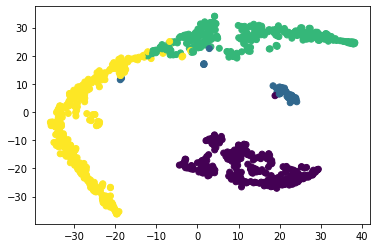

Epoch: 399, test_stats: 98.6000,test_stats: 0.0675 tensor([0.0130, 0.0090, 0.0273, 0.0182])
minimum 0.07447031


In [70]:
###In average the transfer MSE is 0.01
regressor = Regressor(dim=100,embedding = 100)
stats_regressor_LS = torch.zeros(0,400,2)
train_acc_list,MSE_list = experiment_regression(regressor,net_LS,train_loader,test_loader,epochs= 400,lr = 0.1)  
cat_elements = torch.stack([train_acc_list,MSE_list], dim = 1).unsqueeze(0)
stats_regressor_LS = torch.cat([stats_regressor_LS, cat_elements], dim = 0)

Epoch:   0, train_loss: 14.79202, train_acc: 0.8705, train_mse: 0.3007, test_mse: 0.2654 tensor([0.0298, 0.0473, 0.1010, 0.0873])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:   1, train_loss: 13.89972, train_acc: 0.9150, train_mse: 0.2857, test_mse: 0.2600 tensor([0.0322, 0.0473, 0.1094, 0.0711])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:   2, train_loss: 13.99282, train_acc: 0.9054, train_mse: 0.2848, test_mse: 0.2638 tensor([0.0292, 0.0473, 0.1138, 0.0736])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:   3, train_loss: 13.77132, train_acc: 0.9154, train_mse: 0.2843, test_mse: 0.2601 tensor([0.0600, 0.0473, 0.0801, 0.0728])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:   4, train_loss: 13.66382, train_acc: 0.8984, train_mse: 0.2779, test_mse: 0.2460 tensor([0.0593, 0.0473, 0.0746, 0.0649])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:   5, train_loss: 14.92217, train_acc: 0.8571, train_mse: 0.3025, test_mse: 0.2658 tensor([0.0544, 0.0473, 0.0820, 0.0821])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:   6, train_loss: 14.02217, train_acc: 0.9126, train_mse: 0.2866, test_mse: 0.2709 tensor([0.0326, 0.0473, 0.1169, 0.0742])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:   7, train_loss: 14.08827, train_acc: 0.9078, train_mse: 0.2865, test_mse: 0.2662 tensor([0.0351, 0.0473, 0.1023, 0.0815])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:   8, train_loss: 14.07652, train_acc: 0.8958, train_mse: 0.2879, test_mse: 0.2651 tensor([0.0502, 0.0473, 0.0883, 0.0794])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:   9, train_loss: 13.92447, train_acc: 0.9116, train_mse: 0.2800, test_mse: 0.2654 tensor([0.0557, 0.0473, 0.0761, 0.0863])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  10, train_loss: 14.24813, train_acc: 0.8836, train_mse: 0.2899, test_mse: 0.2606 tensor([0.0324, 0.0473, 0.0963, 0.0845])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  11, train_loss: 14.15327, train_acc: 0.8946, train_mse: 0.2885, test_mse: 0.2636 tensor([0.0489, 0.0473, 0.0851, 0.0824])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  12, train_loss: 14.03840, train_acc: 0.9155, train_mse: 0.2829, test_mse: 0.2648 tensor([0.0287, 0.0473, 0.1057, 0.0832])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  13, train_loss: 14.24945, train_acc: 0.9032, train_mse: 0.2884, test_mse: 0.2686 tensor([0.0268, 0.0473, 0.1193, 0.0752])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  14, train_loss: 14.19333, train_acc: 0.9039, train_mse: 0.2856, test_mse: 0.2669 tensor([0.0617, 0.0473, 0.0743, 0.0836])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  15, train_loss: 14.13179, train_acc: 0.8927, train_mse: 0.2936, test_mse: 0.2608 tensor([0.0447, 0.0473, 0.0863, 0.0826])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  16, train_loss: 14.07823, train_acc: 0.9152, train_mse: 0.2869, test_mse: 0.2683 tensor([0.0322, 0.0473, 0.0960, 0.0928])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  17, train_loss: 13.96866, train_acc: 0.9137, train_mse: 0.2821, test_mse: 0.2622 tensor([0.0417, 0.0473, 0.0913, 0.0818])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  18, train_loss: 14.23632, train_acc: 0.9037, train_mse: 0.2882, test_mse: 0.2702 tensor([0.0622, 0.0473, 0.0717, 0.0891])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  19, train_loss: 14.09592, train_acc: 0.9073, train_mse: 0.2883, test_mse: 0.2608 tensor([0.0358, 0.0473, 0.0916, 0.0862])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  20, train_loss: 14.13436, train_acc: 0.9074, train_mse: 0.2905, test_mse: 0.2664 tensor([0.0272, 0.0473, 0.1079, 0.0840])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  21, train_loss: 14.21620, train_acc: 0.9166, train_mse: 0.2888, test_mse: 0.2666 tensor([0.0335, 0.0473, 0.0953, 0.0905])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  22, train_loss: 14.13013, train_acc: 0.9010, train_mse: 0.2876, test_mse: 0.2656 tensor([0.0447, 0.0473, 0.0801, 0.0936])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  23, train_loss: 14.10305, train_acc: 0.9130, train_mse: 0.2856, test_mse: 0.2768 tensor([0.0276, 0.0473, 0.1220, 0.0799])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  24, train_loss: 14.14954, train_acc: 0.9195, train_mse: 0.2864, test_mse: 0.2692 tensor([0.0366, 0.0473, 0.0923, 0.0930])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  25, train_loss: 13.99411, train_acc: 0.9185, train_mse: 0.2840, test_mse: 0.2748 tensor([0.0604, 0.0473, 0.0684, 0.0987])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  26, train_loss: 14.28660, train_acc: 0.9006, train_mse: 0.2898, test_mse: 0.2725 tensor([0.0277, 0.0473, 0.1177, 0.0798])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  27, train_loss: 14.33690, train_acc: 0.8949, train_mse: 0.2963, test_mse: 0.2693 tensor([0.0349, 0.0473, 0.0946, 0.0925])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  28, train_loss: 14.08295, train_acc: 0.9179, train_mse: 0.2859, test_mse: 0.2665 tensor([0.0329, 0.0473, 0.0994, 0.0869])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  29, train_loss: 14.16587, train_acc: 0.9046, train_mse: 0.2905, test_mse: 0.2673 tensor([0.0342, 0.0473, 0.1050, 0.0809])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  30, train_loss: 25.32181, train_acc: 0.5878, train_mse: 0.5156, test_mse: 0.5129 tensor([0.0382, 0.0473, 0.2825, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  31, train_loss: 25.80019, train_acc: 0.5816, train_mse: 0.5262, test_mse: 0.5133 tensor([0.0395, 0.0473, 0.2816, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  32, train_loss: 25.81104, train_acc: 0.5809, train_mse: 0.5271, test_mse: 0.5131 tensor([0.0453, 0.0473, 0.2756, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  33, train_loss: 25.77961, train_acc: 0.5764, train_mse: 0.5282, test_mse: 0.5128 tensor([0.0385, 0.0473, 0.2821, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  34, train_loss: 25.81212, train_acc: 0.5759, train_mse: 0.5300, test_mse: 0.5129 tensor([0.0415, 0.0473, 0.2791, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  35, train_loss: 25.80718, train_acc: 0.5725, train_mse: 0.5298, test_mse: 0.5141 tensor([0.0627, 0.0473, 0.2592, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  36, train_loss: 25.84993, train_acc: 0.5750, train_mse: 0.5293, test_mse: 0.5151 tensor([0.0647, 0.0473, 0.2582, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  37, train_loss: 25.83479, train_acc: 0.5731, train_mse: 0.5267, test_mse: 0.5128 tensor([0.0449, 0.0473, 0.2757, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  38, train_loss: 25.75788, train_acc: 0.5815, train_mse: 0.5216, test_mse: 0.5130 tensor([0.0589, 0.0473, 0.2620, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  39, train_loss: 25.78344, train_acc: 0.5820, train_mse: 0.5222, test_mse: 0.5133 tensor([0.0614, 0.0473, 0.2597, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  40, train_loss: 25.81233, train_acc: 0.5725, train_mse: 0.5318, test_mse: 0.5141 tensor([0.0638, 0.0473, 0.2581, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  41, train_loss: 25.87367, train_acc: 0.5690, train_mse: 0.5344, test_mse: 0.5136 tensor([0.0633, 0.0473, 0.2581, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  42, train_loss: 25.90514, train_acc: 0.5704, train_mse: 0.5301, test_mse: 0.5163 tensor([0.0719, 0.0473, 0.2522, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  43, train_loss: 25.91362, train_acc: 0.5668, train_mse: 0.5313, test_mse: 0.5130 tensor([0.0632, 0.0473, 0.2576, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  44, train_loss: 25.73945, train_acc: 0.5773, train_mse: 0.5312, test_mse: 0.5144 tensor([0.0325, 0.0473, 0.2896, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  45, train_loss: 25.98120, train_acc: 0.5739, train_mse: 0.5325, test_mse: 0.5140 tensor([0.0343, 0.0473, 0.2875, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  46, train_loss: 25.77508, train_acc: 0.5854, train_mse: 0.5232, test_mse: 0.5101 tensor([0.0372, 0.0473, 0.2807, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  47, train_loss: 25.75738, train_acc: 0.5759, train_mse: 0.5358, test_mse: 0.5122 tensor([0.0474, 0.0473, 0.2725, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  48, train_loss: 25.76827, train_acc: 0.5718, train_mse: 0.5385, test_mse: 0.5129 tensor([0.0604, 0.0473, 0.2602, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  49, train_loss: 25.76562, train_acc: 0.5820, train_mse: 0.5267, test_mse: 0.5126 tensor([0.0400, 0.0473, 0.2804, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  50, train_loss: 25.77829, train_acc: 0.5735, train_mse: 0.5332, test_mse: 0.5108 tensor([0.0452, 0.0473, 0.2734, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  51, train_loss: 25.77215, train_acc: 0.5795, train_mse: 0.5275, test_mse: 0.5125 tensor([0.0585, 0.0473, 0.2618, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  52, train_loss: 25.79001, train_acc: 0.5831, train_mse: 0.5283, test_mse: 0.5136 tensor([0.0344, 0.0473, 0.2870, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  53, train_loss: 25.80544, train_acc: 0.5865, train_mse: 0.5273, test_mse: 0.5141 tensor([0.0337, 0.0473, 0.2882, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  54, train_loss: 25.85270, train_acc: 0.5803, train_mse: 0.5257, test_mse: 0.5141 tensor([0.0335, 0.0473, 0.2884, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  55, train_loss: 26.04399, train_acc: 0.5727, train_mse: 0.5267, test_mse: 0.5171 tensor([0.0305, 0.0473, 0.2944, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  56, train_loss: 25.85954, train_acc: 0.5729, train_mse: 0.5281, test_mse: 0.5129 tensor([0.0471, 0.0473, 0.2736, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  57, train_loss: 25.87314, train_acc: 0.5747, train_mse: 0.5293, test_mse: 0.5147 tensor([0.0328, 0.0473, 0.2896, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  58, train_loss: 26.08378, train_acc: 0.5620, train_mse: 0.5363, test_mse: 0.5208 tensor([0.0325, 0.0473, 0.2960, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  59, train_loss: 25.89469, train_acc: 0.5796, train_mse: 0.5258, test_mse: 0.5132 tensor([0.0618, 0.0473, 0.2592, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  60, train_loss: 25.76732, train_acc: 0.5798, train_mse: 0.5239, test_mse: 0.5127 tensor([0.0397, 0.0473, 0.2808, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  61, train_loss: 25.78694, train_acc: 0.5789, train_mse: 0.5277, test_mse: 0.5142 tensor([0.0352, 0.0473, 0.2868, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  62, train_loss: 25.98993, train_acc: 0.5728, train_mse: 0.5304, test_mse: 0.5132 tensor([0.0365, 0.0473, 0.2844, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  63, train_loss: 25.75871, train_acc: 0.5796, train_mse: 0.5286, test_mse: 0.5096 tensor([0.0383, 0.0473, 0.2791, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  64, train_loss: 25.74574, train_acc: 0.5815, train_mse: 0.5261, test_mse: 0.5129 tensor([0.0632, 0.0473, 0.2575, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  65, train_loss: 25.78571, train_acc: 0.5780, train_mse: 0.5283, test_mse: 0.5121 tensor([0.0567, 0.0473, 0.2632, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  66, train_loss: 25.81996, train_acc: 0.5775, train_mse: 0.5240, test_mse: 0.5137 tensor([0.0675, 0.0473, 0.2541, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  67, train_loss: 25.75817, train_acc: 0.5818, train_mse: 0.5241, test_mse: 0.5124 tensor([0.0399, 0.0473, 0.2803, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  68, train_loss: 25.78818, train_acc: 0.5865, train_mse: 0.5213, test_mse: 0.5183 tensor([0.0739, 0.0473, 0.2522, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  69, train_loss: 25.92805, train_acc: 0.5666, train_mse: 0.5344, test_mse: 0.5133 tensor([0.0358, 0.0473, 0.2853, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  70, train_loss: 26.39285, train_acc: 0.5479, train_mse: 0.5433, test_mse: 0.5277 tensor([0.0308, 0.0473, 0.3047, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  71, train_loss: 26.06440, train_acc: 0.5682, train_mse: 0.5319, test_mse: 0.5120 tensor([0.0559, 0.0473, 0.2638, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  72, train_loss: 25.78573, train_acc: 0.5791, train_mse: 0.5272, test_mse: 0.5151 tensor([0.0313, 0.0473, 0.2916, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  73, train_loss: 25.87598, train_acc: 0.5776, train_mse: 0.5280, test_mse: 0.5142 tensor([0.0336, 0.0473, 0.2885, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  74, train_loss: 25.82600, train_acc: 0.5737, train_mse: 0.5285, test_mse: 0.5167 tensor([0.0719, 0.0473, 0.2525, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  75, train_loss: 25.80773, train_acc: 0.5822, train_mse: 0.5203, test_mse: 0.5122 tensor([0.0554, 0.0473, 0.2646, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  76, train_loss: 25.72947, train_acc: 0.5794, train_mse: 0.5271, test_mse: 0.5136 tensor([0.0358, 0.0473, 0.2856, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  77, train_loss: 25.85076, train_acc: 0.5772, train_mse: 0.5305, test_mse: 0.5144 tensor([0.0336, 0.0473, 0.2886, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  78, train_loss: 25.82601, train_acc: 0.5809, train_mse: 0.5244, test_mse: 0.5124 tensor([0.0435, 0.0473, 0.2767, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  79, train_loss: 25.77154, train_acc: 0.5782, train_mse: 0.5252, test_mse: 0.5134 tensor([0.0612, 0.0473, 0.2600, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  80, train_loss: 25.78405, train_acc: 0.5823, train_mse: 0.5243, test_mse: 0.5123 tensor([0.0550, 0.0473, 0.2651, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  81, train_loss: 25.92837, train_acc: 0.5768, train_mse: 0.5314, test_mse: 0.5148 tensor([0.0329, 0.0473, 0.2897, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  82, train_loss: 25.80268, train_acc: 0.5915, train_mse: 0.5198, test_mse: 0.5126 tensor([0.0434, 0.0473, 0.2770, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  83, train_loss: 25.76817, train_acc: 0.5816, train_mse: 0.5307, test_mse: 0.5131 tensor([0.0365, 0.0473, 0.2844, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  84, train_loss: 25.80685, train_acc: 0.5819, train_mse: 0.5314, test_mse: 0.5126 tensor([0.0407, 0.0473, 0.2797, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  85, train_loss: 25.74562, train_acc: 0.5758, train_mse: 0.5269, test_mse: 0.5125 tensor([0.0590, 0.0473, 0.2613, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  86, train_loss: 25.77597, train_acc: 0.5792, train_mse: 0.5291, test_mse: 0.5136 tensor([0.0607, 0.0473, 0.2607, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  87, train_loss: 25.80732, train_acc: 0.5792, train_mse: 0.5263, test_mse: 0.5130 tensor([0.0529, 0.0473, 0.2679, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  88, train_loss: 25.77863, train_acc: 0.5763, train_mse: 0.5311, test_mse: 0.5123 tensor([0.0547, 0.0473, 0.2654, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  89, train_loss: 26.04681, train_acc: 0.5746, train_mse: 0.5274, test_mse: 0.5201 tensor([0.0778, 0.0473, 0.2501, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  90, train_loss: 26.05236, train_acc: 0.5756, train_mse: 0.5256, test_mse: 0.5160 tensor([0.0714, 0.0473, 0.2524, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  91, train_loss: 26.29948, train_acc: 0.5670, train_mse: 0.5384, test_mse: 0.5154 tensor([0.0702, 0.0473, 0.2530, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  92, train_loss: 25.74923, train_acc: 0.5791, train_mse: 0.5281, test_mse: 0.5133 tensor([0.0610, 0.0473, 0.2601, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  93, train_loss: 25.75137, train_acc: 0.5740, train_mse: 0.5308, test_mse: 0.5119 tensor([0.0411, 0.0473, 0.2786, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  94, train_loss: 25.75482, train_acc: 0.5840, train_mse: 0.5262, test_mse: 0.5141 tensor([0.0672, 0.0473, 0.2548, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  95, train_loss: 25.84147, train_acc: 0.5739, train_mse: 0.5286, test_mse: 0.5151 tensor([0.0682, 0.0473, 0.2547, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  96, train_loss: 25.88884, train_acc: 0.5729, train_mse: 0.5299, test_mse: 0.5139 tensor([0.0673, 0.0473, 0.2544, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  97, train_loss: 25.80713, train_acc: 0.5784, train_mse: 0.5268, test_mse: 0.5132 tensor([0.0629, 0.0473, 0.2581, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  98, train_loss: 25.82642, train_acc: 0.5828, train_mse: 0.5240, test_mse: 0.5132 tensor([0.0607, 0.0473, 0.2603, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  99, train_loss: 25.74997, train_acc: 0.5805, train_mse: 0.5270, test_mse: 0.5130 tensor([0.0605, 0.0473, 0.2603, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 100, train_loss: 25.77185, train_acc: 0.5808, train_mse: 0.5247, test_mse: 0.5127 tensor([0.0601, 0.0473, 0.2604, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 101, train_loss: 25.76750, train_acc: 0.5786, train_mse: 0.5253, test_mse: 0.5127 tensor([0.0603, 0.0473, 0.2602, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 102, train_loss: 25.77480, train_acc: 0.5864, train_mse: 0.5213, test_mse: 0.5122 tensor([0.0578, 0.0473, 0.2622, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 103, train_loss: 25.75923, train_acc: 0.5848, train_mse: 0.5199, test_mse: 0.5124 tensor([0.0572, 0.0473, 0.2631, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 104, train_loss: 25.76158, train_acc: 0.5777, train_mse: 0.5289, test_mse: 0.5123 tensor([0.0557, 0.0473, 0.2644, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 105, train_loss: 25.74030, train_acc: 0.5782, train_mse: 0.5296, test_mse: 0.5123 tensor([0.0551, 0.0473, 0.2650, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 106, train_loss: 25.74805, train_acc: 0.5806, train_mse: 0.5258, test_mse: 0.5126 tensor([0.0546, 0.0473, 0.2658, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 107, train_loss: 25.74083, train_acc: 0.5836, train_mse: 0.5225, test_mse: 0.5089 tensor([0.0480, 0.0473, 0.2687, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 108, train_loss: 25.73448, train_acc: 0.5809, train_mse: 0.5280, test_mse: 0.5124 tensor([0.0559, 0.0473, 0.2643, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 109, train_loss: 25.75888, train_acc: 0.5800, train_mse: 0.5280, test_mse: 0.5124 tensor([0.0577, 0.0473, 0.2625, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 110, train_loss: 25.75763, train_acc: 0.5772, train_mse: 0.5319, test_mse: 0.5123 tensor([0.0567, 0.0473, 0.2634, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 111, train_loss: 25.75299, train_acc: 0.5805, train_mse: 0.5270, test_mse: 0.5123 tensor([0.0554, 0.0473, 0.2647, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 112, train_loss: 25.73399, train_acc: 0.5783, train_mse: 0.5295, test_mse: 0.5117 tensor([0.0475, 0.0473, 0.2720, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 113, train_loss: 25.72914, train_acc: 0.5874, train_mse: 0.5249, test_mse: 0.5123 tensor([0.0416, 0.0473, 0.2785, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 114, train_loss: 25.73629, train_acc: 0.5767, train_mse: 0.5286, test_mse: 0.5124 tensor([0.0546, 0.0473, 0.2656, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 115, train_loss: 25.73542, train_acc: 0.5908, train_mse: 0.5165, test_mse: 0.5125 tensor([0.0545, 0.0473, 0.2658, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 116, train_loss: 25.72866, train_acc: 0.5838, train_mse: 0.5278, test_mse: 0.5090 tensor([0.0487, 0.0473, 0.2680, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 117, train_loss: 25.74397, train_acc: 0.5836, train_mse: 0.5229, test_mse: 0.5123 tensor([0.0558, 0.0473, 0.2642, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 118, train_loss: 25.75377, train_acc: 0.5803, train_mse: 0.5293, test_mse: 0.5127 tensor([0.0572, 0.0473, 0.2633, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 119, train_loss: 25.74960, train_acc: 0.5805, train_mse: 0.5262, test_mse: 0.5123 tensor([0.0552, 0.0473, 0.2649, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 120, train_loss: 25.74774, train_acc: 0.5859, train_mse: 0.5235, test_mse: 0.5123 tensor([0.0556, 0.0473, 0.2645, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 121, train_loss: 25.74201, train_acc: 0.5834, train_mse: 0.5249, test_mse: 0.5126 tensor([0.0571, 0.0473, 0.2633, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 122, train_loss: 25.76620, train_acc: 0.5801, train_mse: 0.5272, test_mse: 0.5124 tensor([0.0576, 0.0473, 0.2626, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 123, train_loss: 25.74980, train_acc: 0.5853, train_mse: 0.5233, test_mse: 0.5120 tensor([0.0550, 0.0473, 0.2648, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 124, train_loss: 25.73810, train_acc: 0.5787, train_mse: 0.5269, test_mse: 0.5121 tensor([0.0542, 0.0473, 0.2656, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 125, train_loss: 25.72771, train_acc: 0.5813, train_mse: 0.5266, test_mse: 0.5112 tensor([0.0527, 0.0473, 0.2663, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 126, train_loss: 25.72583, train_acc: 0.5848, train_mse: 0.5257, test_mse: 0.5127 tensor([0.0397, 0.0473, 0.2808, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 127, train_loss: 25.76009, train_acc: 0.5874, train_mse: 0.5215, test_mse: 0.5129 tensor([0.0394, 0.0473, 0.2813, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 128, train_loss: 25.76490, train_acc: 0.5898, train_mse: 0.5223, test_mse: 0.5134 tensor([0.0362, 0.0473, 0.2851, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 129, train_loss: 25.80699, train_acc: 0.5828, train_mse: 0.5254, test_mse: 0.5135 tensor([0.0362, 0.0473, 0.2851, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 130, train_loss: 25.79645, train_acc: 0.5807, train_mse: 0.5288, test_mse: 0.5133 tensor([0.0371, 0.0473, 0.2840, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 131, train_loss: 25.76073, train_acc: 0.5772, train_mse: 0.5327, test_mse: 0.5126 tensor([0.0404, 0.0473, 0.2800, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 132, train_loss: 25.71672, train_acc: 0.5827, train_mse: 0.5254, test_mse: 0.5113 tensor([0.0509, 0.0473, 0.2681, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 133, train_loss: 25.71724, train_acc: 0.5814, train_mse: 0.5251, test_mse: 0.5118 tensor([0.0436, 0.0473, 0.2760, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 134, train_loss: 25.70189, train_acc: 0.5827, train_mse: 0.5292, test_mse: 0.5115 tensor([0.0447, 0.0473, 0.2746, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 135, train_loss: 25.73031, train_acc: 0.5829, train_mse: 0.5264, test_mse: 0.5130 tensor([0.0403, 0.0473, 0.2805, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 136, train_loss: 25.73157, train_acc: 0.5824, train_mse: 0.5253, test_mse: 0.5122 tensor([0.0547, 0.0473, 0.2652, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 137, train_loss: 25.74635, train_acc: 0.5776, train_mse: 0.5256, test_mse: 0.5127 tensor([0.0399, 0.0473, 0.2806, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 138, train_loss: 25.73938, train_acc: 0.5827, train_mse: 0.5264, test_mse: 0.5124 tensor([0.0410, 0.0473, 0.2791, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 139, train_loss: 25.72770, train_acc: 0.5850, train_mse: 0.5269, test_mse: 0.5110 tensor([0.0497, 0.0473, 0.2691, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 140, train_loss: 25.71250, train_acc: 0.5816, train_mse: 0.5260, test_mse: 0.5111 tensor([0.0488, 0.0473, 0.2701, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 141, train_loss: 25.72332, train_acc: 0.5837, train_mse: 0.5256, test_mse: 0.5120 tensor([0.0528, 0.0473, 0.2669, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 142, train_loss: 25.71909, train_acc: 0.5823, train_mse: 0.5282, test_mse: 0.5129 tensor([0.0405, 0.0473, 0.2802, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 143, train_loss: 25.75903, train_acc: 0.5831, train_mse: 0.5269, test_mse: 0.5130 tensor([0.0405, 0.0473, 0.2803, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 144, train_loss: 25.74221, train_acc: 0.5883, train_mse: 0.5209, test_mse: 0.5127 tensor([0.0408, 0.0473, 0.2797, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 145, train_loss: 25.70498, train_acc: 0.5869, train_mse: 0.5196, test_mse: 0.5102 tensor([0.0416, 0.0473, 0.2764, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 146, train_loss: 25.75443, train_acc: 0.5829, train_mse: 0.5272, test_mse: 0.5128 tensor([0.0401, 0.0473, 0.2805, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 147, train_loss: 25.75594, train_acc: 0.5857, train_mse: 0.5248, test_mse: 0.5127 tensor([0.0396, 0.0473, 0.2808, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 148, train_loss: 25.74899, train_acc: 0.5829, train_mse: 0.5243, test_mse: 0.5128 tensor([0.0401, 0.0473, 0.2805, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 149, train_loss: 25.76209, train_acc: 0.5880, train_mse: 0.5239, test_mse: 0.5125 tensor([0.0398, 0.0473, 0.2805, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 150, train_loss: 25.75347, train_acc: 0.5853, train_mse: 0.5259, test_mse: 0.5121 tensor([0.0442, 0.0473, 0.2757, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 151, train_loss: 25.72803, train_acc: 0.5849, train_mse: 0.5246, test_mse: 0.5127 tensor([0.0407, 0.0473, 0.2798, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 152, train_loss: 25.73088, train_acc: 0.5830, train_mse: 0.5254, test_mse: 0.5118 tensor([0.0410, 0.0473, 0.2786, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 153, train_loss: 25.76057, train_acc: 0.5823, train_mse: 0.5257, test_mse: 0.5128 tensor([0.0400, 0.0473, 0.2806, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 154, train_loss: 25.74889, train_acc: 0.5849, train_mse: 0.5250, test_mse: 0.5128 tensor([0.0401, 0.0473, 0.2805, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 155, train_loss: 25.75852, train_acc: 0.5872, train_mse: 0.5211, test_mse: 0.5131 tensor([0.0376, 0.0473, 0.2833, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 156, train_loss: 25.79320, train_acc: 0.5782, train_mse: 0.5311, test_mse: 0.5132 tensor([0.0370, 0.0473, 0.2840, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 157, train_loss: 25.79218, train_acc: 0.5829, train_mse: 0.5227, test_mse: 0.5132 tensor([0.0370, 0.0473, 0.2840, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 158, train_loss: 25.78992, train_acc: 0.5829, train_mse: 0.5234, test_mse: 0.5133 tensor([0.0369, 0.0473, 0.2842, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 159, train_loss: 25.74081, train_acc: 0.5844, train_mse: 0.5266, test_mse: 0.5123 tensor([0.0527, 0.0473, 0.2674, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 160, train_loss: 25.71918, train_acc: 0.5801, train_mse: 0.5267, test_mse: 0.5119 tensor([0.0513, 0.0473, 0.2684, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 161, train_loss: 25.71895, train_acc: 0.5849, train_mse: 0.5224, test_mse: 0.5124 tensor([0.0414, 0.0473, 0.2788, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 162, train_loss: 25.72207, train_acc: 0.5757, train_mse: 0.5324, test_mse: 0.5128 tensor([0.0403, 0.0473, 0.2802, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 163, train_loss: 25.74452, train_acc: 0.5879, train_mse: 0.5258, test_mse: 0.5127 tensor([0.0404, 0.0473, 0.2800, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 164, train_loss: 25.73249, train_acc: 0.5855, train_mse: 0.5235, test_mse: 0.5125 tensor([0.0412, 0.0473, 0.2791, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 165, train_loss: 25.75000, train_acc: 0.5874, train_mse: 0.5220, test_mse: 0.5127 tensor([0.0388, 0.0473, 0.2817, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 166, train_loss: 25.78540, train_acc: 0.5859, train_mse: 0.5244, test_mse: 0.5133 tensor([0.0380, 0.0473, 0.2831, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 167, train_loss: 25.76248, train_acc: 0.5792, train_mse: 0.5274, test_mse: 0.5128 tensor([0.0399, 0.0473, 0.2807, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 168, train_loss: 25.75448, train_acc: 0.5793, train_mse: 0.5266, test_mse: 0.5127 tensor([0.0404, 0.0473, 0.2801, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 169, train_loss: 25.73384, train_acc: 0.5872, train_mse: 0.5271, test_mse: 0.5089 tensor([0.0520, 0.0473, 0.2647, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 170, train_loss: 25.71568, train_acc: 0.5845, train_mse: 0.5255, test_mse: 0.5123 tensor([0.0564, 0.0473, 0.2636, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 171, train_loss: 25.71150, train_acc: 0.5770, train_mse: 0.5289, test_mse: 0.5111 tensor([0.0488, 0.0473, 0.2700, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 172, train_loss: 25.72747, train_acc: 0.5853, train_mse: 0.5212, test_mse: 0.5125 tensor([0.0409, 0.0473, 0.2793, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 173, train_loss: 25.72323, train_acc: 0.5826, train_mse: 0.5311, test_mse: 0.5129 tensor([0.0405, 0.0473, 0.2802, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 174, train_loss: 25.74251, train_acc: 0.5903, train_mse: 0.5214, test_mse: 0.5128 tensor([0.0402, 0.0473, 0.2804, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 175, train_loss: 25.73861, train_acc: 0.5880, train_mse: 0.5186, test_mse: 0.5129 tensor([0.0405, 0.0473, 0.2802, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 176, train_loss: 25.75352, train_acc: 0.5823, train_mse: 0.5266, test_mse: 0.5128 tensor([0.0400, 0.0473, 0.2806, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 177, train_loss: 25.75134, train_acc: 0.5831, train_mse: 0.5299, test_mse: 0.5129 tensor([0.0404, 0.0473, 0.2803, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 178, train_loss: 25.74803, train_acc: 0.5878, train_mse: 0.5236, test_mse: 0.5128 tensor([0.0402, 0.0473, 0.2804, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 179, train_loss: 25.74186, train_acc: 0.5879, train_mse: 0.5228, test_mse: 0.5127 tensor([0.0393, 0.0473, 0.2811, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 180, train_loss: 25.75169, train_acc: 0.5828, train_mse: 0.5242, test_mse: 0.5131 tensor([0.0383, 0.0473, 0.2826, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 181, train_loss: 25.76353, train_acc: 0.5855, train_mse: 0.5250, test_mse: 0.5129 tensor([0.0404, 0.0473, 0.2803, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 182, train_loss: 25.74964, train_acc: 0.5856, train_mse: 0.5264, test_mse: 0.5128 tensor([0.0404, 0.0473, 0.2803, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 183, train_loss: 25.74830, train_acc: 0.5857, train_mse: 0.5258, test_mse: 0.5127 tensor([0.0391, 0.0473, 0.2814, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 184, train_loss: 25.75025, train_acc: 0.5827, train_mse: 0.5256, test_mse: 0.5128 tensor([0.0405, 0.0473, 0.2801, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 185, train_loss: 25.73086, train_acc: 0.5798, train_mse: 0.5298, test_mse: 0.5124 tensor([0.0408, 0.0473, 0.2794, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 186, train_loss: 25.73459, train_acc: 0.5835, train_mse: 0.5266, test_mse: 0.5123 tensor([0.0572, 0.0473, 0.2629, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 187, train_loss: 25.74370, train_acc: 0.5849, train_mse: 0.5228, test_mse: 0.5122 tensor([0.0601, 0.0473, 0.2600, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 188, train_loss: 25.74977, train_acc: 0.5769, train_mse: 0.5271, test_mse: 0.5124 tensor([0.0594, 0.0473, 0.2608, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 189, train_loss: 25.74940, train_acc: 0.5848, train_mse: 0.5207, test_mse: 0.5124 tensor([0.0583, 0.0473, 0.2619, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 190, train_loss: 25.75729, train_acc: 0.5788, train_mse: 0.5315, test_mse: 0.5129 tensor([0.0619, 0.0473, 0.2587, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 191, train_loss: 25.76808, train_acc: 0.5831, train_mse: 0.5221, test_mse: 0.5129 tensor([0.0622, 0.0473, 0.2585, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 192, train_loss: 25.77449, train_acc: 0.5850, train_mse: 0.5205, test_mse: 0.5127 tensor([0.0621, 0.0473, 0.2584, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 193, train_loss: 25.75844, train_acc: 0.5760, train_mse: 0.5263, test_mse: 0.5122 tensor([0.0587, 0.0473, 0.2613, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 194, train_loss: 25.74886, train_acc: 0.5826, train_mse: 0.5263, test_mse: 0.5125 tensor([0.0579, 0.0473, 0.2623, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 195, train_loss: 25.74948, train_acc: 0.5805, train_mse: 0.5271, test_mse: 0.5123 tensor([0.0556, 0.0473, 0.2645, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 196, train_loss: 25.72541, train_acc: 0.5835, train_mse: 0.5227, test_mse: 0.5124 tensor([0.0557, 0.0473, 0.2645, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 197, train_loss: 25.74549, train_acc: 0.5853, train_mse: 0.5235, test_mse: 0.5125 tensor([0.0582, 0.0473, 0.2621, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 198, train_loss: 25.74612, train_acc: 0.5773, train_mse: 0.5286, test_mse: 0.5125 tensor([0.0582, 0.0473, 0.2621, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 199, train_loss: 25.74871, train_acc: 0.5803, train_mse: 0.5256, test_mse: 0.5123 tensor([0.0588, 0.0473, 0.2613, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 200, train_loss: 25.76466, train_acc: 0.5815, train_mse: 0.5245, test_mse: 0.5122 tensor([0.0585, 0.0473, 0.2615, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 201, train_loss: 25.75316, train_acc: 0.5868, train_mse: 0.5216, test_mse: 0.5125 tensor([0.0584, 0.0473, 0.2619, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 202, train_loss: 25.74866, train_acc: 0.5796, train_mse: 0.5247, test_mse: 0.5125 tensor([0.0584, 0.0473, 0.2618, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 203, train_loss: 25.74745, train_acc: 0.5794, train_mse: 0.5273, test_mse: 0.5124 tensor([0.0584, 0.0473, 0.2618, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 204, train_loss: 25.74747, train_acc: 0.5795, train_mse: 0.5252, test_mse: 0.5124 tensor([0.0584, 0.0473, 0.2618, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 205, train_loss: 25.74624, train_acc: 0.5820, train_mse: 0.5242, test_mse: 0.5124 tensor([0.0583, 0.0473, 0.2619, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 206, train_loss: 25.74417, train_acc: 0.5796, train_mse: 0.5263, test_mse: 0.5124 tensor([0.0583, 0.0473, 0.2619, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 207, train_loss: 25.74329, train_acc: 0.5772, train_mse: 0.5275, test_mse: 0.5124 tensor([0.0584, 0.0473, 0.2619, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 208, train_loss: 25.74335, train_acc: 0.5797, train_mse: 0.5256, test_mse: 0.5124 tensor([0.0584, 0.0473, 0.2619, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 209, train_loss: 25.74320, train_acc: 0.5847, train_mse: 0.5251, test_mse: 0.5124 tensor([0.0584, 0.0473, 0.2619, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 210, train_loss: 25.74428, train_acc: 0.5846, train_mse: 0.5210, test_mse: 0.5124 tensor([0.0584, 0.0473, 0.2619, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 211, train_loss: 25.74498, train_acc: 0.5848, train_mse: 0.5240, test_mse: 0.5124 tensor([0.0584, 0.0473, 0.2618, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 212, train_loss: 25.74382, train_acc: 0.5797, train_mse: 0.5281, test_mse: 0.5125 tensor([0.0583, 0.0473, 0.2619, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 213, train_loss: 25.74540, train_acc: 0.5848, train_mse: 0.5227, test_mse: 0.5125 tensor([0.0584, 0.0473, 0.2619, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 214, train_loss: 25.74453, train_acc: 0.5870, train_mse: 0.5201, test_mse: 0.5125 tensor([0.0583, 0.0473, 0.2619, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 215, train_loss: 25.74266, train_acc: 0.5849, train_mse: 0.5236, test_mse: 0.5125 tensor([0.0583, 0.0473, 0.2620, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 216, train_loss: 25.74192, train_acc: 0.5799, train_mse: 0.5315, test_mse: 0.5125 tensor([0.0584, 0.0473, 0.2619, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 217, train_loss: 25.74414, train_acc: 0.5798, train_mse: 0.5281, test_mse: 0.5125 tensor([0.0583, 0.0473, 0.2620, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 218, train_loss: 25.74079, train_acc: 0.5801, train_mse: 0.5269, test_mse: 0.5125 tensor([0.0584, 0.0473, 0.2619, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 219, train_loss: 25.74125, train_acc: 0.5823, train_mse: 0.5258, test_mse: 0.5125 tensor([0.0583, 0.0473, 0.2620, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 220, train_loss: 25.74116, train_acc: 0.5825, train_mse: 0.5239, test_mse: 0.5125 tensor([0.0584, 0.0473, 0.2619, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 221, train_loss: 25.74427, train_acc: 0.5797, train_mse: 0.5262, test_mse: 0.5125 tensor([0.0584, 0.0473, 0.2619, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 222, train_loss: 25.74092, train_acc: 0.5823, train_mse: 0.5236, test_mse: 0.5126 tensor([0.0584, 0.0473, 0.2620, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 223, train_loss: 25.74221, train_acc: 0.5774, train_mse: 0.5289, test_mse: 0.5125 tensor([0.0583, 0.0473, 0.2620, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 224, train_loss: 25.74387, train_acc: 0.5800, train_mse: 0.5289, test_mse: 0.5125 tensor([0.0584, 0.0473, 0.2620, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 225, train_loss: 25.74265, train_acc: 0.5850, train_mse: 0.5229, test_mse: 0.5125 tensor([0.0584, 0.0473, 0.2619, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 226, train_loss: 25.73961, train_acc: 0.5873, train_mse: 0.5190, test_mse: 0.5125 tensor([0.0584, 0.0473, 0.2619, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 227, train_loss: 25.74038, train_acc: 0.5848, train_mse: 0.5235, test_mse: 0.5125 tensor([0.0584, 0.0473, 0.2619, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 228, train_loss: 25.74049, train_acc: 0.5825, train_mse: 0.5222, test_mse: 0.5125 tensor([0.0584, 0.0473, 0.2618, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 229, train_loss: 25.74375, train_acc: 0.5874, train_mse: 0.5192, test_mse: 0.5125 tensor([0.0584, 0.0473, 0.2619, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 230, train_loss: 25.73944, train_acc: 0.5775, train_mse: 0.5265, test_mse: 0.5124 tensor([0.0584, 0.0473, 0.2618, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 231, train_loss: 25.73813, train_acc: 0.5850, train_mse: 0.5239, test_mse: 0.5124 tensor([0.0585, 0.0473, 0.2617, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 232, train_loss: 25.73336, train_acc: 0.5822, train_mse: 0.5230, test_mse: 0.5125 tensor([0.0586, 0.0473, 0.2617, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 233, train_loss: 25.73206, train_acc: 0.5801, train_mse: 0.5269, test_mse: 0.5125 tensor([0.0587, 0.0473, 0.2616, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 234, train_loss: 25.73068, train_acc: 0.5850, train_mse: 0.5210, test_mse: 0.5125 tensor([0.0587, 0.0473, 0.2616, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 235, train_loss: 25.73261, train_acc: 0.5823, train_mse: 0.5223, test_mse: 0.5125 tensor([0.0586, 0.0473, 0.2617, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 236, train_loss: 25.73279, train_acc: 0.5826, train_mse: 0.5213, test_mse: 0.5125 tensor([0.0587, 0.0473, 0.2616, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 237, train_loss: 25.73496, train_acc: 0.5798, train_mse: 0.5277, test_mse: 0.5125 tensor([0.0587, 0.0473, 0.2615, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 238, train_loss: 25.73190, train_acc: 0.5826, train_mse: 0.5235, test_mse: 0.5125 tensor([0.0587, 0.0473, 0.2616, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 239, train_loss: 25.73066, train_acc: 0.5800, train_mse: 0.5321, test_mse: 0.5125 tensor([0.0586, 0.0473, 0.2617, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 240, train_loss: 25.72978, train_acc: 0.5825, train_mse: 0.5221, test_mse: 0.5125 tensor([0.0587, 0.0473, 0.2616, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 241, train_loss: 25.73117, train_acc: 0.5776, train_mse: 0.5268, test_mse: 0.5125 tensor([0.0587, 0.0473, 0.2616, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 242, train_loss: 25.73362, train_acc: 0.5876, train_mse: 0.5200, test_mse: 0.5125 tensor([0.0587, 0.0473, 0.2616, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 243, train_loss: 25.73081, train_acc: 0.5874, train_mse: 0.5173, test_mse: 0.5125 tensor([0.0586, 0.0473, 0.2616, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 244, train_loss: 25.73166, train_acc: 0.5776, train_mse: 0.5271, test_mse: 0.5125 tensor([0.0587, 0.0473, 0.2616, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 245, train_loss: 25.73162, train_acc: 0.5849, train_mse: 0.5215, test_mse: 0.5125 tensor([0.0586, 0.0473, 0.2617, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 246, train_loss: 25.72955, train_acc: 0.5826, train_mse: 0.5218, test_mse: 0.5125 tensor([0.0587, 0.0473, 0.2616, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 247, train_loss: 25.73339, train_acc: 0.5775, train_mse: 0.5322, test_mse: 0.5125 tensor([0.0586, 0.0473, 0.2617, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 248, train_loss: 25.73063, train_acc: 0.5877, train_mse: 0.5228, test_mse: 0.5125 tensor([0.0586, 0.0473, 0.2617, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 249, train_loss: 25.73135, train_acc: 0.5800, train_mse: 0.5286, test_mse: 0.5125 tensor([0.0587, 0.0473, 0.2616, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 250, train_loss: 25.73116, train_acc: 0.5802, train_mse: 0.5239, test_mse: 0.5125 tensor([0.0586, 0.0473, 0.2616, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 251, train_loss: 25.73152, train_acc: 0.5752, train_mse: 0.5301, test_mse: 0.5125 tensor([0.0586, 0.0473, 0.2617, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 252, train_loss: 25.73189, train_acc: 0.5776, train_mse: 0.5283, test_mse: 0.5125 tensor([0.0586, 0.0473, 0.2617, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 253, train_loss: 25.73191, train_acc: 0.5876, train_mse: 0.5207, test_mse: 0.5125 tensor([0.0586, 0.0473, 0.2617, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 254, train_loss: 25.73177, train_acc: 0.5800, train_mse: 0.5266, test_mse: 0.5125 tensor([0.0587, 0.0473, 0.2616, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 255, train_loss: 25.73061, train_acc: 0.5750, train_mse: 0.5299, test_mse: 0.5125 tensor([0.0587, 0.0473, 0.2616, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 256, train_loss: 25.73215, train_acc: 0.5849, train_mse: 0.5246, test_mse: 0.5125 tensor([0.0587, 0.0473, 0.2616, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 257, train_loss: 25.73276, train_acc: 0.5852, train_mse: 0.5204, test_mse: 0.5125 tensor([0.0587, 0.0473, 0.2616, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 258, train_loss: 25.73021, train_acc: 0.5800, train_mse: 0.5281, test_mse: 0.5125 tensor([0.0587, 0.0473, 0.2616, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 259, train_loss: 25.73376, train_acc: 0.5826, train_mse: 0.5245, test_mse: 0.5125 tensor([0.0587, 0.0473, 0.2615, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 260, train_loss: 25.73156, train_acc: 0.5827, train_mse: 0.5215, test_mse: 0.5125 tensor([0.0587, 0.0473, 0.2616, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 261, train_loss: 25.73070, train_acc: 0.5749, train_mse: 0.5309, test_mse: 0.5125 tensor([0.0587, 0.0473, 0.2616, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 262, train_loss: 25.73156, train_acc: 0.5850, train_mse: 0.5238, test_mse: 0.5125 tensor([0.0586, 0.0473, 0.2617, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 263, train_loss: 25.72923, train_acc: 0.5777, train_mse: 0.5300, test_mse: 0.5125 tensor([0.0588, 0.0473, 0.2615, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 264, train_loss: 25.73464, train_acc: 0.5847, train_mse: 0.5226, test_mse: 0.5125 tensor([0.0586, 0.0473, 0.2616, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 265, train_loss: 25.73234, train_acc: 0.5802, train_mse: 0.5275, test_mse: 0.5125 tensor([0.0587, 0.0473, 0.2616, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 266, train_loss: 25.74110, train_acc: 0.5829, train_mse: 0.5238, test_mse: 0.5123 tensor([0.0578, 0.0473, 0.2624, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 267, train_loss: 25.73571, train_acc: 0.5806, train_mse: 0.5262, test_mse: 0.5122 tensor([0.0575, 0.0473, 0.2625, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 268, train_loss: 25.73209, train_acc: 0.5856, train_mse: 0.5216, test_mse: 0.5123 tensor([0.0577, 0.0473, 0.2624, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 269, train_loss: 25.73177, train_acc: 0.5856, train_mse: 0.5238, test_mse: 0.5123 tensor([0.0577, 0.0473, 0.2624, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 270, train_loss: 25.73208, train_acc: 0.5807, train_mse: 0.5247, test_mse: 0.5123 tensor([0.0576, 0.0473, 0.2624, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 271, train_loss: 25.73190, train_acc: 0.5782, train_mse: 0.5298, test_mse: 0.5123 tensor([0.0577, 0.0473, 0.2624, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 272, train_loss: 25.73178, train_acc: 0.5832, train_mse: 0.5241, test_mse: 0.5123 tensor([0.0576, 0.0473, 0.2624, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 273, train_loss: 25.73053, train_acc: 0.5832, train_mse: 0.5249, test_mse: 0.5124 tensor([0.0578, 0.0473, 0.2623, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 274, train_loss: 25.73252, train_acc: 0.5781, train_mse: 0.5296, test_mse: 0.5123 tensor([0.0577, 0.0473, 0.2624, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 275, train_loss: 25.73303, train_acc: 0.5782, train_mse: 0.5304, test_mse: 0.5123 tensor([0.0577, 0.0473, 0.2624, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 276, train_loss: 25.73180, train_acc: 0.5857, train_mse: 0.5205, test_mse: 0.5123 tensor([0.0577, 0.0473, 0.2624, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 277, train_loss: 25.73109, train_acc: 0.5807, train_mse: 0.5255, test_mse: 0.5122 tensor([0.0576, 0.0473, 0.2624, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 278, train_loss: 25.73223, train_acc: 0.5757, train_mse: 0.5322, test_mse: 0.5123 tensor([0.0577, 0.0473, 0.2624, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 279, train_loss: 25.73091, train_acc: 0.5807, train_mse: 0.5278, test_mse: 0.5123 tensor([0.0576, 0.0473, 0.2624, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 280, train_loss: 25.73362, train_acc: 0.5857, train_mse: 0.5219, test_mse: 0.5122 tensor([0.0575, 0.0473, 0.2625, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 281, train_loss: 25.73220, train_acc: 0.5882, train_mse: 0.5197, test_mse: 0.5123 tensor([0.0576, 0.0473, 0.2625, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 282, train_loss: 25.73201, train_acc: 0.5807, train_mse: 0.5276, test_mse: 0.5124 tensor([0.0578, 0.0473, 0.2624, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 283, train_loss: 25.73146, train_acc: 0.5856, train_mse: 0.5220, test_mse: 0.5124 tensor([0.0578, 0.0473, 0.2623, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 284, train_loss: 25.73211, train_acc: 0.5706, train_mse: 0.5363, test_mse: 0.5124 tensor([0.0578, 0.0473, 0.2623, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 285, train_loss: 25.73151, train_acc: 0.5782, train_mse: 0.5262, test_mse: 0.5123 tensor([0.0577, 0.0473, 0.2624, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 286, train_loss: 25.73103, train_acc: 0.5832, train_mse: 0.5231, test_mse: 0.5123 tensor([0.0578, 0.0473, 0.2624, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 287, train_loss: 25.73267, train_acc: 0.5881, train_mse: 0.5201, test_mse: 0.5123 tensor([0.0577, 0.0473, 0.2624, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 288, train_loss: 25.73156, train_acc: 0.5857, train_mse: 0.5220, test_mse: 0.5123 tensor([0.0578, 0.0473, 0.2623, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 289, train_loss: 25.73060, train_acc: 0.5781, train_mse: 0.5276, test_mse: 0.5124 tensor([0.0580, 0.0473, 0.2622, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 290, train_loss: 25.73470, train_acc: 0.5857, train_mse: 0.5204, test_mse: 0.5123 tensor([0.0578, 0.0473, 0.2623, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 291, train_loss: 25.73077, train_acc: 0.5807, train_mse: 0.5280, test_mse: 0.5124 tensor([0.0580, 0.0473, 0.2622, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 292, train_loss: 25.73143, train_acc: 0.5857, train_mse: 0.5219, test_mse: 0.5124 tensor([0.0579, 0.0473, 0.2622, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 293, train_loss: 25.73015, train_acc: 0.5832, train_mse: 0.5252, test_mse: 0.5123 tensor([0.0578, 0.0473, 0.2623, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 294, train_loss: 25.73107, train_acc: 0.5857, train_mse: 0.5205, test_mse: 0.5123 tensor([0.0578, 0.0473, 0.2623, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 295, train_loss: 25.73872, train_acc: 0.5830, train_mse: 0.5231, test_mse: 0.5123 tensor([0.0583, 0.0473, 0.2618, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 296, train_loss: 25.73201, train_acc: 0.5881, train_mse: 0.5224, test_mse: 0.5123 tensor([0.0583, 0.0473, 0.2618, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 297, train_loss: 25.72926, train_acc: 0.5803, train_mse: 0.5262, test_mse: 0.5123 tensor([0.0583, 0.0473, 0.2618, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 298, train_loss: 25.73488, train_acc: 0.5851, train_mse: 0.5236, test_mse: 0.5123 tensor([0.0587, 0.0473, 0.2615, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 299, train_loss: 25.72826, train_acc: 0.5828, train_mse: 0.5236, test_mse: 0.5123 tensor([0.0584, 0.0473, 0.2617, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 300, train_loss: 25.72737, train_acc: 0.5830, train_mse: 0.5230, test_mse: 0.5123 tensor([0.0584, 0.0473, 0.2617, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 301, train_loss: 25.72725, train_acc: 0.5805, train_mse: 0.5259, test_mse: 0.5123 tensor([0.0584, 0.0473, 0.2617, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 302, train_loss: 25.72726, train_acc: 0.5805, train_mse: 0.5276, test_mse: 0.5123 tensor([0.0584, 0.0473, 0.2617, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 303, train_loss: 25.72728, train_acc: 0.5755, train_mse: 0.5338, test_mse: 0.5123 tensor([0.0584, 0.0473, 0.2617, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 304, train_loss: 25.72709, train_acc: 0.5805, train_mse: 0.5305, test_mse: 0.5123 tensor([0.0584, 0.0473, 0.2617, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 305, train_loss: 25.72702, train_acc: 0.5830, train_mse: 0.5239, test_mse: 0.5123 tensor([0.0584, 0.0473, 0.2617, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 306, train_loss: 25.72689, train_acc: 0.5830, train_mse: 0.5239, test_mse: 0.5123 tensor([0.0584, 0.0473, 0.2617, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 307, train_loss: 25.72689, train_acc: 0.5805, train_mse: 0.5274, test_mse: 0.5123 tensor([0.0584, 0.0473, 0.2617, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 308, train_loss: 25.72680, train_acc: 0.5855, train_mse: 0.5212, test_mse: 0.5123 tensor([0.0584, 0.0473, 0.2617, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 309, train_loss: 25.72674, train_acc: 0.5805, train_mse: 0.5261, test_mse: 0.5123 tensor([0.0584, 0.0473, 0.2617, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 310, train_loss: 25.72673, train_acc: 0.5780, train_mse: 0.5251, test_mse: 0.5123 tensor([0.0584, 0.0473, 0.2617, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 311, train_loss: 25.72651, train_acc: 0.5805, train_mse: 0.5282, test_mse: 0.5123 tensor([0.0584, 0.0473, 0.2617, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 312, train_loss: 25.72641, train_acc: 0.5805, train_mse: 0.5245, test_mse: 0.5123 tensor([0.0584, 0.0473, 0.2617, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 313, train_loss: 25.72632, train_acc: 0.5855, train_mse: 0.5210, test_mse: 0.5123 tensor([0.0584, 0.0473, 0.2617, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 314, train_loss: 25.72625, train_acc: 0.5880, train_mse: 0.5181, test_mse: 0.5123 tensor([0.0584, 0.0473, 0.2617, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 315, train_loss: 25.72620, train_acc: 0.5830, train_mse: 0.5244, test_mse: 0.5123 tensor([0.0584, 0.0473, 0.2617, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 316, train_loss: 25.72632, train_acc: 0.5780, train_mse: 0.5274, test_mse: 0.5123 tensor([0.0584, 0.0473, 0.2617, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 317, train_loss: 25.72596, train_acc: 0.5855, train_mse: 0.5239, test_mse: 0.5123 tensor([0.0584, 0.0473, 0.2617, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 318, train_loss: 25.72592, train_acc: 0.5855, train_mse: 0.5194, test_mse: 0.5123 tensor([0.0584, 0.0473, 0.2617, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 319, train_loss: 25.72587, train_acc: 0.5755, train_mse: 0.5313, test_mse: 0.5123 tensor([0.0584, 0.0473, 0.2617, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 320, train_loss: 25.72583, train_acc: 0.5830, train_mse: 0.5263, test_mse: 0.5123 tensor([0.0583, 0.0473, 0.2617, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 321, train_loss: 25.72543, train_acc: 0.5830, train_mse: 0.5236, test_mse: 0.5123 tensor([0.0583, 0.0473, 0.2617, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 322, train_loss: 25.72550, train_acc: 0.5855, train_mse: 0.5223, test_mse: 0.5123 tensor([0.0583, 0.0473, 0.2617, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 323, train_loss: 25.72533, train_acc: 0.5880, train_mse: 0.5205, test_mse: 0.5123 tensor([0.0583, 0.0473, 0.2617, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 324, train_loss: 25.72518, train_acc: 0.5880, train_mse: 0.5182, test_mse: 0.5123 tensor([0.0583, 0.0473, 0.2617, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 325, train_loss: 25.72507, train_acc: 0.5855, train_mse: 0.5226, test_mse: 0.5123 tensor([0.0583, 0.0473, 0.2617, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 326, train_loss: 25.72488, train_acc: 0.5830, train_mse: 0.5229, test_mse: 0.5123 tensor([0.0583, 0.0473, 0.2618, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 327, train_loss: 25.72475, train_acc: 0.5755, train_mse: 0.5314, test_mse: 0.5123 tensor([0.0583, 0.0473, 0.2618, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 328, train_loss: 25.72524, train_acc: 0.5879, train_mse: 0.5185, test_mse: 0.5123 tensor([0.0584, 0.0473, 0.2617, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 329, train_loss: 25.72496, train_acc: 0.5780, train_mse: 0.5320, test_mse: 0.5123 tensor([0.0583, 0.0473, 0.2618, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 330, train_loss: 25.72460, train_acc: 0.5805, train_mse: 0.5275, test_mse: 0.5123 tensor([0.0583, 0.0473, 0.2618, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 331, train_loss: 25.72435, train_acc: 0.5755, train_mse: 0.5339, test_mse: 0.5123 tensor([0.0583, 0.0473, 0.2618, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 332, train_loss: 25.72430, train_acc: 0.5754, train_mse: 0.5264, test_mse: 0.5123 tensor([0.0583, 0.0473, 0.2618, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 333, train_loss: 25.72406, train_acc: 0.5830, train_mse: 0.5224, test_mse: 0.5123 tensor([0.0583, 0.0473, 0.2618, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 334, train_loss: 25.72395, train_acc: 0.5780, train_mse: 0.5270, test_mse: 0.5123 tensor([0.0583, 0.0473, 0.2618, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 335, train_loss: 25.72371, train_acc: 0.5780, train_mse: 0.5286, test_mse: 0.5123 tensor([0.0583, 0.0473, 0.2618, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 336, train_loss: 25.72366, train_acc: 0.5804, train_mse: 0.5251, test_mse: 0.5123 tensor([0.0583, 0.0473, 0.2618, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 337, train_loss: 25.72298, train_acc: 0.5804, train_mse: 0.5262, test_mse: 0.5123 tensor([0.0582, 0.0473, 0.2618, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 338, train_loss: 25.72276, train_acc: 0.5805, train_mse: 0.5317, test_mse: 0.5123 tensor([0.0582, 0.0473, 0.2618, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 339, train_loss: 25.72270, train_acc: 0.5830, train_mse: 0.5247, test_mse: 0.5123 tensor([0.0583, 0.0473, 0.2618, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 340, train_loss: 25.72256, train_acc: 0.5830, train_mse: 0.5250, test_mse: 0.5123 tensor([0.0582, 0.0473, 0.2618, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 341, train_loss: 25.72239, train_acc: 0.5854, train_mse: 0.5230, test_mse: 0.5123 tensor([0.0582, 0.0473, 0.2618, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 342, train_loss: 25.72206, train_acc: 0.5829, train_mse: 0.5226, test_mse: 0.5123 tensor([0.0582, 0.0473, 0.2618, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 343, train_loss: 25.72206, train_acc: 0.5830, train_mse: 0.5249, test_mse: 0.5123 tensor([0.0582, 0.0473, 0.2618, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 344, train_loss: 25.72168, train_acc: 0.5780, train_mse: 0.5270, test_mse: 0.5123 tensor([0.0582, 0.0473, 0.2618, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 345, train_loss: 25.72164, train_acc: 0.5805, train_mse: 0.5266, test_mse: 0.5123 tensor([0.0582, 0.0473, 0.2618, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 346, train_loss: 25.72137, train_acc: 0.5830, train_mse: 0.5214, test_mse: 0.5123 tensor([0.0582, 0.0473, 0.2618, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 347, train_loss: 25.72133, train_acc: 0.5854, train_mse: 0.5232, test_mse: 0.5123 tensor([0.0582, 0.0473, 0.2618, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 348, train_loss: 25.72139, train_acc: 0.5855, train_mse: 0.5215, test_mse: 0.5122 tensor([0.0582, 0.0473, 0.2619, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 349, train_loss: 25.72079, train_acc: 0.5755, train_mse: 0.5326, test_mse: 0.5123 tensor([0.0582, 0.0473, 0.2619, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 350, train_loss: 25.72055, train_acc: 0.5805, train_mse: 0.5242, test_mse: 0.5122 tensor([0.0582, 0.0473, 0.2619, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 351, train_loss: 25.72021, train_acc: 0.5830, train_mse: 0.5247, test_mse: 0.5122 tensor([0.0582, 0.0473, 0.2619, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 352, train_loss: 25.72002, train_acc: 0.5880, train_mse: 0.5200, test_mse: 0.5122 tensor([0.0581, 0.0473, 0.2619, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 353, train_loss: 25.71985, train_acc: 0.5855, train_mse: 0.5218, test_mse: 0.5122 tensor([0.0581, 0.0473, 0.2619, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 354, train_loss: 25.71945, train_acc: 0.5855, train_mse: 0.5217, test_mse: 0.5122 tensor([0.0581, 0.0473, 0.2619, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 355, train_loss: 25.71934, train_acc: 0.5805, train_mse: 0.5281, test_mse: 0.5122 tensor([0.0581, 0.0473, 0.2619, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 356, train_loss: 25.71929, train_acc: 0.5855, train_mse: 0.5198, test_mse: 0.5122 tensor([0.0581, 0.0473, 0.2619, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 357, train_loss: 25.71863, train_acc: 0.5855, train_mse: 0.5222, test_mse: 0.5122 tensor([0.0581, 0.0473, 0.2619, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 358, train_loss: 25.71818, train_acc: 0.5855, train_mse: 0.5192, test_mse: 0.5122 tensor([0.0581, 0.0473, 0.2619, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 359, train_loss: 25.71784, train_acc: 0.5805, train_mse: 0.5244, test_mse: 0.5122 tensor([0.0581, 0.0473, 0.2619, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 360, train_loss: 25.71756, train_acc: 0.5830, train_mse: 0.5232, test_mse: 0.5122 tensor([0.0580, 0.0473, 0.2620, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 361, train_loss: 25.71719, train_acc: 0.5855, train_mse: 0.5206, test_mse: 0.5122 tensor([0.0580, 0.0473, 0.2620, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 362, train_loss: 25.71684, train_acc: 0.5830, train_mse: 0.5252, test_mse: 0.5122 tensor([0.0580, 0.0473, 0.2620, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 363, train_loss: 25.71656, train_acc: 0.5830, train_mse: 0.5264, test_mse: 0.5122 tensor([0.0580, 0.0473, 0.2620, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 364, train_loss: 25.71632, train_acc: 0.5780, train_mse: 0.5283, test_mse: 0.5122 tensor([0.0580, 0.0473, 0.2620, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 365, train_loss: 25.71571, train_acc: 0.5830, train_mse: 0.5267, test_mse: 0.5122 tensor([0.0580, 0.0473, 0.2620, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 366, train_loss: 25.71523, train_acc: 0.5830, train_mse: 0.5242, test_mse: 0.5122 tensor([0.0580, 0.0473, 0.2620, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 367, train_loss: 25.71483, train_acc: 0.5830, train_mse: 0.5235, test_mse: 0.5122 tensor([0.0580, 0.0473, 0.2620, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 368, train_loss: 25.71460, train_acc: 0.5880, train_mse: 0.5204, test_mse: 0.5122 tensor([0.0580, 0.0473, 0.2620, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 369, train_loss: 25.71434, train_acc: 0.5805, train_mse: 0.5241, test_mse: 0.5122 tensor([0.0579, 0.0473, 0.2620, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 370, train_loss: 25.71363, train_acc: 0.5855, train_mse: 0.5201, test_mse: 0.5122 tensor([0.0579, 0.0473, 0.2620, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 371, train_loss: 25.71338, train_acc: 0.5855, train_mse: 0.5198, test_mse: 0.5122 tensor([0.0579, 0.0473, 0.2620, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 372, train_loss: 25.71303, train_acc: 0.5830, train_mse: 0.5246, test_mse: 0.5122 tensor([0.0579, 0.0473, 0.2621, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 373, train_loss: 25.71279, train_acc: 0.5830, train_mse: 0.5245, test_mse: 0.5122 tensor([0.0579, 0.0473, 0.2621, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 374, train_loss: 25.71237, train_acc: 0.5830, train_mse: 0.5223, test_mse: 0.5122 tensor([0.0579, 0.0473, 0.2621, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 375, train_loss: 25.71197, train_acc: 0.5780, train_mse: 0.5284, test_mse: 0.5122 tensor([0.0579, 0.0473, 0.2621, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 376, train_loss: 25.71186, train_acc: 0.5805, train_mse: 0.5256, test_mse: 0.5122 tensor([0.0579, 0.0473, 0.2621, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 377, train_loss: 25.71137, train_acc: 0.5780, train_mse: 0.5289, test_mse: 0.5122 tensor([0.0579, 0.0473, 0.2621, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 378, train_loss: 25.71114, train_acc: 0.5855, train_mse: 0.5229, test_mse: 0.5122 tensor([0.0579, 0.0473, 0.2621, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 379, train_loss: 25.71076, train_acc: 0.5781, train_mse: 0.5273, test_mse: 0.5122 tensor([0.0579, 0.0473, 0.2621, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 380, train_loss: 25.71046, train_acc: 0.5856, train_mse: 0.5216, test_mse: 0.5122 tensor([0.0579, 0.0473, 0.2621, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 381, train_loss: 25.71004, train_acc: 0.5831, train_mse: 0.5281, test_mse: 0.5122 tensor([0.0579, 0.0473, 0.2621, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 382, train_loss: 25.70980, train_acc: 0.5831, train_mse: 0.5240, test_mse: 0.5122 tensor([0.0579, 0.0473, 0.2621, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 383, train_loss: 25.70948, train_acc: 0.5781, train_mse: 0.5295, test_mse: 0.5122 tensor([0.0579, 0.0473, 0.2621, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 384, train_loss: 25.70916, train_acc: 0.5831, train_mse: 0.5199, test_mse: 0.5122 tensor([0.0579, 0.0473, 0.2621, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 385, train_loss: 25.70899, train_acc: 0.5806, train_mse: 0.5242, test_mse: 0.5122 tensor([0.0579, 0.0473, 0.2621, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 386, train_loss: 25.70872, train_acc: 0.5756, train_mse: 0.5256, test_mse: 0.5122 tensor([0.0579, 0.0473, 0.2621, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 387, train_loss: 25.70849, train_acc: 0.5856, train_mse: 0.5217, test_mse: 0.5122 tensor([0.0579, 0.0473, 0.2621, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 388, train_loss: 25.70826, train_acc: 0.5806, train_mse: 0.5250, test_mse: 0.5122 tensor([0.0579, 0.0473, 0.2621, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 389, train_loss: 25.70796, train_acc: 0.5831, train_mse: 0.5242, test_mse: 0.5122 tensor([0.0579, 0.0473, 0.2621, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 390, train_loss: 25.70762, train_acc: 0.5831, train_mse: 0.5261, test_mse: 0.5122 tensor([0.0578, 0.0473, 0.2622, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 391, train_loss: 25.70738, train_acc: 0.5831, train_mse: 0.5282, test_mse: 0.5122 tensor([0.0578, 0.0473, 0.2622, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 392, train_loss: 25.70713, train_acc: 0.5831, train_mse: 0.5257, test_mse: 0.5122 tensor([0.0578, 0.0473, 0.2622, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 393, train_loss: 25.70680, train_acc: 0.5831, train_mse: 0.5222, test_mse: 0.5122 tensor([0.0578, 0.0473, 0.2622, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 394, train_loss: 25.70665, train_acc: 0.5831, train_mse: 0.5221, test_mse: 0.5122 tensor([0.0578, 0.0473, 0.2622, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 395, train_loss: 25.70628, train_acc: 0.5831, train_mse: 0.5212, test_mse: 0.5122 tensor([0.0578, 0.0473, 0.2622, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 396, train_loss: 25.70587, train_acc: 0.5831, train_mse: 0.5242, test_mse: 0.5122 tensor([0.0578, 0.0473, 0.2622, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 397, train_loss: 25.70566, train_acc: 0.5831, train_mse: 0.5234, test_mse: 0.5122 tensor([0.0578, 0.0473, 0.2622, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 398, train_loss: 25.70553, train_acc: 0.5881, train_mse: 0.5178, test_mse: 0.5122 tensor([0.0577, 0.0473, 0.2622, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 399, train_loss: 25.70493, train_acc: 0.5831, train_mse: 0.5226, test_mse: 0.5122 tensor([0.0577, 0.0473, 0.2622, 0.1449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


final entropy:  201853.43952926464


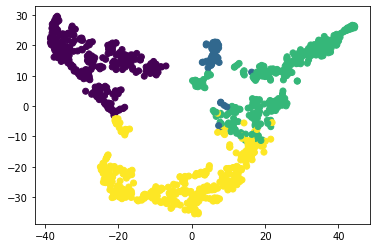

Epoch: 399, test_stats: 98.2000,test_stats: 0.1883 tensor([0.0272, 0.0224, 0.0674, 0.0712])
minimum 0.2778581


In [64]:
###In average the transfer MSE is 0.17
regressor = Regressor(dim=100,embedding = 100)
stats_regressor_CE  = torch.zeros(0,400,2)
train_acc_list,MSE_list = experiment_regression(regressor,net_CE,train_loader,test_loader,epochs= 400,lr = 0.1)  
cat_elements = torch.stack([train_acc_list,MSE_list], dim = 1).unsqueeze(0)
stats_regressor_CE = torch.cat([stats_regressor_CE , cat_elements], dim = 0)

### Output Distribution and Statistical information

In this part we investigate weather the output distribution provide information on transfer ability.

We train a model with  FIERCE that achieves a raw MSE very close to Label Smoothing and a transfer MSE lower.

We compute multiple metric and show they failed to distguinsh label smoothing and FIERCE.  

In [91]:
def mutual_information(model):
  diff = 0
  for batch_idx, (x,y) in enumerate(train_loader):
    output,__,__ = model ( x)
    logits = output.softmax(-1)
    logits_mean = logits.mean(0)
    entropy_y  = - (logits_mean * torch.log2(logits_mean)).sum()
    entropy_y_x = -(logits  * torch.log2(logits)).sum(1) 
    diff += (entropy_y_x - entropy_y).mean()
  return -diff/(batch_idx)


labels_oneh =  F.one_hot(torch.tensor(y),4)
def calc_bins(preds):
  # Assign each prediction to a bin
  num_bins = 10
  bins = np.linspace(0.1, 1, num_bins)
  binned = np.digitize(preds, bins)

  # Save the accuracy, confidence and size of each bin
  bin_accs = np.zeros(num_bins)
  bin_confs = np.zeros(num_bins)
  bin_sizes = np.zeros(num_bins)

  for bin in range(num_bins):
    bin_sizes[bin] = len(preds[binned == bin])
    if bin_sizes[bin] > 0:
      bin_accs[bin] = (labels_oneh[binned==bin]).sum() / bin_sizes[bin]
      bin_confs[bin] = (preds[binned==bin]).sum() / bin_sizes[bin]

  return bins, binned, bin_accs, bin_confs, bin_sizes

def get_metrics(preds):
  ECE = 0
  MCE = 0
  bins, _, bin_accs, bin_confs, bin_sizes = calc_bins(preds)

  for i in range(len(bins)):
    abs_conf_dif = abs(bin_accs[i] - bin_confs[i])
    ECE += (bin_sizes[i] / sum(bin_sizes)) * abs_conf_dif
    MCE = max(MCE, abs_conf_dif)

  return ECE, MCE
import matplotlib.patches as mpatches

def draw_reliability_graph(preds):
  ECE, MCE = get_metrics(preds)
  bins, _, bin_accs, _, _ = calc_bins(preds)

  fig = plt.figure(figsize=(8, 8))
  ax = fig.gca()

  # x/y limits
  ax.set_xlim(0, 1.05)
  ax.set_ylim(0, 1)

  # x/y labels
  plt.xlabel('Confidence')
  plt.ylabel('Accuracy')

  # Create grid
  ax.set_axisbelow(True) 
  ax.grid(color='gray', linestyle='dashed')

  # Error bars
  plt.bar(bins, bins,  width=0.1, alpha=0.3, edgecolor='black', color='r', hatch='\\')

  # Draw bars and identity line
  plt.bar(bins, bin_accs, width=0.1, alpha=1, edgecolor='black', color='b')
  plt.plot([0,1],[0,1], '--', color='gray', linewidth=2)

  # Equally spaced axes
  plt.gca().set_aspect('equal', adjustable='box')

  # ECE and MCE legend
  ECE_patch = mpatches.Patch(color='green', label='ECE = {:.2f}%'.format(ECE*100))
  MCE_patch = mpatches.Patch(color='red', label='MCE = {:.2f}%'.format(MCE*100))
  plt.legend(handles=[ECE_patch, MCE_patch])

  #plt.show()
  
  plt.savefig('calibrated_network.png', bbox_inches='tight')



In [92]:
def Stability(model,features_mode= False):
  all_std = 0 
  all_features = []
  all_targets = []
  all_preds = []
  for batch_idx, (x,y) in enumerate(train_loader):
    y, z  = y[:,0].long() , y[:,1:]
    output,features,__ = model ( x)
    output = output.softmax(-1)
    all_features.append(features)
    all_targets.append(y)
    all_preds.append(output)
  features = torch.cat(all_features)
  targets =  torch.cat(all_targets )
  preds =  torch.cat(all_preds )
  for i in range(4):
    if features_mode:
      #features /= features.sum(-1).unsqueeze(-1)
      single_std = ((features[targets == i,:] - features[targets == i,:].mean(0))**2).mean()
    else:
      single_std = preds[:,i].std(dim = 0)
  all_std += single_std
  return 1-all_std/4

We train a model with another hyperparameter value. This value lead to the lowest raw MSE that FIERCE can achieve (0.9) and a transfer MSE of 0.009 (averaged over 10 runs)

Epoch:   0, train_loss: -4606.01856, train_acc: 0.2991, train_mse: 0.3191, test_mse: 0.3239 tensor([0.1205, 0.0401, 0.0891, 0.0741])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:   1, train_loss: -4616.40358, train_acc: 0.2988, train_mse: 0.3202, test_mse: 0.3221 tensor([0.1206, 0.0392, 0.0883, 0.0740])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:   2, train_loss: -4612.45393, train_acc: 0.2962, train_mse: 0.3170, test_mse: 0.3208 tensor([0.1206, 0.0384, 0.0880, 0.0738])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:   3, train_loss: -4626.29226, train_acc: 0.2988, train_mse: 0.3190, test_mse: 0.3201 tensor([0.1206, 0.0378, 0.0879, 0.0738])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:   4, train_loss: -4612.14443, train_acc: 0.2963, train_mse: 0.3135, test_mse: 0.3202 tensor([0.1206, 0.0377, 0.0884, 0.0736])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:   5, train_loss: -4613.55046, train_acc: 0.2939, train_mse: 0.3146, test_mse: 0.3191 tensor([0.1204, 0.0372, 0.0880, 0.0735])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:   6, train_loss: -4625.33954, train_acc: 0.3085, train_mse: 0.3134, test_mse: 0.3184 tensor([0.1204, 0.0366, 0.0880, 0.0733])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:   7, train_loss: -4617.80702, train_acc: 0.3656, train_mse: 0.3145, test_mse: 0.3178 tensor([0.1206, 0.0361, 0.0879, 0.0732])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:   8, train_loss: -4616.04527, train_acc: 0.3096, train_mse: 0.3152, test_mse: 0.3163 tensor([0.1206, 0.0356, 0.0869, 0.0732])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:   9, train_loss: -4627.16351, train_acc: 0.3137, train_mse: 0.3114, test_mse: 0.3155 tensor([0.1203, 0.0354, 0.0867, 0.0731])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  10, train_loss: -4625.39899, train_acc: 0.3368, train_mse: 0.3088, test_mse: 0.3149 tensor([0.1204, 0.0350, 0.0865, 0.0731])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  11, train_loss: -4619.55779, train_acc: 0.4139, train_mse: 0.3121, test_mse: 0.3148 tensor([0.1203, 0.0350, 0.0865, 0.0730])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  12, train_loss: -4633.71717, train_acc: 0.6274, train_mse: 0.3133, test_mse: 0.3154 tensor([0.1203, 0.0350, 0.0868, 0.0733])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  13, train_loss: -4623.55318, train_acc: 0.6557, train_mse: 0.3096, test_mse: 0.3150 tensor([0.1203, 0.0350, 0.0867, 0.0731])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  14, train_loss: -4625.49280, train_acc: 0.6506, train_mse: 0.3089, test_mse: 0.3146 tensor([0.1204, 0.0347, 0.0864, 0.0730])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  15, train_loss: -4617.76217, train_acc: 0.6497, train_mse: 0.3118, test_mse: 0.3141 tensor([0.1202, 0.0344, 0.0865, 0.0730])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  16, train_loss: -4618.87701, train_acc: 0.6289, train_mse: 0.3099, test_mse: 0.3135 tensor([0.1202, 0.0341, 0.0863, 0.0729])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  17, train_loss: -4619.64040, train_acc: 0.6524, train_mse: 0.3087, test_mse: 0.3121 tensor([0.1199, 0.0337, 0.0858, 0.0727])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  18, train_loss: -4620.18056, train_acc: 0.6017, train_mse: 0.3105, test_mse: 0.3121 tensor([0.1197, 0.0335, 0.0860, 0.0728])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  19, train_loss: -4611.06626, train_acc: 0.5271, train_mse: 0.3066, test_mse: 0.3110 tensor([0.1193, 0.0331, 0.0859, 0.0727])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  20, train_loss: -4627.04233, train_acc: 0.5821, train_mse: 0.3068, test_mse: 0.3110 tensor([0.1190, 0.0330, 0.0862, 0.0728])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  21, train_loss: -4621.45428, train_acc: 0.4129, train_mse: 0.3090, test_mse: 0.3108 tensor([0.1192, 0.0328, 0.0859, 0.0729])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  22, train_loss: -4612.86493, train_acc: 0.3779, train_mse: 0.3049, test_mse: 0.3100 tensor([0.1188, 0.0326, 0.0858, 0.0728])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  23, train_loss: -4628.29421, train_acc: 0.4939, train_mse: 0.3045, test_mse: 0.3099 tensor([0.1189, 0.0326, 0.0861, 0.0724])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  24, train_loss: -4625.91112, train_acc: 0.6140, train_mse: 0.3056, test_mse: 0.3096 tensor([0.1188, 0.0324, 0.0861, 0.0723])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  25, train_loss: -4629.26133, train_acc: 0.5490, train_mse: 0.3063, test_mse: 0.3087 tensor([0.1184, 0.0322, 0.0857, 0.0724])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  26, train_loss: -4627.57814, train_acc: 0.5098, train_mse: 0.3049, test_mse: 0.3078 tensor([0.1178, 0.0319, 0.0858, 0.0722])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  27, train_loss: -4637.93299, train_acc: 0.5387, train_mse: 0.3017, test_mse: 0.3062 tensor([0.1171, 0.0318, 0.0854, 0.0718])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  28, train_loss: -4632.07162, train_acc: 0.5272, train_mse: 0.3015, test_mse: 0.3053 tensor([0.1168, 0.0315, 0.0852, 0.0718])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  29, train_loss: -4623.23573, train_acc: 0.6129, train_mse: 0.3022, test_mse: 0.3043 tensor([0.1168, 0.0313, 0.0848, 0.0713])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  30, train_loss: -4632.09328, train_acc: 0.6539, train_mse: 0.3009, test_mse: 0.3029 tensor([0.1166, 0.0309, 0.0848, 0.0706])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  31, train_loss: -4630.74997, train_acc: 0.6371, train_mse: 0.3008, test_mse: 0.3061 tensor([0.1186, 0.0308, 0.0856, 0.0711])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  32, train_loss: -4624.27964, train_acc: 0.6548, train_mse: 0.3012, test_mse: 0.3040 tensor([0.1172, 0.0309, 0.0853, 0.0707])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  33, train_loss: -4630.43129, train_acc: 0.6290, train_mse: 0.3006, test_mse: 0.3039 tensor([0.1174, 0.0308, 0.0851, 0.0706])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  34, train_loss: -4632.16636, train_acc: 0.6084, train_mse: 0.3009, test_mse: 0.3024 tensor([0.1168, 0.0307, 0.0847, 0.0702])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  35, train_loss: -4644.46638, train_acc: 0.5663, train_mse: 0.3004, test_mse: 0.3018 tensor([0.1163, 0.0305, 0.0846, 0.0704])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  36, train_loss: -4624.75318, train_acc: 0.5959, train_mse: 0.2976, test_mse: 0.2981 tensor([0.1148, 0.0302, 0.0832, 0.0699])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  37, train_loss: -4646.13656, train_acc: 0.6202, train_mse: 0.2920, test_mse: 0.2969 tensor([0.1142, 0.0300, 0.0835, 0.0692])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  38, train_loss: -4633.20916, train_acc: 0.6565, train_mse: 0.2956, test_mse: 0.2985 tensor([0.1151, 0.0298, 0.0845, 0.0691])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  39, train_loss: -4641.18451, train_acc: 0.6571, train_mse: 0.2940, test_mse: 0.2940 tensor([0.1124, 0.0297, 0.0835, 0.0683])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  40, train_loss: -4640.20357, train_acc: 0.5732, train_mse: 0.2895, test_mse: 0.2900 tensor([0.1089, 0.0295, 0.0824, 0.0692])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  41, train_loss: -4645.69219, train_acc: 0.5413, train_mse: 0.2883, test_mse: 0.2869 tensor([0.1083, 0.0294, 0.0813, 0.0678])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  42, train_loss: -4633.55091, train_acc: 0.5752, train_mse: 0.2844, test_mse: 0.2848 tensor([0.1073, 0.0293, 0.0815, 0.0667])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  43, train_loss: -4630.34337, train_acc: 0.6605, train_mse: 0.2822, test_mse: 0.2868 tensor([0.1104, 0.0289, 0.0819, 0.0656])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  44, train_loss: -4651.40101, train_acc: 0.6744, train_mse: 0.2819, test_mse: 0.2826 tensor([0.1077, 0.0290, 0.0810, 0.0649])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  45, train_loss: -4643.25391, train_acc: 0.6644, train_mse: 0.2790, test_mse: 0.2827 tensor([0.1063, 0.0289, 0.0816, 0.0659])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  46, train_loss: -4647.29755, train_acc: 0.6472, train_mse: 0.2768, test_mse: 0.2810 tensor([0.1054, 0.0289, 0.0816, 0.0651])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  47, train_loss: -4653.19304, train_acc: 0.6556, train_mse: 0.2778, test_mse: 0.2787 tensor([0.1042, 0.0287, 0.0811, 0.0646])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  48, train_loss: -4645.07587, train_acc: 0.6116, train_mse: 0.2749, test_mse: 0.2732 tensor([0.1002, 0.0288, 0.0796, 0.0645])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  49, train_loss: -4659.72038, train_acc: 0.6457, train_mse: 0.2716, test_mse: 0.2727 tensor([0.1012, 0.0285, 0.0799, 0.0631])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  50, train_loss: -4651.13518, train_acc: 0.6730, train_mse: 0.2696, test_mse: 0.2712 tensor([0.1010, 0.0283, 0.0801, 0.0617])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  51, train_loss: -4650.80434, train_acc: 0.6462, train_mse: 0.2696, test_mse: 0.2709 tensor([0.1001, 0.0286, 0.0796, 0.0626])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  52, train_loss: -4649.17719, train_acc: 0.6566, train_mse: 0.2675, test_mse: 0.2688 tensor([0.1005, 0.0286, 0.0791, 0.0607])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  53, train_loss: -4643.20084, train_acc: 0.6678, train_mse: 0.2648, test_mse: 0.2682 tensor([0.1005, 0.0284, 0.0799, 0.0593])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  54, train_loss: -4650.18303, train_acc: 0.6842, train_mse: 0.2688, test_mse: 0.2648 tensor([0.0995, 0.0283, 0.0787, 0.0583])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  55, train_loss: -4666.57529, train_acc: 0.6847, train_mse: 0.2573, test_mse: 0.2572 tensor([0.0945, 0.0283, 0.0768, 0.0577])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  56, train_loss: -4653.14023, train_acc: 0.6799, train_mse: 0.2530, test_mse: 0.2525 tensor([0.0916, 0.0283, 0.0761, 0.0565])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  57, train_loss: -4665.59957, train_acc: 0.6832, train_mse: 0.2503, test_mse: 0.2531 tensor([0.0932, 0.0277, 0.0785, 0.0538])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  58, train_loss: -4650.72246, train_acc: 0.6966, train_mse: 0.2557, test_mse: 0.2500 tensor([0.0910, 0.0277, 0.0779, 0.0533])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  59, train_loss: -4669.19980, train_acc: 0.6792, train_mse: 0.2468, test_mse: 0.2460 tensor([0.0860, 0.0278, 0.0791, 0.0532])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  60, train_loss: -4670.52520, train_acc: 0.6850, train_mse: 0.2409, test_mse: 0.2391 tensor([0.0826, 0.0278, 0.0776, 0.0511])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  61, train_loss: -4663.38558, train_acc: 0.6808, train_mse: 0.2405, test_mse: 0.2363 tensor([0.0816, 0.0279, 0.0756, 0.0513])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  62, train_loss: -4671.51357, train_acc: 0.7144, train_mse: 0.2312, test_mse: 0.2320 tensor([0.0809, 0.0275, 0.0745, 0.0492])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  63, train_loss: -4678.33206, train_acc: 0.7318, train_mse: 0.2268, test_mse: 0.2222 tensor([0.0760, 0.0276, 0.0714, 0.0472])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  64, train_loss: -4671.45801, train_acc: 0.7764, train_mse: 0.2250, test_mse: 0.2236 tensor([0.0776, 0.0274, 0.0718, 0.0468])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  65, train_loss: -4672.67143, train_acc: 0.7395, train_mse: 0.2181, test_mse: 0.2151 tensor([0.0703, 0.0275, 0.0719, 0.0454])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  66, train_loss: -4688.47243, train_acc: 0.6870, train_mse: 0.2164, test_mse: 0.2112 tensor([0.0673, 0.0274, 0.0716, 0.0449])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  67, train_loss: -4676.19217, train_acc: 0.7942, train_mse: 0.2100, test_mse: 0.2049 tensor([0.0671, 0.0272, 0.0676, 0.0430])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  68, train_loss: -4679.18035, train_acc: 0.7440, train_mse: 0.2097, test_mse: 0.2056 tensor([0.0664, 0.0277, 0.0687, 0.0428])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  69, train_loss: -4688.60376, train_acc: 0.7765, train_mse: 0.2016, test_mse: 0.1952 tensor([0.0616, 0.0277, 0.0656, 0.0403])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  70, train_loss: -4694.66101, train_acc: 0.7410, train_mse: 0.1947, test_mse: 0.1912 tensor([0.0541, 0.0281, 0.0672, 0.0418])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  71, train_loss: -4696.43220, train_acc: 0.7380, train_mse: 0.1859, test_mse: 0.1885 tensor([0.0485, 0.0285, 0.0676, 0.0438])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  72, train_loss: -4714.54705, train_acc: 0.7375, train_mse: 0.1811, test_mse: 0.1766 tensor([0.0516, 0.0281, 0.0600, 0.0370])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  73, train_loss: -4701.12558, train_acc: 0.8195, train_mse: 0.1768, test_mse: 0.1742 tensor([0.0530, 0.0280, 0.0585, 0.0347])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  74, train_loss: -4700.01514, train_acc: 0.8220, train_mse: 0.1730, test_mse: 0.1725 tensor([0.0517, 0.0275, 0.0610, 0.0324])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  75, train_loss: -4710.33402, train_acc: 0.8011, train_mse: 0.1708, test_mse: 0.1688 tensor([0.0477, 0.0278, 0.0599, 0.0334])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  76, train_loss: -4709.98677, train_acc: 0.7871, train_mse: 0.1708, test_mse: 0.1685 tensor([0.0493, 0.0274, 0.0598, 0.0319])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  77, train_loss: -4706.56838, train_acc: 0.7889, train_mse: 0.1706, test_mse: 0.1690 tensor([0.0439, 0.0281, 0.0630, 0.0340])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  78, train_loss: -4707.57368, train_acc: 0.7684, train_mse: 0.1697, test_mse: 0.1589 tensor([0.0440, 0.0277, 0.0582, 0.0290])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  79, train_loss: -4714.48097, train_acc: 0.7897, train_mse: 0.1601, test_mse: 0.1580 tensor([0.0423, 0.0274, 0.0602, 0.0280])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  80, train_loss: -4724.94707, train_acc: 0.8006, train_mse: 0.1588, test_mse: 0.1562 tensor([0.0395, 0.0277, 0.0607, 0.0284])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  81, train_loss: -4712.84940, train_acc: 0.8123, train_mse: 0.1537, test_mse: 0.1483 tensor([0.0409, 0.0277, 0.0534, 0.0262])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  82, train_loss: -4721.39157, train_acc: 0.8727, train_mse: 0.1476, test_mse: 0.1421 tensor([0.0351, 0.0288, 0.0507, 0.0275])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  83, train_loss: -4722.33675, train_acc: 0.8060, train_mse: 0.1441, test_mse: 0.1397 tensor([0.0370, 0.0273, 0.0529, 0.0225])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  84, train_loss: -4724.38115, train_acc: 0.8457, train_mse: 0.1442, test_mse: 0.1406 tensor([0.0334, 0.0286, 0.0523, 0.0264])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  85, train_loss: -4720.36400, train_acc: 0.8084, train_mse: 0.1459, test_mse: 0.1311 tensor([0.0351, 0.0278, 0.0468, 0.0214])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  86, train_loss: -4717.97606, train_acc: 0.8858, train_mse: 0.1305, test_mse: 0.1210 tensor([0.0269, 0.0286, 0.0440, 0.0215])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  87, train_loss: -4738.16543, train_acc: 0.8526, train_mse: 0.1246, test_mse: 0.1179 tensor([0.0234, 0.0291, 0.0426, 0.0227])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  88, train_loss: -4752.96759, train_acc: 0.8294, train_mse: 0.1245, test_mse: 0.1202 tensor([0.0238, 0.0281, 0.0473, 0.0209])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  89, train_loss: -4739.79642, train_acc: 0.8427, train_mse: 0.1225, test_mse: 0.1311 tensor([0.0218, 0.0294, 0.0506, 0.0294])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  90, train_loss: -4739.35281, train_acc: 0.8560, train_mse: 0.1252, test_mse: 0.1126 tensor([0.0272, 0.0280, 0.0393, 0.0182])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  91, train_loss: -4737.20334, train_acc: 0.8788, train_mse: 0.1254, test_mse: 0.1273 tensor([0.0274, 0.0290, 0.0472, 0.0237])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  92, train_loss: -4730.02528, train_acc: 0.8651, train_mse: 0.1233, test_mse: 0.1177 tensor([0.0269, 0.0278, 0.0452, 0.0178])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  93, train_loss: -4737.20365, train_acc: 0.8678, train_mse: 0.1194, test_mse: 0.1175 tensor([0.0233, 0.0282, 0.0459, 0.0201])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  94, train_loss: -4748.79846, train_acc: 0.8614, train_mse: 0.1153, test_mse: 0.1082 tensor([0.0219, 0.0283, 0.0405, 0.0174])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  95, train_loss: -4747.21336, train_acc: 0.8476, train_mse: 0.1163, test_mse: 0.1153 tensor([0.0209, 0.0292, 0.0427, 0.0225])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  96, train_loss: -4752.17242, train_acc: 0.8801, train_mse: 0.1131, test_mse: 0.1061 tensor([0.0256, 0.0281, 0.0362, 0.0162])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  97, train_loss: -4754.82404, train_acc: 0.8779, train_mse: 0.1151, test_mse: 0.1189 tensor([0.0240, 0.0309, 0.0376, 0.0264])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  98, train_loss: -4731.71452, train_acc: 0.8896, train_mse: 0.1126, test_mse: 0.1054 tensor([0.0240, 0.0286, 0.0365, 0.0163])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  99, train_loss: -4759.34167, train_acc: 0.8789, train_mse: 0.1075, test_mse: 0.1001 tensor([0.0203, 0.0288, 0.0349, 0.0161])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 100, train_loss: -4740.84379, train_acc: 0.8903, train_mse: 0.1037, test_mse: 0.1026 tensor([0.0200, 0.0292, 0.0357, 0.0177])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 101, train_loss: -4766.42792, train_acc: 0.8698, train_mse: 0.1082, test_mse: 0.1073 tensor([0.0185, 0.0298, 0.0376, 0.0214])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 102, train_loss: -4747.60068, train_acc: 0.8678, train_mse: 0.1094, test_mse: 0.1063 tensor([0.0185, 0.0297, 0.0373, 0.0208])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 103, train_loss: -4746.32841, train_acc: 0.8553, train_mse: 0.1128, test_mse: 0.1083 tensor([0.0178, 0.0299, 0.0380, 0.0225])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 104, train_loss: -4759.16964, train_acc: 0.8598, train_mse: 0.1110, test_mse: 0.1072 tensor([0.0179, 0.0299, 0.0375, 0.0219])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 105, train_loss: -4757.15531, train_acc: 0.8580, train_mse: 0.1109, test_mse: 0.1082 tensor([0.0180, 0.0298, 0.0384, 0.0221])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 106, train_loss: -4752.88995, train_acc: 0.8661, train_mse: 0.1092, test_mse: 0.1067 tensor([0.0182, 0.0296, 0.0379, 0.0209])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 107, train_loss: -4763.30088, train_acc: 0.8680, train_mse: 0.1081, test_mse: 0.1048 tensor([0.0182, 0.0295, 0.0372, 0.0199])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 108, train_loss: -4750.40018, train_acc: 0.8690, train_mse: 0.1087, test_mse: 0.1050 tensor([0.0181, 0.0295, 0.0371, 0.0202])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 109, train_loss: -4752.35449, train_acc: 0.8685, train_mse: 0.1096, test_mse: 0.1053 tensor([0.0180, 0.0295, 0.0374, 0.0203])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 110, train_loss: -4757.32192, train_acc: 0.8684, train_mse: 0.1102, test_mse: 0.1062 tensor([0.0181, 0.0295, 0.0381, 0.0206])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 111, train_loss: -4760.35435, train_acc: 0.8629, train_mse: 0.1131, test_mse: 0.1051 tensor([0.0180, 0.0294, 0.0378, 0.0199])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 112, train_loss: -4757.08107, train_acc: 0.8656, train_mse: 0.1112, test_mse: 0.1055 tensor([0.0179, 0.0294, 0.0379, 0.0202])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 113, train_loss: -4752.90505, train_acc: 0.8577, train_mse: 0.1112, test_mse: 0.1074 tensor([0.0174, 0.0297, 0.0383, 0.0219])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 114, train_loss: -4764.44908, train_acc: 0.8684, train_mse: 0.1087, test_mse: 0.1053 tensor([0.0177, 0.0296, 0.0373, 0.0208])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 115, train_loss: -4758.09422, train_acc: 0.8699, train_mse: 0.1114, test_mse: 0.1037 tensor([0.0177, 0.0296, 0.0363, 0.0200])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 116, train_loss: -4760.95990, train_acc: 0.8771, train_mse: 0.1057, test_mse: 0.1025 tensor([0.0176, 0.0294, 0.0364, 0.0192])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 117, train_loss: -4754.12336, train_acc: 0.8791, train_mse: 0.1048, test_mse: 0.1005 tensor([0.0176, 0.0294, 0.0352, 0.0183])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 118, train_loss: -4760.31420, train_acc: 0.8794, train_mse: 0.1058, test_mse: 0.0988 tensor([0.0176, 0.0294, 0.0342, 0.0177])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 119, train_loss: -4754.57422, train_acc: 0.8907, train_mse: 0.1032, test_mse: 0.0977 tensor([0.0177, 0.0293, 0.0336, 0.0171])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 120, train_loss: -4757.68880, train_acc: 0.8863, train_mse: 0.1029, test_mse: 0.0997 tensor([0.0171, 0.0296, 0.0342, 0.0188])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 121, train_loss: -4771.86586, train_acc: 0.8850, train_mse: 0.1031, test_mse: 0.0977 tensor([0.0174, 0.0294, 0.0335, 0.0175])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 122, train_loss: -4759.57479, train_acc: 0.8836, train_mse: 0.1025, test_mse: 0.1004 tensor([0.0166, 0.0297, 0.0346, 0.0195])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 123, train_loss: -4760.24520, train_acc: 0.8760, train_mse: 0.1035, test_mse: 0.1006 tensor([0.0163, 0.0298, 0.0345, 0.0199])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 124, train_loss: -4756.41969, train_acc: 0.8765, train_mse: 0.1056, test_mse: 0.0984 tensor([0.0169, 0.0295, 0.0339, 0.0182])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 125, train_loss: -4759.13325, train_acc: 0.8898, train_mse: 0.1013, test_mse: 0.0979 tensor([0.0170, 0.0294, 0.0339, 0.0176])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 126, train_loss: -4758.54532, train_acc: 0.8912, train_mse: 0.1003, test_mse: 0.0969 tensor([0.0172, 0.0294, 0.0330, 0.0173])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 127, train_loss: -4747.83428, train_acc: 0.8860, train_mse: 0.1018, test_mse: 0.0979 tensor([0.0170, 0.0296, 0.0331, 0.0182])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 128, train_loss: -4755.59718, train_acc: 0.8921, train_mse: 0.1009, test_mse: 0.0976 tensor([0.0164, 0.0299, 0.0326, 0.0188])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 129, train_loss: -4765.92698, train_acc: 0.8811, train_mse: 0.1026, test_mse: 0.0994 tensor([0.0160, 0.0302, 0.0329, 0.0204])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 130, train_loss: -4765.61503, train_acc: 0.8845, train_mse: 0.1017, test_mse: 0.0979 tensor([0.0162, 0.0300, 0.0324, 0.0193])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 131, train_loss: -4764.35194, train_acc: 0.8882, train_mse: 0.1022, test_mse: 0.0948 tensor([0.0168, 0.0298, 0.0309, 0.0174])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 132, train_loss: -4752.62407, train_acc: 0.8964, train_mse: 0.0994, test_mse: 0.0947 tensor([0.0166, 0.0297, 0.0311, 0.0173])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 133, train_loss: -4751.26511, train_acc: 0.8906, train_mse: 0.0994, test_mse: 0.0973 tensor([0.0162, 0.0299, 0.0323, 0.0189])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 134, train_loss: -4758.58603, train_acc: 0.8900, train_mse: 0.1012, test_mse: 0.0969 tensor([0.0161, 0.0299, 0.0322, 0.0187])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 135, train_loss: -4750.52998, train_acc: 0.8874, train_mse: 0.1003, test_mse: 0.0969 tensor([0.0160, 0.0298, 0.0325, 0.0186])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 136, train_loss: -4759.81813, train_acc: 0.8815, train_mse: 0.1043, test_mse: 0.0999 tensor([0.0156, 0.0300, 0.0339, 0.0205])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 137, train_loss: -4769.22487, train_acc: 0.8788, train_mse: 0.1052, test_mse: 0.0992 tensor([0.0156, 0.0300, 0.0336, 0.0200])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 138, train_loss: -4762.10038, train_acc: 0.8806, train_mse: 0.1040, test_mse: 0.0977 tensor([0.0156, 0.0298, 0.0333, 0.0191])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 139, train_loss: -4763.36954, train_acc: 0.8844, train_mse: 0.1005, test_mse: 0.0969 tensor([0.0159, 0.0296, 0.0332, 0.0182])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 140, train_loss: -4773.10513, train_acc: 0.8834, train_mse: 0.1012, test_mse: 0.1005 tensor([0.0153, 0.0299, 0.0347, 0.0206])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 141, train_loss: -4769.69640, train_acc: 0.8708, train_mse: 0.1049, test_mse: 0.1002 tensor([0.0156, 0.0297, 0.0349, 0.0199])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 142, train_loss: -4761.94385, train_acc: 0.8658, train_mse: 0.1071, test_mse: 0.1008 tensor([0.0155, 0.0298, 0.0350, 0.0204])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 143, train_loss: -4768.92153, train_acc: 0.8729, train_mse: 0.1060, test_mse: 0.1006 tensor([0.0155, 0.0298, 0.0349, 0.0203])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 144, train_loss: -4752.47127, train_acc: 0.8747, train_mse: 0.1025, test_mse: 0.0989 tensor([0.0157, 0.0297, 0.0341, 0.0194])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 145, train_loss: -4764.67966, train_acc: 0.8818, train_mse: 0.1025, test_mse: 0.0989 tensor([0.0156, 0.0298, 0.0339, 0.0197])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 146, train_loss: -4759.89720, train_acc: 0.8800, train_mse: 0.1022, test_mse: 0.0997 tensor([0.0152, 0.0300, 0.0340, 0.0205])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 147, train_loss: -4772.36307, train_acc: 0.8740, train_mse: 0.1049, test_mse: 0.1008 tensor([0.0153, 0.0301, 0.0342, 0.0212])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 148, train_loss: -4760.05102, train_acc: 0.8751, train_mse: 0.1057, test_mse: 0.0992 tensor([0.0158, 0.0298, 0.0338, 0.0198])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 149, train_loss: -4770.09773, train_acc: 0.8872, train_mse: 0.1024, test_mse: 0.0963 tensor([0.0161, 0.0297, 0.0324, 0.0181])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 150, train_loss: -4754.00569, train_acc: 0.8969, train_mse: 0.0977, test_mse: 0.0944 tensor([0.0162, 0.0298, 0.0310, 0.0174])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 151, train_loss: -4765.55674, train_acc: 0.8969, train_mse: 0.0990, test_mse: 0.0944 tensor([0.0161, 0.0298, 0.0310, 0.0175])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 152, train_loss: -4762.16624, train_acc: 0.8968, train_mse: 0.0998, test_mse: 0.0955 tensor([0.0162, 0.0299, 0.0314, 0.0181])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 153, train_loss: -4762.38009, train_acc: 0.8917, train_mse: 0.1024, test_mse: 0.0964 tensor([0.0161, 0.0298, 0.0322, 0.0183])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 154, train_loss: -4767.31726, train_acc: 0.8892, train_mse: 0.1017, test_mse: 0.0958 tensor([0.0162, 0.0298, 0.0318, 0.0181])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 155, train_loss: -4770.99774, train_acc: 0.8895, train_mse: 0.1000, test_mse: 0.0977 tensor([0.0156, 0.0300, 0.0325, 0.0196])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 156, train_loss: -4765.48445, train_acc: 0.8901, train_mse: 0.1006, test_mse: 0.0964 tensor([0.0157, 0.0299, 0.0321, 0.0187])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 157, train_loss: -4764.93298, train_acc: 0.8884, train_mse: 0.1004, test_mse: 0.0956 tensor([0.0157, 0.0299, 0.0315, 0.0186])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 158, train_loss: -4755.50829, train_acc: 0.8949, train_mse: 0.0988, test_mse: 0.0951 tensor([0.0159, 0.0298, 0.0315, 0.0180])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 159, train_loss: -4763.44598, train_acc: 0.8922, train_mse: 0.1002, test_mse: 0.0953 tensor([0.0155, 0.0298, 0.0317, 0.0183])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 160, train_loss: -4764.96757, train_acc: 0.8933, train_mse: 0.0986, test_mse: 0.0956 tensor([0.0152, 0.0299, 0.0317, 0.0187])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 161, train_loss: -4760.54361, train_acc: 0.8933, train_mse: 0.0985, test_mse: 0.0943 tensor([0.0156, 0.0297, 0.0313, 0.0176])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 162, train_loss: -4758.58959, train_acc: 0.8870, train_mse: 0.0996, test_mse: 0.0978 tensor([0.0151, 0.0301, 0.0326, 0.0200])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 163, train_loss: -4769.49265, train_acc: 0.8826, train_mse: 0.1037, test_mse: 0.1002 tensor([0.0150, 0.0301, 0.0338, 0.0212])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 164, train_loss: -4750.86682, train_acc: 0.8775, train_mse: 0.1065, test_mse: 0.1012 tensor([0.0148, 0.0302, 0.0343, 0.0219])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 165, train_loss: -4757.27543, train_acc: 0.8760, train_mse: 0.1043, test_mse: 0.1007 tensor([0.0150, 0.0300, 0.0344, 0.0212])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 166, train_loss: -4763.74923, train_acc: 0.8823, train_mse: 0.1023, test_mse: 0.0994 tensor([0.0152, 0.0300, 0.0338, 0.0204])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 167, train_loss: -4771.85879, train_acc: 0.8787, train_mse: 0.1027, test_mse: 0.0987 tensor([0.0150, 0.0301, 0.0330, 0.0206])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 168, train_loss: -4765.29009, train_acc: 0.8891, train_mse: 0.1006, test_mse: 0.0973 tensor([0.0151, 0.0300, 0.0325, 0.0197])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 169, train_loss: -4772.22792, train_acc: 0.8768, train_mse: 0.1052, test_mse: 0.0989 tensor([0.0146, 0.0303, 0.0328, 0.0212])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 170, train_loss: -4760.04099, train_acc: 0.8772, train_mse: 0.1064, test_mse: 0.0982 tensor([0.0147, 0.0303, 0.0324, 0.0209])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 171, train_loss: -4766.09850, train_acc: 0.8856, train_mse: 0.1012, test_mse: 0.0966 tensor([0.0148, 0.0302, 0.0318, 0.0198])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 172, train_loss: -4772.57312, train_acc: 0.8902, train_mse: 0.1002, test_mse: 0.0960 tensor([0.0149, 0.0302, 0.0314, 0.0196])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 173, train_loss: -4773.55670, train_acc: 0.8949, train_mse: 0.0980, test_mse: 0.0939 tensor([0.0152, 0.0300, 0.0305, 0.0182])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 174, train_loss: -4758.97948, train_acc: 0.8933, train_mse: 0.0987, test_mse: 0.0981 tensor([0.0143, 0.0304, 0.0321, 0.0213])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 175, train_loss: -4758.08235, train_acc: 0.8890, train_mse: 0.1005, test_mse: 0.0978 tensor([0.0145, 0.0303, 0.0322, 0.0208])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 176, train_loss: -4762.51898, train_acc: 0.8768, train_mse: 0.1029, test_mse: 0.0996 tensor([0.0143, 0.0304, 0.0330, 0.0219])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 177, train_loss: -4767.23599, train_acc: 0.8882, train_mse: 0.1008, test_mse: 0.0980 tensor([0.0148, 0.0302, 0.0324, 0.0206])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 178, train_loss: -4768.64703, train_acc: 0.8878, train_mse: 0.1000, test_mse: 0.0977 tensor([0.0148, 0.0302, 0.0322, 0.0205])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 179, train_loss: -4755.54320, train_acc: 0.8857, train_mse: 0.1009, test_mse: 0.0965 tensor([0.0152, 0.0300, 0.0320, 0.0194])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 180, train_loss: -4749.00021, train_acc: 0.8934, train_mse: 0.0996, test_mse: 0.0965 tensor([0.0153, 0.0300, 0.0319, 0.0192])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 181, train_loss: -4765.52658, train_acc: 0.8846, train_mse: 0.1035, test_mse: 0.0961 tensor([0.0154, 0.0300, 0.0316, 0.0191])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 182, train_loss: -4769.17718, train_acc: 0.8899, train_mse: 0.1023, test_mse: 0.0948 tensor([0.0158, 0.0298, 0.0314, 0.0179])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 183, train_loss: -4765.03713, train_acc: 0.8969, train_mse: 0.0985, test_mse: 0.0939 tensor([0.0157, 0.0298, 0.0307, 0.0177])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 184, train_loss: -4752.05023, train_acc: 0.9004, train_mse: 0.0988, test_mse: 0.0920 tensor([0.0162, 0.0296, 0.0299, 0.0163])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 185, train_loss: -4762.94113, train_acc: 0.9027, train_mse: 0.0951, test_mse: 0.0928 tensor([0.0160, 0.0297, 0.0302, 0.0169])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 186, train_loss: -4758.16962, train_acc: 0.8992, train_mse: 0.0954, test_mse: 0.0913 tensor([0.0160, 0.0297, 0.0294, 0.0163])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 187, train_loss: -4761.80115, train_acc: 0.9010, train_mse: 0.0956, test_mse: 0.0929 tensor([0.0151, 0.0300, 0.0298, 0.0179])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 188, train_loss: -4777.76436, train_acc: 0.8981, train_mse: 0.0981, test_mse: 0.0963 tensor([0.0145, 0.0304, 0.0309, 0.0204])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 189, train_loss: -4765.15175, train_acc: 0.8926, train_mse: 0.1004, test_mse: 0.0973 tensor([0.0144, 0.0305, 0.0312, 0.0212])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 190, train_loss: -4770.01198, train_acc: 0.8904, train_mse: 0.1007, test_mse: 0.0987 tensor([0.0143, 0.0306, 0.0317, 0.0220])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 191, train_loss: -4769.72837, train_acc: 0.8827, train_mse: 0.1036, test_mse: 0.1005 tensor([0.0144, 0.0307, 0.0326, 0.0229])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 192, train_loss: -4761.43161, train_acc: 0.8852, train_mse: 0.1029, test_mse: 0.0995 tensor([0.0148, 0.0305, 0.0323, 0.0220])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 193, train_loss: -4759.20224, train_acc: 0.8868, train_mse: 0.1017, test_mse: 0.0963 tensor([0.0150, 0.0303, 0.0313, 0.0198])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 194, train_loss: -4753.92246, train_acc: 0.8938, train_mse: 0.1004, test_mse: 0.0960 tensor([0.0149, 0.0303, 0.0310, 0.0198])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 195, train_loss: -4773.53455, train_acc: 0.8941, train_mse: 0.1001, test_mse: 0.0961 tensor([0.0148, 0.0304, 0.0307, 0.0202])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 196, train_loss: -4764.10987, train_acc: 0.8939, train_mse: 0.1025, test_mse: 0.0969 tensor([0.0147, 0.0305, 0.0310, 0.0208])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 197, train_loss: -4776.08149, train_acc: 0.8929, train_mse: 0.1002, test_mse: 0.0963 tensor([0.0147, 0.0303, 0.0310, 0.0202])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 198, train_loss: -4764.81956, train_acc: 0.8973, train_mse: 0.0982, test_mse: 0.0937 tensor([0.0148, 0.0302, 0.0299, 0.0187])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 199, train_loss: -4774.38188, train_acc: 0.8985, train_mse: 0.0980, test_mse: 0.0952 tensor([0.0143, 0.0304, 0.0306, 0.0199])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


final entropy:  289801.5852987305


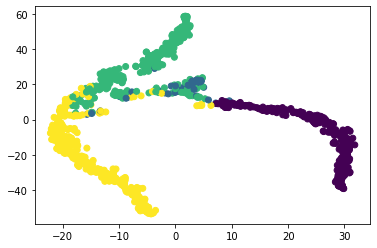

Epoch: 199, test_stats: 88.1000,test_stats: 0.0990 tensor([0.0144, 0.0362, 0.0293, 0.0192])
minimum achieved 0.0951468
Epoch:   0, train_loss: 3.49528, train_acc: 0.8731, train_mse: 0.0717, test_mse: 0.0358 tensor([0.0019, 0.0161, 0.0122, 0.0057])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:   1, train_loss: 1.73456, train_acc: 0.9058, train_mse: 0.0356, test_mse: 0.0299 tensor([0.0020, 0.0131, 0.0099, 0.0050])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:   2, train_loss: 1.57190, train_acc: 0.9192, train_mse: 0.0318, test_mse: 0.0275 tensor([0.0019, 0.0121, 0.0089, 0.0045])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:   3, train_loss: 1.45186, train_acc: 0.9227, train_mse: 0.0303, test_mse: 0.0261 tensor([0.0020, 0.0116, 0.0085, 0.0040])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:   4, train_loss: 1.37648, train_acc: 0.9244, train_mse: 0.0278, test_mse: 0.0249 tensor([0.0020, 0.0111, 0.0082, 0.0036])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:   5, train_loss: 1.31488, train_acc: 0.9265, train_mse: 0.0270, test_mse: 0.0257 tensor([0.0021, 0.0114, 0.0088, 0.0034])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:   6, train_loss: 1.27275, train_acc: 0.9243, train_mse: 0.0261, test_mse: 0.0226 tensor([0.0021, 0.0104, 0.0070, 0.0031])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:   7, train_loss: 1.21892, train_acc: 0.9310, train_mse: 0.0246, test_mse: 0.0219 tensor([0.0019, 0.0102, 0.0067, 0.0030])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:   8, train_loss: 1.18850, train_acc: 0.9320, train_mse: 0.0240, test_mse: 0.0214 tensor([0.0020, 0.0100, 0.0064, 0.0030])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:   9, train_loss: 1.16157, train_acc: 0.9314, train_mse: 0.0235, test_mse: 0.0206 tensor([0.0019, 0.0098, 0.0063, 0.0025])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  10, train_loss: 1.13051, train_acc: 0.9339, train_mse: 0.0227, test_mse: 0.0208 tensor([0.0019, 0.0100, 0.0064, 0.0025])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  11, train_loss: 1.11816, train_acc: 0.9277, train_mse: 0.0232, test_mse: 0.0208 tensor([0.0019, 0.0102, 0.0061, 0.0026])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  12, train_loss: 1.10675, train_acc: 0.9355, train_mse: 0.0223, test_mse: 0.0196 tensor([0.0018, 0.0094, 0.0058, 0.0026])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  13, train_loss: 1.07044, train_acc: 0.9339, train_mse: 0.0220, test_mse: 0.0195 tensor([0.0018, 0.0095, 0.0059, 0.0022])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  14, train_loss: 1.05831, train_acc: 0.9364, train_mse: 0.0214, test_mse: 0.0193 tensor([0.0018, 0.0093, 0.0055, 0.0027])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  15, train_loss: 1.04439, train_acc: 0.9315, train_mse: 0.0213, test_mse: 0.0189 tensor([0.0017, 0.0096, 0.0055, 0.0021])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  16, train_loss: 1.03423, train_acc: 0.9377, train_mse: 0.0208, test_mse: 0.0180 tensor([0.0017, 0.0091, 0.0051, 0.0020])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  17, train_loss: 1.01236, train_acc: 0.9390, train_mse: 0.0203, test_mse: 0.0179 tensor([0.0017, 0.0091, 0.0052, 0.0020])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  18, train_loss: 1.00111, train_acc: 0.9370, train_mse: 0.0201, test_mse: 0.0179 tensor([0.0016, 0.0091, 0.0051, 0.0020])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  19, train_loss: 0.98777, train_acc: 0.9385, train_mse: 0.0200, test_mse: 0.0175 tensor([0.0017, 0.0090, 0.0049, 0.0019])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  20, train_loss: 0.97575, train_acc: 0.9381, train_mse: 0.0197, test_mse: 0.0176 tensor([0.0016, 0.0091, 0.0049, 0.0020])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  21, train_loss: 0.96650, train_acc: 0.9385, train_mse: 0.0197, test_mse: 0.0171 tensor([0.0015, 0.0088, 0.0049, 0.0018])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  22, train_loss: 0.96669, train_acc: 0.9382, train_mse: 0.0195, test_mse: 0.0171 tensor([0.0016, 0.0087, 0.0048, 0.0020])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  23, train_loss: 0.95663, train_acc: 0.9397, train_mse: 0.0193, test_mse: 0.0167 tensor([0.0015, 0.0086, 0.0046, 0.0019])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  24, train_loss: 0.93363, train_acc: 0.9370, train_mse: 0.0194, test_mse: 0.0175 tensor([0.0016, 0.0088, 0.0052, 0.0019])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  25, train_loss: 0.97229, train_acc: 0.9384, train_mse: 0.0195, test_mse: 0.0164 tensor([0.0014, 0.0087, 0.0045, 0.0018])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  26, train_loss: 0.91888, train_acc: 0.9404, train_mse: 0.0185, test_mse: 0.0166 tensor([0.0014, 0.0085, 0.0050, 0.0018])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  27, train_loss: 0.91359, train_acc: 0.9372, train_mse: 0.0188, test_mse: 0.0163 tensor([0.0014, 0.0085, 0.0046, 0.0018])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  28, train_loss: 0.91126, train_acc: 0.9406, train_mse: 0.0191, test_mse: 0.0158 tensor([0.0013, 0.0084, 0.0044, 0.0018])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  29, train_loss: 0.89816, train_acc: 0.9369, train_mse: 0.0187, test_mse: 0.0167 tensor([0.0013, 0.0089, 0.0046, 0.0018])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  30, train_loss: 0.88572, train_acc: 0.9400, train_mse: 0.0181, test_mse: 0.0156 tensor([0.0013, 0.0082, 0.0044, 0.0017])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  31, train_loss: 0.87504, train_acc: 0.9407, train_mse: 0.0177, test_mse: 0.0160 tensor([0.0013, 0.0083, 0.0047, 0.0017])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  32, train_loss: 0.86928, train_acc: 0.9398, train_mse: 0.0175, test_mse: 0.0157 tensor([0.0014, 0.0081, 0.0046, 0.0016])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  33, train_loss: 0.87195, train_acc: 0.9378, train_mse: 0.0176, test_mse: 0.0151 tensor([0.0012, 0.0079, 0.0042, 0.0017])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  34, train_loss: 0.85783, train_acc: 0.9361, train_mse: 0.0175, test_mse: 0.0150 tensor([0.0012, 0.0081, 0.0042, 0.0016])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  35, train_loss: 0.86209, train_acc: 0.9361, train_mse: 0.0174, test_mse: 0.0161 tensor([0.0012, 0.0080, 0.0046, 0.0024])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  36, train_loss: 0.86519, train_acc: 0.9386, train_mse: 0.0175, test_mse: 0.0153 tensor([0.0014, 0.0080, 0.0042, 0.0016])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  37, train_loss: 0.84686, train_acc: 0.9429, train_mse: 0.0171, test_mse: 0.0152 tensor([0.0014, 0.0078, 0.0042, 0.0019])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  38, train_loss: 0.83881, train_acc: 0.9410, train_mse: 0.0169, test_mse: 0.0163 tensor([0.0013, 0.0081, 0.0048, 0.0021])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  39, train_loss: 0.83875, train_acc: 0.9414, train_mse: 0.0175, test_mse: 0.0151 tensor([0.0012, 0.0080, 0.0043, 0.0016])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  40, train_loss: 0.82019, train_acc: 0.9395, train_mse: 0.0166, test_mse: 0.0143 tensor([0.0011, 0.0076, 0.0040, 0.0016])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  41, train_loss: 0.81090, train_acc: 0.9380, train_mse: 0.0164, test_mse: 0.0146 tensor([0.0011, 0.0075, 0.0041, 0.0018])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  42, train_loss: 0.81929, train_acc: 0.9392, train_mse: 0.0164, test_mse: 0.0143 tensor([0.0011, 0.0076, 0.0041, 0.0015])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  43, train_loss: 0.80973, train_acc: 0.9344, train_mse: 0.0166, test_mse: 0.0143 tensor([0.0011, 0.0076, 0.0041, 0.0016])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  44, train_loss: 0.80540, train_acc: 0.9391, train_mse: 0.0165, test_mse: 0.0141 tensor([0.0011, 0.0076, 0.0039, 0.0015])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  45, train_loss: 0.79203, train_acc: 0.9397, train_mse: 0.0169, test_mse: 0.0182 tensor([0.0012, 0.0100, 0.0054, 0.0017])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  46, train_loss: 0.88270, train_acc: 0.9325, train_mse: 0.0181, test_mse: 0.0138 tensor([0.0011, 0.0073, 0.0039, 0.0016])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  47, train_loss: 0.79343, train_acc: 0.9402, train_mse: 0.0161, test_mse: 0.0147 tensor([0.0011, 0.0079, 0.0042, 0.0015])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  48, train_loss: 0.77861, train_acc: 0.9411, train_mse: 0.0158, test_mse: 0.0137 tensor([0.0010, 0.0071, 0.0038, 0.0017])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  49, train_loss: 0.77569, train_acc: 0.9411, train_mse: 0.0160, test_mse: 0.0147 tensor([0.0010, 0.0078, 0.0044, 0.0015])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  50, train_loss: 0.78818, train_acc: 0.9406, train_mse: 0.0159, test_mse: 0.0136 tensor([0.0010, 0.0072, 0.0038, 0.0015])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  51, train_loss: 0.77376, train_acc: 0.9430, train_mse: 0.0156, test_mse: 0.0135 tensor([0.0010, 0.0070, 0.0040, 0.0015])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  52, train_loss: 0.76525, train_acc: 0.9422, train_mse: 0.0155, test_mse: 0.0143 tensor([0.0010, 0.0076, 0.0040, 0.0016])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  53, train_loss: 0.75654, train_acc: 0.9409, train_mse: 0.0153, test_mse: 0.0141 tensor([0.0010, 0.0075, 0.0041, 0.0015])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  54, train_loss: 0.76103, train_acc: 0.9412, train_mse: 0.0156, test_mse: 0.0136 tensor([0.0010, 0.0071, 0.0040, 0.0015])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  55, train_loss: 0.75036, train_acc: 0.9422, train_mse: 0.0150, test_mse: 0.0131 tensor([0.0009, 0.0069, 0.0037, 0.0015])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  56, train_loss: 0.73843, train_acc: 0.9432, train_mse: 0.0149, test_mse: 0.0132 tensor([0.0009, 0.0071, 0.0037, 0.0015])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  57, train_loss: 0.73884, train_acc: 0.9421, train_mse: 0.0149, test_mse: 0.0131 tensor([0.0009, 0.0068, 0.0038, 0.0015])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  58, train_loss: 0.73177, train_acc: 0.9430, train_mse: 0.0153, test_mse: 0.0143 tensor([0.0009, 0.0076, 0.0036, 0.0021])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  59, train_loss: 0.75358, train_acc: 0.9423, train_mse: 0.0152, test_mse: 0.0130 tensor([0.0010, 0.0067, 0.0037, 0.0016])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  60, train_loss: 0.72306, train_acc: 0.9419, train_mse: 0.0147, test_mse: 0.0129 tensor([0.0009, 0.0067, 0.0037, 0.0016])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  61, train_loss: 0.73477, train_acc: 0.9428, train_mse: 0.0149, test_mse: 0.0127 tensor([0.0009, 0.0066, 0.0036, 0.0016])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  62, train_loss: 0.73314, train_acc: 0.9411, train_mse: 0.0150, test_mse: 0.0127 tensor([0.0009, 0.0067, 0.0036, 0.0016])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  63, train_loss: 0.71632, train_acc: 0.9435, train_mse: 0.0145, test_mse: 0.0128 tensor([0.0009, 0.0068, 0.0035, 0.0015])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  64, train_loss: 0.71406, train_acc: 0.9395, train_mse: 0.0144, test_mse: 0.0125 tensor([0.0009, 0.0065, 0.0035, 0.0016])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  65, train_loss: 0.70439, train_acc: 0.9451, train_mse: 0.0143, test_mse: 0.0133 tensor([0.0009, 0.0070, 0.0039, 0.0016])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  66, train_loss: 0.70924, train_acc: 0.9421, train_mse: 0.0146, test_mse: 0.0126 tensor([0.0010, 0.0065, 0.0036, 0.0015])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  67, train_loss: 0.70754, train_acc: 0.9442, train_mse: 0.0148, test_mse: 0.0131 tensor([0.0009, 0.0069, 0.0038, 0.0015])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  68, train_loss: 0.71002, train_acc: 0.9366, train_mse: 0.0143, test_mse: 0.0133 tensor([0.0009, 0.0066, 0.0035, 0.0023])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  69, train_loss: 0.69241, train_acc: 0.9440, train_mse: 0.0140, test_mse: 0.0124 tensor([0.0009, 0.0062, 0.0037, 0.0016])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  70, train_loss: 0.68524, train_acc: 0.9456, train_mse: 0.0138, test_mse: 0.0121 tensor([0.0008, 0.0063, 0.0034, 0.0015])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  71, train_loss: 0.68051, train_acc: 0.9429, train_mse: 0.0137, test_mse: 0.0124 tensor([0.0009, 0.0062, 0.0036, 0.0017])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  72, train_loss: 0.68809, train_acc: 0.9415, train_mse: 0.0146, test_mse: 0.0130 tensor([0.0009, 0.0067, 0.0040, 0.0015])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  73, train_loss: 0.69552, train_acc: 0.9446, train_mse: 0.0140, test_mse: 0.0120 tensor([0.0009, 0.0062, 0.0035, 0.0015])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  74, train_loss: 0.68107, train_acc: 0.9422, train_mse: 0.0137, test_mse: 0.0119 tensor([0.0008, 0.0061, 0.0034, 0.0015])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  75, train_loss: 0.67056, train_acc: 0.9425, train_mse: 0.0143, test_mse: 0.0118 tensor([0.0008, 0.0061, 0.0034, 0.0015])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  76, train_loss: 0.68956, train_acc: 0.9477, train_mse: 0.0139, test_mse: 0.0118 tensor([0.0009, 0.0060, 0.0033, 0.0016])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  77, train_loss: 0.65970, train_acc: 0.9434, train_mse: 0.0136, test_mse: 0.0118 tensor([0.0009, 0.0060, 0.0034, 0.0016])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  78, train_loss: 0.66336, train_acc: 0.9459, train_mse: 0.0134, test_mse: 0.0122 tensor([0.0012, 0.0060, 0.0036, 0.0014])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  79, train_loss: 0.66053, train_acc: 0.9443, train_mse: 0.0135, test_mse: 0.0120 tensor([0.0008, 0.0059, 0.0035, 0.0018])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  80, train_loss: 0.66362, train_acc: 0.9462, train_mse: 0.0137, test_mse: 0.0115 tensor([0.0008, 0.0059, 0.0033, 0.0015])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  81, train_loss: 0.67239, train_acc: 0.9454, train_mse: 0.0136, test_mse: 0.0125 tensor([0.0009, 0.0062, 0.0038, 0.0016])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  82, train_loss: 0.66385, train_acc: 0.9484, train_mse: 0.0135, test_mse: 0.0117 tensor([0.0008, 0.0060, 0.0034, 0.0015])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  83, train_loss: 0.65781, train_acc: 0.9456, train_mse: 0.0134, test_mse: 0.0128 tensor([0.0012, 0.0062, 0.0038, 0.0016])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  84, train_loss: 0.66119, train_acc: 0.9483, train_mse: 0.0134, test_mse: 0.0119 tensor([0.0010, 0.0057, 0.0034, 0.0017])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  85, train_loss: 0.63912, train_acc: 0.9496, train_mse: 0.0129, test_mse: 0.0116 tensor([0.0008, 0.0057, 0.0035, 0.0015])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  86, train_loss: 0.63850, train_acc: 0.9464, train_mse: 0.0136, test_mse: 0.0125 tensor([0.0010, 0.0060, 0.0040, 0.0015])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  87, train_loss: 0.64770, train_acc: 0.9457, train_mse: 0.0131, test_mse: 0.0117 tensor([0.0008, 0.0060, 0.0034, 0.0015])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  88, train_loss: 0.64221, train_acc: 0.9486, train_mse: 0.0131, test_mse: 0.0119 tensor([0.0008, 0.0061, 0.0033, 0.0017])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  89, train_loss: 0.63707, train_acc: 0.9496, train_mse: 0.0128, test_mse: 0.0113 tensor([0.0009, 0.0057, 0.0033, 0.0014])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  90, train_loss: 0.63377, train_acc: 0.9483, train_mse: 0.0131, test_mse: 0.0120 tensor([0.0008, 0.0056, 0.0035, 0.0022])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  91, train_loss: 0.63216, train_acc: 0.9504, train_mse: 0.0128, test_mse: 0.0118 tensor([0.0008, 0.0056, 0.0033, 0.0021])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  92, train_loss: 0.62590, train_acc: 0.9468, train_mse: 0.0129, test_mse: 0.0113 tensor([0.0008, 0.0057, 0.0033, 0.0014])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  93, train_loss: 0.62782, train_acc: 0.9504, train_mse: 0.0127, test_mse: 0.0110 tensor([0.0008, 0.0055, 0.0032, 0.0015])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  94, train_loss: 0.62187, train_acc: 0.9460, train_mse: 0.0125, test_mse: 0.0111 tensor([0.0008, 0.0057, 0.0032, 0.0015])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  95, train_loss: 0.61614, train_acc: 0.9473, train_mse: 0.0128, test_mse: 0.0118 tensor([0.0008, 0.0057, 0.0038, 0.0015])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  96, train_loss: 0.63041, train_acc: 0.9434, train_mse: 0.0130, test_mse: 0.0111 tensor([0.0008, 0.0055, 0.0032, 0.0015])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  97, train_loss: 0.62727, train_acc: 0.9498, train_mse: 0.0131, test_mse: 0.0110 tensor([0.0008, 0.0055, 0.0032, 0.0014])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  98, train_loss: 0.60774, train_acc: 0.9505, train_mse: 0.0124, test_mse: 0.0108 tensor([0.0008, 0.0054, 0.0031, 0.0015])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  99, train_loss: 0.60793, train_acc: 0.9462, train_mse: 0.0124, test_mse: 0.0109 tensor([0.0008, 0.0053, 0.0034, 0.0015])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 100, train_loss: 0.59443, train_acc: 0.9499, train_mse: 0.0120, test_mse: 0.0106 tensor([0.0008, 0.0053, 0.0031, 0.0014])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 101, train_loss: 0.59139, train_acc: 0.9495, train_mse: 0.0121, test_mse: 0.0106 tensor([0.0008, 0.0053, 0.0031, 0.0014])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 102, train_loss: 0.59019, train_acc: 0.9513, train_mse: 0.0119, test_mse: 0.0106 tensor([0.0007, 0.0053, 0.0031, 0.0014])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 103, train_loss: 0.59018, train_acc: 0.9492, train_mse: 0.0121, test_mse: 0.0106 tensor([0.0008, 0.0053, 0.0031, 0.0014])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 104, train_loss: 0.59004, train_acc: 0.9514, train_mse: 0.0121, test_mse: 0.0106 tensor([0.0007, 0.0053, 0.0031, 0.0014])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 105, train_loss: 0.59064, train_acc: 0.9491, train_mse: 0.0122, test_mse: 0.0106 tensor([0.0008, 0.0053, 0.0031, 0.0014])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 106, train_loss: 0.59055, train_acc: 0.9513, train_mse: 0.0119, test_mse: 0.0106 tensor([0.0008, 0.0053, 0.0031, 0.0014])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 107, train_loss: 0.59027, train_acc: 0.9471, train_mse: 0.0122, test_mse: 0.0106 tensor([0.0008, 0.0053, 0.0031, 0.0014])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 108, train_loss: 0.58990, train_acc: 0.9508, train_mse: 0.0120, test_mse: 0.0106 tensor([0.0008, 0.0053, 0.0031, 0.0014])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 109, train_loss: 0.58911, train_acc: 0.9517, train_mse: 0.0119, test_mse: 0.0105 tensor([0.0008, 0.0053, 0.0031, 0.0014])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 110, train_loss: 0.58791, train_acc: 0.9506, train_mse: 0.0122, test_mse: 0.0107 tensor([0.0007, 0.0054, 0.0032, 0.0014])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 111, train_loss: 0.59080, train_acc: 0.9507, train_mse: 0.0121, test_mse: 0.0105 tensor([0.0007, 0.0053, 0.0031, 0.0014])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 112, train_loss: 0.58916, train_acc: 0.9491, train_mse: 0.0119, test_mse: 0.0106 tensor([0.0008, 0.0053, 0.0031, 0.0014])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 113, train_loss: 0.58743, train_acc: 0.9480, train_mse: 0.0120, test_mse: 0.0105 tensor([0.0007, 0.0053, 0.0031, 0.0014])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 114, train_loss: 0.58768, train_acc: 0.9545, train_mse: 0.0118, test_mse: 0.0106 tensor([0.0007, 0.0053, 0.0031, 0.0014])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 115, train_loss: 0.58730, train_acc: 0.9531, train_mse: 0.0119, test_mse: 0.0105 tensor([0.0008, 0.0053, 0.0031, 0.0014])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 116, train_loss: 0.58707, train_acc: 0.9523, train_mse: 0.0119, test_mse: 0.0105 tensor([0.0007, 0.0053, 0.0031, 0.0014])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 117, train_loss: 0.58661, train_acc: 0.9528, train_mse: 0.0120, test_mse: 0.0105 tensor([0.0007, 0.0053, 0.0031, 0.0014])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 118, train_loss: 0.58633, train_acc: 0.9500, train_mse: 0.0123, test_mse: 0.0105 tensor([0.0007, 0.0053, 0.0031, 0.0014])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 119, train_loss: 0.58693, train_acc: 0.9498, train_mse: 0.0119, test_mse: 0.0105 tensor([0.0007, 0.0053, 0.0031, 0.0014])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 120, train_loss: 0.58621, train_acc: 0.9529, train_mse: 0.0123, test_mse: 0.0105 tensor([0.0007, 0.0053, 0.0031, 0.0014])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 121, train_loss: 0.58834, train_acc: 0.9509, train_mse: 0.0119, test_mse: 0.0105 tensor([0.0007, 0.0053, 0.0031, 0.0014])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 122, train_loss: 0.58500, train_acc: 0.9530, train_mse: 0.0120, test_mse: 0.0105 tensor([0.0008, 0.0053, 0.0031, 0.0014])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 123, train_loss: 0.58576, train_acc: 0.9524, train_mse: 0.0120, test_mse: 0.0106 tensor([0.0007, 0.0053, 0.0031, 0.0014])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 124, train_loss: 0.58539, train_acc: 0.9523, train_mse: 0.0118, test_mse: 0.0105 tensor([0.0008, 0.0053, 0.0031, 0.0014])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 125, train_loss: 0.58452, train_acc: 0.9494, train_mse: 0.0119, test_mse: 0.0104 tensor([0.0007, 0.0052, 0.0031, 0.0014])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 126, train_loss: 0.58529, train_acc: 0.9537, train_mse: 0.0122, test_mse: 0.0104 tensor([0.0007, 0.0052, 0.0031, 0.0014])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 127, train_loss: 0.58576, train_acc: 0.9525, train_mse: 0.0119, test_mse: 0.0105 tensor([0.0008, 0.0052, 0.0031, 0.0014])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 128, train_loss: 0.58495, train_acc: 0.9529, train_mse: 0.0119, test_mse: 0.0106 tensor([0.0008, 0.0053, 0.0031, 0.0014])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 129, train_loss: 0.58325, train_acc: 0.9519, train_mse: 0.0121, test_mse: 0.0105 tensor([0.0008, 0.0053, 0.0031, 0.0014])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 130, train_loss: 0.58634, train_acc: 0.9517, train_mse: 0.0124, test_mse: 0.0105 tensor([0.0007, 0.0052, 0.0031, 0.0014])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 131, train_loss: 0.58549, train_acc: 0.9499, train_mse: 0.0118, test_mse: 0.0104 tensor([0.0008, 0.0052, 0.0031, 0.0014])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 132, train_loss: 0.58316, train_acc: 0.9503, train_mse: 0.0118, test_mse: 0.0104 tensor([0.0007, 0.0052, 0.0031, 0.0014])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 133, train_loss: 0.58290, train_acc: 0.9527, train_mse: 0.0119, test_mse: 0.0105 tensor([0.0007, 0.0052, 0.0031, 0.0014])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 134, train_loss: 0.58523, train_acc: 0.9477, train_mse: 0.0118, test_mse: 0.0105 tensor([0.0007, 0.0053, 0.0031, 0.0014])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 135, train_loss: 0.58202, train_acc: 0.9527, train_mse: 0.0117, test_mse: 0.0104 tensor([0.0008, 0.0052, 0.0030, 0.0014])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 136, train_loss: 0.58303, train_acc: 0.9526, train_mse: 0.0118, test_mse: 0.0104 tensor([0.0008, 0.0052, 0.0030, 0.0014])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 137, train_loss: 0.58255, train_acc: 0.9503, train_mse: 0.0118, test_mse: 0.0105 tensor([0.0007, 0.0052, 0.0031, 0.0014])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 138, train_loss: 0.58115, train_acc: 0.9529, train_mse: 0.0117, test_mse: 0.0104 tensor([0.0007, 0.0052, 0.0030, 0.0014])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 139, train_loss: 0.58165, train_acc: 0.9532, train_mse: 0.0118, test_mse: 0.0105 tensor([0.0007, 0.0052, 0.0031, 0.0014])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 140, train_loss: 0.58032, train_acc: 0.9528, train_mse: 0.0117, test_mse: 0.0104 tensor([0.0008, 0.0052, 0.0030, 0.0014])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 141, train_loss: 0.58064, train_acc: 0.9510, train_mse: 0.0118, test_mse: 0.0104 tensor([0.0008, 0.0052, 0.0030, 0.0014])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 142, train_loss: 0.58194, train_acc: 0.9511, train_mse: 0.0120, test_mse: 0.0104 tensor([0.0008, 0.0052, 0.0030, 0.0014])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 143, train_loss: 0.57997, train_acc: 0.9533, train_mse: 0.0116, test_mse: 0.0104 tensor([0.0007, 0.0052, 0.0031, 0.0014])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 144, train_loss: 0.57896, train_acc: 0.9497, train_mse: 0.0121, test_mse: 0.0104 tensor([0.0007, 0.0052, 0.0030, 0.0014])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 145, train_loss: 0.58079, train_acc: 0.9506, train_mse: 0.0117, test_mse: 0.0104 tensor([0.0007, 0.0052, 0.0030, 0.0014])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 146, train_loss: 0.57902, train_acc: 0.9514, train_mse: 0.0119, test_mse: 0.0104 tensor([0.0008, 0.0052, 0.0030, 0.0014])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 147, train_loss: 0.57904, train_acc: 0.9516, train_mse: 0.0117, test_mse: 0.0104 tensor([0.0007, 0.0052, 0.0031, 0.0014])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 148, train_loss: 0.57936, train_acc: 0.9509, train_mse: 0.0120, test_mse: 0.0104 tensor([0.0007, 0.0052, 0.0031, 0.0014])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 149, train_loss: 0.57806, train_acc: 0.9531, train_mse: 0.0116, test_mse: 0.0104 tensor([0.0008, 0.0052, 0.0031, 0.0014])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 150, train_loss: 0.57848, train_acc: 0.9506, train_mse: 0.0118, test_mse: 0.0104 tensor([0.0007, 0.0052, 0.0030, 0.0014])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 151, train_loss: 0.57845, train_acc: 0.9514, train_mse: 0.0119, test_mse: 0.0103 tensor([0.0008, 0.0052, 0.0030, 0.0014])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 152, train_loss: 0.57921, train_acc: 0.9534, train_mse: 0.0117, test_mse: 0.0105 tensor([0.0008, 0.0052, 0.0031, 0.0014])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 153, train_loss: 0.57873, train_acc: 0.9507, train_mse: 0.0118, test_mse: 0.0103 tensor([0.0007, 0.0052, 0.0030, 0.0014])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 154, train_loss: 0.57631, train_acc: 0.9528, train_mse: 0.0117, test_mse: 0.0103 tensor([0.0007, 0.0051, 0.0030, 0.0014])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 155, train_loss: 0.57688, train_acc: 0.9502, train_mse: 0.0116, test_mse: 0.0103 tensor([0.0007, 0.0052, 0.0030, 0.0014])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 156, train_loss: 0.57620, train_acc: 0.9524, train_mse: 0.0117, test_mse: 0.0103 tensor([0.0007, 0.0051, 0.0030, 0.0014])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 157, train_loss: 0.57635, train_acc: 0.9541, train_mse: 0.0117, test_mse: 0.0103 tensor([0.0007, 0.0052, 0.0030, 0.0014])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 158, train_loss: 0.57672, train_acc: 0.9540, train_mse: 0.0117, test_mse: 0.0103 tensor([0.0007, 0.0052, 0.0030, 0.0014])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 159, train_loss: 0.57598, train_acc: 0.9523, train_mse: 0.0116, test_mse: 0.0103 tensor([0.0007, 0.0051, 0.0030, 0.0014])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 160, train_loss: 0.57490, train_acc: 0.9535, train_mse: 0.0116, test_mse: 0.0103 tensor([0.0007, 0.0051, 0.0031, 0.0014])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 161, train_loss: 0.57497, train_acc: 0.9531, train_mse: 0.0117, test_mse: 0.0104 tensor([0.0007, 0.0051, 0.0031, 0.0014])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 162, train_loss: 0.57477, train_acc: 0.9496, train_mse: 0.0116, test_mse: 0.0103 tensor([0.0007, 0.0051, 0.0031, 0.0014])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 163, train_loss: 0.57483, train_acc: 0.9530, train_mse: 0.0118, test_mse: 0.0103 tensor([0.0008, 0.0052, 0.0030, 0.0014])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 164, train_loss: 0.57380, train_acc: 0.9527, train_mse: 0.0115, test_mse: 0.0103 tensor([0.0007, 0.0052, 0.0030, 0.0014])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 165, train_loss: 0.57341, train_acc: 0.9538, train_mse: 0.0116, test_mse: 0.0103 tensor([0.0007, 0.0051, 0.0030, 0.0014])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 166, train_loss: 0.57447, train_acc: 0.9536, train_mse: 0.0118, test_mse: 0.0103 tensor([0.0007, 0.0051, 0.0030, 0.0014])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 167, train_loss: 0.57372, train_acc: 0.9544, train_mse: 0.0119, test_mse: 0.0103 tensor([0.0007, 0.0051, 0.0030, 0.0014])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 168, train_loss: 0.57360, train_acc: 0.9529, train_mse: 0.0115, test_mse: 0.0103 tensor([0.0008, 0.0052, 0.0030, 0.0014])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 169, train_loss: 0.57334, train_acc: 0.9481, train_mse: 0.0115, test_mse: 0.0104 tensor([0.0007, 0.0052, 0.0031, 0.0014])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 170, train_loss: 0.57267, train_acc: 0.9530, train_mse: 0.0116, test_mse: 0.0102 tensor([0.0007, 0.0051, 0.0030, 0.0014])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 171, train_loss: 0.57232, train_acc: 0.9545, train_mse: 0.0116, test_mse: 0.0103 tensor([0.0007, 0.0051, 0.0031, 0.0014])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 172, train_loss: 0.57159, train_acc: 0.9536, train_mse: 0.0115, test_mse: 0.0103 tensor([0.0007, 0.0051, 0.0030, 0.0014])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 173, train_loss: 0.57064, train_acc: 0.9518, train_mse: 0.0117, test_mse: 0.0103 tensor([0.0007, 0.0051, 0.0031, 0.0014])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 174, train_loss: 0.57134, train_acc: 0.9529, train_mse: 0.0118, test_mse: 0.0102 tensor([0.0007, 0.0051, 0.0030, 0.0014])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 175, train_loss: 0.57219, train_acc: 0.9505, train_mse: 0.0116, test_mse: 0.0103 tensor([0.0007, 0.0051, 0.0030, 0.0014])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 176, train_loss: 0.57080, train_acc: 0.9536, train_mse: 0.0116, test_mse: 0.0102 tensor([0.0007, 0.0051, 0.0030, 0.0014])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 177, train_loss: 0.56959, train_acc: 0.9511, train_mse: 0.0118, test_mse: 0.0102 tensor([0.0007, 0.0051, 0.0030, 0.0014])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 178, train_loss: 0.57077, train_acc: 0.9506, train_mse: 0.0116, test_mse: 0.0103 tensor([0.0007, 0.0051, 0.0030, 0.0014])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 179, train_loss: 0.56989, train_acc: 0.9504, train_mse: 0.0128, test_mse: 0.0102 tensor([0.0007, 0.0051, 0.0030, 0.0014])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 180, train_loss: 0.56998, train_acc: 0.9536, train_mse: 0.0115, test_mse: 0.0103 tensor([0.0007, 0.0051, 0.0031, 0.0014])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 181, train_loss: 0.56981, train_acc: 0.9504, train_mse: 0.0118, test_mse: 0.0103 tensor([0.0007, 0.0051, 0.0030, 0.0014])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 182, train_loss: 0.56968, train_acc: 0.9533, train_mse: 0.0115, test_mse: 0.0102 tensor([0.0007, 0.0051, 0.0030, 0.0014])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 183, train_loss: 0.56955, train_acc: 0.9547, train_mse: 0.0115, test_mse: 0.0102 tensor([0.0007, 0.0051, 0.0030, 0.0014])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 184, train_loss: 0.56881, train_acc: 0.9513, train_mse: 0.0116, test_mse: 0.0102 tensor([0.0007, 0.0051, 0.0030, 0.0014])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 185, train_loss: 0.56759, train_acc: 0.9542, train_mse: 0.0115, test_mse: 0.0102 tensor([0.0007, 0.0051, 0.0030, 0.0014])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 186, train_loss: 0.56833, train_acc: 0.9539, train_mse: 0.0115, test_mse: 0.0102 tensor([0.0007, 0.0051, 0.0030, 0.0014])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 187, train_loss: 0.56819, train_acc: 0.9549, train_mse: 0.0115, test_mse: 0.0102 tensor([0.0007, 0.0051, 0.0030, 0.0014])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 188, train_loss: 0.56700, train_acc: 0.9541, train_mse: 0.0116, test_mse: 0.0102 tensor([0.0007, 0.0051, 0.0030, 0.0014])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 189, train_loss: 0.56628, train_acc: 0.9543, train_mse: 0.0114, test_mse: 0.0102 tensor([0.0007, 0.0051, 0.0030, 0.0014])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 190, train_loss: 0.56887, train_acc: 0.9518, train_mse: 0.0118, test_mse: 0.0102 tensor([0.0007, 0.0051, 0.0030, 0.0014])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 191, train_loss: 0.56719, train_acc: 0.9526, train_mse: 0.0115, test_mse: 0.0102 tensor([0.0007, 0.0051, 0.0030, 0.0014])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 192, train_loss: 0.56614, train_acc: 0.9542, train_mse: 0.0115, test_mse: 0.0102 tensor([0.0007, 0.0050, 0.0030, 0.0014])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 193, train_loss: 0.56731, train_acc: 0.9542, train_mse: 0.0116, test_mse: 0.0102 tensor([0.0007, 0.0050, 0.0030, 0.0014])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 194, train_loss: 0.56699, train_acc: 0.9517, train_mse: 0.0117, test_mse: 0.0101 tensor([0.0007, 0.0050, 0.0030, 0.0014])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 195, train_loss: 0.56527, train_acc: 0.9547, train_mse: 0.0115, test_mse: 0.0102 tensor([0.0007, 0.0051, 0.0030, 0.0014])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 196, train_loss: 0.56513, train_acc: 0.9544, train_mse: 0.0113, test_mse: 0.0102 tensor([0.0007, 0.0050, 0.0030, 0.0014])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 197, train_loss: 0.56518, train_acc: 0.9540, train_mse: 0.0114, test_mse: 0.0102 tensor([0.0007, 0.0051, 0.0030, 0.0014])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 198, train_loss: 0.56447, train_acc: 0.9545, train_mse: 0.0115, test_mse: 0.0102 tensor([0.0007, 0.0050, 0.0030, 0.0014])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 199, train_loss: 0.56393, train_acc: 0.9530, train_mse: 0.0115, test_mse: 0.0102 tensor([0.0007, 0.0050, 0.0030, 0.0015])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 200, train_loss: 0.56300, train_acc: 0.9543, train_mse: 0.0117, test_mse: 0.0101 tensor([0.0007, 0.0050, 0.0030, 0.0014])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 201, train_loss: 0.56185, train_acc: 0.9536, train_mse: 0.0116, test_mse: 0.0101 tensor([0.0007, 0.0050, 0.0030, 0.0014])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 202, train_loss: 0.56225, train_acc: 0.9523, train_mse: 0.0114, test_mse: 0.0101 tensor([0.0007, 0.0050, 0.0030, 0.0014])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 203, train_loss: 0.56184, train_acc: 0.9518, train_mse: 0.0115, test_mse: 0.0101 tensor([0.0007, 0.0050, 0.0030, 0.0014])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 204, train_loss: 0.56174, train_acc: 0.9547, train_mse: 0.0117, test_mse: 0.0101 tensor([0.0007, 0.0050, 0.0030, 0.0014])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 205, train_loss: 0.56174, train_acc: 0.9518, train_mse: 0.0115, test_mse: 0.0101 tensor([0.0007, 0.0050, 0.0030, 0.0014])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 206, train_loss: 0.56170, train_acc: 0.9539, train_mse: 0.0113, test_mse: 0.0101 tensor([0.0007, 0.0050, 0.0030, 0.0014])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 207, train_loss: 0.56175, train_acc: 0.9541, train_mse: 0.0114, test_mse: 0.0101 tensor([0.0007, 0.0050, 0.0030, 0.0014])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 208, train_loss: 0.56171, train_acc: 0.9540, train_mse: 0.0114, test_mse: 0.0101 tensor([0.0007, 0.0050, 0.0030, 0.0014])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 209, train_loss: 0.56156, train_acc: 0.9546, train_mse: 0.0114, test_mse: 0.0101 tensor([0.0007, 0.0050, 0.0030, 0.0014])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 210, train_loss: 0.56149, train_acc: 0.9542, train_mse: 0.0114, test_mse: 0.0101 tensor([0.0007, 0.0050, 0.0030, 0.0014])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 211, train_loss: 0.56148, train_acc: 0.9541, train_mse: 0.0113, test_mse: 0.0101 tensor([0.0007, 0.0050, 0.0030, 0.0014])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 212, train_loss: 0.56145, train_acc: 0.9546, train_mse: 0.0113, test_mse: 0.0101 tensor([0.0007, 0.0050, 0.0030, 0.0014])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 213, train_loss: 0.56152, train_acc: 0.9540, train_mse: 0.0113, test_mse: 0.0101 tensor([0.0007, 0.0050, 0.0030, 0.0014])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 214, train_loss: 0.56149, train_acc: 0.9519, train_mse: 0.0114, test_mse: 0.0101 tensor([0.0007, 0.0050, 0.0030, 0.0014])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 215, train_loss: 0.56163, train_acc: 0.9549, train_mse: 0.0115, test_mse: 0.0101 tensor([0.0007, 0.0050, 0.0030, 0.0014])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 216, train_loss: 0.56125, train_acc: 0.9519, train_mse: 0.0115, test_mse: 0.0101 tensor([0.0007, 0.0050, 0.0030, 0.0014])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 217, train_loss: 0.56124, train_acc: 0.9523, train_mse: 0.0114, test_mse: 0.0101 tensor([0.0007, 0.0050, 0.0030, 0.0014])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 218, train_loss: 0.56134, train_acc: 0.9544, train_mse: 0.0113, test_mse: 0.0101 tensor([0.0007, 0.0050, 0.0030, 0.0014])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 219, train_loss: 0.56143, train_acc: 0.9547, train_mse: 0.0113, test_mse: 0.0101 tensor([0.0007, 0.0050, 0.0030, 0.0014])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 220, train_loss: 0.56128, train_acc: 0.9547, train_mse: 0.0114, test_mse: 0.0101 tensor([0.0007, 0.0050, 0.0030, 0.0014])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 221, train_loss: 0.56116, train_acc: 0.9551, train_mse: 0.0114, test_mse: 0.0101 tensor([0.0007, 0.0050, 0.0030, 0.0014])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 222, train_loss: 0.56119, train_acc: 0.9546, train_mse: 0.0113, test_mse: 0.0101 tensor([0.0007, 0.0050, 0.0030, 0.0014])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 223, train_loss: 0.56112, train_acc: 0.9548, train_mse: 0.0113, test_mse: 0.0101 tensor([0.0007, 0.0050, 0.0030, 0.0014])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 224, train_loss: 0.56103, train_acc: 0.9523, train_mse: 0.0116, test_mse: 0.0101 tensor([0.0007, 0.0050, 0.0030, 0.0014])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 225, train_loss: 0.56109, train_acc: 0.9546, train_mse: 0.0113, test_mse: 0.0101 tensor([0.0007, 0.0050, 0.0030, 0.0014])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 226, train_loss: 0.56109, train_acc: 0.9545, train_mse: 0.0114, test_mse: 0.0101 tensor([0.0007, 0.0050, 0.0030, 0.0014])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 227, train_loss: 0.56103, train_acc: 0.9518, train_mse: 0.0113, test_mse: 0.0101 tensor([0.0007, 0.0050, 0.0030, 0.0014])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 228, train_loss: 0.56126, train_acc: 0.9551, train_mse: 0.0113, test_mse: 0.0101 tensor([0.0007, 0.0050, 0.0030, 0.0014])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 229, train_loss: 0.56106, train_acc: 0.9546, train_mse: 0.0114, test_mse: 0.0101 tensor([0.0007, 0.0050, 0.0030, 0.0014])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 230, train_loss: 0.56089, train_acc: 0.9548, train_mse: 0.0113, test_mse: 0.0101 tensor([0.0007, 0.0050, 0.0030, 0.0014])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 231, train_loss: 0.56098, train_acc: 0.9545, train_mse: 0.0113, test_mse: 0.0101 tensor([0.0007, 0.0050, 0.0030, 0.0014])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 232, train_loss: 0.56092, train_acc: 0.9544, train_mse: 0.0114, test_mse: 0.0101 tensor([0.0007, 0.0050, 0.0030, 0.0014])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 233, train_loss: 0.56099, train_acc: 0.9551, train_mse: 0.0114, test_mse: 0.0101 tensor([0.0007, 0.0050, 0.0030, 0.0014])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 234, train_loss: 0.56092, train_acc: 0.9519, train_mse: 0.0114, test_mse: 0.0101 tensor([0.0007, 0.0050, 0.0030, 0.0014])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 235, train_loss: 0.56086, train_acc: 0.9523, train_mse: 0.0114, test_mse: 0.0101 tensor([0.0007, 0.0050, 0.0030, 0.0014])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 236, train_loss: 0.56089, train_acc: 0.9548, train_mse: 0.0113, test_mse: 0.0101 tensor([0.0007, 0.0050, 0.0030, 0.0014])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 237, train_loss: 0.56083, train_acc: 0.9546, train_mse: 0.0113, test_mse: 0.0101 tensor([0.0007, 0.0050, 0.0030, 0.0014])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 238, train_loss: 0.56075, train_acc: 0.9549, train_mse: 0.0113, test_mse: 0.0101 tensor([0.0007, 0.0050, 0.0030, 0.0014])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 239, train_loss: 0.56087, train_acc: 0.9547, train_mse: 0.0113, test_mse: 0.0101 tensor([0.0007, 0.0050, 0.0030, 0.0014])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 240, train_loss: 0.56071, train_acc: 0.9545, train_mse: 0.0114, test_mse: 0.0101 tensor([0.0007, 0.0050, 0.0030, 0.0014])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 241, train_loss: 0.56072, train_acc: 0.9544, train_mse: 0.0113, test_mse: 0.0101 tensor([0.0007, 0.0050, 0.0030, 0.0014])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 242, train_loss: 0.56069, train_acc: 0.9515, train_mse: 0.0116, test_mse: 0.0101 tensor([0.0007, 0.0050, 0.0030, 0.0014])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 243, train_loss: 0.56093, train_acc: 0.9471, train_mse: 0.0115, test_mse: 0.0101 tensor([0.0007, 0.0050, 0.0030, 0.0014])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 244, train_loss: 0.56077, train_acc: 0.9543, train_mse: 0.0115, test_mse: 0.0101 tensor([0.0007, 0.0050, 0.0030, 0.0014])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 245, train_loss: 0.56056, train_acc: 0.9522, train_mse: 0.0116, test_mse: 0.0101 tensor([0.0007, 0.0050, 0.0030, 0.0014])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 246, train_loss: 0.56061, train_acc: 0.9522, train_mse: 0.0114, test_mse: 0.0101 tensor([0.0007, 0.0050, 0.0030, 0.0014])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 247, train_loss: 0.56041, train_acc: 0.9550, train_mse: 0.0113, test_mse: 0.0101 tensor([0.0007, 0.0050, 0.0030, 0.0014])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 248, train_loss: 0.56051, train_acc: 0.9547, train_mse: 0.0114, test_mse: 0.0101 tensor([0.0007, 0.0050, 0.0030, 0.0014])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 249, train_loss: 0.56048, train_acc: 0.9549, train_mse: 0.0116, test_mse: 0.0101 tensor([0.0007, 0.0050, 0.0030, 0.0014])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 250, train_loss: 0.56054, train_acc: 0.9552, train_mse: 0.0114, test_mse: 0.0101 tensor([0.0007, 0.0050, 0.0030, 0.0014])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 251, train_loss: 0.56049, train_acc: 0.9499, train_mse: 0.0117, test_mse: 0.0101 tensor([0.0007, 0.0050, 0.0030, 0.0014])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 252, train_loss: 0.56067, train_acc: 0.9547, train_mse: 0.0115, test_mse: 0.0101 tensor([0.0007, 0.0050, 0.0030, 0.0014])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 253, train_loss: 0.56032, train_acc: 0.9526, train_mse: 0.0113, test_mse: 0.0101 tensor([0.0007, 0.0050, 0.0030, 0.0014])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 254, train_loss: 0.56033, train_acc: 0.9524, train_mse: 0.0113, test_mse: 0.0101 tensor([0.0007, 0.0050, 0.0030, 0.0014])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 255, train_loss: 0.56045, train_acc: 0.9546, train_mse: 0.0114, test_mse: 0.0101 tensor([0.0007, 0.0050, 0.0030, 0.0014])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 256, train_loss: 0.56028, train_acc: 0.9551, train_mse: 0.0113, test_mse: 0.0101 tensor([0.0007, 0.0050, 0.0030, 0.0014])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 257, train_loss: 0.56038, train_acc: 0.9520, train_mse: 0.0117, test_mse: 0.0101 tensor([0.0007, 0.0050, 0.0030, 0.0014])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 258, train_loss: 0.56054, train_acc: 0.9555, train_mse: 0.0115, test_mse: 0.0101 tensor([0.0007, 0.0050, 0.0030, 0.0014])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 259, train_loss: 0.56034, train_acc: 0.9525, train_mse: 0.0123, test_mse: 0.0101 tensor([0.0007, 0.0050, 0.0030, 0.0014])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 260, train_loss: 0.56079, train_acc: 0.9555, train_mse: 0.0113, test_mse: 0.0101 tensor([0.0007, 0.0050, 0.0030, 0.0014])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 261, train_loss: 0.56031, train_acc: 0.9550, train_mse: 0.0113, test_mse: 0.0101 tensor([0.0007, 0.0050, 0.0030, 0.0014])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 262, train_loss: 0.56033, train_acc: 0.9544, train_mse: 0.0125, test_mse: 0.0101 tensor([0.0007, 0.0050, 0.0030, 0.0014])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 263, train_loss: 0.56007, train_acc: 0.9542, train_mse: 0.0116, test_mse: 0.0101 tensor([0.0007, 0.0050, 0.0030, 0.0014])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 264, train_loss: 0.55998, train_acc: 0.9523, train_mse: 0.0113, test_mse: 0.0101 tensor([0.0007, 0.0050, 0.0030, 0.0014])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 265, train_loss: 0.55991, train_acc: 0.9547, train_mse: 0.0114, test_mse: 0.0101 tensor([0.0007, 0.0050, 0.0030, 0.0014])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 266, train_loss: 0.56011, train_acc: 0.9540, train_mse: 0.0114, test_mse: 0.0101 tensor([0.0007, 0.0050, 0.0030, 0.0014])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 267, train_loss: 0.55993, train_acc: 0.9548, train_mse: 0.0112, test_mse: 0.0101 tensor([0.0007, 0.0050, 0.0030, 0.0014])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 268, train_loss: 0.55977, train_acc: 0.9547, train_mse: 0.0114, test_mse: 0.0101 tensor([0.0007, 0.0050, 0.0030, 0.0014])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 269, train_loss: 0.56010, train_acc: 0.9518, train_mse: 0.0114, test_mse: 0.0101 tensor([0.0007, 0.0050, 0.0030, 0.0014])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 270, train_loss: 0.55987, train_acc: 0.9497, train_mse: 0.0114, test_mse: 0.0101 tensor([0.0007, 0.0050, 0.0030, 0.0014])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 271, train_loss: 0.55976, train_acc: 0.9522, train_mse: 0.0115, test_mse: 0.0101 tensor([0.0007, 0.0050, 0.0030, 0.0014])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 272, train_loss: 0.55964, train_acc: 0.9545, train_mse: 0.0115, test_mse: 0.0101 tensor([0.0007, 0.0050, 0.0030, 0.0014])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 273, train_loss: 0.55971, train_acc: 0.9548, train_mse: 0.0113, test_mse: 0.0101 tensor([0.0007, 0.0050, 0.0030, 0.0014])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 274, train_loss: 0.55969, train_acc: 0.9522, train_mse: 0.0115, test_mse: 0.0101 tensor([0.0007, 0.0050, 0.0030, 0.0014])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 275, train_loss: 0.55963, train_acc: 0.9546, train_mse: 0.0113, test_mse: 0.0101 tensor([0.0007, 0.0050, 0.0030, 0.0014])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 276, train_loss: 0.55964, train_acc: 0.9523, train_mse: 0.0115, test_mse: 0.0101 tensor([0.0007, 0.0050, 0.0030, 0.0014])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 277, train_loss: 0.55994, train_acc: 0.9525, train_mse: 0.0117, test_mse: 0.0101 tensor([0.0007, 0.0050, 0.0030, 0.0014])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 278, train_loss: 0.55957, train_acc: 0.9550, train_mse: 0.0113, test_mse: 0.0101 tensor([0.0007, 0.0050, 0.0030, 0.0014])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 279, train_loss: 0.55952, train_acc: 0.9548, train_mse: 0.0113, test_mse: 0.0101 tensor([0.0007, 0.0050, 0.0030, 0.0014])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 280, train_loss: 0.55969, train_acc: 0.9520, train_mse: 0.0114, test_mse: 0.0101 tensor([0.0007, 0.0050, 0.0030, 0.0014])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 281, train_loss: 0.55944, train_acc: 0.9554, train_mse: 0.0113, test_mse: 0.0101 tensor([0.0007, 0.0050, 0.0030, 0.0014])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 282, train_loss: 0.55944, train_acc: 0.9526, train_mse: 0.0113, test_mse: 0.0101 tensor([0.0007, 0.0050, 0.0030, 0.0014])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 283, train_loss: 0.55966, train_acc: 0.9549, train_mse: 0.0120, test_mse: 0.0101 tensor([0.0007, 0.0050, 0.0030, 0.0014])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 284, train_loss: 0.55962, train_acc: 0.9519, train_mse: 0.0113, test_mse: 0.0101 tensor([0.0007, 0.0050, 0.0030, 0.0014])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 285, train_loss: 0.55940, train_acc: 0.9523, train_mse: 0.0118, test_mse: 0.0101 tensor([0.0007, 0.0050, 0.0030, 0.0014])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 286, train_loss: 0.55957, train_acc: 0.9543, train_mse: 0.0114, test_mse: 0.0101 tensor([0.0007, 0.0050, 0.0030, 0.0014])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 287, train_loss: 0.55934, train_acc: 0.9547, train_mse: 0.0113, test_mse: 0.0101 tensor([0.0007, 0.0050, 0.0030, 0.0014])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 288, train_loss: 0.55938, train_acc: 0.9548, train_mse: 0.0113, test_mse: 0.0101 tensor([0.0007, 0.0050, 0.0030, 0.0014])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 289, train_loss: 0.55918, train_acc: 0.9548, train_mse: 0.0113, test_mse: 0.0101 tensor([0.0007, 0.0050, 0.0030, 0.0014])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 290, train_loss: 0.55926, train_acc: 0.9549, train_mse: 0.0113, test_mse: 0.0101 tensor([0.0007, 0.0050, 0.0030, 0.0014])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 291, train_loss: 0.55912, train_acc: 0.9542, train_mse: 0.0113, test_mse: 0.0101 tensor([0.0007, 0.0050, 0.0030, 0.0014])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 292, train_loss: 0.55926, train_acc: 0.9539, train_mse: 0.0113, test_mse: 0.0101 tensor([0.0007, 0.0050, 0.0030, 0.0014])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 293, train_loss: 0.55906, train_acc: 0.9549, train_mse: 0.0112, test_mse: 0.0101 tensor([0.0007, 0.0050, 0.0030, 0.0014])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 294, train_loss: 0.55915, train_acc: 0.9550, train_mse: 0.0114, test_mse: 0.0101 tensor([0.0007, 0.0050, 0.0030, 0.0014])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 295, train_loss: 0.55923, train_acc: 0.9545, train_mse: 0.0119, test_mse: 0.0101 tensor([0.0007, 0.0050, 0.0030, 0.0014])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 296, train_loss: 0.55896, train_acc: 0.9525, train_mse: 0.0115, test_mse: 0.0101 tensor([0.0007, 0.0050, 0.0030, 0.0014])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 297, train_loss: 0.55910, train_acc: 0.9546, train_mse: 0.0113, test_mse: 0.0101 tensor([0.0007, 0.0050, 0.0030, 0.0014])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 298, train_loss: 0.55905, train_acc: 0.9549, train_mse: 0.0113, test_mse: 0.0101 tensor([0.0007, 0.0050, 0.0030, 0.0014])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 299, train_loss: 0.55894, train_acc: 0.9520, train_mse: 0.0114, test_mse: 0.0101 tensor([0.0007, 0.0050, 0.0030, 0.0014])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 300, train_loss: 0.55873, train_acc: 0.9523, train_mse: 0.0112, test_mse: 0.0101 tensor([0.0007, 0.0050, 0.0030, 0.0014])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 301, train_loss: 0.55872, train_acc: 0.9547, train_mse: 0.0113, test_mse: 0.0101 tensor([0.0007, 0.0050, 0.0030, 0.0014])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 302, train_loss: 0.55872, train_acc: 0.9547, train_mse: 0.0115, test_mse: 0.0101 tensor([0.0007, 0.0050, 0.0030, 0.0014])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 303, train_loss: 0.55870, train_acc: 0.9548, train_mse: 0.0114, test_mse: 0.0101 tensor([0.0007, 0.0050, 0.0030, 0.0014])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 304, train_loss: 0.55874, train_acc: 0.9521, train_mse: 0.0113, test_mse: 0.0101 tensor([0.0007, 0.0050, 0.0030, 0.0014])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 305, train_loss: 0.55872, train_acc: 0.9546, train_mse: 0.0112, test_mse: 0.0101 tensor([0.0007, 0.0050, 0.0030, 0.0014])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 306, train_loss: 0.55870, train_acc: 0.9520, train_mse: 0.0114, test_mse: 0.0101 tensor([0.0007, 0.0050, 0.0030, 0.0014])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 307, train_loss: 0.55869, train_acc: 0.9546, train_mse: 0.0115, test_mse: 0.0101 tensor([0.0007, 0.0050, 0.0030, 0.0014])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 308, train_loss: 0.55869, train_acc: 0.9546, train_mse: 0.0119, test_mse: 0.0101 tensor([0.0007, 0.0050, 0.0030, 0.0014])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 309, train_loss: 0.55868, train_acc: 0.9548, train_mse: 0.0115, test_mse: 0.0101 tensor([0.0007, 0.0050, 0.0030, 0.0014])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 310, train_loss: 0.55870, train_acc: 0.9548, train_mse: 0.0113, test_mse: 0.0101 tensor([0.0007, 0.0050, 0.0030, 0.0014])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 311, train_loss: 0.55868, train_acc: 0.9548, train_mse: 0.0112, test_mse: 0.0101 tensor([0.0007, 0.0050, 0.0030, 0.0014])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 312, train_loss: 0.55868, train_acc: 0.9548, train_mse: 0.0112, test_mse: 0.0101 tensor([0.0007, 0.0050, 0.0030, 0.0014])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 313, train_loss: 0.55869, train_acc: 0.9523, train_mse: 0.0114, test_mse: 0.0101 tensor([0.0007, 0.0050, 0.0030, 0.0014])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 314, train_loss: 0.55866, train_acc: 0.9521, train_mse: 0.0114, test_mse: 0.0101 tensor([0.0007, 0.0050, 0.0030, 0.0014])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 315, train_loss: 0.55867, train_acc: 0.9547, train_mse: 0.0114, test_mse: 0.0101 tensor([0.0007, 0.0050, 0.0030, 0.0014])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 316, train_loss: 0.55867, train_acc: 0.9547, train_mse: 0.0112, test_mse: 0.0101 tensor([0.0007, 0.0050, 0.0030, 0.0014])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 317, train_loss: 0.55866, train_acc: 0.9547, train_mse: 0.0113, test_mse: 0.0101 tensor([0.0007, 0.0050, 0.0030, 0.0014])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 318, train_loss: 0.55865, train_acc: 0.9498, train_mse: 0.0113, test_mse: 0.0101 tensor([0.0007, 0.0050, 0.0030, 0.0014])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 319, train_loss: 0.55866, train_acc: 0.9521, train_mse: 0.0114, test_mse: 0.0101 tensor([0.0007, 0.0050, 0.0030, 0.0014])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 320, train_loss: 0.55867, train_acc: 0.9548, train_mse: 0.0113, test_mse: 0.0101 tensor([0.0007, 0.0050, 0.0030, 0.0014])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 321, train_loss: 0.55865, train_acc: 0.9547, train_mse: 0.0113, test_mse: 0.0101 tensor([0.0007, 0.0050, 0.0030, 0.0014])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 322, train_loss: 0.55866, train_acc: 0.9521, train_mse: 0.0113, test_mse: 0.0101 tensor([0.0007, 0.0050, 0.0030, 0.0014])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 323, train_loss: 0.55863, train_acc: 0.9545, train_mse: 0.0113, test_mse: 0.0101 tensor([0.0007, 0.0050, 0.0030, 0.0014])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 324, train_loss: 0.55864, train_acc: 0.9522, train_mse: 0.0115, test_mse: 0.0101 tensor([0.0007, 0.0050, 0.0030, 0.0014])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 325, train_loss: 0.55863, train_acc: 0.9523, train_mse: 0.0115, test_mse: 0.0101 tensor([0.0007, 0.0050, 0.0030, 0.0014])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 326, train_loss: 0.55863, train_acc: 0.9548, train_mse: 0.0114, test_mse: 0.0101 tensor([0.0007, 0.0050, 0.0030, 0.0014])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 327, train_loss: 0.55864, train_acc: 0.9521, train_mse: 0.0113, test_mse: 0.0101 tensor([0.0007, 0.0050, 0.0030, 0.0014])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 328, train_loss: 0.55862, train_acc: 0.9521, train_mse: 0.0114, test_mse: 0.0101 tensor([0.0007, 0.0050, 0.0030, 0.0014])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 329, train_loss: 0.55862, train_acc: 0.9547, train_mse: 0.0117, test_mse: 0.0101 tensor([0.0007, 0.0050, 0.0030, 0.0014])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 330, train_loss: 0.55859, train_acc: 0.9547, train_mse: 0.0117, test_mse: 0.0101 tensor([0.0007, 0.0050, 0.0030, 0.0014])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 331, train_loss: 0.55864, train_acc: 0.9547, train_mse: 0.0118, test_mse: 0.0101 tensor([0.0007, 0.0050, 0.0030, 0.0014])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 332, train_loss: 0.55862, train_acc: 0.9518, train_mse: 0.0114, test_mse: 0.0101 tensor([0.0007, 0.0050, 0.0030, 0.0014])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 333, train_loss: 0.55862, train_acc: 0.9543, train_mse: 0.0117, test_mse: 0.0101 tensor([0.0007, 0.0050, 0.0030, 0.0014])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 334, train_loss: 0.55862, train_acc: 0.9543, train_mse: 0.0113, test_mse: 0.0101 tensor([0.0007, 0.0050, 0.0030, 0.0014])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 335, train_loss: 0.55865, train_acc: 0.9468, train_mse: 0.0124, test_mse: 0.0101 tensor([0.0007, 0.0050, 0.0030, 0.0014])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 336, train_loss: 0.55859, train_acc: 0.9547, train_mse: 0.0113, test_mse: 0.0101 tensor([0.0007, 0.0050, 0.0030, 0.0014])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 337, train_loss: 0.55859, train_acc: 0.9523, train_mse: 0.0114, test_mse: 0.0101 tensor([0.0007, 0.0050, 0.0030, 0.0014])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 338, train_loss: 0.55859, train_acc: 0.9523, train_mse: 0.0113, test_mse: 0.0101 tensor([0.0007, 0.0050, 0.0030, 0.0014])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 339, train_loss: 0.55862, train_acc: 0.9549, train_mse: 0.0112, test_mse: 0.0101 tensor([0.0007, 0.0050, 0.0030, 0.0014])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 340, train_loss: 0.55859, train_acc: 0.9549, train_mse: 0.0113, test_mse: 0.0101 tensor([0.0007, 0.0050, 0.0030, 0.0014])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 341, train_loss: 0.55858, train_acc: 0.9522, train_mse: 0.0118, test_mse: 0.0101 tensor([0.0007, 0.0050, 0.0030, 0.0014])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 342, train_loss: 0.55858, train_acc: 0.9547, train_mse: 0.0116, test_mse: 0.0101 tensor([0.0007, 0.0050, 0.0030, 0.0014])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 343, train_loss: 0.55857, train_acc: 0.9522, train_mse: 0.0113, test_mse: 0.0101 tensor([0.0007, 0.0050, 0.0030, 0.0014])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 344, train_loss: 0.55858, train_acc: 0.9523, train_mse: 0.0112, test_mse: 0.0101 tensor([0.0007, 0.0050, 0.0030, 0.0014])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 345, train_loss: 0.55858, train_acc: 0.9548, train_mse: 0.0112, test_mse: 0.0101 tensor([0.0007, 0.0050, 0.0030, 0.0014])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 346, train_loss: 0.55856, train_acc: 0.9547, train_mse: 0.0113, test_mse: 0.0101 tensor([0.0007, 0.0050, 0.0030, 0.0014])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 347, train_loss: 0.55856, train_acc: 0.9549, train_mse: 0.0113, test_mse: 0.0101 tensor([0.0007, 0.0050, 0.0030, 0.0014])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 348, train_loss: 0.55856, train_acc: 0.9547, train_mse: 0.0114, test_mse: 0.0101 tensor([0.0007, 0.0050, 0.0030, 0.0014])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 349, train_loss: 0.55856, train_acc: 0.9547, train_mse: 0.0113, test_mse: 0.0101 tensor([0.0007, 0.0050, 0.0030, 0.0014])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 350, train_loss: 0.55855, train_acc: 0.9548, train_mse: 0.0117, test_mse: 0.0101 tensor([0.0007, 0.0050, 0.0030, 0.0014])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 351, train_loss: 0.55857, train_acc: 0.9524, train_mse: 0.0115, test_mse: 0.0101 tensor([0.0007, 0.0050, 0.0030, 0.0014])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 352, train_loss: 0.55856, train_acc: 0.9548, train_mse: 0.0119, test_mse: 0.0101 tensor([0.0007, 0.0050, 0.0030, 0.0014])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 353, train_loss: 0.55856, train_acc: 0.9548, train_mse: 0.0117, test_mse: 0.0101 tensor([0.0007, 0.0050, 0.0030, 0.0014])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 354, train_loss: 0.55856, train_acc: 0.9523, train_mse: 0.0118, test_mse: 0.0101 tensor([0.0007, 0.0050, 0.0030, 0.0014])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 355, train_loss: 0.55856, train_acc: 0.9547, train_mse: 0.0119, test_mse: 0.0101 tensor([0.0007, 0.0050, 0.0030, 0.0014])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 356, train_loss: 0.55857, train_acc: 0.9544, train_mse: 0.0113, test_mse: 0.0101 tensor([0.0007, 0.0050, 0.0030, 0.0014])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 357, train_loss: 0.55855, train_acc: 0.9545, train_mse: 0.0115, test_mse: 0.0101 tensor([0.0007, 0.0050, 0.0030, 0.0014])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 358, train_loss: 0.55856, train_acc: 0.9547, train_mse: 0.0113, test_mse: 0.0101 tensor([0.0007, 0.0050, 0.0030, 0.0014])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 359, train_loss: 0.55854, train_acc: 0.9521, train_mse: 0.0114, test_mse: 0.0101 tensor([0.0007, 0.0050, 0.0030, 0.0014])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 360, train_loss: 0.55854, train_acc: 0.9522, train_mse: 0.0113, test_mse: 0.0101 tensor([0.0007, 0.0050, 0.0030, 0.0014])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 361, train_loss: 0.55853, train_acc: 0.9548, train_mse: 0.0112, test_mse: 0.0101 tensor([0.0007, 0.0050, 0.0030, 0.0014])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 362, train_loss: 0.55854, train_acc: 0.9524, train_mse: 0.0112, test_mse: 0.0101 tensor([0.0007, 0.0050, 0.0030, 0.0014])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 363, train_loss: 0.55852, train_acc: 0.9548, train_mse: 0.0113, test_mse: 0.0101 tensor([0.0007, 0.0050, 0.0030, 0.0014])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 364, train_loss: 0.55853, train_acc: 0.9548, train_mse: 0.0113, test_mse: 0.0101 tensor([0.0007, 0.0050, 0.0030, 0.0014])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 365, train_loss: 0.55852, train_acc: 0.9523, train_mse: 0.0113, test_mse: 0.0101 tensor([0.0007, 0.0050, 0.0030, 0.0014])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 366, train_loss: 0.55851, train_acc: 0.9548, train_mse: 0.0113, test_mse: 0.0101 tensor([0.0007, 0.0050, 0.0030, 0.0014])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 367, train_loss: 0.55851, train_acc: 0.9548, train_mse: 0.0114, test_mse: 0.0101 tensor([0.0007, 0.0050, 0.0030, 0.0014])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 368, train_loss: 0.55851, train_acc: 0.9497, train_mse: 0.0114, test_mse: 0.0101 tensor([0.0007, 0.0050, 0.0030, 0.0014])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 369, train_loss: 0.55851, train_acc: 0.9548, train_mse: 0.0117, test_mse: 0.0101 tensor([0.0007, 0.0050, 0.0030, 0.0014])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 370, train_loss: 0.55851, train_acc: 0.9521, train_mse: 0.0114, test_mse: 0.0101 tensor([0.0007, 0.0050, 0.0030, 0.0014])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 371, train_loss: 0.55852, train_acc: 0.9548, train_mse: 0.0113, test_mse: 0.0101 tensor([0.0007, 0.0050, 0.0030, 0.0014])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 372, train_loss: 0.55850, train_acc: 0.9548, train_mse: 0.0116, test_mse: 0.0101 tensor([0.0007, 0.0050, 0.0030, 0.0014])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 373, train_loss: 0.55849, train_acc: 0.9548, train_mse: 0.0114, test_mse: 0.0101 tensor([0.0007, 0.0050, 0.0030, 0.0014])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 374, train_loss: 0.55850, train_acc: 0.9546, train_mse: 0.0113, test_mse: 0.0101 tensor([0.0007, 0.0050, 0.0030, 0.0014])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 375, train_loss: 0.55851, train_acc: 0.9520, train_mse: 0.0115, test_mse: 0.0101 tensor([0.0007, 0.0050, 0.0030, 0.0014])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 376, train_loss: 0.55851, train_acc: 0.9547, train_mse: 0.0115, test_mse: 0.0101 tensor([0.0007, 0.0050, 0.0030, 0.0014])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 377, train_loss: 0.55848, train_acc: 0.9547, train_mse: 0.0113, test_mse: 0.0101 tensor([0.0007, 0.0050, 0.0030, 0.0014])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 378, train_loss: 0.55849, train_acc: 0.9547, train_mse: 0.0114, test_mse: 0.0101 tensor([0.0007, 0.0050, 0.0030, 0.0014])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 379, train_loss: 0.55850, train_acc: 0.9522, train_mse: 0.0113, test_mse: 0.0101 tensor([0.0007, 0.0050, 0.0030, 0.0014])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 380, train_loss: 0.55848, train_acc: 0.9548, train_mse: 0.0113, test_mse: 0.0101 tensor([0.0007, 0.0050, 0.0030, 0.0014])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 381, train_loss: 0.55847, train_acc: 0.9548, train_mse: 0.0114, test_mse: 0.0101 tensor([0.0007, 0.0050, 0.0030, 0.0014])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 382, train_loss: 0.55849, train_acc: 0.9547, train_mse: 0.0114, test_mse: 0.0101 tensor([0.0007, 0.0050, 0.0030, 0.0014])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 383, train_loss: 0.55848, train_acc: 0.9548, train_mse: 0.0114, test_mse: 0.0101 tensor([0.0007, 0.0050, 0.0030, 0.0014])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 384, train_loss: 0.55846, train_acc: 0.9523, train_mse: 0.0113, test_mse: 0.0101 tensor([0.0007, 0.0050, 0.0030, 0.0014])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 385, train_loss: 0.55847, train_acc: 0.9523, train_mse: 0.0113, test_mse: 0.0101 tensor([0.0007, 0.0050, 0.0030, 0.0014])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 386, train_loss: 0.55845, train_acc: 0.9523, train_mse: 0.0116, test_mse: 0.0101 tensor([0.0007, 0.0050, 0.0030, 0.0014])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 387, train_loss: 0.55845, train_acc: 0.9548, train_mse: 0.0112, test_mse: 0.0101 tensor([0.0007, 0.0050, 0.0030, 0.0014])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 388, train_loss: 0.55846, train_acc: 0.9524, train_mse: 0.0114, test_mse: 0.0101 tensor([0.0007, 0.0050, 0.0030, 0.0014])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 389, train_loss: 0.55846, train_acc: 0.9497, train_mse: 0.0128, test_mse: 0.0101 tensor([0.0007, 0.0050, 0.0030, 0.0014])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 390, train_loss: 0.55846, train_acc: 0.9547, train_mse: 0.0112, test_mse: 0.0101 tensor([0.0007, 0.0050, 0.0030, 0.0014])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 391, train_loss: 0.55847, train_acc: 0.9547, train_mse: 0.0113, test_mse: 0.0101 tensor([0.0007, 0.0050, 0.0030, 0.0014])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 392, train_loss: 0.55845, train_acc: 0.9523, train_mse: 0.0113, test_mse: 0.0101 tensor([0.0007, 0.0050, 0.0030, 0.0014])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 393, train_loss: 0.55844, train_acc: 0.9523, train_mse: 0.0114, test_mse: 0.0101 tensor([0.0007, 0.0050, 0.0030, 0.0014])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 394, train_loss: 0.55844, train_acc: 0.9522, train_mse: 0.0119, test_mse: 0.0101 tensor([0.0007, 0.0050, 0.0030, 0.0014])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 395, train_loss: 0.55844, train_acc: 0.9547, train_mse: 0.0112, test_mse: 0.0101 tensor([0.0007, 0.0050, 0.0030, 0.0014])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 396, train_loss: 0.55843, train_acc: 0.9548, train_mse: 0.0116, test_mse: 0.0101 tensor([0.0007, 0.0050, 0.0030, 0.0014])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 397, train_loss: 0.55844, train_acc: 0.9548, train_mse: 0.0115, test_mse: 0.0101 tensor([0.0007, 0.0050, 0.0030, 0.0014])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 398, train_loss: 0.55844, train_acc: 0.9498, train_mse: 0.0115, test_mse: 0.0101 tensor([0.0007, 0.0050, 0.0030, 0.0014])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 399, train_loss: 0.55842, train_acc: 0.9547, train_mse: 0.0115, test_mse: 0.0101 tensor([0.0007, 0.0050, 0.0030, 0.0014])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


final entropy:  312504.7028731806


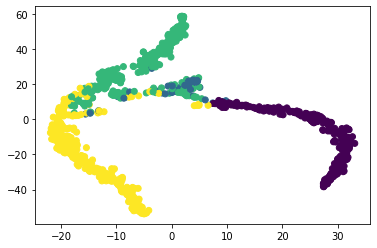

Epoch: 399, test_stats: 88.1000,test_stats: 0.0990 tensor([0.0144, 0.0362, 0.0293, 0.0192])
minimum 0.011214942


In [96]:
criterion = torch.nn.CrossEntropyLoss()
stats_FIERCE = torch.zeros(0,200,3)
### Model
net_FIERCE = Net(dim=100,embedding = 100,FIERCE_parameter = 4)
train_acc_list,MSE_list,Entropy_list = experiment(net_FIERCE,train_loader,test_loader,epochs= 200,lr = 0.0001)  
cat_elements = torch.stack([train_acc_list,MSE_list,Entropy_list], dim = 1).unsqueeze(0)
stats_FIERCE = torch.cat([stats_FIERCE, cat_elements], dim = 0)
regressor = Regressor(dim=100,embedding = 100)
stats_regressor_FIERCE = torch.zeros(0,400,2)
train_acc_list,MSE_list = experiment_regression(regressor,net_FIERCE,train_loader,test_loader,epochs= 400,lr = 0.1)  
cat_elements = torch.stack([train_acc_list,MSE_list], dim = 1).unsqueeze(0)
stats_regressor_FIERCE = torch.cat([stats_regressor_FIERCE , cat_elements], dim = 0)

We compute the mutual information of each criteria: https://arxiv.org/abs/1906.02629

In [97]:
print(mutual_information(net_CE)) 
print(mutual_information(net_FIERCE))
print(mutual_information(net_LS))

tensor(1.7109, grad_fn=<DivBackward0>)
tensor(0.3933, grad_fn=<DivBackward0>)
tensor(0.5536, grad_fn=<DivBackward0>)


We compute the Stability Measure https://arxiv.org/abs/2104.00676

In [98]:
print(Stability(net_CE))
print(Stability(net_FIERCE))
print(Stability(net_LS))

tensor(0.8832, grad_fn=<RsubBackward1>)
tensor(0.9310, grad_fn=<RsubBackward1>)
tensor(0.9297, grad_fn=<RsubBackward1>)


We compute the reliabity diagrams 

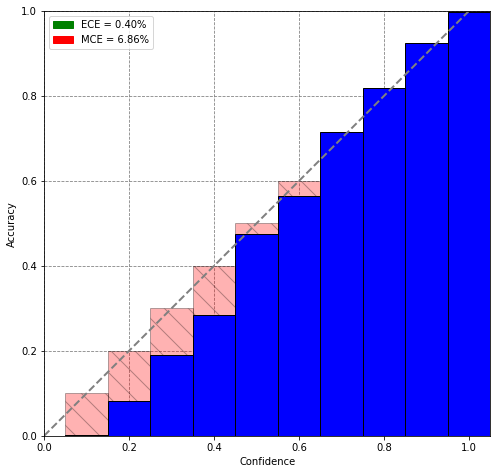

In [101]:
pred_CE,__,__= net_CE(torch.tensor(X.T).float())
draw_reliability_graph(F.softmax(pred_CE,-1).detach().numpy())

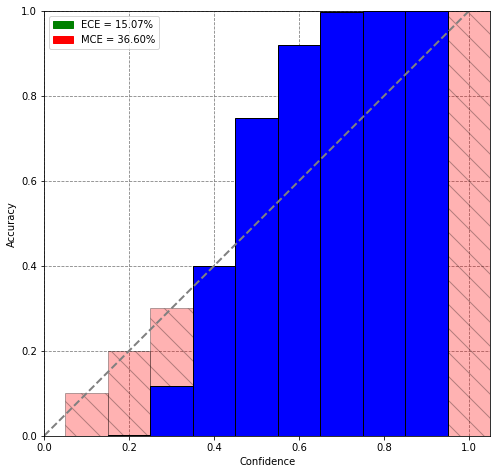

In [102]:
pred_LS,__,__= net_LS(torch.tensor(X.T).float())
draw_reliability_graph(F.softmax(pred_LS,-1).detach().numpy())

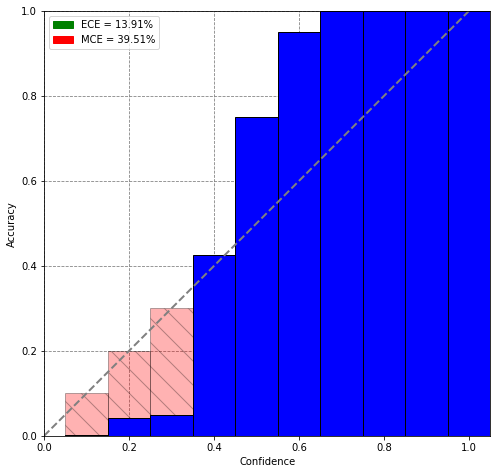

In [104]:
pred_FIERCE,__,__= net_FIERCE(torch.tensor(X.T).float())
draw_reliability_graph(F.softmax(pred_FIERCE,-1).detach().numpy())